In [1]:
#import nupic
import pandas
import time
import copy
import os
import numpy as np
import math
import datetime
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sys
import seaborn as sns

import nupic
from nupic.algorithms import anomaly_likelihood
from nupic.frameworks.opf.common_models.cluster_params import getScalarMetricWithTimeOfDayAnomalyParams
from nupic.frameworks.opf.model_factory import ModelFactory
from nab.detectors.base import AnomalyDetector
from nab.util import (absoluteFilePaths, createPath)
#from nupic.data.record_stream import RecordStreamIface

#import stream DataHandles
from pkg_resources import resource_filename
from nupic.data.file_record_stream import FileRecordStream

In [2]:
#file locations
src_path = "C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\csv\DEMAGNET_MAX_SPEED_FILT.csv"
dest_path = "C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\csv\DEMAGNET_MAX_SPEED_FILT_htm.csv"

In [3]:
df_demag =pandas.read_csv("C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\csv\DEMAGNET_MAX_SPEED_FILT.csv")
df_htm_demag = df_demag[["DATE", "DEMAGNET_MAX_SPEED_FILT"]].rename(index=str, columns={"DATE": "timestamp", "DEMAGNET_MAX_SPEED_FILT": "value"})
print(df_htm_demag.info(verbose=True), df_htm_demag.head(5))
#print(df_demag[["IPB.TEMP.BAG", "IPB.TEMP.BULKHEAD"]])

<class 'pandas.core.frame.DataFrame'>
Index: 42708 entries, 0 to 42707
Data columns (total 2 columns):
timestamp    42708 non-null object
value        42708 non-null float64
dtypes: float64(1), object(1)
memory usage: 1001.0+ KB
(None,              timestamp     value
0  2018-04-13 15:33:41  3.683064
1  2018-04-13 15:34:10  4.699998
2  2018-04-13 15:34:15  4.750997
3  2018-04-13 15:34:52  4.158429
4  2018-04-13 15:34:59  5.437248)


CSV file handle Class

In [4]:
#Data Object class to read and transform csv file into Data Object 
class DataFile(object):
  """
  Class for storing and manipulating a single datafile.
  Data is stored in pandas.DataFrame
  """

  def __init__(self, srcPath):
    """
    @param srcPath (string)   Filename of datafile to read.
    """
    self.srcPath = srcPath

    self.fileName = os.path.split(srcPath)[1]

    self.data = pandas.io.parsers.read_csv(self.srcPath,
                                           header=0, parse_dates=[0])


  def write(self, newPath=None):
    """Write datafile to self.srcPath or newPath if given.

    @param newPath (string)   Path to write datafile to. If path is not given,
                              write to source path
    """

    path = newPath if newPath else self.srcPath
    self.data.to_csv(path, index=False)


  def modifyData(self, columnName, data=None, write=False):
    """Add columnName to datafile if data is given otherwise remove
    columnName.

    @param columnName (string)          Name of the column in the datafile to
                                        either add or remove.

    @param data       (pandas.Series)   Column data to be added to datafile.
                                        Data length should be as long as the
                                        length of other columns.

    @param write      (boolean) Flag to choose whether to write modifications to
                                source path.
    """
    if isinstance(data, pandas.Series):
      self.data[columnName] = data
    else:
      if columnName in self.data:
        del self.data[columnName]

    if write:
      self.write()


  def getTimestampRange(self, t1, t2):
    """Given timestamp range, get all records that are within that range.

    @param t1   (int)   Starting timestamp.

    @param t2   (int)   Ending timestamp.

    @return     (list)  Timestamp and value for each time stamp within the
                        timestamp range.
    """
    tmp = self.data[self.data["timestamp"] >= t1]
    ans = tmp[tmp["timestamp"] <= t2]["timestamp"].tolist()
    return ans


  def __str__(self):
    ans = ""
    ans += "path:                %s\n" % self.srcPath
    ans += "file name:           %s\n"% self.fileName
    ans += "data size:         ", self.data.shape()
    ans += "sample line: %s\n" % ", ".join(self.data[0])
    return ans

In [5]:

#delete columns from origin file
csv_orig = DataFile(src_path)

#IPB.TEMP.BULKHEAD,IPB.TEMP.BAG,DEMAGNET_MAX_SPEED_FILT,DATE
csv_orig.modifyData("IPB.TEMP.BULKHEAD")
csv_orig.modifyData("IPB.TEMP.BAG")
csv_orig.data
#csv_orig.write(dest_path)

#create data file object
inputData = DataFile(dest_path)
inputData.data.head()
#inputData.getTimestampRange("2018-04-13 15:36:23", "2018-04-13 17:17:47")

value            timestamp
0  3.68306402768  2018-04-13 15:33:41
1  4.69999763742  2018-04-13 15:34:10
2  4.75099685913  2018-04-13 15:34:15
3  4.15842928183  2018-04-13 15:34:52
4  5.43724819629  2018-04-13 15:34:59

NumentaDetector Class inherits from AnomalyDetector

In [8]:
# Fraction outside of the range of values seen so far that will be considered
# a spatial anomaly regardless of the anomaly likelihood calculation. This
# accounts for the human labelling bias for spatial values larger than what
# has been seen so far.
SPATIAL_TOLERANCE = 0.05


class NumentaDetector(AnomalyDetector):
    #This detector uses an HTM based anomaly detection technique.#
    def __init__(self, *args, **kwargs):
        super(NumentaDetector, self).__init__(*args, **kwargs)
        
        self.model = None
        self.sensorParams = None
        self.anomalyLikelihood = None
        # Keep track of value range for spatial anomaly detection
        self.minVal = None
        self.maxVal = None

    # Set this to False if you want to get results based on raw scores
    # without using AnomalyLikelihood. This will give worse results, but
    # useful for checking the efficacy of AnomalyLikelihood. You will need
    # to re-optimize the thresholds when running with this setting.
        self.useLikelihood = True
  
    def getAdditionalHeaders(self):
        """Returns a list of strings."""
        return ["raw_score"]


    def handleRecord(self, inputData):
        """Returns a tuple (anomalyScore, rawScore).
        Internally to NuPIC "anomalyScore" corresponds to "likelihood_score"
        and "rawScore" corresponds to "anomaly_score". Sorry about that.
        """
        # Send it to Numenta detector and get back the results
        result = self.model.run(inputData)
        # Get the value
        value = inputData["value"]

        # Retrieve the anomaly score and write it to a file
        rawScore = result.inferences["anomalyScore"]

        # Update min/max values and check if there is a spatial anomaly
        spatialAnomaly = False
        if self.minVal != self.maxVal:
            tolerance = (self.maxVal - self.minVal) * SPATIAL_TOLERANCE
            maxExpected = self.maxVal + tolerance
            minExpected = self.minVal - tolerance
            if value > maxExpected or value < minExpected:
                spatialAnomaly = True
        if self.maxVal is None or value > self.maxVal:
            self.maxVal = value
        if self.minVal is None or value < self.minVal:
            self.minVal = value

        if self.useLikelihood:
            # Compute log(anomaly likelihood)
            anomalyScore = self.anomalyLikelihood.anomalyProbability(
                inputData["value"], rawScore, inputData["timestamp"])
            logScore = self.anomalyLikelihood.computeLogLikelihood(anomalyScore)
            finalScore = logScore
        else:
            finalScore = rawScore

        if spatialAnomaly:
            finalScore = 1.0

        return (finalScore, rawScore)


    def initialize(self):
        #How to create the HTM model, you know basicaly the min and max
        #Get config params, setting the RDSE resolution
        self.inputMin=float(self.inputMin)
        self.inputMax=float(self.inputMax)
        
        rangePadding = abs(self.inputMax - self.inputMin) * 0.2

        #best htm parameters for anomaly detection(Timestamp,value)
        #best practise parameters: Return a dict that can be used to create an anomaly model via Model.create
        #modelParams["modelParams"]["sensorParams"]["encoders"]
        #RandomDistributedEncoder
        modelParams = getScalarMetricWithTimeOfDayAnomalyParams(
            metricData=[0],
            minVal=self.inputMin-rangePadding,
            maxVal=self.inputMax+rangePadding,
            minResolution=0.001,
            tmImplementation = "cpp"
        )["modelConfig"]

        self._setupEncoderParams(
            modelParams["modelParams"]["sensorParams"]["encoders"])
    
        #create your HTM model with parameters and given data
        self.model = ModelFactory.create(modelParams)
    
        #OPF for prediction, not used for anomaly detection
        self.model.enableInference({"predictedField": "value"})

        if self.useLikelihood:
            # Initialize the anomaly likelihood object
            numentaLearningPeriod = int(math.floor(self.probationaryPeriod / 2.0))
            self.anomalyLikelihood = anomaly_likelihood.AnomalyLikelihood(
                learningPeriod=numentaLearningPeriod,
                estimationSamples=self.probationaryPeriod-numentaLearningPeriod,
                reestimationPeriod=100
            )

        #setup encoder(expect "timestamp" and "value" as headers)
    def _setupEncoderParams(self, encoderParams):
        # The encoder must expect the NAB-specific datafile headers
        encoderParams["timestamp_dayOfWeek"] = encoderParams.pop("c0_dayOfWeek")
        encoderParams["timestamp_timeOfDay"] = encoderParams.pop("c0_timeOfDay")
        encoderParams["timestamp_timeOfDay"]["fieldname"] = "timestamp"
        encoderParams["timestamp_timeOfDay"]["name"] = "timestamp"
        encoderParams["timestamp_weekend"] = encoderParams.pop("c0_weekend")
        encoderParams["value"] = encoderParams.pop("c1")
        encoderParams["value"]["fieldname"] = "value"
        encoderParams["value"]["name"] = "value"

        self.sensorParams = encoderParams["value"]

In [9]:
#if filelength > 5000, then learning window probationPercent * 5000, else probationPercent*Filelength
ad = NumentaDetector(inputData, 0.1)
ad.initialize()
print("inputMin and inputMAX: " + str(ad.inputMax) + "," +  str(ad.inputMin))
print("minVal and minVal: " + str(ad.minVal) + "," + str( ad.maxVal))
print("Sensor parameter: " + str(ad.sensorParams))
print("Anomaly Likelihood: " + str(ad.anomalyLikelihood))

print(ad.probationaryPeriod)

inputMin and inputMAX: 9.99991689537,-0.00678548289104
minVal and minVal: None,None
Sensor parameter: {u'name': 'value', 'resolution': 0.1077644871505035, u'seed': 42, u'fieldname': 'value', u'type': u'RandomDistributedScalarEncoder'}
Anomaly Likelihood: AnomalyLikelihood: 0 deque([], maxlen=8640) None 500.0 250 100
500.0


In [10]:
input_file = csv.DictReader(open(dest_path))


timestamp_list = []
value_list = []
anomaly_score_list = []
raw_score_list = []


for row in input_file:
    #print(datetime.datetime.strptime(row["timestamp"], '%Y-%m-%d %H:%M:%S'))
    row["timestamp"] = datetime.datetime.strptime(row["timestamp"], '%Y-%m-%d %H:%M:%S')
    row["value"] = float(row["value"])
    print(row)
    anomalyScore, rawScore =  ad.handleRecord(row)
    print(anomalyScore, rawScore)
    #time.sleep(1)
    timestamp_list.append(row["timestamp"])
    value_list.append(row["value"])
    anomaly_score_list.append(anomalyScore)
    raw_score_list.append(rawScore)
        
df_anomaly = pandas.DataFrame(
    {'timestamp': timestamp_list,
     'value': value_list ,
     'raw score': raw_score_list,
     'anomaly score': anomaly_score_list,
    })

print(df_anomaly)

{'timestamp': datetime.datetime(2018, 4, 13, 15, 33, 41), 'value': 3.68306402768}
(0.0301029996658834, 1.0)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 34, 10), 'value': 4.69999763742}
(0.0301029996658834, 1.0)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 34, 15), 'value': 4.75099685913}
(1.0, 1.0)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 34, 52), 'value': 4.15842928183}
(0.0301029996658834, 1.0)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 34, 59), 'value': 5.43724819629}
(1.0, 0.625)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 35, 14), 'value': 6.34452015201}
(1.0, 0.92500001)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 36, 12), 'value': 7.25890441298}
(1.0, 1.0)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 36, 23), 'value': 6.34809915245}
(0.0301029996658834, 1.0)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 36, 32), 'value': 3.85353063705}
(0.0301029996658834, 0.875)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 36, 42), 'value': 4.54067199

(0.0301029996658834, 0.025)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 57, 22), 'value': 7.39217941692}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 57, 34), 'value': 8.30968528165}
(0.0301029996658834, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 57, 56), 'value': 4.74806312748}
(0.0301029996658834, 0.175)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 58, 2), 'value': 5.06504973552}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 58, 25), 'value': 7.84595067169}
(0.0301029996658834, 0.1)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 58, 49), 'value': 10.2765862087}
(1.0, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 58, 54), 'value': 6.03793007008}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 59, 22), 'value': 7.59115971722}
(0.0301029996658834, 0.025)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 59, 28), 'value': -0.768403967551}
(1.0, 0.375)
{'timesta

(0.0301029996658834, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 28, 12), 'value': 5.0461752673}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 28, 35), 'value': 3.44899928331}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 28, 47), 'value': 5.45010570466}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 28, 55), 'value': 5.46549606247}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 29, 17), 'value': 5.64572662924}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 29, 41), 'value': 4.6259712066}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 29, 50), 'value': 1.43403615001}
(0.0301029996658834, 0.2)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 30, 5), 'value': 6.20268637854}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 30, 32), 'value': 6.10149028642}
(0.0301029996658834, 0.

(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 54, 4), 'value': 4.62644296296}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 54, 28), 'value': 3.16874838299}
(0.0301029996658834, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 54, 35), 'value': 5.42765935113}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 54, 57), 'value': 5.39945011304}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 55, 8), 'value': 6.28451608859}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 55, 15), 'value': 5.24883218166}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 55, 35), 'value': 4.19893360125}
(0.0301029996658834, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 55, 40), 'value': 8.81361653216}
(0.0301029996658834, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 13, 16, 56, 4), 'value': 2.36265210881}
(0.03010

(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 18, 34), 'value': 5.15757580119}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 18, 45), 'value': 8.54087830104}
(0.0301029996658834, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 19, 9), 'value': 5.41932810507}
(0.0301029996658834, 0.025)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 19, 14), 'value': 5.96205504989}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 19, 36), 'value': 6.70892536639}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 20), 'value': 4.88863318053}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 20, 23), 'value': 5.7537859034}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 20, 33), 'value': 5.30148303943}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 20, 45), 'value': 6.95772103606}
(0.0301029996658834, 0.0

(0.0301029996658834, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 47, 5), 'value': 5.73553337928}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 47, 29), 'value': 5.1269905455}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 47, 35), 'value': 3.49198633809}
(0.0301029996658834, 0.025)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 48, 4), 'value': 7.40831894545}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 48, 8), 'value': 4.07118990608}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 48, 31), 'value': 6.34173850734}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 48, 38), 'value': 4.90879284821}
(0.0301029996658834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 48, 50), 'value': 2.34522084911}
(0.0301029996658834, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 13, 17, 48, 55), 'value': 5.74178755207}
(0.0301029996658

(0.0997471247466636, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 12), 'value': 5.6323853707}
(0.10883455363781633, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 12, 22), 'value': 5.11422285599}
(0.10883455363781633, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 13, 15), 'value': 4.77763375512}
(0.10883455363781633, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 13, 22), 'value': 5.84881910593}
(0.10883455363781633, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 13, 45), 'value': 5.74901483821}
(0.10883455363781633, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 13, 57), 'value': 5.59724249928}
(0.10883455363781633, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 14, 4), 'value': 5.37061085114}
(0.10883455363781633, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 14, 24), 'value': 5.87130561718}
(0.10883455363781633, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 14, 33), 'value': 6.05609862874}
(0.0997471247466636, 0.025

(0.06146913892576838, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 38, 43), 'value': 3.48247772281}
(0.055188840708615745, 0.025)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 38, 48), 'value': 7.16031229791}
(0.055188840708615745, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 39, 16), 'value': 5.51526581292}
(0.055188840708615745, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 39, 22), 'value': 5.8618916816}
(0.055188840708615745, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 39, 44), 'value': 3.8326602211}
(0.055188840708615745, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 39, 49), 'value': 4.51109399743}
(0.055188840708615745, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 40, 13), 'value': 5.57457303979}
(0.06146913892576838, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 40, 35), 'value': 5.14732737247}
(0.06819602583884006, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 41, 4), 'value': 7.85967951462}
(0.055

(0.11005802876498558, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 4, 26), 'value': 5.51636992311}
(0.11005802876498558, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 4, 50), 'value': 4.97810159751}
(0.11005802876498558, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 5, 14), 'value': 6.98285344979}
(0.11005802876498558, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 5, 25), 'value': 7.57822494975}
(0.10080956566851929, 0.025)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 5, 31), 'value': 3.7820181748}
(0.10080956566851929, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 5, 41), 'value': 4.51090382546}
(0.10080956566851929, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 6, 13), 'value': 6.92801880847}
(0.10080956566851929, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 6, 19), 'value': 5.25488621555}
(0.10080956566851929, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 6, 44), 'value': 4.89166887497}
(0.10080956566851929, 0.0)


(0.038865111582708764, 0.2)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 31, 35), 'value': 6.61562602228}
(0.06123773442169371, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 31, 47), 'value': 9.28287929161}
(0.14909794381650468, 0.375)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 32, 10), 'value': 5.40918303491}
(0.6045391487766194, 0.97500002)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 32, 33), 'value': 4.07125165033}
(0.29999999673506555, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 32, 38), 'value': 6.38566716195}
(0.29999999673506555, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 33, 1), 'value': 4.01889643554}
(0.29999999673506555, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 33, 25), 'value': 5.74045239223}
(0.29999999673506555, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 33, 36), 'value': 7.3492797832}
(0.29999999673506555, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 34, 3), 'value': 6.43975849446}
(0.299

(0.0636674656229217, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 56, 16), 'value': 4.58199207596}
(0.0636674656229217, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 56, 23), 'value': 6.11916944322}
(0.0636674656229217, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 56, 47), 'value': 6.59963264306}
(0.0636674656229217, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 58, 1), 'value': 6.14225459782}
(0.0636674656229217, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 58, 13), 'value': 8.06024338044}
(0.06021871986314222, 0.025)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 58, 28), 'value': 6.73214617446}
(0.056893889591082866, 0.025)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 58, 37), 'value': 4.96528981803}
(0.056893889591082866, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 59, 1), 'value': 4.89778483022}
(0.056893889591082866, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 19, 59, 24), 'value': 3.52917466941}
(0.0536914890205628

(0.058413362848321666, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 20, 30, 17), 'value': 8.82361719785}
(0.04346834439663136, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 13, 20, 30, 25), 'value': 3.39001599015}
(0.03245484561335993, 0.2)
{'timestamp': datetime.datetime(2018, 4, 13, 20, 30, 48), 'value': 5.16610382639}
(0.03245484561335993, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 20, 30, 54), 'value': 7.01100219716}
(0.03245484561335993, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 20, 31, 19), 'value': 5.13441762237}
(0.03245484561335993, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 20, 31, 30), 'value': 6.31108988278}
(0.03433652934838946, 0.025)
{'timestamp': datetime.datetime(2018, 4, 13, 20, 31, 36), 'value': 5.91656371789}
(0.036291618511705905, 0.025)
{'timestamp': datetime.datetime(2018, 4, 13, 20, 31, 59), 'value': 4.75117859329}
(0.036291618511705905, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 20, 32, 23), 'value': 4.99529921569}
(0.03

{'timestamp': datetime.datetime(2018, 4, 13, 20, 58, 1), 'value': 5.11145395041}
(0.05644248462567796, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 20, 58, 6), 'value': 5.57154506855}
(0.05644248462567796, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 20, 58, 29), 'value': 5.21027346723}
(0.05644248462567796, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 20, 58, 38), 'value': 5.81162223771}
(0.058992339950046636, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 20, 59, 1), 'value': 4.37876167534}
(0.058992339950046636, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 20, 59, 12), 'value': 6.31011507684}
(0.058992339950046636, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 20, 59, 17), 'value': 4.97179285481}
(0.058992339950046636, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 20, 59, 41), 'value': 4.75149607424}
(0.058992339950046636, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 0, 10), 'value': 7.27076724811}
(0.058992339950046636, 0.0)
{'timestamp': dat

(0.05827058155011624, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 22, 16), 'value': 4.53432287495}
(0.05827058155011624, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 22, 39), 'value': 7.9510472117}
(0.055885604442905364, 0.025)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 22, 44), 'value': 5.44909335181}
(0.055885604442905364, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 23, 7), 'value': 5.03994836672}
(0.055885604442905364, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 23, 29), 'value': 8.47087668809}
(0.042916379337395776, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 23, 40), 'value': 7.43629113194}
(0.03549842629621861, 0.1)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 23, 45), 'value': 4.96002150332}
(0.03549842629621861, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 24, 9), 'value': 3.89798196479}
(0.03549842629621861, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 24, 32), 'value': 5.92965638083}
(0.035498

(0.041801923414424416, 0.52499998)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 48, 16), 'value': 4.92146723903}
(0.17372384718194495, 1.0)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 48, 33), 'value': 6.90495165312}
(0.17372384718194495, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 49, 10), 'value': 4.75419837463}
(0.17372384718194495, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 49, 18), 'value': 6.40926190452}
(0.17372384718194495, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 49, 25), 'value': 5.1933892226}
(0.17372384718194495, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 49, 33), 'value': 4.18778661247}
(0.17372384718194495, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 49, 56), 'value': 5.52909990111}
(0.17372384718194495, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 50, 28), 'value': 4.73008728964}
(0.17372384718194495, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 21, 51, 36), 'value': 5.96201653075}
(0.173723847

(0.057534765513063565, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 24, 25), 'value': 5.86593880106}
(0.057534765513063565, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 24, 49), 'value': 5.63556499965}
(0.057534765513063565, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 25, 4), 'value': 7.02224485134}
(0.057534765513063565, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 25, 9), 'value': 5.26551334852}
(0.057534765513063565, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 25, 29), 'value': 4.60280959318}
(0.057534765513063565, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 25, 38), 'value': 5.86320325064}
(0.057534765513063565, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 25, 57), 'value': 7.69351095515}
(0.05076119840968982, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 26, 11), 'value': 8.49534958116}
(0.032053376198640994, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 26, 16), 'value': 6.1709874669}

(0.04453705360686878, 0.175)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 51, 36), 'value': 5.28733950875}
(0.05869325791453572, 0.57499999)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 51, 47), 'value': 7.35308480718}
(0.05869325791453572, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 52, 16), 'value': 4.9953025192}
(0.05869325791453572, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 52, 41), 'value': 3.85063078745}
(0.05869325791453572, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 52, 46), 'value': 6.54693546978}
(0.05869325791453572, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 53, 9), 'value': 4.75326774931}
(0.05869325791453572, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 53, 19), 'value': 4.49021982121}
(0.05869325791453572, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 53, 43), 'value': 4.10844598101}
(0.05869325791453572, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 22, 53, 54), 'value': 7.0400045943}
(0.0586932579

{'timestamp': datetime.datetime(2018, 4, 13, 23, 25, 11), 'value': 2.92021897749}
(0.1642296852897387, 0.125)
{'timestamp': datetime.datetime(2018, 4, 13, 23, 25, 35), 'value': 4.15596070349}
(0.1946267218495471, 0.175)
{'timestamp': datetime.datetime(2018, 4, 13, 23, 25, 41), 'value': 6.33234755294}
(0.1946267218495471, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 23, 26, 40), 'value': 1.05359798705}
(0.3224199219087837, 0.60000002)
{'timestamp': datetime.datetime(2018, 4, 13, 23, 26, 54), 'value': 5.79735864273}
(0.6191645317291775, 1.0)
{'timestamp': datetime.datetime(2018, 4, 13, 23, 27, 6), 'value': 5.45700055244}
(0.29999999673506555, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 23, 27, 28), 'value': 3.77418099729}
(0.29999999673506555, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 23, 27, 34), 'value': 5.96224826245}
(0.29999999673506555, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 23, 28, 8), 'value': 7.55352989017}
(0.45013724617502204, 0.025)
{'timestamp':

(0.0733959893854116, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 23, 55, 9), 'value': 7.78725078346}
(0.0733959893854116, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 23, 55, 21), 'value': 7.12824414016}
(0.0733959893854116, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 23, 55, 47), 'value': 2.48322384964}
(0.09156818936083486, 0.175)
{'timestamp': datetime.datetime(2018, 4, 13, 23, 56, 10), 'value': 5.20182742725}
(0.24710992735772672, 1.0)
{'timestamp': datetime.datetime(2018, 4, 13, 23, 56, 15), 'value': 5.04231971654}
(0.24710992735772672, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 23, 56, 22), 'value': 6.00148215575}
(0.24710992735772672, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 23, 56, 46), 'value': 4.65103912346}
(0.24710992735772672, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 23, 57, 13), 'value': 5.00608968249}
(0.19964856576438186, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 23, 57, 25), 'value': 7.34080155211}
(0.08881596310161294,

(0.06157216369457819, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 0, 31, 58), 'value': 6.72028541049}
(0.06157216369457819, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 0, 32, 45), 'value': 6.49772992597}
(0.06157216369457819, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 0, 32, 54), 'value': 4.55392247164}
(0.06157216369457819, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 0, 32, 59), 'value': 7.39316361309}
(0.06157216369457819, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 0, 33, 10), 'value': 5.43822966043}
(0.06275094779320313, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 0, 33, 15), 'value': 5.97193431725}
(0.06275094779320313, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 0, 33, 40), 'value': 4.01391779008}
(0.06275094779320313, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 0, 34, 11), 'value': 7.44064365821}
(0.06275094779320313, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 0, 34, 18), 'value': 6.3202443054}
(0.06275094779320313, 0.0)
{'

(0.08276215677326935, 0.2)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 4, 8), 'value': 6.21694484524}
(0.08276215677326935, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 4, 20), 'value': 6.04185044928}
(0.05533593706218637, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 4, 45), 'value': 6.1193049272}
(0.049400760687603004, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 5, 8), 'value': 5.22683071812}
(0.049400760687603004, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 5, 15), 'value': 6.59799300327}
(0.049400760687603004, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 5, 38), 'value': 4.78320133473}
(0.049400760687603004, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 5, 47), 'value': 0.0172693844195}
(0.04354333145169442, 0.57499999)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 6, 3), 'value': 6.79641058313}
(0.10035469012193886, 0.67500001)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 6, 15), 'value': 8.84876173314}
(0.14225067614555087,

(0.05783321259641451, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 38), 'value': 5.46527775867}
(0.059600392552355136, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 38, 5), 'value': 7.56536018405}
(0.059600392552355136, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 38, 35), 'value': 7.63813879992}
(0.059600392552355136, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 39, 28), 'value': 3.68097101216}
(0.05610061080431566, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 39, 45), 'value': 4.78818789997}
(0.05610061080431566, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 39, 54), 'value': 6.59839834123}
(0.05273823322858724, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 40), 'value': 4.61843623477}
(0.05273823322858724, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 40, 23), 'value': 6.356310121}
(0.051107990669222725, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 1, 40, 49), 'value': 6.17842558865}
(0.049511392968

(0.038858667791541124, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 10, 54), 'value': 4.69191212521}
(0.04165622830256068, 0.125)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 11, 17), 'value': 4.88653365263}
(0.04165622830256068, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 11, 22), 'value': 5.50068938677}
(0.04030820996408428, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 11, 51), 'value': 7.17586191261}
(0.050931365814766406, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 11, 57), 'value': 3.72793035453}
(0.050931365814766406, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 12, 20), 'value': 4.30118235203}
(0.050931365814766406, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 12, 30), 'value': 3.5835913726}
(0.050931365814766406, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 12, 53), 'value': 3.99993418546}
(0.050931365814766406, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 13, 29), 'value': 5.26605592551}
(0.05093136581476

(0.03953625257728573, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 44, 32), 'value': 4.77190532351}
(0.03953625257728573, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 44, 58), 'value': 5.405885496}
(0.03953625257728573, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 45, 9), 'value': 6.09860370746}
(0.03953625257728573, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 45, 34), 'value': 2.11692729526}
(0.03582839172145186, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 45, 39), 'value': 6.52941162215}
(0.047386132981905325, 0.5)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 46, 1), 'value': 5.26144712121}
(0.047386132981905325, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 46, 7), 'value': 2.35901004481}
(0.05752148256395717, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 46, 26), 'value': 4.96258279953}
(0.07101958357666079, 0.175)
{'timestamp': datetime.datetime(2018, 4, 14, 2, 46, 50), 'value': 5.1483477287}
(0.0689780955613

(0.09917999475697147, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 16, 31), 'value': 7.47985931215}
(0.065145047811424, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 16, 53), 'value': 5.82601573138}
(0.03976240311960349, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 17, 9), 'value': 5.82866587021}
(0.03976240311960349, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 17, 38), 'value': 6.82706540558}
(0.03976240311960349, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 18, 8), 'value': 7.34738498186}
(0.03434280143292092, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 18, 13), 'value': 8.17389696878}
(0.03434280143292092, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 18, 18), 'value': 7.52741489182}
(0.03564722804465569, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 18, 24), 'value': 7.61551274619}
(0.03564722804465569, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 18, 47), 'value': 6.42407675143}
(0.061496169838442735, 0.0)


(0.04129907640293701, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 47, 9), 'value': 7.3081788783}
(0.05771554422482224, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 47, 14), 'value': 8.33157538103}
(0.0524067837848984, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 47, 23), 'value': 2.69574123003}
(0.0524067837848984, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 48, 6), 'value': 7.47007528124}
(0.05771554422482224, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 48, 49), 'value': 8.99990398812}
(0.05771554422482224, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 48, 55), 'value': 9.63296663022}
(0.059560241339173085, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 49, 18), 'value': 7.65166552284}
(0.059560241339173085, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 49, 40), 'value': 9.38915112967}
(0.06336382578196881, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 14, 3, 49, 52), 'value': 9.99991689537}

(0.04595982804789831, 0.2)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 17, 46), 'value': 8.45441999938}
(0.0329979491575027, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 17, 56), 'value': 8.16772820788}
(0.0329979491575027, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 18, 21), 'value': 8.06131908845}
(0.0403341728695855, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 18, 45), 'value': 10.1889427397}
(0.0403341728695855, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 18, 51), 'value': 9.2068722484}
(0.0403341728695855, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 18, 57), 'value': 12.3052709769}
(0.044905810647459105, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 19, 27), 'value': 11.196217876}
(0.04650349568636347, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 19, 33), 'value': 11.2458231823}
(0.044905810647459105, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 19, 56), 'value': 9.2137356546}
(0.04650349568636347, 0.

(0.05361707521931066, 0.2)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 48, 57), 'value': 9.60125418362}
(0.055200835742736314, 0.80000001)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 49, 12), 'value': 12.9568424082}
(0.06493690782120257, 0.125)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 49, 18), 'value': 13.1634947619}
(0.0780034653892793, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 49, 45), 'value': 9.80577176084}
(0.0780034653892793, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 49, 50), 'value': 11.7776620491}
(0.08033146917044491, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 49, 59), 'value': 3.69265106641}
(0.12059229791076519, 0.375)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 50, 18), 'value': 13.1026546348}
(0.23281182881667772, 0.75)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 50, 24), 'value': 12.9659764062}
(0.23281182881667772, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 4, 50, 47), 'value': 10.4475488985}
(0.23281

(0.05159151374382459, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 16, 47), 'value': 10.8349052974}
(0.05159151374382459, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 17, 10), 'value': 11.0545798974}
(0.0533761013930972, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 17, 33), 'value': 10.2693124414}
(0.04170931464060897, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 17, 56), 'value': 10.9474674936}
(0.031057053306520577, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 18, 7), 'value': 13.1202758155}
(0.06391478829149522, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 18, 19), 'value': 9.61716084174}
(0.0659822658171185, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 18, 41), 'value': 10.1729561777}
(0.0659822658171185, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 18, 46), 'value': 10.7390483515}
(0.0659822658171185, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 18, 52), 'value': 12.549697166}
(0.06391478829149522, 0.025)


(0.04797678453729981, 0.1)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 42, 49), 'value': 12.6965620673}
(0.04797678453729981, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 43, 17), 'value': 9.64709865428}
(0.04797678453729981, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 43, 40), 'value': 11.1287267072}
(0.046301244308053616, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 43, 45), 'value': 12.0317366155}
(0.046301244308053616, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 43, 52), 'value': 8.09063411308}
(0.037821856557704425, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 44, 15), 'value': 10.7836662908}
(0.04232743505293566, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 44, 27), 'value': 10.798177852}
(0.04232743505293566, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 44, 52), 'value': 9.80109442216}
(0.04232743505293566, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 5, 45, 28), 'value': 13.4730951596}
(0.05796558730687455, 0.05

(0.06800189840826547, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 15, 25), 'value': 13.7404103995}
(0.048562564162868194, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 15, 37), 'value': 12.4448640408}
(0.043546095241178244, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 15, 42), 'value': 11.8620371093}
(0.043546095241178244, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 16, 5), 'value': 11.9626374827}
(0.043546095241178244, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 16, 28), 'value': 11.0963005087}
(0.043546095241178244, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 16, 33), 'value': 9.70164287938}
(0.043546095241178244, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 16, 56), 'value': 10.1006714953}
(0.043546095241178244, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 17, 26), 'value': 12.7745256049}
(0.043546095241178244, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 17, 31), 'value': 9.03438559034}
(0.041

(0.06985328406834508, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 48, 19), 'value': 12.3144257593}
(0.06985328406834508, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 48, 24), 'value': 12.4812079393}
(0.06985328406834508, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 48, 48), 'value': 11.1079808161}
(0.06985328406834508, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 49, 12), 'value': 13.9651057772}
(0.06549857970295278, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 49, 17), 'value': 11.5797429276}
(0.061323145488499466, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 49, 40), 'value': 9.92430743298}
(0.061323145488499466, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 50, 3), 'value': 10.5751695638}
(0.061323145488499466, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 50, 14), 'value': 11.679751592}
(0.061323145488499466, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 6, 50, 20), 'value': 11.4602070082}
(0.0613231

(0.034699741828362995, 0.25)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 17, 31), 'value': 10.297784834}
(0.053041618670405, 0.64999998)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 17, 42), 'value': 13.148948337}
(0.05118484128012812, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 18, 9), 'value': 9.23166652303}
(0.053041618670405, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 18, 32), 'value': 10.5058094755}
(0.053041618670405, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 18, 38), 'value': 9.66739483329}
(0.053041618670405, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 18, 44), 'value': 13.7808741502}
(0.0568869272600577, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 19, 18), 'value': 11.0093246636}
(0.0568869272600577, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 19, 27), 'value': 12.0102319793}
(0.0568869272600577, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 19, 50), 'value': 10.5359969984}
(0.0568869272600577, 0.

(0.06937773065222898, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 48, 23), 'value': 10.1719196649}
(0.06937773065222898, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 48, 28), 'value': 10.3759225838}
(0.06937773065222898, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 48, 50), 'value': 10.2267266455}
(0.06937773065222898, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 49), 'value': 8.91077324225}
(0.06937773065222898, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 49, 25), 'value': 11.8534455794}
(0.06937773065222898, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 49, 36), 'value': 11.2352631955}
(0.06937773065222898, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 49, 42), 'value': 10.8697962408}
(0.06937773065222898, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 50, 7), 'value': 11.2141325138}
(0.06937773065222898, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 7, 50, 37), 'value': 15.2216141926}
(0.03470392596628869, 0.47499999)

{'timestamp': datetime.datetime(2018, 4, 14, 8, 17, 37), 'value': 11.119976159}
(0.11258468768396535, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 8, 18, 11), 'value': 12.4234726319}
(0.11258468768396535, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 8, 18, 23), 'value': 11.5991242211}
(0.11258468768396535, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 8, 18, 31), 'value': 9.6088267022}
(0.11258468768396535, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 8, 18, 55), 'value': 10.8451542804}
(0.059837977244270424, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 8, 19), 'value': 8.75735481649}
(0.06128048049611044, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 8, 19, 24), 'value': 11.7137289122}
(0.06128048049611044, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 8, 19, 35), 'value': 13.9071915474}
(0.059247750119211795, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 14, 8, 19, 59), 'value': 10.9986535605}
(0.06335798042921499, 0.025)
{'timestamp': datetime

(0.059539888942896066, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 8, 49), 'value': 10.3695872267}
(0.059539888942896066, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 8, 49, 6), 'value': 11.2965480304}
(0.059539888942896066, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 8, 49, 29), 'value': 9.89274484625}
(0.059539888942896066, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 8, 49, 40), 'value': 12.6729956631}
(0.059539888942896066, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 8, 50, 4), 'value': 10.1724837028}
(0.059539888942896066, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 8, 50, 19), 'value': 14.7809901746}
(0.030216959849676726, 0.44999999)
{'timestamp': datetime.datetime(2018, 4, 14, 8, 50, 24), 'value': 12.0253513922}
(0.1040950921284736, 0.94999999)
{'timestamp': datetime.datetime(2018, 4, 14, 8, 50, 55), 'value': 13.9359712311}
(0.1040950921284736, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 14, 8, 51, 2), 'value': 12.677491056}
(0.107009

(0.04473182371409271, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 19, 39), 'value': 9.88353262276}
(0.04473182371409271, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 20, 12), 'value': 12.6691335349}
(0.04306471455705456, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 20, 17), 'value': 12.3676731688}
(0.05564277065620394, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 20, 42), 'value': 10.7127700832}
(0.06380836623396062, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 20, 54), 'value': 12.1456810428}
(0.06380836623396062, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 21, 9), 'value': 10.2105236383}
(0.06596431319243884, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 21, 36), 'value': 11.575655836}
(0.06816670659529687, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 21, 59), 'value': 9.04586813278}
(0.06596431319243884, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 22, 4), 'value': 11.025607471}
(0.06380836623396062, 0.025)

(0.04036657317592753, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 50, 7), 'value': 11.006743483}
(0.04036657317592753, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 50, 36), 'value': 12.5126013847}
(0.04036657317592753, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 50, 41), 'value': 11.4297612317}
(0.043571716082574055, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 51, 8), 'value': 7.4664783873}
(0.03108484305428807, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 51, 13), 'value': 9.64132872926}
(0.07907100261579642, 0.89999998)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 51, 19), 'value': 11.3335858123}
(0.07200748693225119, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 51, 42), 'value': 8.8935784845}
(0.07200748693225119, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 51, 56), 'value': 11.6505362371}
(0.07200748693225119, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 9, 52, 30), 'value': 11.74910296}
(0.07200748693225119

(0.04189828051144096, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 22, 47), 'value': 9.13144948542}
(0.05616602283678073, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 23, 8), 'value': 10.372809842}
(0.07099046418913436, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 23, 38), 'value': 11.2352921311}
(0.07099046418913436, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 23, 46), 'value': 10.8063323666}
(0.07099046418913436, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 24, 9), 'value': 10.549320998}
(0.07099046418913436, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 24, 32), 'value': 8.46866097645}
(0.06224452842781409, 0.1)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 24, 52), 'value': 12.6155317905}
(0.05422974932735938, 0.1)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 25, 3), 'value': 12.1827601028}
(0.05422974932735938, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 25, 21), 'value': 8.91567337364}
(0.052337858958003865, 0

(0.04514941116316644, 0.125)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 55, 5), 'value': 9.88576314064}
(0.04514941116316644, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 55, 10), 'value': 9.71621653819}
(0.04514941116316644, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 55, 39), 'value': 13.5357646516}
(0.041815059938510035, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 55, 46), 'value': 11.943532899}
(0.041815059938510035, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 55, 55), 'value': 5.3904678374}
(0.03138121779774082, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 56, 11), 'value': 13.2460217633}
(0.11726982059972381, 0.97500002)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 56, 36), 'value': 8.94731448045}
(0.11726982059972381, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 57), 'value': 13.9076264326}
(0.11726982059972381, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 10, 57, 24), 'value': 10.6876941623

(0.1526674347906139, 0.875)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 25, 12), 'value': 9.52864691594}
(0.1526674347906139, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 25, 41), 'value': 13.3219148419}
(0.1526674347906139, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 25, 47), 'value': 11.0765581981}
(0.14534186922360395, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 26, 9), 'value': 11.6877253796}
(0.100018604779408, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 26, 33), 'value': 10.421737788}
(0.09717210662459572, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 26, 56), 'value': 8.77788307148}
(0.10291632997762176, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 27, 1), 'value': 11.8668036718}
(0.10291632997762176, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 27, 24), 'value': 11.6050261119}
(0.09163187704227782, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 27, 36), 'value': 12.4900519174}
(0.05248111565258

(0.06080271873774727, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 46, 48), 'value': 11.3818270616}
(0.06080271873774727, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 47, 22), 'value': 9.99645651859}
(0.06080271873774727, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 47, 49), 'value': 10.7114034921}
(0.06080271873774727, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 47, 58), 'value': 5.06360768958}
(0.046736781880676634, 0.72500002)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 48, 12), 'value': 11.2259313578}
(0.14880284085208464, 0.94999999)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 48, 36), 'value': 11.8436757849}
(0.14516106561997105, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 49, 26), 'value': 13.003840562}
(0.14516106561997105, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 49, 37), 'value': 13.0659767186}
(0.1380396914766028, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 11, 49, 42), 'value': 10.3383197933}
(0.1

(0.06629037029335182, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 16, 20), 'value': 10.2230614307}
(0.06194902940114017, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 16, 43), 'value': 12.5380246792}
(0.06194902940114017, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 16, 48), 'value': 11.653467464}
(0.03820556285785549, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 17, 10), 'value': 10.3598820367}
(0.07225159019551983, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 17, 21), 'value': 14.2055029701}
(0.053084368004538154, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 17, 52), 'value': 8.1207635887}
(0.03915812649581404, 0.2)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 17, 57), 'value': 10.6245595789}
(0.03915812649581404, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 18, 11), 'value': 13.465082054}
(0.03915812649581404, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 18, 20), 'value': 12.1556485132}
(0.03915812649

(0.044589277882407734, 0.69999999)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 44, 48), 'value': 11.5067381579}
(0.06406208304336232, 0.25)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 44, 54), 'value': 12.5916507309}
(0.06406208304336232, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 45, 19), 'value': 11.3355110918}
(0.05979421044779788, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 45, 43), 'value': 9.40497181297}
(0.05979421044779788, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 45, 48), 'value': 12.2666837948}
(0.057731538708444316, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 46), 'value': 12.7442886908}
(0.057731538708444316, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 46, 25), 'value': 11.4648736095}
(0.057731538708444316, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 46, 49), 'value': 8.69109366273}
(0.057731538708444316, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 12, 46, 54), 'value': 13.0225526365}
(0.0537469

(0.07319020871318542, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 14, 53), 'value': 13.346102223}
(0.07319020871318542, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 14, 57), 'value': 10.7136430268}
(0.07319020871318542, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 15, 10), 'value': 9.16141823356}
(0.07319020871318542, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 15, 23), 'value': 12.2965706579}
(0.07319020871318542, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 15, 30), 'value': 11.8995414251}
(0.07319020871318542, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 15, 53), 'value': 10.9388475834}
(0.07319020871318542, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 16, 43), 'value': 12.4365926855}
(0.06862699410321968, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 17, 5), 'value': 6.7614976277}
(0.04508782776199411, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 17, 34), 'value': 11.3294935775}
(0.0434

(0.09644406195301816, 0.125)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 46, 20), 'value': 11.4820052144}
(0.056197454126138933, 0.44999999)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 46, 25), 'value': 11.6000727632}
(0.035718903971786356, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 46, 49), 'value': 10.0853205104}
(0.03129338277764383, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 47, 19), 'value': 9.74289590481}
(0.03129338277764383, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 47, 33), 'value': 11.9924954459}
(0.03129338277764383, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 47, 37), 'value': 9.34752441666}
(0.03129338277764383, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 47, 43), 'value': 9.93008049073}
(0.03129338277764383, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 48, 5), 'value': 11.705215208}
(0.03129338277764383, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 13, 48, 33), 'value': 10.5603721829}
(0.0312933

(0.07646582554813168, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 16, 9), 'value': 11.786764728}
(0.07646582554813168, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 16, 44), 'value': 11.8809264943}
(0.07646582554813168, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 16, 53), 'value': 7.64351775759}
(0.09456354546706171, 0.175)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 17, 28), 'value': 9.93041973119}
(0.23263794850241012, 0.92500001)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 17, 37), 'value': 12.706038977}
(0.23263794850241012, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 18, 5), 'value': 10.1210969034}
(0.21413169319171543, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 18, 38), 'value': 13.8620810973}
(0.22792786207458368, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 18, 43), 'value': 12.5324618176}
(0.1880336786107468, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 19, 6), 'value': 11.2695170399}
(0.074

(0.03253099665809436, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 46, 25), 'value': 11.4334160017}
(0.03253099665809436, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 46, 52), 'value': 9.337685287}
(0.03253099665809436, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 47, 2), 'value': 5.5560158827}
(0.04452042580070669, 0.2)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 47, 18), 'value': 11.016981586}
(0.11747329954849652, 0.77499998)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 47, 32), 'value': 12.140888601}
(0.11747329954849652, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 47, 54), 'value': 11.0719192522}
(0.11747329954849652, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 48, 6), 'value': 13.3719760951}
(0.11747329954849652, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 48, 11), 'value': 11.0971447434}
(0.11747329954849652, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 14, 48, 35), 'value': 10.1397149057}
(0.081445735

(0.044509748084490354, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 11, 1), 'value': 10.725285344}
(0.04287235635568818, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 11, 31), 'value': 12.7232244193}
(0.04287235635568818, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 11, 39), 'value': 10.6869632625}
(0.04287235635568818, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 11, 50), 'value': 12.7745830692}
(0.04287235635568818, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 12, 16), 'value': 11.2598749776}
(0.04287235635568818, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 12, 39), 'value': 9.31087387322}
(0.04287235635568818, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 13, 2), 'value': 9.18424287059}
(0.03672819362906289, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 13, 26), 'value': 9.2637630296}
(0.07255587721616315, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 13, 31), 'value': 10.7543220833}
(0.07255587721616315, 

(0.05369762707643011, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 47, 31), 'value': 9.98066906405}
(0.04478308248539048, 0.125)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 47, 46), 'value': 12.5877705107}
(0.04478308248539048, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 47, 51), 'value': 12.060236033}
(0.04478308248539048, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 48, 20), 'value': 12.8311955585}
(0.04478308248539048, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 48, 26), 'value': 13.108466103}
(0.04478308248539048, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 48, 45), 'value': 8.83880351377}
(0.043127564276596544, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 48, 53), 'value': 9.24387484204}
(0.041513619385164756, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 49, 18), 'value': 12.310995225}
(0.041513619385164756, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 15, 49, 41), 'value': 11.5408519514}
(0.041

{'timestamp': datetime.datetime(2018, 4, 14, 16, 17, 18), 'value': 10.601515465}
(0.03966943901423394, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 16, 17, 41), 'value': 9.39822501297}
(0.03966943901423394, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 16, 17, 46), 'value': 8.78362050075}
(0.04124540029645656, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 16, 18, 9), 'value': 10.9690899072}
(0.04975791439930708, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 16, 18, 21), 'value': 12.708624402}
(0.04975791439930708, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 16, 18, 42), 'value': 10.6243493859}
(0.04975791439930708, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 16, 18, 53), 'value': 12.3928560753}
(0.04975791439930708, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 16, 18, 58), 'value': 13.3702594515}
(0.04975791439930708, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 16, 19, 26), 'value': 8.99930823012}
(0.06785536227361587, 0.0)
{'timestamp': date

(0.049332340114102535, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 16, 43, 43), 'value': 11.7821209786}
(0.049332340114102535, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 16, 43, 49), 'value': 12.3186944194}
(0.0364525309318931, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 16, 44), 'value': 12.8459824699}
(0.0678224149648097, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 16, 44, 23), 'value': 10.4387698241}
(0.0678224149648097, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 16, 44, 29), 'value': 11.1714269825}
(0.0678224149648097, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 16, 44, 52), 'value': 10.9618294371}
(0.0678224149648097, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 16, 45, 15), 'value': 9.90676123418}
(0.0678224149648097, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 16, 45, 38), 'value': 11.4316997115}
(0.0678224149648097, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 16, 45, 49), 'value': 12.9593612401}
(0.07237772191889527, 0.0)
{

(0.0460644230381127, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 14, 20), 'value': 12.9824809982}
(0.0460644230381127, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 14, 26), 'value': 14.0481897603}
(0.04782080069319681, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 14, 54), 'value': 9.61347473013}
(0.055289621950843394, 0.125)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 15, 5), 'value': 11.8694984742}
(0.055289621950843394, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 15, 10), 'value': 7.39646748866}
(0.032023402111333525, 0.42500001)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 15, 34), 'value': 10.3379280192}
(0.08965621814190003, 0.72500002)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 16), 'value': 9.75028235871}
(0.08965621814190003, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 16, 25), 'value': 11.6443052067}
(0.08965621814190003, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 16, 36), 'value': 9.24140453602}

(0.07242903110740888, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 40, 47), 'value': 10.4818067263}
(0.07242903110740888, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 41, 13), 'value': 9.12071196586}
(0.07242903110740888, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 41, 37), 'value': 10.9522353892}
(0.07242903110740888, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 41, 42), 'value': 12.7599628637}
(0.07242903110740888, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 41, 47), 'value': 10.9248985379}
(0.07242903110740888, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 42, 20), 'value': 11.1981916844}
(0.07242903110740888, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 42, 25), 'value': 9.14119531893}
(0.07242903110740888, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 42, 49), 'value': 8.86466343202}
(0.07242903110740888, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 17, 43), 'value': 12.9186735451}
(0.07012182242285117, 0

(0.03532767772066996, 0.1)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 7, 10), 'value': 8.18090941425}
(0.06222449055264329, 0.60000002)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 7, 15), 'value': 11.1996571025}
(0.06222449055264329, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 7, 21), 'value': 9.38127907249}
(0.06222449055264329, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 7, 33), 'value': 10.2501870687}
(0.06222449055264329, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 7, 58), 'value': 12.6727373857}
(0.06222449055264329, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 8, 3), 'value': 9.3464278388}
(0.06222449055264329, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 8, 39), 'value': 9.79798726528}
(0.06222449055264329, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 9, 7), 'value': 11.3398442854}
(0.041896778996790056, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 9, 31), 'value': 9.07618056008}
(0.03578164096281029, 0

(0.06558755954210252, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 38, 14), 'value': 12.7550742833}
(0.06558755954210252, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 38, 39), 'value': 12.7918790247}
(0.05528154357596253, 0.125)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 38, 44), 'value': 11.35733079}
(0.05528154357596253, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 39, 35), 'value': 10.314474039}
(0.05528154357596253, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 40, 7), 'value': 13.9319224207}
(0.03953299887445752, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 40, 12), 'value': 9.22174397193}
(0.03363010593830412, 0.1)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 40, 19), 'value': 11.0316847456}
(0.03363010593830412, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 40, 47), 'value': 11.7053792997}
(0.03363010593830412, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 18, 40, 52), 'value': 10.6761886121}
(0.033

(0.04246143148669795, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 19, 13, 24), 'value': 11.274075812}
(0.03336975807113988, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 19, 13, 41), 'value': 14.3855462086}
(0.037944384184343066, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 14, 19, 14, 16), 'value': 10.3719038536}
(0.04936830744313031, 0.44999999)
{'timestamp': datetime.datetime(2018, 4, 14, 19, 14, 27), 'value': 13.6483161514}
(0.04582807744940238, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 19, 14, 57), 'value': 10.7935640418}
(0.037729783698878694, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 19, 15, 21), 'value': 12.4276437796}
(0.037729783698878694, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 19, 15, 48), 'value': 12.6211623293}
(0.033369757759834154, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 19, 15, 59), 'value': 11.6377049741}
(0.031996882005462905, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 19, 16, 3), 'value': 13.3668867489}


(0.1236451943439163, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 14, 19, 54, 22), 'value': 16.33503715}
(0.15866465088124415, 0.5)
{'timestamp': datetime.datetime(2018, 4, 14, 19, 54, 27), 'value': 14.2087179638}
(0.14402511532345902, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 19, 54, 59), 'value': 13.9795945703}
(0.14402511532345902, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 19, 55, 6), 'value': 9.22669652595}
(0.14049749887314622, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 19, 55, 32), 'value': 12.9943992638}
(0.17415758101022855, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 14, 19, 58, 47), 'value': 15.1045270025}
(0.12043071768242443, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 14, 20, 1, 47), 'value': 14.8485641795}
(0.1440251192953295, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 14, 20, 2, 14), 'value': 15.3663421636}
(0.13702248810555337, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 20, 2, 41), 'value': 13.68675229

(0.14698836160980747, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 20, 41, 57), 'value': 16.1126214407}
(0.15397678151563565, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 14, 20, 44, 34), 'value': 17.1798887161}
(0.14698836212324448, 0.2)
{'timestamp': datetime.datetime(2018, 4, 14, 20, 45, 1), 'value': 15.5019622312}
(0.1504582540365238, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 14, 20, 45, 13), 'value': 18.939375073}
(0.11198983267336206, 0.1)
{'timestamp': datetime.datetime(2018, 4, 14, 20, 45, 39), 'value': 16.6653863927}
(0.04290760168433899, 0.125)
{'timestamp': datetime.datetime(2018, 4, 14, 20, 45, 44), 'value': 16.8183593974}
(0.036907551678159005, 0.1)
{'timestamp': datetime.datetime(2018, 4, 14, 20, 46, 10), 'value': 16.2186820402}
(0.03550200034529429, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 20, 46, 38), 'value': 14.7426438379}
(0.031505772106223594, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 20, 46, 44), 'value': 14.8243439856}
(0

(0.06681610455848364, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 14, 21, 23, 39), 'value': 16.0981569347}
(0.06894777512963168, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 21, 23, 45), 'value': 19.9645792791}
(0.08025934332190021, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 14, 21, 23, 51), 'value': 17.505682207}
(0.08265401768270801, 0.1)
{'timestamp': datetime.datetime(2018, 4, 14, 21, 24, 18), 'value': 15.3673737489}
(0.04952990459236828, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 21, 25, 5), 'value': 17.4249591688}
(0.05491829104566347, 0.1)
{'timestamp': datetime.datetime(2018, 4, 14, 21, 25, 16), 'value': 18.7299638848}
(0.05871615990707528, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 14, 21, 25, 21), 'value': 19.1762665828}
(0.06268133375517322, 0.25)
{'timestamp': datetime.datetime(2018, 4, 14, 21, 25, 49), 'value': 18.1548178421}
(0.07560307313760317, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 14, 21, 26, 13), 'value': 16

(0.09451248575652868, 0.69999999)
{'timestamp': datetime.datetime(2018, 4, 14, 22, 15, 51), 'value': 17.1739799369}
(0.09451248575652868, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 22, 15, 59), 'value': 16.1327367993}
(0.09190283064220012, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 22, 16, 24), 'value': 14.5521265966}
(0.09190283064220012, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 22, 16, 36), 'value': 16.9998783188}
(0.09190283064220012, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 22, 17, 7), 'value': 16.3677551737}
(0.09190283064220012, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 22, 17, 12), 'value': 17.1552295728}
(0.09190283064220012, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 22, 17, 40), 'value': 13.6725097759}
(0.09190283064220012, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 22, 18, 5), 'value': 18.7618125159}
(0.09986932928474943, 0.1)
{'timestamp': datetime.datetime(2018, 4, 14, 22, 18, 33), 'value': 16.6748880178}
(0.040843336

(0.21769112560417364, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 23, 11, 55), 'value': 19.0080457401}
(0.13364765753946595, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 23, 13, 1), 'value': 17.3078826523}
(0.12404032413991967, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 23, 13, 27), 'value': 16.8668751931}
(0.12404032413991967, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 23, 13, 54), 'value': 17.0067847017}
(0.12404032413991967, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 23, 14, 19), 'value': 20.0893360612}
(0.1402952527073924, 0.125)
{'timestamp': datetime.datetime(2018, 4, 14, 23, 14, 25), 'value': 17.184081162}
(0.1402952527073924, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 23, 14, 59), 'value': 19.8736364222}
(0.1402952527073924, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 23, 15, 4), 'value': 18.1338738927}
(0.04745036854948006, 0.025)
{'timestamp': datetime.datetime(2018, 4, 14, 23, 15, 28), 'value': 19.0822717568}
(0.05523688116915

(0.04992321761716762, 0.2)
{'timestamp': datetime.datetime(2018, 4, 15, 0, 58, 3), 'value': 17.048952559}
(0.04992321761716762, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 0, 58, 8), 'value': 18.2914057096}
(0.05538569767501067, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 0, 58, 14), 'value': 17.805949937}
(0.05538569767501067, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 0, 58, 19), 'value': 17.5019045906}
(0.05538569767501067, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 0, 58, 44), 'value': 14.7854280381}
(0.03713557169810531, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 15, 0, 59, 27), 'value': 15.9770843326}
(0.03432716996567611, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 1, 0, 2), 'value': 11.2685405909}
(0.070794263145879, 0.67500001)
{'timestamp': datetime.datetime(2018, 4, 15, 1, 0, 7), 'value': 17.9869221101}
(0.1337255391527448, 0.57499999)
{'timestamp': datetime.datetime(2018, 4, 15, 1, 0, 40), 'value': 14.6969922952}
(0.13372553

(0.05012849258653645, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 1, 30, 54), 'value': 15.1451458829}
(0.05012849258653645, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 1, 31, 21), 'value': 15.5241531526}
(0.05012849258653645, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 1, 32, 7), 'value': 13.9311718822}
(0.0677331036203615, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 1, 32, 12), 'value': 13.0029422758}
(0.06560519098628634, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 1, 32, 29), 'value': 16.0654618703}
(0.0677331036203615, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 1, 32, 56), 'value': 16.5829445474}
(0.0677331036203615, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 1, 33, 40), 'value': 15.3968109283}
(0.07212095245563753, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 1, 33, 49), 'value': 15.472413845}
(0.07212095245563753, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 1, 34, 17), 'value': 15.7629227512}
(0.07212095245563753, 0.0)
{'ti

(0.0722722958682466, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 9, 57), 'value': 15.670104461}
(0.0722722958682466, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 10, 2), 'value': 12.85736755}
(0.0722722958682466, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 10, 26), 'value': 14.8715212048}
(0.0722722958682466, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 11, 9), 'value': 14.8746472}
(0.0722722958682466, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 11, 43), 'value': 11.6708633692}
(0.04184740043264748, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 11, 48), 'value': 16.5235835562}
(0.04184740043264748, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 12, 10), 'value': 15.8703856234}
(0.04184740043264748, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 12, 34), 'value': 14.5817436829}
(0.04184740043264748, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 13, 1), 'value': 14.0939359898}
(0.03878653312736855, 0.075000003)
{

(0.05755166813269485, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 44, 6), 'value': 14.6945889346}
(0.05755166813269485, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 44, 41), 'value': 15.8594153765}
(0.05755166813269485, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 44, 49), 'value': 14.0437050183}
(0.05952562852582316, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 45, 16), 'value': 14.3738842079}
(0.06154317074529357, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 45, 27), 'value': 14.6517108077}
(0.06154317074529357, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 45, 32), 'value': 15.1065094532}
(0.07229499043736048, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 49, 5), 'value': 13.5459154448}
(0.07229499043736048, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 49, 32), 'value': 12.790189528}
(0.07229499043736048, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 2, 49, 38), 'value': 12.2070818238}
(0.0636045983444824, 0.1)
{'t

(0.07261792732485255, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 3, 20, 17), 'value': 11.8004750524}
(0.04670178802251531, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 15, 3, 20, 49), 'value': 14.3491186095}
(0.04501049095446291, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 3, 20, 56), 'value': 14.863300224}
(0.04670178802251531, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 3, 21, 2), 'value': 14.2049032583}
(0.04670178802251531, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 3, 21, 29), 'value': 12.3231246894}
(0.04670178802251531, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 3, 22, 24), 'value': 16.1433780474}
(0.04670178802251531, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 3, 22, 50), 'value': 12.4502365773}
(0.04670178802251531, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 3, 23, 13), 'value': 16.1938399725}
(0.04501049095446291, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 3, 23, 36), 'value': 11.4382870801}
(0.0433606317612016

{'timestamp': datetime.datetime(2018, 4, 15, 3, 52, 2), 'value': 17.0227769132}
(0.037042150997344696, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 3, 52, 7), 'value': 13.8343016846}
(0.03558905759737283, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 3, 52, 18), 'value': 5.1922243796}
(0.06816025465643633, 0.94999999)
{'timestamp': datetime.datetime(2018, 4, 15, 3, 52, 38), 'value': 10.5288451337}
(0.07266260428026941, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 3, 52, 44), 'value': 16.5727924962}
(0.07498331853313825, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 3, 53, 11), 'value': 13.9699073372}
(0.06384145467918363, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 3, 53, 16), 'value': 13.2344089179}
(0.0659780559144273, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 3, 53, 27), 'value': 9.11698257383}
(0.07498331818385036, 0.1)
{'timestamp': datetime.datetime(2018, 4, 15, 3, 53, 42), 'value': 12.9117405805}
(0.07498331818385036, 0.0)
{'time

(0.04006830520437769, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 22, 49), 'value': 16.8684118796}
(0.04006830520437769, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 22, 54), 'value': 17.1850188722}
(0.032800675353836406, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 23, 19), 'value': 16.6038376975}
(0.04817814534530124, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 24), 'value': 14.3867645571}
(0.03838526079864483, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 24, 31), 'value': 13.6927237819}
(0.03689628959188224, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 24, 59), 'value': 12.1924817967}
(0.0481781446905302, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 25, 4), 'value': 14.6851519257}
(0.0481781446905302, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 25, 31), 'value': 13.9386247668}
(0.05750614551109799, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 26, 3), 'value': 16.1958252314}
(0.05177908436163382, 0.

(0.03110887826886525, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 52, 4), 'value': 15.4448168993}
(0.03110887826886525, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 52, 10), 'value': 17.227680998}
(0.03110887826886525, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 52, 21), 'value': 8.0097437862}
(0.0989174379354023, 0.875)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 52, 49), 'value': 16.692755482}
(0.12294116035396398, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 56, 3), 'value': 13.4380678348}
(0.11976181349219013, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 56, 29), 'value': 14.5352639168}
(0.11976181349219013, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 56, 40), 'value': 7.96981774225}
(0.11052766460421463, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 56, 57), 'value': 11.6875790939}
(0.11663323585416406, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 4, 57, 9), 'value': 16.4763791776}
(0.116633

(0.04145389589533773, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 5, 24, 54), 'value': 13.1915221555}
(0.03291834855119955, 0.25)
{'timestamp': datetime.datetime(2018, 4, 15, 5, 25, 28), 'value': 15.6038672524}
(0.03291834855119955, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 5, 25, 34), 'value': 16.0068364257}
(0.03156992287099077, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 5, 26, 20), 'value': 13.1806245837}
(0.03156992287099077, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 5, 26, 52), 'value': 13.4813122488}
(0.041453896491482164, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 15, 5, 27, 21), 'value': 15.1427351912}
(0.041453896491482164, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 5, 27, 49), 'value': 13.8474605127}
(0.041453896491482164, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 5, 27, 54), 'value': 11.79372608}
(0.04307502834352465, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 5, 28, 1), 'value': 15.8366568815}
(0.04473816

(0.05197683964962873, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 5, 58, 22), 'value': 15.2090397745}
(0.0705932943208831, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 5, 58, 49), 'value': 13.6266792371}
(0.0705932943208831, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 5, 59, 2), 'value': 13.6220311234}
(0.0705932943208831, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 5, 59, 33), 'value': 12.6710282888}
(0.0661347683446597, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 5, 59, 44), 'value': 6.78739756362}
(0.054135343686218, 0.92500001)
{'timestamp': datetime.datetime(2018, 4, 15, 6, 0), 'value': 13.0857343794}
(0.054135343686218, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 6, 0, 11), 'value': 15.0715804159}
(0.05224169789731395, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 6, 0, 39), 'value': 15.3189467376}
(0.05224169789731395, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 6, 0, 44), 'value': 14.0295800228}
(0.05224169789731395, 0.0)
{'t

(0.0705932943208831, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 6, 27, 24), 'value': 15.9000185369}
(0.0705932943208831, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 6, 27, 29), 'value': 14.1273395549}
(0.0708689922341094, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 6, 27, 57), 'value': 13.6471025167}
(0.07318380085782565, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 6, 28, 8), 'value': 15.8198042527}
(0.07318380085782565, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 6, 28, 17), 'value': 14.1105327421}
(0.07318380085782565, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 6, 28, 23), 'value': 14.9941519362}
(0.0708689922341094, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 6, 32, 49), 'value': 9.34625976835}
(0.0484704953776788, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 15, 6, 33, 18), 'value': 14.5665990222}
(0.046704158882679814, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 6, 33, 24), 'value': 13.760555643}
(0.046704158882679814, 

(0.03410183929139347, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 3, 46), 'value': 15.1329883481}
(0.03410183929139347, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 4, 15), 'value': 10.9515065431}
(0.06656847017066478, 0.60000002)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 4, 40), 'value': 16.7502765676}
(0.06439120875856005, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 4, 45), 'value': 12.9192301737}
(0.03422193927429263, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 5, 13), 'value': 14.055381767}
(0.03422193927429263, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 9, 50), 'value': 10.9234302056}
(0.04180159440250497, 0.125)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 10, 18), 'value': 12.5938292395}
(0.04180159440250497, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 10, 29), 'value': 16.3179565564}
(0.046852675422625084, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 10, 57), 'value': 12.9433446004}
(0.052294

(0.035696960221304995, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 36, 11), 'value': 12.6491199571}
(0.035696960221304995, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 36, 45), 'value': 16.0122897664}
(0.03149082348285287, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 36, 50), 'value': 11.740824795}
(0.038704828488402274, 0.175)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 37, 4), 'value': 14.8243170199}
(0.04522578868897683, 0.1)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 37, 11), 'value': 16.4937574656}
(0.04696376075148336, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 37, 37), 'value': 11.2606067354}
(0.03285273785279453, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 38, 5), 'value': 13.4083543865}
(0.03285273785279453, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 38, 10), 'value': 15.6249676049}
(0.032714114972490015, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 7, 38, 37), 'value': 9.43878304938}
(0.04505359506346576,

(0.04341554406006355, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 11, 41), 'value': 15.6379109905}
(0.04341554406006355, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 12, 7), 'value': 13.9278932231}
(0.04341554406006355, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 12, 34), 'value': 12.8180087828}
(0.03704162338580488, 0.1)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 12, 45), 'value': 8.26895416844}
(0.041757790905245666, 0.1)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 16, 59), 'value': 13.5741878022}
(0.04535986704625113, 0.625)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 17, 10), 'value': 14.7499527389}
(0.04198852293696839, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 17, 39), 'value': 12.6699474965}
(0.04198852293696839, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 17, 45), 'value': 13.800392015}
(0.04198852293696839, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 18, 53), 'value': 13.0647537455}
(0.04365238264818677, 0.025

(0.08174232047012163, 0.64999998)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 49, 29), 'value': 13.1932090869}
(0.09234813671034046, 0.1)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 49, 56), 'value': 12.6444989492}
(0.08962026784078546, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 50, 23), 'value': 13.367352194}
(0.09234813671034046, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 50, 29), 'value': 14.3683121182}
(0.09234813671034046, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 50, 41), 'value': 13.5230066859}
(0.09234813671034046, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 50, 54), 'value': 16.4011414051}
(0.05467983189333822, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 51, 2), 'value': 16.551478846}
(0.05273504650375024, 0.1)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 51, 6), 'value': 13.0571822563}
(0.08962026743811594, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 15, 8, 51, 34), 'value': 13.2036326229}
(0.106

(0.031581192883613746, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 9, 22, 41), 'value': 13.3729631676}
(0.034390666069918904, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 9, 23, 7), 'value': 13.8186019111}
(0.0421514552899895, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 9, 23, 18), 'value': 16.1289593129}
(0.043833708804503047, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 9, 23, 48), 'value': 12.3140629255}
(0.037366712000149245, 0.1)
{'timestamp': datetime.datetime(2018, 4, 15, 9, 24, 14), 'value': 13.5348879552}
(0.030237676146408113, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 15, 9, 24, 20), 'value': 14.2018270205}
(0.030237676146408113, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 9, 24, 37), 'value': 16.7108186823}
(0.031304033350642656, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 9, 24, 46), 'value': 16.5575800722}
(0.03585762316281898, 0.125)
{'timestamp': datetime.datetime(2018, 4, 15, 9, 25, 13), 'value': 14.632543

(0.042653499469430894, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 0, 28), 'value': 13.827486834}
(0.0443430565628398, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 0, 33), 'value': 14.873400883}
(0.04785523553856996, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 0, 45), 'value': 14.9603590247}
(0.04785523553856996, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 0, 51), 'value': 16.6607409324}
(0.04434305618026853, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 1, 19), 'value': 11.5799455933}
(0.04434305618026853, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 1, 45), 'value': 12.1236870989}
(0.04265349909669543, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 2, 12), 'value': 15.0507430665}
(0.04967868069029683, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 2, 38), 'value': 13.1223857517}
(0.04967868069029683, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 2, 50), 'value': 16.5137708597}
(0.04785

(0.03216451113239745, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 32, 33), 'value': 16.5747245855}
(0.032088688799804616, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 32, 59), 'value': 12.2068282327}
(0.03793386449297746, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 33, 31), 'value': 15.9919579106}
(0.044462807484120126, 0.1)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 33, 37), 'value': 14.1384907027}
(0.04276486763445453, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 34, 5), 'value': 16.1305381292}
(0.04276486763445453, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 37, 10), 'value': 7.93814496305}
(0.04276486763445453, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 37, 27), 'value': 14.4445982018}
(0.04982545892419452, 0.1)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 37, 32), 'value': 15.4765554017}
(0.04276486763445453, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 10, 37, 58), 'value': 14.48886364

(0.030804240650897433, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 7, 57), 'value': 12.3450080905}
(0.07308741127642662, 0.60000002)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 8, 22), 'value': 15.6334128046}
(0.07073130140984053, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 8, 33), 'value': 17.4154841424}
(0.07073130140984053, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 8, 39), 'value': 13.9893167257}
(0.05362866493946672, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 8, 45), 'value': 12.3845962262}
(0.057617978426704096, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 9, 12), 'value': 13.4347582506}
(0.057617978426704096, 0.1)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 9, 39), 'value': 13.2054528645}
(0.04446280991915762, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 10, 23), 'value': 13.6367669478}
(0.04446280991915762, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 10, 54), 'value': 13.17041760

(0.036253886860751254, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 41, 26), 'value': 17.4728790117}
(0.036253886860751254, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 41, 35), 'value': 13.1626391694}
(0.04786847067832629, 0.175)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 42, 2), 'value': 14.1526616689}
(0.035219019315632386, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 42, 34), 'value': 14.5927944235}
(0.035219019315632386, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 42, 59), 'value': 14.6950954725}
(0.03984158424283764, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 43, 7), 'value': 14.8934907733}
(0.052178849707938, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 43, 41), 'value': 15.3079203938}
(0.052178849707938, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 43, 49), 'value': 14.8030183596}
(0.052178849707938, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 11, 44, 13), 'value': 14.9074189034}
(0.052178

(0.0433415537549266, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 12, 21), 'value': 15.3697901209}
(0.04507123841237114, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 12, 48), 'value': 13.0734926224}
(0.046846454572319285, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 12, 59), 'value': 13.7184616203}
(0.04507123841237114, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 13, 6), 'value': 12.3363055789}
(0.0433415537549266, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 13, 12), 'value': 12.6580751008}
(0.041656962248570295, 0.125)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 13, 40), 'value': 16.9088318445}
(0.05349544947108832, 0.625)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 14, 7), 'value': 15.2315969497}
(0.04426341722281285, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 14, 19), 'value': 8.10509801187}
(0.09684997547128042, 0.60000002)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 14, 34), 'value': 13.4042864476}
(0

(0.04181584419334155, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 46, 27), 'value': 10.9613125236}
(0.045251241755995104, 0.2)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 46, 41), 'value': 15.8451583219}
(0.058742939373999874, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 47, 36), 'value': 15.5712865407}
(0.05667248920282383, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 47, 43), 'value': 15.3740994499}
(0.05667248920282383, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 48, 10), 'value': 14.6181481684}
(0.054650380492954585, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 48, 37), 'value': 13.1841192315}
(0.05667248920282383, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 48, 42), 'value': 12.8830096024}
(0.05667248920282383, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 48, 48), 'value': 12.274547307}
(0.054650380492954585, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 12, 49, 16), 'value': 15.275805856}
(0.03257457

(0.0587759178655542, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 17, 35), 'value': 16.5648967652}
(0.0587759178655542, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 17, 40), 'value': 14.0115351105}
(0.05465895010366531, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 18, 7), 'value': 12.1471546349}
(0.03691762368812456, 0.25)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 18, 33), 'value': 13.3957885524}
(0.038485707087923364, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 19), 'value': 11.776606117}
(0.03779157339274079, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 19, 13), 'value': 16.0449001347}
(0.03779157339274079, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 19, 43), 'value': 12.3366141498}
(0.049900242299761734, 0.175)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 20, 35), 'value': 17.2982023544}
(0.05378099075540731, 0.175)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 20, 40), 'value': 14.686658836

(0.04024231258857134, 0.125)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 52, 9), 'value': 13.5035932862}
(0.04024231258857134, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 52, 37), 'value': 14.5709113734}
(0.04904338424108609, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 52, 42), 'value': 11.8154100132}
(0.035510040473086535, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 53, 28), 'value': 14.3157031687}
(0.035510040473086535, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 53, 33), 'value': 14.1887922912}
(0.035510040473086535, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 54), 'value': 13.6112569349}
(0.035510040473086535, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 54, 11), 'value': 17.2874982587}
(0.03177422791949972, 0.125)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 54, 39), 'value': 14.8329235804}
(0.03319541605336551, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 13, 54, 50), 'value': 8.23683918669}
(0.0713

(0.04190987024514701, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 25, 59), 'value': 12.7757089319}
(0.040242312220934114, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 26, 26), 'value': 12.3041246927}
(0.03931616725691961, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 26, 52), 'value': 12.1298011292}
(0.03616755478703292, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 27, 19), 'value': 14.7852074868}
(0.03616755478703292, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 27, 31), 'value': 16.5887998984}
(0.03771954828939026, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 27, 36), 'value': 16.2546006422}
(0.042645242728799444, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 28, 3), 'value': 14.6090723846}
(0.03931616725691961, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 28, 31), 'value': 14.2853431467}
(0.03117279713561247, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 28, 57), 'value': 

(0.04627521003480313, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 57, 7), 'value': 14.0861008067}
(0.04448371852274605, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 57, 34), 'value': 13.8592695885}
(0.04448371852274605, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 57, 45), 'value': 15.3721032243}
(0.042739237772536354, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 57, 51), 'value': 16.3308536126}
(0.05193624476109857, 0.125)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 58, 18), 'value': 16.0652226165}
(0.05595337695170627, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 58, 40), 'value': 11.6316370337}
(0.06235188755880102, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 58, 56), 'value': 16.2869204488}
(0.07403526323257933, 0.57499999)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 59, 4), 'value': 12.2809643919}
(0.05803611235946109, 0.125)
{'timestamp': datetime.datetime(2018, 4, 15, 14, 59, 9), 'value': 14.9713894

(0.0731659917565941, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 15, 27, 9), 'value': 16.9717056726}
(0.04551410630887111, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 15, 15, 27, 15), 'value': 13.4041691916}
(0.0419999326590762, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 15, 27, 42), 'value': 14.8807105128}
(0.04373336789820416, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 15, 31, 12), 'value': 12.756981575}
(0.0419999326590762, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 15, 31, 40), 'value': 13.5623153984}
(0.0419999326590762, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 15, 31, 45), 'value': 13.1360923214}
(0.0419999326590762, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 15, 32, 8), 'value': 12.0616936847}
(0.03867304755835674, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 15, 32, 17), 'value': 12.8786308112}
(0.03867304755835674, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 15, 32, 29), 'value': 15.023666

(0.12553264450090756, 0.25)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 0, 15), 'value': 10.2037970298}
(0.12553264450090756, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 0, 37), 'value': 11.5791945889}
(0.12553264450090756, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 0, 43), 'value': 10.2008996206}
(0.12553264450090756, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 1, 6), 'value': 9.79100724645}
(0.12553264450090756, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 1, 29), 'value': 10.5653134542}
(0.12210401920201311, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 1, 40), 'value': 13.9682438078}
(0.08270321763781237, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 1, 45), 'value': 12.3042038338}
(0.08270321763781237, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 2, 8), 'value': 12.6052314402}
(0.04530121646714751, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 2, 31), 'value': 12.4339570664}
(0.035317777154691816,

(0.05436567042227608, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 24, 52), 'value': 7.38809364738}
(0.05436567042227608, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 24, 58), 'value': 6.38956189795}
(0.05436567042227608, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 25, 21), 'value': 5.98743980045}
(0.03801025067714594, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 25, 44), 'value': 4.72083166423}
(0.040207099783523124, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 26, 6), 'value': 6.76761818787}
(0.040207099783523124, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 26, 26), 'value': 9.56805764279}
(0.049130561862144845, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 26, 54), 'value': 7.35712187639}
(0.05039155917811797, 0.625)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 27), 'value': 2.58732529543}
(0.06750379419733385, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 27, 12), 'value': 7.41373732872}
(0.20

{'timestamp': datetime.datetime(2018, 4, 15, 16, 56, 52), 'value': 3.72289478698}
(0.21563251664586322, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 57, 21), 'value': 2.19214491901}
(0.25577266954251493, 0.2)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 57, 26), 'value': 4.30210853142}
(0.4713242113327171, 0.97500002)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 57, 31), 'value': 5.86872820937}
(0.24025577735105882, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 58, 7), 'value': 0.729066674333}
(0.37481838128574335, 0.67500001)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 58, 33), 'value': 0.691043653389}
(0.65774443594951, 0.94999999)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 58, 47), 'value': 3.97477732506}
(0.29999999673506555, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 59, 11), 'value': 2.38523898136}
(0.35616459066447315, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 16, 59, 22), 'value': 4.52723202145}
(0.362323236

(0.04923996252449981, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 27, 27), 'value': 0.637280697055}
(0.05301225796383221, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 27, 33), 'value': 2.32557646553}
(0.05301225796383221, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 27, 57), 'value': 3.20023001783}
(0.06111620388573804, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 28, 22), 'value': 2.07830477076}
(0.06545363631028282, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 28, 33), 'value': 3.76114492872}
(0.07471283786857946, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 28, 59), 'value': 0.00737977162844}
(0.06111620435974594, 0.175)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 29, 22), 'value': -0.749025193469}
(0.03447275993448784, 0.375)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 29, 27), 'value': 1.41163671628}
(0.03447275993448784, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 29, 49), 'value': 2.36398689655}
(0.0344

(0.033758767168005216, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 51, 26), 'value': 4.73875605027}
(0.032389550738244295, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 52, 2), 'value': -1.23717241845}
(0.04535145938704748, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 52, 29), 'value': 0.20729732113}
(0.03044176865707707, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 52, 37), 'value': 0.640478091584}
(0.03044176865707707, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 53, 5), 'value': 0.887512868489}
(0.031754052366873356, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 53, 12), 'value': 2.36670177893}
(0.031754052366873356, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 53, 20), 'value': 1.15738509056}
(0.03310484930542946, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 53, 43), 'value': 2.42787839352}
(0.03310484930542946, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 17, 53, 49), 'value': 0.9891158

(0.10786473440583856, 0.875)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 17, 24), 'value': 2.20225370885}
(0.1049194135596607, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 17, 39), 'value': 1.80870419618}
(0.0909425489994299, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 18, 7), 'value': 1.03683634738}
(0.08569754574567717, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 18, 12), 'value': 1.96193734357}
(0.08569754574567717, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 18, 18), 'value': 0.913040215909}
(0.08569754574567717, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 18, 42), 'value': -0.983166928498}
(0.05625580949933226, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 19, 5), 'value': -1.19824256051}
(0.0469895262397391, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 19, 16), 'value': 1.34229816644}
(0.04875511474058911, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 19, 40), 'value': -0.684159786167}
(0.0

(0.06391401110904095, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 46, 21), 'value': 3.87126283046}
(0.06179499499841309, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 46, 32), 'value': 1.09730455744}
(0.06607948802348469, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 46, 57), 'value': 1.49852129556}
(0.07521210073480507, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 47, 3), 'value': -0.133171392073}
(0.07521210073480507, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 47, 8), 'value': 1.65943784916}
(0.07521210073480507, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 47, 30), 'value': -0.339508759806}
(0.07521210073480507, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 47, 55), 'value': -1.98540059829}
(0.06607948802348469, 0.1)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 48), 'value': -0.0832064200423}
(0.06607948802348469, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 18, 48, 35), 'value': 3.81498551412}
(0.0398666951

(0.039715062769320277, 0.1)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 8, 16), 'value': 2.08723501777}
(0.039715062769320277, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 8, 42), 'value': -0.0152215214486}
(0.05958709329351992, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 9, 6), 'value': -1.49152293226}
(0.05958709329351992, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 9, 11), 'value': 0.469320901537}
(0.05958709329351992, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 9, 17), 'value': 1.32428076633}
(0.05958709329351992, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 9, 40), 'value': 2.19989220341}
(0.06166282027163423, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 10, 7), 'value': -2.09270969824}
(0.055573458926023354, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 10, 12), 'value': 1.00394354638}
(0.055573458926023354, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 10, 23), 'value': 2.06364892404}
(

(0.08137329955259977, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 37, 31), 'value': -0.38703718834}
(0.08137329955259977, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 37, 54), 'value': 0.422511286183}
(0.0397150632366604, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 38, 23), 'value': 0.017875136824}
(0.06820036040113168, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 38, 28), 'value': 3.82381246966}
(0.07278972709519888, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 38, 33), 'value': 4.24121358643}
(0.04289334728386565, 0.375)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 38, 55), 'value': -0.615295520127}
(0.07201609468920563, 0.80000001)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 39, 20), 'value': -0.801603074593}
(0.07436693724399027, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 39, 25), 'value': 1.67580488821}
(0.07436693724399027, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 19, 39, 48), 'value': -1.5861

(0.0727897269206544, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 20, 4, 57), 'value': 0.849544827551}
(0.0727897269206544, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 20, 5, 20), 'value': -0.794602277813}
(0.0704710862179525, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 20, 5, 32), 'value': 2.46676886108}
(0.07515657600996989, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 20, 5, 55), 'value': -0.0366320275565}
(0.06597724817509355, 0.1)
{'timestamp': datetime.datetime(2018, 4, 15, 20, 6), 'value': 0.863188974696}
(0.06597724817509355, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 20, 6, 27), 'value': 0.616692205477}
(0.06597724817509355, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 20, 6, 32), 'value': 0.755660598028}
(0.06597724817509355, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 20, 6, 56), 'value': 1.28010013974}
(0.06597724817509355, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 20, 7, 1), 'value': 0.514057238133}
(0.06597724817509355, 

(0.042300536129712435, 0.025)
{'timestamp': datetime.datetime(2018, 4, 15, 23, 41, 19), 'value': -2.49449085595}
(0.03910495408038723, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 15, 23, 41, 26), 'value': 1.62553492564}
(0.05104475021724085, 0.25)
{'timestamp': datetime.datetime(2018, 4, 15, 23, 41, 56), 'value': -4.23999471787}
(0.10929305613854035, 0.72500002)
{'timestamp': datetime.datetime(2018, 4, 15, 23, 42, 27), 'value': 2.09709833932}
(0.13513175959132778, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 15, 23, 42, 58), 'value': -3.11194558027}
(0.16825438497734868, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 15, 23, 43, 29), 'value': -4.8140487022}
(0.1802676487713492, 0.2)
{'timestamp': datetime.datetime(2018, 4, 15, 23, 43, 38), 'value': -2.15465950792}
(0.16435874827238953, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 23, 44, 6), 'value': -0.258346146479}
(0.16435874827238953, 0.0)
{'timestamp': datetime.datetime(2018, 4, 15, 23, 44, 11), 'value

(0.0628834645556065, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 0, 14, 24), 'value': -0.908376532828}
(0.0649258451739442, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 0, 14, 56), 'value': -8.31785014723}
(0.06288346440500925, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 16, 0, 15, 2), 'value': 1.54223860164}
(0.033023339428957285, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 16, 0, 15, 32), 'value': -2.54871734521}
(0.031726428700776764, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 0, 16, 1), 'value': -4.39093453641}
(0.036304980466823976, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 16, 0, 16, 7), 'value': -1.88432129979}
(0.036304980466823976, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 0, 16, 37), 'value': -3.65456543051}
(0.03918526154478567, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 0, 17, 5), 'value': -1.87096896924}
(0.036304980466823976, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 0, 17, 12), 'value': -0

(0.05020060701188185, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 16, 1, 44), 'value': -1.88246689214}
(0.04847875435394353, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 1, 44, 5), 'value': 1.48567829087}
(0.03081006068577478, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 16, 1, 44, 11), 'value': -0.543742844639}
(0.03338454125420132, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 1, 44, 36), 'value': 3.31617516424}
(0.03081006068577478, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 1, 45, 11), 'value': -3.01026744984}
(0.06310932849181193, 0.55000001)
{'timestamp': datetime.datetime(2018, 4, 16, 1, 45, 52), 'value': -0.470500306794}
(0.06310932849181193, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 1, 46, 4), 'value': -0.221173011099}
(0.05914633025678992, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 1, 46, 29), 'value': -0.893753637771}
(0.05914633025678992, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 1, 46, 53), 'value': -3.77717

(0.0745278070191679, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 8, 38), 'value': 0.111373828129}
(0.07680584993729495, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 8, 44), 'value': -0.283981329405}
(0.07680584993729495, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 9, 17), 'value': 2.45723875222}
(0.07010220685464087, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 9, 23), 'value': 0.849417332857}
(0.0679541521992877, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 9, 47), 'value': -1.05891252185}
(0.0679541521992877, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 9, 56), 'value': -3.77782342309}
(0.05410154694037118, 0.175)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 10, 11), 'value': 2.95072862826}
(0.03433984579918163, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 10, 39), 'value': 0.983424604678}
(0.03433984579918163, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 10, 44), 'value': 1.0144428477}
(0.0343398

(0.05051560366122796, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 31, 13), 'value': 1.25795703613}
(0.05276326150465686, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 31, 18), 'value': 1.07171016736}
(0.06435267077319778, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 31, 42), 'value': -0.481501110315}
(0.06643147716863933, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 32, 5), 'value': -1.10017070875}
(0.060322402032552284, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 32, 17), 'value': 2.56189330547}
(0.05276326096600769, 0.1)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 32, 41), 'value': 0.007241620696}
(0.04264114305522177, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 33, 4), 'value': -0.00745345300572}
(0.04264114305522177, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 33, 9), 'value': 2.31802142737}
(0.04109181241903876, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 16, 2, 33, 15), 'value': 0.70

(0.06231640468101735, 0.125)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 1, 50), 'value': 3.68151340285}
(0.06231640468101735, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 1, 56), 'value': 2.96776913646}
(0.06231640468101735, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 2, 2), 'value': -0.422433202411}
(0.04264114328896895, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 2, 26), 'value': 0.965113931623}
(0.04264114328896895, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 2, 50), 'value': 2.42531359811}
(0.04264114328896895, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 3, 13), 'value': -0.411322945948}
(0.04264114328896895, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 3, 43), 'value': 2.44185363254}
(0.04422923421150006, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 3, 49), 'value': 1.21433888051}
(0.042641143405842546, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 4, 12), 'value': -0.847417110694}
(0.04286303

(0.036849515790327615, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 27, 54), 'value': 0.86102578307}
(0.05679024869431926, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 28, 17), 'value': 0.0297929376577}
(0.05679024869431926, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 28, 41), 'value': -0.803005073172}
(0.06474646336628707, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 29, 4), 'value': 1.3989621226}
(0.06474646336628707, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 29, 9), 'value': 1.98019048476}
(0.06474646336628707, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 29, 31), 'value': 0.650482148349}
(0.06474646336628707, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 29, 43), 'value': 2.33991356064}
(0.060683595005075766, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 32, 23), 'value': 0.065846947833}
(0.06684217833573741, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 32, 28), 'value': 2.51654056573}
(0.0733896952

(0.06495711307074864, 0.1)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 58, 50), 'value': 1.8082399775}
(0.06495711307074864, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 59, 16), 'value': -1.57258056819}
(0.06087159842003483, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 59, 39), 'value': 1.04756416292}
(0.06289285796866437, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 3, 59, 44), 'value': 1.40028871748}
(0.06495711307074864, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 0, 6), 'value': 4.37983307733}
(0.049329991126057016, 0.875)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 0, 29), 'value': 3.48940249729}
(0.05109252011189873, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 0, 41), 'value': 2.27123909027}
(0.05289615497545866, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 1, 4), 'value': 0.166602390317}
(0.056628034199440264, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 1, 28), 'value': 2.63172868711}
(0.0585569

(0.03445061273082627, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 28, 30), 'value': 1.29907492831}
(0.03445061273082627, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 28, 53), 'value': 5.10161855852}
(0.04175837667084568, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 29, 5), 'value': 3.45692834135}
(0.035836264456296736, 0.125)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 29, 9), 'value': 5.14877893099}
(0.030946809848236282, 0.125)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 29, 16), 'value': 4.1168133444}
(0.03583626529336147, 0.175)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 29, 43), 'value': 1.08833493622}
(0.054272446224942, 0.625)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 29, 47), 'value': 1.27533299667}
(0.054272446224942, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 30, 10), 'value': 0.475181801077}
(0.056147635980699585, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 30, 33), 'value': 0.742421729855}
(0.058064758

(0.05032715620109165, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 56, 7), 'value': 3.16796465783}
(0.05581069841251736, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 56, 12), 'value': 4.34785793855}
(0.04200304085402473, 0.2)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 56, 35), 'value': 0.353935898316}
(0.04200304085402473, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 57, 22), 'value': 0.576718043609}
(0.0404573585485335, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 57, 30), 'value': 7.0705347336}
(0.0637998545437505, 0.69999999)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 57, 54), 'value': 3.87602997587}
(0.09973494153240452, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 58, 17), 'value': 3.88778682879}
(0.10530421179155627, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 58, 23), 'value': 3.9070655198}
(0.1231475649649873, 0.175)
{'timestamp': datetime.datetime(2018, 4, 16, 4, 58, 34), 'value': 3.628889704

(0.05111108450520777, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 24, 52), 'value': 2.92300215614}
(0.05664967265420704, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 25), 'value': 1.17504049017}
(0.05857962821501443, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 25, 29), 'value': 3.31715791304}
(0.060551974884310085, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 25, 34), 'value': 2.30554761718}
(0.06672628948527236, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 25, 57), 'value': 1.12021043877}
(0.06887109437918006, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 26, 3), 'value': 3.90344488563}
(0.06887109437918006, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 26, 25), 'value': -0.382349182548}
(0.04430054864903281, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 26, 48), 'value': 1.38507416478}
(0.04269819041162879, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 26, 57), 'value': 0.761973448375}
(0

(0.05689038520569527, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 50, 24), 'value': 2.17589120261}
(0.05689038520569527, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 50, 30), 'value': 1.89293554943}
(0.05883743826712298, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 51, 23), 'value': 5.53236155045}
(0.05883743826712298, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 51, 46), 'value': 4.33591424438}
(0.07368555921343173, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 52, 9), 'value': 3.13189083361}
(0.0444366217039809, 0.375)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 52, 14), 'value': 3.51129251112}
(0.046092111096078935, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 52, 43), 'value': 2.11213341615}
(0.03971028224506644, 0.1)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 52, 51), 'value': 1.75260399776}
(0.042821401455041326, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 5, 53, 21), 'value': 3.79671667188}
(0.035336117524271723, 0

(0.0430127861288688, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 19, 22), 'value': 7.76037402182}
(0.04275625842327058, 0.44999999)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 19, 33), 'value': 2.09947793203}
(0.13466171638120922, 0.94999999)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 19, 57), 'value': 4.13345491198}
(0.12496721246477885, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 20, 2), 'value': 3.08710160531}
(0.12183314401423301, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 21, 18), 'value': 5.10957707279}
(0.12496721246477885, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 21, 28), 'value': -0.015367195092}
(0.12814989225099752, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 21, 42), 'value': 4.00447161877}
(0.12814989225099752, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 21, 47), 'value': 2.14568827295}
(0.12814989225099752, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 22, 21), 'value': 5.64015470932}
(0.0

(0.05150304830541672, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 46, 49), 'value': 4.24341634595}
(0.04972325659959563, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 46, 59), 'value': 3.67655439218}
(0.04972325659959563, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 47, 10), 'value': 1.09651261828}
(0.047984681073078315, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 47, 25), 'value': 5.18663860996}
(0.05150304857371394, 0.1)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 47, 48), 'value': 3.28613894232}
(0.05150304857371394, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 49), 'value': 3.31377818582}
(0.04798468158510637, 0.25)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 49, 11), 'value': 5.07443888608}
(0.044629800201370605, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 49, 35), 'value': 4.06938364999}
(0.044629800201370605, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 6, 49, 40), 'value': 3.13313794467}
(0.04462980020

(0.05506436878108331, 0.64999998)
{'timestamp': datetime.datetime(2018, 4, 16, 9, 12, 6), 'value': 2.30730442611}
(0.0629767079626131, 0.175)
{'timestamp': datetime.datetime(2018, 4, 16, 9, 12, 41), 'value': 3.37460343922}
(0.0629767079626131, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 9, 13, 1), 'value': 3.40845948902}
(0.0531936885834422, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 9, 13, 13), 'value': 4.21349719232}
(0.0531936885834422, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 9, 13, 24), 'value': -0.64314350475}
(0.11948305506312441, 0.69999999)
{'timestamp': datetime.datetime(2018, 4, 16, 9, 13, 39), 'value': 5.46296227508}
(0.17141887683718507, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 16, 9, 14, 2), 'value': 5.31551875906}
(0.23481753982483886, 0.44999999)
{'timestamp': datetime.datetime(2018, 4, 16, 9, 14, 25), 'value': 5.07229344687}
(0.22568869652350754, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 9, 15, 1), 'value': 3.62844487242}
(0.20

(0.0614999423031197, 0.125)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 23, 5), 'value': 5.95630887032}
(0.05558107701708652, 0.125)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 23, 13), 'value': 1.23904222431}
(0.048288765699125144, 0.125)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 23, 27), 'value': 7.37283049347}
(0.034276980820552076, 0.25)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 24), 'value': 8.49710179302}
(0.10180839344955789, 0.97500002)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 24, 5), 'value': 5.26378553}
(0.1754767714987138, 0.55000001)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 24, 27), 'value': 3.90598757805}
(0.1715996256439439, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 24, 50), 'value': 3.25293830794}
(0.1715996256439439, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 25, 2), 'value': 6.46786817019}
(0.187416846813627, 0.1)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 25, 26), 'value': 4.3309495649}
(0.1874168468

(0.045092738400219864, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 48, 1), 'value': 6.4570202878}
(0.04790487566671054, 0.77499998)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 48, 27), 'value': 4.69751812962}
(0.04790487566671054, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 48, 50), 'value': 4.1867921839}
(0.04790487566671054, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 49, 14), 'value': 4.79647516288}
(0.04790487566671054, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 49, 38), 'value': 4.02862338289}
(0.04790487566671054, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 49, 43), 'value': 6.59792935286}
(0.046178890517794224, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 49, 58), 'value': 6.14136277543}
(0.046178890517794224, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 50, 9), 'value': 7.3114086646}
(0.0444948775094266, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 10, 50, 15), 'value': 4.02595284194}
(0.0366

(0.0755019012396221, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 16, 11, 35, 59), 'value': 5.52443951287}
(0.07317376205104412, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 11, 36, 14), 'value': 5.64312100621}
(0.07317376205104412, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 11, 36, 36), 'value': 2.22724683607}
(0.04877121560180268, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 16, 11, 36, 42), 'value': 6.18055283642}
(0.04531639988580772, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 11, 37, 4), 'value': 4.49954176086}
(0.04531639988580772, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 11, 37, 14), 'value': 7.13776326108}
(0.035944045457725324, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 16, 11, 38, 15), 'value': 7.28329640291}
(0.03452242289367262, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 11, 38, 20), 'value': 5.15096704939}
(0.03452242289367262, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 11, 38, 26), 'value': 3

(0.05516114337571072, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 11, 59, 29), 'value': 7.03857592395}
(0.04782507519731966, 0.25)
{'timestamp': datetime.datetime(2018, 4, 16, 11, 59, 36), 'value': 5.38309438888}
(0.04782507519731966, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 12, 0), 'value': 5.63542672326}
(0.04782507519731966, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 12, 0, 22), 'value': 3.13610912484}
(0.04782507519731966, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 12, 0, 46), 'value': 4.05449268836}
(0.04782507519731966, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 12, 0, 52), 'value': 5.1610647997}
(0.04782507519731966, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 12, 1, 38), 'value': 4.92308063832}
(0.04782507519731966, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 12, 1, 42), 'value': 7.02036969573}
(0.04782507519731966, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 12, 2, 4), 'value': 4.29596078448}
(0.060079131492689675, 0.0)
{

(0.09531043045515127, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 13, 51, 29), 'value': 14.4594729898}
(0.15307949870985507, 0.60000002)
{'timestamp': datetime.datetime(2018, 4, 16, 13, 51, 36), 'value': 8.34717463928}
(0.19250636824299203, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 16, 13, 52, 1), 'value': 8.17600771372}
(0.11580335667522107, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 16, 13, 52, 23), 'value': 10.7328910514}
(0.1253474343601869, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 16, 13, 52, 29), 'value': 8.98930874492}
(0.12863169777117303, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 13, 52, 53), 'value': 8.38008237984}
(0.12863169777117303, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 14, 1, 41), 'value': 2.14752019159}
(0.24212648601946413, 0.72500002)
{'timestamp': datetime.datetime(2018, 4, 16, 14, 1, 55), 'value': 10.7650587525}
(0.4654941741916128, 0.97500002)
{'timestamp': datetime.datetime(2018, 4, 16, 14, 2), 'value':

(0.082164032322548, 0.85000002)
{'timestamp': datetime.datetime(2018, 4, 16, 14, 24, 46), 'value': 10.1406382553}
(0.07251908996528289, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 14, 25, 9), 'value': 9.74059513264}
(0.07251908996528289, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 14, 25, 32), 'value': 10.7671614959}
(0.07251908996528289, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 14, 25, 43), 'value': 11.5566278237}
(0.07251908996528289, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 14, 25, 49), 'value': 8.61981015502}
(0.08727572314879734, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 16, 14, 26, 22), 'value': 11.4915819357}
(0.1009144218340702, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 16, 14, 26, 30), 'value': 10.1740722924}
(0.1009144218340702, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 14, 27, 5), 'value': 9.52265553423}
(0.057449900844708385, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 14, 27, 32), 'value': 10.5451143535}
(0.

(0.05138706863845088, 0.92500001)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 14, 58), 'value': 9.49106153283}
(0.05138706863845088, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 15, 2), 'value': 13.6394647201}
(0.05138706863845088, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 15, 45), 'value': 12.62401845}
(0.05517978278808983, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 15, 56), 'value': 2.72661779734}
(0.1248754472656005, 0.72500002)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 16, 10), 'value': 6.92240857215}
(0.13486472638719915, 0.125)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 16, 33), 'value': 8.82108746265}
(0.29232169123575497, 0.89999998)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 16, 56), 'value': 10.8806520539}
(0.29232169123575497, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 17, 1), 'value': 10.1761737929}
(0.29232169123575497, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 17, 23), 'value': 9.576513

(0.07347850314440756, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 38, 46), 'value': 8.89879204149}
(0.06679300219406378, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 38, 51), 'value': 9.85168124791}
(0.06897608868265769, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 39, 3), 'value': 13.3804605752}
(0.0585081059214799, 0.125)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 39, 15), 'value': 13.9844029726}
(0.0585081059214799, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 39, 21), 'value': 7.98176777543}
(0.05062063166373639, 0.77499998)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 39, 53), 'value': 12.6395677947}
(0.05062063166373639, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 40), 'value': 12.644521009}
(0.05062063166373639, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 40, 24), 'value': 10.2885256262}
(0.04540153109485216, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 15, 40, 47), 'value': 11.0215700537}
(0.0437450

(0.03207271356993243, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 4), 'value': 10.7927551628}
(0.045806823683188454, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 4, 12), 'value': 12.9843463659}
(0.045806823683188454, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 4, 39), 'value': 10.2370708103}
(0.045806823683188454, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 5, 4), 'value': 12.4527252476}
(0.045806823683188454, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 5, 9), 'value': 11.5549094896}
(0.06298723398724644, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 5, 16), 'value': 11.3192890588}
(0.06730073777276209, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 5, 39), 'value': 9.33182826892}
(0.08643499905307878, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 6, 14), 'value': 9.33447735528}
(0.08643499905307878, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 6, 41), 'value': 9.57911047282}
(0.08643499905307878, 0.0)
{'t

{'timestamp': datetime.datetime(2018, 4, 16, 16, 31, 53), 'value': 12.6672673378}
(0.06501460452358182, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 31, 59), 'value': 11.0139104374}
(0.06501460452358182, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 32, 5), 'value': 9.9216450737}
(0.06501460452358182, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 32, 29), 'value': 10.2071640872}
(0.08375374874893668, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 32, 56), 'value': 10.3191639712}
(0.08375374874893668, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 33, 1), 'value': 9.50371769007}
(0.08631097379022513, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 33, 24), 'value': 8.6585877618}
(0.08124487875203924, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 33, 54), 'value': 13.3757025089}
(0.058756623151014674, 0.25)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 33, 59), 'value': 10.6783123306}
(0.058756623151014674, 0.0)
{'timestamp'

(0.031156167238052524, 0.1)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 57, 48), 'value': 12.383279577}
(0.031156167238052524, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 58, 11), 'value': 11.1363896173}
(0.031156167238052524, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 58, 39), 'value': 12.7391272679}
(0.031156167238052524, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 58, 45), 'value': 11.1344267532}
(0.031156167238052524, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 59, 8), 'value': 11.5592811238}
(0.031156167238052524, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 59, 32), 'value': 12.1504700831}
(0.031156167238052524, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 16, 59, 54), 'value': 9.82990193077}
(0.031156167238052524, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 0), 'value': 9.78333229946}
(0.031156167238052524, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 0, 23), 'value': 9.97395288314}
(0.075684601863693

{'timestamp': datetime.datetime(2018, 4, 16, 17, 26), 'value': 9.94149904235}
(0.07333552876220945, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 26, 23), 'value': 12.0799683173}
(0.07333552876220945, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 26, 47), 'value': 9.56409570201}
(0.08052518603295651, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 26, 52), 'value': 15.1260267697}
(0.05238735793627822, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 27, 21), 'value': 14.3596625499}
(0.0505398723574418, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 27, 30), 'value': 5.19756939813}
(0.07245350201148322, 0.92500001)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 27, 35), 'value': 13.9948767109}
(0.0795889335459308, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 27, 58), 'value': 11.1267349766}
(0.0795889335459308, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 28, 3), 'value': 10.4487525305}
(0.08977344831447724, 0.1)
{'t

(0.04340246774765509, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 51, 43), 'value': 10.5935371252}
(0.04340246774765509, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 52, 26), 'value': 12.9244519223}
(0.0417766020456747, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 52, 49), 'value': 11.9404108254}
(0.0417766020456747, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 53, 2), 'value': 13.658103698}
(0.03287817144650703, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 53, 9), 'value': 13.1243833664}
(0.03261367550821433, 0.125)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 53, 42), 'value': 12.1143813701}
(0.05597804690575231, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 53, 50), 'value': 10.1810509874}
(0.05597804690575231, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 54, 13), 'value': 12.6530734888}
(0.05597804690575231, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 17, 54, 37), 'value': 10.8507368735}
(0.0579496014

(0.08035902488395014, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 18, 21), 'value': 10.345051607}
(0.08035902488395014, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 18, 45), 'value': 10.422413587}
(0.08035902488395014, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 18, 57), 'value': 13.3276794605}
(0.08035902488395014, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 19, 4), 'value': 13.4205239348}
(0.07553164088305749, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 19, 15), 'value': 12.6995326036}
(0.07553164088305749, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 19, 27), 'value': 5.76282420914}
(0.032967258204340905, 0.60000002)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 19, 41), 'value': 9.22445893678}
(0.032967258204340905, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 20, 4), 'value': 12.7279128498}
(0.032967258204340905, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 20, 9), 'value': 10.6690762191}
(0.0

(0.040326560768483226, 0.52499998)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 43), 'value': 10.6503250057}
(0.040326560768483226, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 43, 36), 'value': 11.2424644318}
(0.040326560768483226, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 43, 45), 'value': 12.8913343523}
(0.030325254624678225, 0.175)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 44, 11), 'value': 8.99705010926}
(0.032515341935304795, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 44, 16), 'value': 11.4904755327}
(0.032515341935304795, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 44, 39), 'value': 10.7030746985}
(0.031179400149224296, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 44, 48), 'value': 6.57267174507}
(0.0796154057684534, 0.64999998)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 45, 37), 'value': 11.1549733656}
(0.0796154057684534, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 18, 45, 49), 'value': 12.967428

(0.05841042860915987, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 6, 24), 'value': 11.3675712153}
(0.06044030851878084, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 6, 56), 'value': 14.0453086028}
(0.06044030851878084, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 7, 5), 'value': 12.4427811731}
(0.05841042860915987, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 7, 30), 'value': 12.1318886229}
(0.05841042860915987, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 7, 36), 'value': 12.1878396706}
(0.05841042860915987, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 8), 'value': 9.38231478657}
(0.07593611112938646, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 8, 23), 'value': 10.3331992051}
(0.07593611112938646, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 8, 33), 'value': 12.4953594922}
(0.07593611112938646, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 9, 25), 'value': 9.39502629171}
(0.0668032254218621, 

(0.06698117469224471, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 34, 4), 'value': 12.1917186868}
(0.06698117469224471, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 34, 28), 'value': 12.9206403088}
(0.06268444116967183, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 34, 33), 'value': 10.3747408223}
(0.0585705499305106, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 34, 55), 'value': 11.0906195344}
(0.0585705499305106, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 35, 7), 'value': 12.6083955466}
(0.0585705499305106, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 35, 18), 'value': 3.75497029121}
(0.041047402673812655, 0.625)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 35, 33), 'value': 11.2420344288}
(0.04774010663014702, 0.1)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 35, 56), 'value': 11.0675010152}
(0.04774010663014702, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 36, 1), 'value': 12.6876103276}
(0.035

(0.06480979675370643, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 59, 2), 'value': 10.3911505422}
(0.0606047974424351, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 59, 13), 'value': 12.4490877903}
(0.0606047974424351, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 59, 37), 'value': 11.6470170025}
(0.07377441850799793, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 19, 59, 59), 'value': 10.1266547952}
(0.07853869481972091, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 0, 5), 'value': 14.6605471273}
(0.07613282749629113, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 0, 28), 'value': 12.0664745645}
(0.07613282749629113, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 0, 52), 'value': 10.6031308299}
(0.07613282749629113, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 1, 3), 'value': 11.8789953558}
(0.07613282749629113, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 1, 9), 'value': 12.282848073}
(0.0761328274962911

(0.07148936361914007, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 27, 9), 'value': 11.9692679157}
(0.07858148501219267, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 27, 14), 'value': 12.0396300558}
(0.07858148501219267, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 27, 39), 'value': 8.51739787435}
(0.06269118985066362, 0.175)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 28, 9), 'value': 12.4911511939}
(0.034618696332242786, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 28, 16), 'value': 10.4692734345}
(0.034618696332242786, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 28, 22), 'value': 11.9188602277}
(0.034618696332242786, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 28, 55), 'value': 11.7366876536}
(0.03186077482728601, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 29, 3), 'value': 10.4947655259}
(0.03186077482728601, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 29, 29), 'value': 12.3769

(0.08353940930221837, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 52, 19), 'value': 12.5805788338}
(0.08353940930221837, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 52, 42), 'value': 12.1882301745}
(0.08353940930221837, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 53, 5), 'value': 9.54353115617}
(0.08353940930221837, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 53, 10), 'value': 10.3344129654}
(0.08353940930221837, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 53, 33), 'value': 10.9587090705}
(0.08353940930221837, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 53, 57), 'value': 9.55152855554}
(0.08353940930221837, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 54, 8), 'value': 13.5325643658}
(0.08101854157898288, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 54, 12), 'value': 12.5003492065}
(0.08101854157898288, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 20, 54, 36), 'value': 12.4212217058}
(0.0835394093022183

(0.07534959597098516, 0.67500001)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 16, 40), 'value': 10.9121146861}
(0.07534959597098516, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 16, 46), 'value': 12.9465551806}
(0.07534959597098516, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 17, 57), 'value': 9.63327614183}
(0.057788706686797, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 18, 16), 'value': 11.0987245582}
(0.057788706686797, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 18, 25), 'value': 11.377133131}
(0.057788706686797, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 18, 47), 'value': 9.54082737947}
(0.057788706686797, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 19, 10), 'value': 11.6168038291}
(0.06402300840191934, 0.1)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 19, 24), 'value': 13.040260632}
(0.04314499150284811, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 19, 29), 'value': 10.3453842944}
(0.0448221272

(0.09337750859123543, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 42, 21), 'value': 12.3318165812}
(0.09337750859123543, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 42, 44), 'value': 12.2138043874}
(0.09337750859123543, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 43, 19), 'value': 12.2587041305}
(0.057838440017941264, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 43, 55), 'value': 11.6892036521}
(0.06408822974846994, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 44, 2), 'value': 11.563213228}
(0.06408822974846994, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 44, 30), 'value': 13.976626742}
(0.0754443350103529, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 44, 36), 'value': 14.7301063937}
(0.06408823022969506, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 44, 59), 'value': 10.3293916424}
(0.058445649067030266, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 21, 45, 26), 'value': 6.25134429385}


(0.06484295594626646, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 8, 36), 'value': 10.9531117912}
(0.06269184819746823, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 8, 59), 'value': 10.0953962699}
(0.06058754934158306, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 9, 22), 'value': 10.4972595456}
(0.06269184819746823, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 9, 45), 'value': 11.0247748158}
(0.06269184819746823, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 10, 41), 'value': 9.71101622271}
(0.06269184819746823, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 10, 56), 'value': 13.4277836977}
(0.06484295643233182, 0.125)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 11, 2), 'value': 10.5497997368}
(0.06484295643233182, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 11, 20), 'value': 10.9712302692}
(0.06484295643233182, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 11, 27), 'value': 15.3019189259}
(0.040429701605778

(0.035842897913172134, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 35, 23), 'value': 9.63094246415}
(0.031223148659669117, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 35, 28), 'value': 9.12112391341}
(0.03540523989775476, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 35, 35), 'value': 9.53976651987}
(0.03439648814214781, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 35, 59), 'value': 12.1595366676}
(0.03439648814214781, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 36, 23), 'value': 12.2799491292}
(0.03439648814214781, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 37, 23), 'value': 12.402212503}
(0.03584289703888361, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 37, 30), 'value': 12.3176157356}
(0.04042970053844453, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 38, 5), 'value': 14.1483275633}
(0.03257714294073622, 0.25)
{'timestamp': datetime.datetime(2018, 4, 16, 22, 38, 15), 'value': 10.

(0.032915800313080404, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 0, 59), 'value': 13.0116961162}
(0.0372540957917628, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 1, 22), 'value': 8.55814639572}
(0.04005639047478771, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 1, 46), 'value': 9.35765565769}
(0.06879324745611273, 0.375)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 2, 9), 'value': 9.39998088358}
(0.07579474880614405, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 2, 14), 'value': 10.8803416817}
(0.07579474880614405, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 2, 20), 'value': 9.44402351771}
(0.07107889349387309, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 3, 32), 'value': 9.37980114321}
(0.06879324762462251, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 4, 3), 'value': 13.2320517952}
(0.06879324762462251, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 4, 10), 'value': 11.5761858291}
(0.0312998696

(0.07169852302970407, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 28, 7), 'value': 13.4555026282}
(0.06939549670652079, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 28, 31), 'value': 10.1749475681}
(0.06714053270129115, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 28, 40), 'value': 10.0908156961}
(0.06714053270129115, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 29, 11), 'value': 10.5928008723}
(0.06714053270129115, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 29, 45), 'value': 11.0053846412}
(0.06714053270129115, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 29, 52), 'value': 12.4560065195}
(0.06939549670652079, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 29, 58), 'value': 12.4033863338}
(0.06939549670652079, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 30, 4), 'value': 11.3726722346}
(0.07169852302970407, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 30, 18), 'value': 12.9772295499}
(0.0716985230

(0.04131709571629469, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 53, 6), 'value': 10.5327512731}
(0.03459951454223617, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 53, 31), 'value': 13.173761094}
(0.03459951454223617, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 53, 38), 'value': 9.59549776602}
(0.031031630291441244, 0.1)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 53, 53), 'value': 13.6764306464}
(0.03376678690950354, 0.125)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 54, 18), 'value': 12.1159608432}
(0.031031630093558565, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 54, 43), 'value': 10.0377426652}
(0.0323793224022682, 0.025)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 55, 8), 'value': 11.9373690439}
(0.03181752469008098, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 55, 31), 'value': 11.5896758611}
(0.042271639923447665, 0.0)
{'timestamp': datetime.datetime(2018, 4, 16, 23, 55, 48), 'value': 13.8261281129}
(0.0

(0.08778643043761819, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 16, 57), 'value': 9.90047501574}
(0.11355974144407742, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 17, 3), 'value': 9.7531494696}
(0.06386509593079355, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 17, 27), 'value': 13.8925419583}
(0.06148562031890918, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 17, 32), 'value': 12.6329953068}
(0.06797790501173209, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 18, 1), 'value': 12.4914709473}
(0.06797790501173209, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 18, 7), 'value': 13.4744517143}
(0.07023610978392088, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 18, 30), 'value': 8.78526608931}
(0.06576696061115213, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 18, 36), 'value': 12.636386039}
(0.039153062076343725, 0.125)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 19), 'value': 11.3956917268}
(

(0.05941458774784452, 0.1)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 39, 50), 'value': 10.7400554348}
(0.05541015368491854, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 40, 16), 'value': 10.9298632598}
(0.05541015368491854, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 40, 28), 'value': 13.9691429745}
(0.05541015368491854, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 40, 55), 'value': 10.7912051323}
(0.057389545250864954, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 41, 29), 'value': 12.544204213}
(0.05541015353913446, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 41, 35), 'value': 12.8687014727}
(0.06360296879861743, 0.1)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 42, 1), 'value': 9.78900128105}
(0.0573895451016924, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 42, 7), 'value': 12.1720650382}
(0.056830026108672736, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 0, 42, 33), 'value': 8.64600447096}
(0.034681138

(0.04075504600648925, 0.1)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 8, 56), 'value': 11.9109865836}
(0.03472252706593348, 0.1)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 9, 18), 'value': 12.7425762875}
(0.03331581216596976, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 9, 42), 'value': 11.7332958078}
(0.05293935854359312, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 10, 5), 'value': 12.6754647732}
(0.05293935854359312, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 10, 19), 'value': 11.8323548935}
(0.060874608455445574, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 10, 25), 'value': 11.7654648559}
(0.05882267659417522, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 10, 58), 'value': 12.2017090532}
(0.05882267659417522, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 11, 5), 'value': 8.5659758512}
(0.05106792579698053, 0.1)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 11, 12), 'value': 12.0877637517}
(0.031948750860991665, 0.32

(0.031197586624058412, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 33, 40), 'value': 13.7378694316}
(0.03844461014383703, 0.125)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 33, 47), 'value': 10.1427561316}
(0.04330004691180762, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 34, 1), 'value': 12.8298675737}
(0.04163823390122197, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 34, 30), 'value': 9.64637227913}
(0.04330004691180762, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 34, 36), 'value': 12.7919246823}
(0.0503905985021804, 0.1)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 34, 59), 'value': 10.9456373755}
(0.05420752450449143, 0.1)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 35, 23), 'value': 9.6555682825}
(0.0602810636588479, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 35, 28), 'value': 9.91297751366}
(0.0602810636588479, 0.25)
{'timestamp': datetime.datetime(2018, 4, 17, 1, 35, 49), 'value': 13.5836680763}
(0.03397240

(0.043736145891782985, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 0, 2), 'value': 11.1906206629}
(0.049048786013853346, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 0, 7), 'value': 11.6031115493}
(0.050910546804044936, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 0, 59), 'value': 10.9210954669}
(0.06525495801475215, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 1, 6), 'value': 10.580165401}
(0.06749591831800063, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 1, 12), 'value': 9.40423367263}
(0.06749591831800063, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 1, 36), 'value': 11.1779096463}
(0.06306262613088655, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 1, 59), 'value': 10.2434304955}
(0.06525495801475215, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 2, 5), 'value': 12.2628811672}
(0.07451378200952384, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 2, 33), 'value': 11.8260240755}
(0.07451378200952384, 0

(0.05677986968263426, 0.125)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 24, 8), 'value': 12.5185940588}
(0.05677986968263426, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 24, 14), 'value': 10.6304968605}
(0.054765491545642496, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 24, 37), 'value': 11.7798670761}
(0.054765491545642496, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 25, 10), 'value': 11.3930271015}
(0.05884211450545887, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 25, 17), 'value': 12.0037914337}
(0.05677986968263426, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 25, 34), 'value': 8.99268758007}
(0.05884211450545887, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 25, 43), 'value': 11.5847733324}
(0.05279860407406679, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 25, 48), 'value': 10.762174413}
(0.05279860407406679, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 26, 10), 'value': 11.9044933389}
(0.058

(0.06988385842474663, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 47, 50), 'value': 4.10158495942}
(0.055029804415057774, 0.97500002)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 48, 4), 'value': 9.79501830566}
(0.055029804415057774, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 48, 26), 'value': 12.5032620279}
(0.055029804415057774, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 48, 37), 'value': 13.5824139968}
(0.06561608462460529, 0.125)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 48, 50), 'value': 11.0704448392}
(0.06561608462460529, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 48, 55), 'value': 12.3041241987}
(0.06123602480319265, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 49, 1), 'value': 12.1526436749}
(0.0591191251754708, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 49, 23), 'value': 12.7056596211}
(0.0591191251754708, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 2, 49, 47), 'value': 12.6861411103}
(0.061236024803192

(0.03297703576222178, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 15, 17), 'value': 9.96701767111}
(0.034418429356613364, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 15, 30), 'value': 11.5591471196}
(0.05125258249058621, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 16, 4), 'value': 10.9411648732}
(0.04936427995664505, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 16, 10), 'value': 11.4787020878}
(0.04936427995664505, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 16, 17), 'value': 11.4306799098}
(0.047522666492020346, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 16, 45), 'value': 11.8487373835}
(0.06140832162408386, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 16, 50), 'value': 8.68759566255}
(0.07278823132495947, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 17, 13), 'value': 10.7374913861}
(0.063584958772002, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 17, 36), 'value': 10.3441461795}
(0.06358495877

(0.04923454226531708, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 39, 18), 'value': 11.0565347559}
(0.04923454226531708, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 39, 41), 'value': 10.1900272029}
(0.04923454226531708, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 40, 4), 'value': 11.4228434626}
(0.05711277656307318, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 40, 35), 'value': 12.3635081285}
(0.0592035563482417, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 40, 40), 'value': 11.6802117907}
(0.06577288346949453, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 40, 46), 'value': 10.7078486215}
(0.07773263833973618, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 40, 52), 'value': 14.3773911252}
(0.07279510541207983, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 41, 2), 'value': 10.7306747658}
(0.07279510541207983, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 3, 41, 27), 'value': 12.7458874455}
(0.07279510

(0.036191875351493256, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 6, 39), 'value': 12.8940237508}
(0.036191875351493256, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 6, 52), 'value': 14.8249519991}
(0.034083037316549776, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 7, 18), 'value': 12.0549719222}
(0.04556210784282775, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 7, 41), 'value': 11.5124436559}
(0.05118622420546501, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 7, 45), 'value': 13.0892927241}
(0.0551795944634082, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 7, 51), 'value': 10.7306202904}
(0.061543901679711126, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 8, 21), 'value': 14.703415454}
(0.06604082582845654, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 8, 27), 'value': 11.031528135}
(0.06604082582845654, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 8, 51), 'value': 12.1177164276}
(0.0660408

(0.03715534388226541, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 30, 48), 'value': 10.6874654067}
(0.0326345250044003, 0.125)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 30, 56), 'value': 13.0703650899}
(0.04560387281582157, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 31, 3), 'value': 11.7051557066}
(0.06613931303039312, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 31, 11), 'value': 11.7706480164}
(0.06847194551346811, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 31, 17), 'value': 10.9879823718}
(0.06385857104572096, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 31, 40), 'value': 10.4534289868}
(0.06613931303039312, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 32), 'value': 13.1643835633}
(0.06613931303039312, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 32, 24), 'value': 11.1951663455}
(0.06162935680842634, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 32, 34), 'value': 8.60077620237}
(0.03875

(0.05732401218498045, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 55, 51), 'value': 10.4247617934}
(0.05945129754235963, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 55, 57), 'value': 11.9028061447}
(0.05524710811905059, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 56, 28), 'value': 12.3721059644}
(0.05732401218498045, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 56, 33), 'value': 11.262131576}
(0.05732401218498045, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 56, 40), 'value': 10.8098627775}
(0.051242826069810836, 0.1)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 56, 59), 'value': 11.5246816262}
(0.047435109291035726, 0.1)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 57, 10), 'value': 13.3825453771}
(0.04208436291579299, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 57, 36), 'value': 11.046168723}
(0.047435109291035726, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 4, 58, 29), 'value': 12.9302000

(0.049785453682478366, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 21, 41), 'value': 14.1438692007}
(0.04591162159109685, 0.625)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 21, 48), 'value': 12.6262682928}
(0.04591162159109685, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 22, 13), 'value': 11.5119736171}
(0.04067210210506864, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 22, 43), 'value': 13.0101276022}
(0.035851769135541174, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 22, 50), 'value': 11.96295168}
(0.03143677868131854, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 23, 2), 'value': 14.2046877221}
(0.03286429797201262, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 23, 28), 'value': 8.62285727476}
(0.045911621455657914, 0.2)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 23, 34), 'value': 11.4570172811}
(0.08409396689718493, 0.42500001)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 23, 57), 'value': 11.3843307892}
(

(0.04813282499651757, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 48, 38), 'value': 9.4436987259}
(0.05397803944642152, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 49, 1), 'value': 12.7876915544}
(0.05602549577409305, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 49, 23), 'value': 10.5869326588}
(0.06702386855779646, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 49, 29), 'value': 14.1181025653}
(0.060271458630003036, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 49, 52), 'value': 11.1457315877}
(0.06472143396130707, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 50, 21), 'value': 13.2783404585}
(0.06472143396130707, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 50, 26), 'value': 11.6744762865}
(0.06027145846804764, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 50, 51), 'value': 11.9690581886}
(0.06027145846804764, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 5, 51), 'value': 8.92285189639}
(

(0.04192490989471716, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 6, 17, 37), 'value': 12.4105560598}
(0.04192490989471716, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 6, 20, 57), 'value': 15.6173696483}
(0.06145875832182963, 0.25)
{'timestamp': datetime.datetime(2018, 4, 17, 6, 21, 5), 'value': 12.5918484762}
(0.06596797925283675, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 6, 21, 17), 'value': 14.5843516178}
(0.06830044797230576, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 6, 21, 47), 'value': 13.4780298162}
(0.04652879687605355, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 6, 21, 54), 'value': 15.0599700377}
(0.04652879687605355, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 6, 22, 21), 'value': 12.0588042586}
(0.052251206479331354, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 6, 22, 48), 'value': 11.1863258344}
(0.054257134903689344, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 6, 23, 15), 'value': 11.783236967}
(0.0483874728

(0.03132931864976997, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 6, 57, 27), 'value': 12.9850905196}
(0.04967188450853436, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 17, 6, 58, 12), 'value': 13.9861619495}
(0.04967188450853436, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 6, 58, 43), 'value': 12.7793801093}
(0.059959496146626864, 0.125)
{'timestamp': datetime.datetime(2018, 4, 17, 6, 58, 49), 'value': 17.328105758}
(0.06912019792840438, 0.175)
{'timestamp': datetime.datetime(2018, 4, 17, 6, 59, 16), 'value': 11.7148680534}
(0.1145034051070126, 0.625)
{'timestamp': datetime.datetime(2018, 4, 17, 6, 59, 31), 'value': 13.7951284806}
(0.084468355824395, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 6, 59, 55), 'value': 14.0154377331}
(0.084468355824395, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 7, 0, 4), 'value': 14.1032158142}
(0.08177385023057655, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 7, 0, 18), 'value': 16.9730856158}
(0.08177385023057655,

(0.05689299777727816, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 9, 54, 25), 'value': 12.8902506568}
(0.05278223917073936, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 9, 58), 'value': 14.0272884973}
(0.061207727893551174, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 10, 0, 43), 'value': 16.8456204802}
(0.07540672134968841, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 10, 0, 51), 'value': 14.5852664724}
(0.06806917515931082, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 17, 10, 1, 25), 'value': 15.8778070981}
(0.06806917515931082, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 10, 1, 32), 'value': 12.095786549}
(0.054812325965460804, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 17, 10, 1, 57), 'value': 11.4752772353}
(0.05080230985854103, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 10, 2, 5), 'value': 14.2629469635}
(0.05080230985854103, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 10, 2, 30), 'value': 13.4466450

(0.06806917498303292, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 10, 37, 14), 'value': 17.266403923}
(0.06572960621085613, 0.1)
{'timestamp': datetime.datetime(2018, 4, 17, 10, 37, 46), 'value': 15.34149298}
(0.06344258092220945, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 10, 38, 14), 'value': 14.183920767}
(0.06344258092220945, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 10, 38, 41), 'value': 13.0987567269}
(0.06572960621085613, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 10, 38, 46), 'value': 17.4498338609}
(0.05902466308359945, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 17, 10, 39, 12), 'value': 14.8163703309}
(0.05689299683577785, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 10, 39, 20), 'value': 16.7421571718}
(0.06344258092220945, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 10, 40, 23), 'value': 16.3498087231}
(0.06344258092220945, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 10, 40, 29), 'value': 16.7910196622}
(0.0590

(0.04153298785981952, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 17, 11, 26, 53), 'value': 17.9714524202}
(0.03660732632885018, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 11, 27, 20), 'value': 15.3857921608}
(0.030680866228034603, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 11, 27, 25), 'value': 17.733224313}
(0.030680866228034603, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 11, 27, 31), 'value': 17.8916948116}
(0.04535196716036677, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 11, 28, 17), 'value': 18.2324534318}
(0.0732331654505861, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 11, 28, 22), 'value': 15.5050069016}
(0.0732331654505861, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 11, 28, 48), 'value': 16.5702517899}
(0.0732331654505861, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 11, 29, 20), 'value': 19.0421351185}
(0.05102220221320871, 0.25)
{'timestamp': datetime.datetime(2018, 4, 17, 11, 29, 25), 'value': 17.0604287068}
(0.05505

(0.04417682861458855, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 16, 58, 7), 'value': 13.3273881545}
(0.06647097831826292, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 16, 58, 23), 'value': 6.62894326947}
(0.0513756898869643, 0.82499999)
{'timestamp': datetime.datetime(2018, 4, 17, 16, 58, 39), 'value': 11.6224422324}
(0.04945427846174248, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 16, 59, 5), 'value': 11.6535878636}
(0.04945427846174248, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 16, 59, 15), 'value': 7.44915978318}
(0.0733309328550031, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 17, 16, 59, 20), 'value': 15.6812074052}
(0.1517091800413411, 0.64999998)
{'timestamp': datetime.datetime(2018, 4, 17, 16, 59, 26), 'value': 10.6896984995}
(0.17165790020350116, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 17, 16, 59, 38), 'value': 13.6321678806}
(0.17165790020350116, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 17, 0, 5), 'value': 12.3910733557

(0.06863569285905048, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 17, 17, 35, 8), 'value': 15.2702612362}
(0.03533265215860047, 0.42500001)
{'timestamp': datetime.datetime(2018, 4, 17, 17, 35, 35), 'value': 15.5951851025}
(0.04187986522608457, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 17, 35, 41), 'value': 16.4021275031}
(0.04187986522608457, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 17, 36, 7), 'value': 16.1087742942}
(0.04363581927880511, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 18, 12, 57), 'value': 12.623611068}
(0.03211484896655269, 0.25)
{'timestamp': datetime.datetime(2018, 4, 17, 18, 13, 24), 'value': 14.9972749444}
(0.03211484896655269, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 18, 13, 36), 'value': 16.8895986007}
(0.030691805294486903, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 18, 14, 6), 'value': 13.6459963864}
(0.03211484896655269, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 18, 14, 36), 'value': 13.3541984369}
(0.0

(0.08399663169428476, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 18, 38, 56), 'value': 12.8518470662}
(0.08399663169428476, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 18, 39, 39), 'value': 18.4025082932}
(0.045440452760504534, 0.42500001)
{'timestamp': datetime.datetime(2018, 4, 17, 18, 40, 10), 'value': 14.127039821}
(0.045440452760504534, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 18, 40, 16), 'value': 14.8609182912}
(0.04497702314371875, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 18, 40, 43), 'value': 13.8177313645}
(0.04497702314371875, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 18, 41, 9), 'value': 14.3198991964}
(0.04497702314371875, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 18, 41, 15), 'value': 14.7996969108}
(0.04497702314371875, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 18, 41, 41), 'value': 14.6398330521}
(0.04684960484269355, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 18, 41, 52), 'value': 16.2403745761}
(0.0449770

(0.05007643147503818, 0.69999999)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 7, 24), 'value': 14.162233424}
(0.05007643147503818, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 7, 35), 'value': 15.8469085086}
(0.05007643147503818, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 7, 40), 'value': 14.8712790843}
(0.05007643147503818, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 8, 6), 'value': 15.4523061739}
(0.05007643147503818, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 9, 12), 'value': 15.4112301642}
(0.05007643147503818, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 9, 19), 'value': 15.8563728405}
(0.04621198742959333, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 9, 43), 'value': 15.6746870517}
(0.04621198742959333, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 10, 58), 'value': 14.253343308}
(0.03034077260015256, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 11, 9), 'value': 15.5114393545}
(0.03034077260015256, 0

(0.0314652046511281, 0.44999999)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 37, 1), 'value': 16.8968185702}
(0.03445483731548758, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 37, 28), 'value': 13.9424324662}
(0.03445483731548758, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 37, 33), 'value': 12.8955044287}
(0.03445483731548758, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 38), 'value': 14.5201035536}
(0.03293670060109386, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 38, 11), 'value': 15.9284678526}
(0.03778118736670227, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 38, 39), 'value': 16.2964191436}
(0.03778118736670227, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 38, 52), 'value': 15.5489439674}
(0.039447168724216046, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 38, 59), 'value': 14.0182366262}
(0.04292667822377628, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 19, 39, 27), 'value': 13.3937508086}
(0.0361

(0.05642895306100412, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 7, 12), 'value': 10.7699894825}
(0.06780985376326526, 0.52499998)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 7, 39), 'value': 13.7675635203}
(0.06780985376326526, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 8, 13), 'value': 15.2487480667}
(0.07790635840380739, 0.1)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 8, 19), 'value': 14.2712293541}
(0.07790635840380739, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 8, 25), 'value': 13.4395296416}
(0.05859704868321221, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 8, 51), 'value': 15.5202156818}
(0.04096042493408326, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 9, 17), 'value': 16.961758226}
(0.033087021140830314, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 9, 26), 'value': 14.3908378669}
(0.033087021140830314, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 9, 49), 'value': 15.3313085513}
(0.0330870211408

(0.058968204355397576, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 34, 11), 'value': 16.3648322495}
(0.06827325174084668, 0.175)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 34, 53), 'value': 16.0495046601}
(0.07073839806697318, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 35, 6), 'value': 7.10239877065}
(0.06577772604365474, 1.0)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 35, 22), 'value': 11.4699185319}
(0.06577772604365474, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 35, 49), 'value': 13.6570751454}
(0.07064800830403563, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 35, 55), 'value': 14.1839213305}
(0.07064800830403563, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 36, 1), 'value': 14.6212558598}
(0.07064800830403563, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 39, 1), 'value': 14.2449777711}
(0.07064800830403563, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 20, 40, 7), 'value': 14.6010125933}
(0.068184898

(0.2657850623586709, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 3, 32), 'value': 14.1933740218}
(0.2657850623586709, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 3, 59), 'value': 16.0391484426}
(0.09843505451013695, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 4, 28), 'value': 14.0454613962}
(0.09843505451013695, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 4, 33), 'value': 14.319141714}
(0.09241051778332203, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 5, 38), 'value': 16.6524369132}
(0.08948695015493177, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 5, 44), 'value': 16.9091289864}
(0.09539311962039036, 0.1)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 6, 11), 'value': 14.3708713342}
(0.08948695015493177, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 6, 34), 'value': 16.3204514885}
(0.050531962739520146, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 6, 57), 'value': 13.62191183}
(0.05039225569310351, 0.0

(0.08109360882816183, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 33, 8), 'value': 13.7215569452}
(0.08109360882816183, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 33, 35), 'value': 11.7691842067}
(0.08109360882816183, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 34, 2), 'value': 14.9192915077}
(0.06339448117922525, 0.175)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 34, 25), 'value': 14.6911605059}
(0.06339448117922525, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 35, 8), 'value': 13.4038854165}
(0.06816795267948751, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 35, 16), 'value': 15.7829746685}
(0.06816795267948751, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 35, 22), 'value': 15.2387380241}
(0.07063895171099657, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 35, 50), 'value': 15.5422246396}
(0.07063895171099657, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 21, 36, 17), 'value': 15.6126288665}
(0.07063895171099657

(0.039329474995848594, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 0, 25), 'value': 15.8442464446}
(0.039329474995848594, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 0, 51), 'value': 13.9244739465}
(0.032923092796529746, 0.1)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 1, 19), 'value': 16.8658493601}
(0.032923092796529746, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 1, 46), 'value': 13.1714842601}
(0.03144132465225998, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 1, 52), 'value': 16.3281666418}
(0.04872721497316137, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 2, 20), 'value': 14.966710269}
(0.04872721497316137, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 2, 31), 'value': 15.3202778961}
(0.04872721497316137, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 3, 1), 'value': 15.0313492763}
(0.050440066381893287, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 3, 6), 'value': 16.1387876241}
(0.05044006638189

(0.07855539799275503, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 29, 21), 'value': 14.3306969811}
(0.0546445781611497, 0.25)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 29, 59), 'value': 15.4532614774}
(0.0546445781611497, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 30, 7), 'value': 13.579430957}
(0.0546445781611497, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 30, 18), 'value': 16.0761199721}
(0.050521157877994015, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 30, 45), 'value': 12.1314493919}
(0.05255622522429114, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 30, 51), 'value': 14.6451319967}
(0.05255622522429114, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 31, 17), 'value': 15.1807088316}
(0.05255622522429114, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 31, 27), 'value': 10.3848880312}
(0.03609892410845068, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 31, 55), 'value': 17.226186782

(0.04300788146788815, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 56, 12), 'value': 15.0586179929}
(0.05475688623315512, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 56, 40), 'value': 13.2862944759}
(0.07867701713221846, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 57, 8), 'value': 14.8505287797}
(0.07603149912691448, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 57, 19), 'value': 10.8498519738}
(0.07603149912691448, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 57, 24), 'value': 14.2063957987}
(0.07867701713221846, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 57, 30), 'value': 15.9518701249}
(0.059097669275337654, 0.2)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 57, 58), 'value': 14.8851432583}
(0.059097669275337654, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 58, 30), 'value': 16.6185895961}
(0.059097669275337654, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 22, 58, 36), 'value': 15.9792175192}

(0.08138024277435903, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 25, 43), 'value': 15.1267826679}
(0.08138024277435903, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 25, 49), 'value': 14.6075209196}
(0.08138024277435903, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 26, 22), 'value': 15.4414987762}
(0.07867701713221846, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 26, 27), 'value': 15.5842214923}
(0.08138024277435903, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 26, 57), 'value': 15.1604258565}
(0.08138024277435903, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 27, 3), 'value': 13.9534181213}
(0.08414152050439315, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 27, 15), 'value': 16.4491894487}
(0.08414152050439315, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 27, 46), 'value': 11.6650771132}
(0.08138024277435903, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 28, 13), 'value': 13.3943585002}
(0.0841415

(0.03619970521564232, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 54, 6), 'value': 14.7371860302}
(0.03619970521564232, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 54, 12), 'value': 13.5540248981}
(0.03619970521564232, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 55, 17), 'value': 16.2063260981}
(0.037830918424243395, 0.025)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 55, 22), 'value': 12.4759840581}
(0.037830918424243395, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 56, 29), 'value': 13.3943065906}
(0.07610801437999107, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 56, 36), 'value': 13.5098618167}
(0.08146792099726838, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 57, 4), 'value': 13.4012288525}
(0.08706073224120454, 0.0)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 57, 10), 'value': 14.8888874549}
(0.08146792099726838, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 17, 23, 57, 37), 'value': 14.9103631895}
(0.084235

(0.03934838784582246, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 23, 35), 'value': 12.3995150426}
(0.03934838784582246, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 24, 3), 'value': 14.1223050106}
(0.03934838784582246, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 24, 16), 'value': 16.6399286917}
(0.03934838784582246, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 24, 23), 'value': 12.7050937316}
(0.03934838784582246, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 25, 9), 'value': 16.3110362014}
(0.03150226669228426, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 25, 15), 'value': 10.7047554188}
(0.08098650993029416, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 25, 49), 'value': 17.9689112465}
(0.03456196448158625, 0.55000001)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 26, 3), 'value': 17.2517212162}
(0.05660628639125748, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 26, 8), 'value': 14.0353275144}
(0.05660

(0.07566467470000432, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 56, 36), 'value': 12.9017453005}
(0.07830046612472569, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 56, 42), 'value': 12.8092977898}
(0.06569013187034228, 0.125)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 57, 8), 'value': 15.1241607169}
(0.0633367511895626, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 58, 12), 'value': 14.0177277718}
(0.0633367511895626, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 58, 17), 'value': 16.2300296634}
(0.061038675663878605, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 58, 26), 'value': 14.3278474052}
(0.061038675663878605, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 58, 53), 'value': 16.7578653572}
(0.0633367511895626, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 59, 20), 'value': 13.5615073275}
(0.04838743060729285, 0.175)
{'timestamp': datetime.datetime(2018, 4, 18, 0, 59, 48), 'value': 13.4830124242}
(0.044592491

(0.06103187145654676, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 25), 'value': 14.2182263523}
(0.06103187145654676, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 25, 8), 'value': 12.6793098023}
(0.056573204435755774, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 25, 36), 'value': 13.5803499317}
(0.056573204435755774, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 25, 41), 'value': 13.4541655383}
(0.06334435017915263, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 26, 8), 'value': 11.9860888586}
(0.06334435017915263, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 27, 13), 'value': 16.5382186542}
(0.03748323662603116, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 27, 18), 'value': 17.506743184}
(0.04637531816028806, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 27, 35), 'value': 16.3869110816}
(0.03916037865127097, 0.1)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 27, 45), 'value': 15.9325524971}
(0.03748

(0.08672415541031035, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 54, 10), 'value': 14.6655215392}
(0.07575488300662891, 0.1)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 55, 11), 'value': 10.5460183692}
(0.07575488300662891, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 55, 33), 'value': 14.7343629387}
(0.07575488300662891, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 56, 17), 'value': 13.7530809288}
(0.07840936474727651, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 56, 30), 'value': 15.7394073783}
(0.07840936474727651, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 56, 44), 'value': 16.9431995087}
(0.07575488300662891, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 56, 49), 'value': 14.4358675858}
(0.0731583651408243, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 57, 15), 'value': 13.6951480313}
(0.0731583651408243, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 1, 57, 46), 'value': 14.6465374701}
(0.0731583651408243, 0.0

(0.0461888780838299, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 24, 11), 'value': 15.4752511257}
(0.05010352912655989, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 24, 33), 'value': 15.6730249496}
(0.05010352912655989, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 24, 47), 'value': 18.6186330046}
(0.03410840476280509, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 25, 14), 'value': 16.108630387}
(0.03410840476280509, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 25, 25), 'value': 14.1720160327}
(0.06551118580164365, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 25, 49), 'value': 13.8978110686}
(0.06793503721043614, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 25, 54), 'value': 17.8559009109}
(0.05214068095018675, 0.175)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 26, 22), 'value': 16.9661413987}
(0.04070829714244575, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 26, 54), 'value': 16.1069042292}
(0.04070829714

(0.08083278410604233, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 53, 37), 'value': 15.5347707834}
(0.07812378459187454, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 54, 3), 'value': 13.6894973582}
(0.07034566493405052, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 54, 19), 'value': 15.2441425142}
(0.06786800670421793, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 54, 37), 'value': 7.82687835713}
(0.031078855509729945, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 54, 53), 'value': 14.7510879845}
(0.031078855509729945, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 55, 36), 'value': 16.6416339577}
(0.03255693640127453, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 56, 3), 'value': 13.6470648218}
(0.031078855509729945, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 56, 8), 'value': 16.4271252169}
(0.031078855509729945, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 2, 56, 36), 'value': 15.2192437404

(0.077984249237653, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 25, 48), 'value': 16.4875909666}
(0.077984249237653, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 26, 15), 'value': 14.0922381228}
(0.08068276612003943, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 26, 20), 'value': 17.3348829547}
(0.07534378723784985, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 27, 6), 'value': 17.1249198615}
(0.07023557490725721, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 27, 12), 'value': 12.1356157747}
(0.04612213861700108, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 27, 44), 'value': 14.3609579987}
(0.03409038634942844, 0.175)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 27, 51), 'value': 8.75321668879}
(0.03200073093889426, 0.1)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 28, 13), 'value': 15.179792672}
(0.038305103370306334, 0.125)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 28, 21), 'value': 13.0658685729

(0.04778889825581123, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 52, 21), 'value': 13.0287864968}
(0.04975683918746607, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 52, 32), 'value': 15.8436060409}
(0.053852012578720444, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 53), 'value': 14.2797909754}
(0.053852012578720444, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 53, 27), 'value': 12.0659603452}
(0.05598020590346987, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 53, 33), 'value': 13.1984023683}
(0.05598020590346987, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 53, 59), 'value': 14.1105765602}
(0.04587339351055515, 0.125)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 55, 5), 'value': 14.0055457323}
(0.04587339351055515, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 55, 11), 'value': 13.3909758739}
(0.04587339351055515, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 3, 55, 22), 'value': 16.6088917217}
(0.045873393

{'timestamp': datetime.datetime(2018, 4, 18, 4, 20, 29), 'value': 14.6245318617}
(0.04587339280667766, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 4, 21, 2), 'value': 14.8799469341}
(0.04587339280667766, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 4, 21, 7), 'value': 16.8017787588}
(0.04587339280667766, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 4, 22, 35), 'value': 13.4041639348}
(0.04587339280667766, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 4, 23, 3), 'value': 15.2598382824}
(0.049756838295932825, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 18, 4, 23, 30), 'value': 11.680402978}
(0.05385201163942542, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 4, 23, 41), 'value': 11.0137067683}
(0.04587339252512666, 0.1)
{'timestamp': datetime.datetime(2018, 4, 18, 4, 23, 55), 'value': 11.2784392967}
(0.04587339252512666, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 4, 24, 28), 'value': 15.9501182719}
(0.057898659162608085, 0.64999998)
{'tim

(0.08512380772264182, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 4, 50, 42), 'value': 16.1303688108}
(0.08512380772264182, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 4, 51, 9), 'value': 16.8758851159}
(0.08512380772264182, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 4, 51, 36), 'value': 16.3431067814}
(0.06925428603956875, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 18, 4, 51, 42), 'value': 12.0745180083}
(0.06925428603956875, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 4, 51, 48), 'value': 15.0468977431}
(0.06925428603956875, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 4, 52, 16), 'value': 14.9790987636}
(0.06925428603956875, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 4, 52, 43), 'value': 14.3813414435}
(0.07175526865838863, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 4, 52, 52), 'value': 13.1589107922}
(0.07175526865838863, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 4, 53, 37), 'value': 15.5628542584}
(0.06681000541315012

(0.03782000830838358, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 17, 24), 'value': 17.7181012644}
(0.03153148867769122, 0.1)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 17, 51), 'value': 14.201161911}
(0.052905299768887644, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 18, 17), 'value': 15.8443053461}
(0.03787374729187979, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 18, 44), 'value': 15.3461843971}
(0.03787374729187979, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 18, 49), 'value': 15.2299056912}
(0.03787374729187979, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 18, 55), 'value': 13.4329519938}
(0.03787374729187979, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 19, 27), 'value': 17.5118254463}
(0.03787374729187979, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 19, 51), 'value': 15.8686630937}
(0.0449705061647036, 0.1)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 19, 57), 'value': 16.5970451517}
(0.04497

(0.046601884622598164, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 44, 16), 'value': 14.692400787}
(0.046601884622598164, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 45, 3), 'value': 16.3105670072}
(0.046601884622598164, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 45, 11), 'value': 15.2504192223}
(0.046601884622598164, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 45, 16), 'value': 15.0510301459}
(0.0485424028773072, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 45, 38), 'value': 14.156757848}
(0.05258262735957998, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 45, 47), 'value': 15.4110413155}
(0.054683317091959074, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 46, 14), 'value': 14.7584027979}
(0.054683317091959074, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 47, 29), 'value': 15.9669310311}
(0.06601109061894858, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 5, 47, 37), 'value': 14.1541849893}
(0.0636341504961584

(0.05619208344276906, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 12, 26), 'value': 16.5273517337}
(0.04794456712078397, 0.1)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 12, 54), 'value': 15.7109109808}
(0.04794456712078397, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 13, 17), 'value': 15.7935294205}
(0.05404904388623981, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 14), 'value': 14.4979878848}
(0.07534935516942905, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 14, 7), 'value': 13.4622199866}
(0.07534935516942905, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 14, 35), 'value': 15.3626074576}
(0.07534935516942905, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 15, 3), 'value': 11.7774573813}
(0.07534935516942905, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 15, 9), 'value': 14.4613058195}
(0.07534935516942905, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 16, 13), 'value': 15.6106422622}
(0.07534935516942905, 0.0)
{'time

(0.06531768467716824, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 45, 13), 'value': 11.9838845429}
(0.04414049607080542, 0.25)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 45, 38), 'value': 15.2023167272}
(0.04414049607080542, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 46, 23), 'value': 16.3415757418}
(0.04231658015887862, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 47, 6), 'value': 14.7844444441}
(0.04231658015887862, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 47, 12), 'value': 10.8800564516}
(0.03068834599264381, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 47, 39), 'value': 13.2850395575}
(0.03068834599264381, 0.125)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 47, 50), 'value': 16.5565991051}
(0.03068834599264381, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 48, 4), 'value': 7.68522846867}
(0.05975512761944758, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 18, 6, 48, 21), 'value': 14.5757418961}
(0.05975512

(0.06533350965250248, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 7, 35, 41), 'value': 13.2955597368}
(0.06298123192635643, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 18, 7, 36, 8), 'value': 15.4940724053}
(0.06298123192635643, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 7, 36, 29), 'value': 10.3221867892}
(0.0584430127155351, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 18, 7, 36, 42), 'value': 15.6189998246}
(0.0584430127155351, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 7, 37, 16), 'value': 13.438234315}
(0.0584430127155351, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 7, 37, 29), 'value': 16.4171345327}
(0.056256213139410774, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 7, 38, 15), 'value': 13.9891853762}
(0.05204500042459381, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 7, 38, 21), 'value': 12.43637505}
(0.04612708458500289, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 18, 7, 38, 27), 'value': 12.209

(0.16673027763514264, 0.67500001)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 12, 20), 'value': 8.84771598241}
(0.09118497312969581, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 12, 25), 'value': 8.27169412575}
(0.12018969426313512, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 12, 48), 'value': 9.61970403339}
(0.12731338205313994, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 12, 53), 'value': 8.61270852436}
(0.16250032298202052, 0.25)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 13, 16), 'value': 7.33931168473}
(0.20291480610041351, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 13, 39), 'value': 8.52415709278}
(0.20291480610041351, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 13, 53), 'value': 12.1795704094}
(0.20291480610041351, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 14, 16), 'value': 9.30617331679}
(0.20291480610041351, 0.1)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 14, 27), 'value': 9.28233538891

(0.0482540787196326, 0.1)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 36, 1), 'value': 7.36912951548}
(0.04267504123937901, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 36, 7), 'value': 5.3252672659}
(0.04267504123937901, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 36, 16), 'value': 1.21844253404}
(0.07077931043876613, 0.72500002)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 36, 40), 'value': 5.8669634632}
(0.06357086067025987, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 37, 3), 'value': 4.54662684993}
(0.048649584964468695, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 37, 9), 'value': 3.01425257707}
(0.06357086067025987, 0.175)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 37, 50), 'value': 4.76684701183}
(0.06591833315675157, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 38, 13), 'value': 4.10015268658}
(0.06591833315675157, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 8, 38, 38), 'value': 2.03186924008}
(0.0612782028

(0.05250088525645364, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 0, 29), 'value': 2.06531913357}
(0.05250088525645364, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 0, 53), 'value': 3.46611086857}
(0.05250088525645364, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 1), 'value': 1.81463457965}
(0.06109978638408618, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 1, 15), 'value': 3.06727851111}
(0.05886986892428115, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 1, 22), 'value': 4.88933818087}
(0.05457085551942318, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 1, 51), 'value': 2.70492190506}
(0.05457085551942318, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 1, 57), 'value': 0.359118852782}
(0.05250088525645364, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 2, 20), 'value': 1.97809017582}
(0.05250088525645364, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 3, 13), 'value': 1.09340722644}
(0.0485177444312490

(0.04851774385315157, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 23, 50), 'value': 1.12283340125}
(0.05048333634986066, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 23, 55), 'value': 1.62543305121}
(0.04660362846945908, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 24, 16), 'value': 1.46679887198}
(0.04851774385315157, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 24, 58), 'value': 2.0508318167}
(0.04660362832875193, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 25, 22), 'value': 2.94600426487}
(0.04660362832875193, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 25, 27), 'value': 0.0535747726908}
(0.04474049924756671, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 25, 51), 'value': 0.0627607126986}
(0.048517743419578485, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 26, 14), 'value': -0.079350607384}
(0.044740498973712774, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 26

(0.04608330803361911, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 46, 37), 'value': 1.11526797917}
(0.044245580002771887, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 46, 44), 'value': -1.53269044609}
(0.04990989513310574, 0.125)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 47, 7), 'value': 1.50803207199}
(0.03128920380912579, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 47, 38), 'value': 3.13398654511}
(0.03274416650639341, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 47, 50), 'value': 2.02006842234}
(0.03790912243888612, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 47, 55), 'value': -1.2541572643}
(0.03790912243888612, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 48, 18), 'value': -1.3249388206}
(0.04668450574002321, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 48, 22), 'value': 1.03238119237}
(0.052550087799437005, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 9, 48, 44), 'value': -0.316657748521}
(0.0

(0.03643553935061715, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 13, 31), 'value': 1.68429755763}
(0.03643553935061715, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 13, 54), 'value': -2.12503238071}
(0.04228922468739954, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 14, 7), 'value': 1.23207302347}
(0.049715866509353265, 0.1)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 14, 27), 'value': 0.800157357098}
(0.049715866509353265, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 14, 34), 'value': -0.0398114110803}
(0.03564757578878896, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 14, 51), 'value': 0.727180088087}
(0.03187949379348713, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 14, 56), 'value': 0.188163198021}
(0.03335193381856415, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 15, 20), 'value': 1.67572133888}
(0.036435538995532764, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 15, 43), 'value': -0

(0.05081223592511625, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 36, 50), 'value': 0.1636332677}
(0.04697511772612026, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 37, 19), 'value': 0.258579013114}
(0.04697511772612026, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 37, 24), 'value': 1.75513931404}
(0.048868697551670094, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 37, 48), 'value': 1.29599273839}
(0.048868697551670094, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 37, 52), 'value': -0.463817726054}
(0.05081223592511625, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 38, 15), 'value': 0.0299028553827}
(0.048868697551670094, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 38, 38), 'value': 1.40982415598}
(0.048868697551670094, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 38, 44), 'value': -0.181989169484}
(0.05081223592511625, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 10, 39, 21), 'value': -1.28

(0.04262306656617129, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 3, 1), 'value': -2.43253650374}
(0.04262306656617129, 0.1)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 3, 25), 'value': 0.708212425126}
(0.05637287735345336, 0.175)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 3, 30), 'value': 1.56989748245}
(0.05218343227560696, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 4, 43), 'value': 1.04404651658}
(0.050167945717059285, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 4, 51), 'value': -1.33327356921}
(0.048204656980547274, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 5, 18), 'value': -4.82644531043}
(0.11056815619942265, 0.72500002)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 5, 30), 'value': 3.03699058753}
(0.2869703862391932, 1.0)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 5, 35), 'value': -0.0692461565657}
(0.22223986543372476, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 5, 40), 'value': 2.97564768692}
(0.1798729

(0.0317380072696883, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 29, 15), 'value': -1.05391363987}
(0.033221176181902325, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 29, 38), 'value': 0.0219452105259}
(0.03962916633603486, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 29, 54), 'value': 2.45346871461}
(0.04875100412600827, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 30, 32), 'value': -1.14867224119}
(0.04312640216855247, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 30, 57), 'value': -0.0303129212535}
(0.05916848197324162, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 31, 20), 'value': 1.24866355895}
(0.07514542281069277, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 31, 25), 'value': -0.0873752805931}
(0.07514542281069277, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 31, 31), 'value': 2.48062721977}
(0.07514542281069277, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 31, 55), 'value': -0.307774255465}


(0.08975322522086189, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 53, 20), 'value': 1.23920920868}
(0.09287294128466297, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 53, 25), 'value': 2.19790708201}
(0.08371312410280833, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 53, 48), 'value': 1.51891192655}
(0.07793620531402642, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 54, 11), 'value': -0.364300799533}
(0.07793620531402642, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 54, 35), 'value': 0.214020005366}
(0.07793620531402642, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 54, 59), 'value': -1.26765090132}
(0.07241919252123606, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 55, 10), 'value': 1.43985579161}
(0.06975707338185956, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 55, 21), 'value': -2.73913246873}
(0.040758201583951326, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 18, 11, 55, 35), 'val

(0.2221286210950431, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 15, 32, 42), 'value': 0.280253090813}
(0.21683070354439415, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 15, 33, 13), 'value': -4.54852294348}
(0.29782351318925143, 0.55000001)
{'timestamp': datetime.datetime(2018, 4, 18, 15, 33, 19), 'value': -2.84137250383}
(0.1379850608173773, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 15, 33, 50), 'value': -2.01324880249}
(0.1914518262979358, 0.44999999)
{'timestamp': datetime.datetime(2018, 4, 18, 15, 34, 22), 'value': -2.37719355097}
(0.21160705046935027, 0.1)
{'timestamp': datetime.datetime(2018, 4, 18, 15, 34, 52), 'value': 0.509127733397}
(0.17247138754994265, 0.42500001)
{'timestamp': datetime.datetime(2018, 4, 18, 15, 34, 59), 'value': -1.25182180728}
(0.11874197246646492, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 15, 35, 30), 'value': -5.3632953025}
(0.15899979512753204, 0.25)
{'timestamp': datetime.datetime(2018, 4, 18, 15, 36, 1), 'value': -5.9034

(0.05775009753943568, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 16, 5, 42), 'value': -2.37034007589}
(0.04978379354978912, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 16, 6, 13), 'value': -2.76363915198}
(0.030352555608527114, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 16, 6, 46), 'value': -8.36610978949}
(0.05366977524463339, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 18, 16, 6, 52), 'value': 0.234814617633}
(0.07118768009355037, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 18, 16, 7, 20), 'value': -3.41119149936}
(0.04258148826712974, 0.1)
{'timestamp': datetime.datetime(2018, 4, 18, 16, 7, 49), 'value': -2.26130459703}
(0.04258148826712974, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 16, 7, 54), 'value': -0.661801420514}
(0.04258148826712974, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 16, 8, 1), 'value': -3.19384951945}
(0.03766416340789213, 0.1)
{'timestamp': datetime.datetime(2018, 4, 18, 16, 8, 31), 'value': -6.46176607861}
(0

(0.04257888196667834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 17, 33, 28), 'value': 0.293749832636}
(0.044292548300110895, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 17, 33, 59), 'value': -6.25471521749}
(0.05758766662376461, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 18, 17, 34, 4), 'value': 0.183888351609}
(0.05758766662376461, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 17, 34, 28), 'value': -4.76860594177}
(0.055546260879389985, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 17, 34, 53), 'value': -0.174422257392}
(0.055546260879389985, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 17, 34, 58), 'value': -0.146623779701}
(0.05758766662376461, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 17, 35, 10), 'value': 1.57842712441}
(0.03467799385750304, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 18, 17, 35, 33), 'value': -1.62513185979}
(0.03045399998188323, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 18, 17, 35, 57), 

(0.05588253303982781, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 17, 57, 44), 'value': 5.21909862926}
(0.030873268888923434, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 18, 17, 57, 50), 'value': -0.845571564762}
(0.030677952486570296, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 17, 58, 13), 'value': 0.76409195756}
(0.030677952486570296, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 17, 58, 32), 'value': -0.790369099157}
(0.030677952486570296, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 17, 59, 26), 'value': 4.20425989627}
(0.030677952486570296, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 17, 59, 56), 'value': -0.341346560615}
(0.030677952486570296, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 0, 29), 'value': -0.209524849949}
(0.044581814642868096, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 0, 36), 'value': 0.00717083977243}
(0.044581814642868096, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 1), 'value': 0.04328

(0.071601401740275, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 21, 47), 'value': 1.43961250199}
(0.071601401740275, 0.1)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 22, 11), 'value': 2.25706308954}
(0.0308732680793229, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 22, 35), 'value': 4.15558576848}
(0.03513646848053991, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 22, 40), 'value': 1.77071121633}
(0.05220609116617011, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 22, 52), 'value': 3.38087749969}
(0.03664262089717885, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 22, 58), 'value': 2.99895966281}
(0.0351364691442198, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 23, 20), 'value': 4.31706962502}
(0.0351364691442198, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 23, 44), 'value': 2.54040388383}
(0.03205100098553817, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 24, 7), 'value': 2.1029242219}
(0.0

(0.03479693347393027, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 45, 30), 'value': 5.15218488979}
(0.042987867751095414, 0.1)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 45, 53), 'value': 5.82819392588}
(0.0336848146644678, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 46, 17), 'value': 3.91576246993}
(0.03512930091876678, 0.125)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 46, 46), 'value': 7.42762019573}
(0.039354013702409506, 0.25)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 46, 52), 'value': 3.73234841016}
(0.04095858771444251, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 47, 15), 'value': 4.27130780018}
(0.039354013702409506, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 47, 20), 'value': 5.60394554375}
(0.039354013702409506, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 47, 26), 'value': 6.98917830216}
(0.03479693304006782, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 18, 47, 49), 'value': 2.371284210

{'timestamp': datetime.datetime(2018, 4, 18, 19, 11, 59), 'value': 5.41373752791}
(0.0602506403437933, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 19, 12, 22), 'value': 3.40731075063}
(0.04046843814752828, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 19, 12, 27), 'value': 5.4797183348}
(0.03100468825364777, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 19, 12, 39), 'value': 5.36436514946}
(0.032066726072967885, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 19, 12, 44), 'value': 4.78999087717}
(0.032066726072967885, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 19, 13, 6), 'value': 6.418772034}
(0.032066726072967885, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 19, 13, 30), 'value': 3.99125359919}
(0.03509945511970497, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 19, 13, 53), 'value': 8.03700759992}
(0.08751812190543741, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 19, 17, 27), 'value': 3.84227503258}
(0.07659310411824193, 0.1)
{'timestamp': datet

(0.061556240384974606, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 18, 19, 39, 41), 'value': 5.58313398421}
(0.08161492318528556, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 19, 39, 47), 'value': 5.05162155975}
(0.08161492318528556, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 19, 40, 10), 'value': 5.31260268754}
(0.08161492318528556, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 19, 40, 33), 'value': 6.30252712602}
(0.08161492318528556, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 19, 41, 2), 'value': 7.42365611014}
(0.08161492318528556, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 19, 41, 8), 'value': 4.50378531929}
(0.08161492318528556, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 19, 41, 32), 'value': 5.55478691575}
(0.08161492318528556, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 19, 41, 37), 'value': 5.19119482356}
(0.08161492318528556, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 19, 41, 44), 'value': 7.90602487946}
(0.076259343

(0.04624295656410625, 0.875)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 8, 33), 'value': 5.26052004695}
(0.04624295656410625, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 8, 57), 'value': 4.53059220497}
(0.04624295656410625, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 9, 6), 'value': 4.80643592131}
(0.04624295656410625, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 9, 12), 'value': 4.01929020851}
(0.04624295656410625, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 9, 33), 'value': 4.97275156536}
(0.04438441703124008, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 9, 45), 'value': 7.53987355034}
(0.0521276088321739, 0.1)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 9, 50), 'value': 7.84963804065}
(0.05631305713126999, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 10, 14), 'value': 4.35292603242}
(0.05848586723023818, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 11, 7), 'value': 4.16635858349}
(0.05419378723476

(0.05599864452695325, 0.60000002)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 34, 18), 'value': 4.88779909178}
(0.03892732191884112, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 34, 41), 'value': 4.44484231682}
(0.0673161558855087, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 34, 46), 'value': 6.33158293242}
(0.06974332094492479, 0.025)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 35, 8), 'value': 4.92269362524}
(0.06974332094492479, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 35, 19), 'value': 9.09428008485}
(0.07735906582764494, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 35, 44), 'value': 5.22540511691}
(0.07735906582764494, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 35, 50), 'value': 5.74953038832}
(0.06494407563212189, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 36, 12), 'value': 4.70513308488}
(0.06494407563212189, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 36, 47), 'value': 6.0278614724

(0.06377663653034056, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 59, 45), 'value': 5.16340647036}
(0.06377663653034056, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 59, 51), 'value': 3.94967637502}
(0.06377663653034056, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 20, 59, 56), 'value': 5.848829635}
(0.06377663653034056, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 21, 0, 18), 'value': 5.74960924256}
(0.06377663653034056, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 21, 0, 33), 'value': 6.76510707008}
(0.06377663653034056, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 21, 0, 55), 'value': 4.23942408705}
(0.06377663653034056, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 21, 1, 17), 'value': 4.87579448809}
(0.06377663653034056, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 21, 1, 22), 'value': 6.33535709571}
(0.08973714128292011, 0.0)
{'timestamp': datetime.datetime(2018, 4, 18, 21, 2, 23), 'value': 5.96586124932}
(0.0890725225361925, 0.0)
{

(0.03427166535746832, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 20, 11, 9, 13), 'value': 5.52487782045}
(0.10953722199293368, 0.875)
{'timestamp': datetime.datetime(2018, 4, 20, 11, 9, 17), 'value': 9.54155163355}
(0.1161483528214905, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 11, 9, 32), 'value': 10.5455607312}
(0.1161483528214905, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 11, 9, 37), 'value': 13.7046994933}
(0.14500122671629873, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 20, 11, 10, 4), 'value': 9.96101320662}
(0.11614835156786925, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 11, 10, 21), 'value': 11.7737503061}
(0.11954343455742857, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 11, 10, 31), 'value': 10.7374260502}
(0.08268990181601969, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 20, 11, 11, 3), 'value': 12.7306506071}
(0.08544209699964143, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 11, 11, 9), 'value': 9.9548

(0.034032188096706543, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 20, 12, 41, 14), 'value': 11.3456996345}
(0.03715407468687547, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 12, 41, 43), 'value': 11.2268710354}
(0.03715407468687547, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 12, 41, 49), 'value': 10.4401572378}
(0.03878573132784451, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 12, 41, 54), 'value': 8.13860573958}
(0.05781932688918118, 0.42500001)
{'timestamp': datetime.datetime(2018, 4, 20, 12, 42), 'value': 10.2873120966}
(0.06224358088528571, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 12, 42, 23), 'value': 9.0293082406}
(0.08211001809936738, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 20, 12, 42, 46), 'value': 10.7550790448}
(0.08763335065816125, 0.1)
{'timestamp': datetime.datetime(2018, 4, 20, 12, 43, 9), 'value': 8.0881933396}
(0.08484334835556102, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 12, 43, 21), 'val

(0.04521363953379416, 0.125)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 28, 14), 'value': 8.12854410621}
(0.04707569814025716, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 28, 19), 'value': 8.27278975174}
(0.03664111397649953, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 28, 24), 'value': 11.7129511913}
(0.04163861688285578, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 28, 57), 'value': 12.9172551362}
(0.039924638028134396, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 29, 4), 'value': 11.1484516539}
(0.04521363953379416, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 29, 10), 'value': 8.93751294855}
(0.04163861688285578, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 29, 33), 'value': 8.2127021825}
(0.03825898337488391, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 29, 56), 'value': 11.9649031773}
(0.03825898337488391, 0.1)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 30, 19), 'value': 12

(0.05480777719970733, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 51, 39), 'value': 11.6156569008}
(0.05480777719970733, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 51, 53), 'value': 10.314068712}
(0.05480777719970733, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 52, 11), 'value': 11.194546738}
(0.05480777719970733, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 52, 19), 'value': 11.0314062738}
(0.06357707485168465, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 52, 42), 'value': 10.8493271694}
(0.05908641917235127, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 52, 53), 'value': 11.1785259847}
(0.06828298211007275, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 53, 24), 'value': 12.6016007299}
(0.06828298211007275, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 53, 31), 'value': 10.5485169798}
(0.05908641933567152, 0.125)
{'timestamp': datetime.datetime(2018, 4, 20, 13, 53, 36), 'value': 11.73152

(0.29999999673506555, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 14, 40, 12), 'value': 11.0959844326}
(0.36108885151596937, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 14, 40, 35), 'value': 10.7224294381}
(0.36764813494834137, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 10, 39), 'value': 8.78979109559}
(0.23850880422106516, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 10, 46), 'value': 10.9831245926}
(0.24369541264266892, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 10, 52), 'value': 11.1163801791}
(0.24894646826533645, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 11, 42), 'value': 7.92959389767}
(0.19016184222916935, 0.5)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 12, 6), 'value': 9.39703183397}
(0.07955703843112034, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 12, 17), 'value': 10.4987883471}
(0.05790172996209057, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 12, 40), 'value': 11.050

(0.05844041956725909, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 35, 13), 'value': 10.0169370869}
(0.06065504869007219, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 35, 19), 'value': 10.6228608746}
(0.05844041956725909, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 35, 42), 'value': 9.95154430902}
(0.054171053027305065, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 36, 5), 'value': 14.1188574289}
(0.031681357489071416, 0.375)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 36, 13), 'value': 8.94836557312}
(0.039519525471568624, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 36, 28), 'value': 9.93007420922}
(0.04123105286018052, 0.1)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 36, 36), 'value': 10.6936948742}
(0.03951952534587132, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 36, 47), 'value': 13.2883383109}
(0.03951952534587132, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 37, 9), 'value'

(0.048263212245580424, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 58, 42), 'value': 9.56207075925}
(0.06774745940308442, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 59, 4), 'value': 10.8746793042}
(0.06774745940308442, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 59, 47), 'value': 15.5912919279}
(0.04636023992523401, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 20, 15, 59, 53), 'value': 11.4252823115}
(0.04450795192472779, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 0, 16), 'value': 9.60546904351}
(0.04636023992523401, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 0, 43), 'value': 9.1450901708}
(0.032917362546352524, 0.2)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 0, 54), 'value': 13.9424363589}
(0.05878015952625171, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 1, 2), 'value': 8.9885825546}
(0.07293121722770163, 0.175)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 1, 8), 'value': 7.3699677768}
(0

(0.045180882646598634, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 22, 4), 'value': 7.67031541994}
(0.04706187061458148, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 22, 36), 'value': 11.2596663492}
(0.050978582076380036, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 22, 41), 'value': 11.9729443378}
(0.050978582076380036, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 23, 4), 'value': 11.2531001838}
(0.050978582076380036, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 23, 9), 'value': 12.3785686883}
(0.050978582076380036, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 24, 20), 'value': 11.5042706878}
(0.03816078892421922, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 24, 43), 'value': 10.6907258783}
(0.06748771064246, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 24, 48), 'value': 11.3016630353}
(0.0651013291436184, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 25, 11), 'value': 13.08676

(0.058271791047530684, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 45, 35), 'value': 13.5814699392}
(0.058271791047530684, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 45, 42), 'value': 11.827379939}
(0.058271791047530684, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 46, 5), 'value': 10.800579029}
(0.053899596555031376, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 46, 38), 'value': 12.6106360987}
(0.053899596555031376, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 46, 45), 'value': 10.6798094045}
(0.04596421737472143, 0.125)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 47, 4), 'value': 11.5667561799}
(0.04596421737472143, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 47, 57), 'value': 10.7684569707}
(0.04596421737472143, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 48, 21), 'value': 9.21352663008}
(0.06040825041136069, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 16, 48, 43), 'value': 10.66249264

(0.06985194403251056, 0.1)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 10, 31), 'value': 10.1263841127}
(0.06985194403251056, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 10, 54), 'value': 12.3431635838}
(0.06985194403251056, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 10, 59), 'value': 10.8682567679}
(0.0674077653708518, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 11, 34), 'value': 11.1123603875}
(0.06501935626608775, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 11, 41), 'value': 13.9954304619}
(0.042306235357696106, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 12, 10), 'value': 12.1359013725}
(0.03884923579354912, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 12, 51), 'value': 12.2512632598}
(0.035588838235316785, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 12, 56), 'value': 12.9017834827}
(0.035588838235316785, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 13, 18), 'value': 11.

(0.030401139661423732, 0.625)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 35, 25), 'value': 10.9384472799}
(0.030401139661423732, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 35, 47), 'value': 11.2224431292}
(0.030401139661423732, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 36, 2), 'value': 10.5093059232}
(0.030401139661423732, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 36, 15), 'value': 6.95211887997}
(0.07863674295217211, 0.60000002)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 36, 29), 'value': 10.5912361076}
(0.07863674295217211, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 36, 52), 'value': 12.5730985301}
(0.07344422712061743, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 37, 9), 'value': 11.3730265169}
(0.07344422712061743, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 37, 22), 'value': 3.44341956372}
(0.12148683054221186, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 20, 17, 37, 36), 'value': 12.5887329478}

(0.06239611316892478, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 1, 57), 'value': 10.9477174048}
(0.06472490988863856, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 2, 11), 'value': 13.2696110077}
(0.06239611316892478, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 2, 34), 'value': 11.3955873721}
(0.06012235688439837, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 2, 45), 'value': 14.1319649187}
(0.06012235688439837, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 3, 9), 'value': 13.430306678}
(0.06012235688439837, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 3, 19), 'value': 10.1502566057}
(0.03853784852558653, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 3, 42), 'value': 8.99449345452}
(0.08247404543554945, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 4, 6), 'value': 11.2878350591}
(0.08247404543554945, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 4, 20), 'value': 10.3474016454}
(0.08247404543554945, 0.0)


(0.04917601231782809, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 23, 56), 'value': 8.42509214748}
(0.033442739879938885, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 24, 19), 'value': 10.9315415182}
(0.03993239210701313, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 24, 30), 'value': 11.1171970222}
(0.047223795626032974, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 24, 35), 'value': 11.7110081118}
(0.047223795626032974, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 24, 58), 'value': 12.1791795472}
(0.04532384715382775, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 25, 27), 'value': 11.2122897071}
(0.04347565188717567, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 25, 31), 'value': 7.57234313561}
(0.031151658375395064, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 25, 36), 'value': 11.9708105056}
(0.03344274056178654, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 26, 13), 'value': 8.

(0.05535124365444223, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 48, 35), 'value': 10.1480936927}
(0.04917601305488444, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 48, 46), 'value': 11.8821589227}
(0.047223795626032974, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 49, 16), 'value': 12.3490308099}
(0.047223795626032974, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 49, 23), 'value': 9.35437220813}
(0.06434571955669026, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 49, 46), 'value': 12.4079985324}
(0.06434571955669026, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 49, 51), 'value': 12.6802421521}
(0.06434571955669026, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 50, 13), 'value': 9.73876547405}
(0.06917692355924923, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 50, 37), 'value': 12.9905988963}
(0.07167745146566051, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 18, 50, 48), 'value': 13.037992387}
(0.045

(0.04329118866793638, 0.125)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 11, 34), 'value': 12.758024572}
(0.04329118866793638, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 11, 57), 'value': 12.1618377739}
(0.04329118866793638, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 12, 2), 'value': 10.8799738613}
(0.06888697416998933, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 12, 8), 'value': 9.30870900029}
(0.06888697416998933, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 12, 37), 'value': 13.8221494963}
(0.06407531047032179, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 12, 42), 'value': 11.6062039074}
(0.06407531047032179, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 13, 18), 'value': 11.3423661958}
(0.059486632075793126, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 13, 44), 'value': 9.52352244834}
(0.059486632075793126, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 14, 13), 'value': 10.3534438237}


(0.05699076977690998, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 37, 56), 'value': 11.7967320049}
(0.05699076977690998, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 38, 2), 'value': 13.5326305379}
(0.05699076977690998, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 38, 26), 'value': 11.7236601448}
(0.0662803173387709, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 38, 58), 'value': 11.0555554042}
(0.06874606941385789, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 39, 9), 'value': 13.703637055}
(0.06152172017613749, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 39, 15), 'value': 12.6971175592}
(0.06152172017613749, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 39, 39), 'value': 10.778340155}
(0.06874606941385789, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 40, 1), 'value': 11.0032548081}
(0.07385255100878074, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 19, 40, 6), 'value': 13.5442726404}
(0.0712700

(0.08471163084586418, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 2, 33), 'value': 12.1718723069}
(0.08185598756256554, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 3, 18), 'value': 15.9517244871}
(0.07632930124782702, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 3, 31), 'value': 6.86853234027}
(0.0388298902896817, 0.42500001)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 3, 45), 'value': 13.118900042}
(0.03546699133904468, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 3, 49), 'value': 11.0645888699}
(0.0308046490128555, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 3, 55), 'value': 10.8104479007}
(0.0308046490128555, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 4, 56), 'value': 12.5171078787}
(0.03230870891495059, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 5, 5), 'value': 8.84327629158}
(0.03719631422442766, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 5, 9), 'value': 9.1988651

(0.0877076485869059, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 27, 14), 'value': 11.672785962}
(0.0877076485869059, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 27, 19), 'value': 11.8225782548}
(0.0877076485869059, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 27, 41), 'value': 11.1879930971}
(0.0877076485869059, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 27, 54), 'value': 11.7724977425}
(0.0877076485869059, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 28, 28), 'value': 9.62094836594}
(0.0877076485869059, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 28, 55), 'value': 11.5264105339}
(0.0877076485869059, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 29, 19), 'value': 12.112195153}
(0.0877076485869059, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 29, 27), 'value': 10.3810365371}
(0.0877076485869059, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 30, 10), 'value': 13.2680875155}
(0.0791193864184566, 0.0750000

(0.05228125545498276, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 51, 35), 'value': 11.9040053987}
(0.05228125545498276, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 51, 41), 'value': 10.9942684008}
(0.054428422652819546, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 52, 4), 'value': 10.4060862924}
(0.05228125545498276, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 52, 27), 'value': 9.39357314606}
(0.05228125545498276, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 52, 33), 'value': 10.0675004029}
(0.048156207075335446, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 53, 3), 'value': 12.2129088342}
(0.05019069220537638, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 53, 9), 'value': 10.8877386683}
(0.05663270588563424, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 53, 32), 'value': 10.2533478392}
(0.06852783520148233, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 20, 53, 55), 'value': 9.02701128295}
(0.0791193

(0.08439143146697699, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 17, 44), 'value': 12.8154591387}
(0.08439143146697699, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 18, 7), 'value': 9.69472314165}
(0.06564418986385478, 0.175)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 18, 30), 'value': 10.1697805174}
(0.06564418986385478, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 18, 36), 'value': 12.0387026255}
(0.06564418986385478, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 18, 47), 'value': 14.6134679952}
(0.058514630193781315, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 19, 13), 'value': 13.1263941182}
(0.05625549797971148, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 19, 28), 'value': 12.7816786369}
(0.05625549797971148, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 19, 36), 'value': 11.6885572977}
(0.05625549797971148, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 20, 6), 'value': 11.3905417511}
(0.05851

(0.0727268231122665, 0.125)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 42, 48), 'value': 14.2311216381}
(0.08967545519565114, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 42, 58), 'value': 11.7287624727}
(0.09582914524482053, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 43, 22), 'value': 10.2949382085}
(0.09582914524482053, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 43, 27), 'value': 11.1007512133}
(0.04543550202261261, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 43, 48), 'value': 10.7433391187}
(0.053645587606341735, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 44, 24), 'value': 10.3127118233}
(0.053645587606341735, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 44, 32), 'value': 12.8218888201}
(0.051508114218799236, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 44, 56), 'value': 12.2066405143}
(0.051508114218799236, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 21, 45, 19), 'value': 11.217794270

(0.05813059066235082, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 9, 48), 'value': 11.368877608}
(0.05813059066235082, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 10, 10), 'value': 12.7591729452}
(0.05813059066235082, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 10, 33), 'value': 13.6065009639}
(0.04743662788437337, 0.125)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 10, 39), 'value': 12.9306436415}
(0.04546772181187068, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 11, 39), 'value': 13.2853069992}
(0.03153055208164887, 0.25)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 11, 44), 'value': 8.75964443518}
(0.03630133444458741, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 12, 8), 'value': 11.3100014801}
(0.03630133444458741, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 12, 13), 'value': 7.1914606284}
(0.03153055208164887, 0.125)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 12, 50), 'value': 12.4157658861}
(0.03320

(0.06559718577077894, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 36, 43), 'value': 9.77788161046}
(0.06316166184585148, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 37, 7), 'value': 11.6281954764}
(0.06316166184585148, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 37, 14), 'value': 11.6001857558}
(0.06559718577077894, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 37, 30), 'value': 11.9142471187}
(0.06559718577077894, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 37, 37), 'value': 14.3871681992}
(0.0562093713040799, 0.1)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 38, 1), 'value': 14.2234310515}
(0.033466028674892345, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 38, 12), 'value': 13.7402714072}
(0.0360052730260749, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 38, 39), 'value': 10.9609238453}
(0.0360052730260749, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 39, 4), 'value': 11.4685924355}

(0.04120877211421851, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 22, 59, 50), 'value': 13.2012508802}
(0.04120877211421851, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 0, 7), 'value': 11.6414591156}
(0.04120877211421851, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 0, 15), 'value': 14.0543773671}
(0.038422448025946986, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 0, 20), 'value': 10.3624603175}
(0.03671831933433771, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 0, 27), 'value': 10.6462268725}
(0.03191654199588321, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 0, 50), 'value': 9.68438967001}
(0.03346602914422373, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 1, 5), 'value': 11.2715608212}
(0.060785497666547, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 1, 41), 'value': 11.992461546}
(0.060785497666547, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 1, 54), 'value': 4.42456575067}
(0.0477480386

(0.06922496723700346, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 23, 7), 'value': 12.0028550933}
(0.06508027683943847, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 23, 30), 'value': 10.0760351452}
(0.07263945467661925, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 23, 54), 'value': 10.6554317054}
(0.07006035092854698, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 24, 5), 'value': 13.8977384747}
(0.051533365980224684, 0.2)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 24, 29), 'value': 10.5717801829}
(0.051533365980224684, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 24, 52), 'value': 10.3842045297}
(0.051533365980224684, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 25, 15), 'value': 11.0103848419}
(0.05582048693767538, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 25, 20), 'value': 10.7177687167}
(0.05364876633633656, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 25, 26), 'value': 10.6153328201}
(0.053

(0.05564247005249891, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 50, 18), 'value': 9.37717487755}
(0.04722924094379218, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 50, 41), 'value': 9.10249357205}
(0.07031113660708306, 0.025)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 51, 6), 'value': 10.6064119666}
(0.07292274132340969, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 51, 30), 'value': 11.3361836294}
(0.0755955432218485, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 51, 39), 'value': 11.2952584918}
(0.081126358620145, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 52, 4), 'value': 9.80253906562}
(0.081126358620145, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 52, 15), 'value': 12.4647224147}
(0.081126358620145, 0.0)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 52, 19), 'value': 10.4280471085}
(0.07559554302041926, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 20, 23, 52, 31), 'value': 9.52239471665}
(0.075595543020419

(0.04723859185997857, 0.1)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 16, 4), 'value': 9.42774882381}
(0.04723859185997857, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 16, 38), 'value': 11.7778699207}
(0.04723859185997857, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 17, 47), 'value': 10.5589071774}
(0.04527927216932354, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 17, 59), 'value': 13.1216610725}
(0.04527927216932354, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 18, 24), 'value': 10.976080573}
(0.04527927216932354, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 18, 47), 'value': 13.0400565724}
(0.049253526771616804, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 19, 3), 'value': 11.9371145126}
(0.049253526771616804, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 19, 24), 'value': 9.98885225407}
(0.06997696966005511, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 19, 29), 'value': 10.1035503392}
(0.06743836067003893, 0.0

(0.045383997238690875, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 42, 45), 'value': 11.3008057116}
(0.04162558044620633, 0.175)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 43, 8), 'value': 9.86075529661}
(0.04162558044620633, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 43, 32), 'value': 10.6986872517}
(0.04162558044620633, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 43, 43), 'value': 13.1091737533}
(0.04162558044620633, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 43, 49), 'value': 9.17844963388}
(0.055752744922836446, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 43, 54), 'value': 10.5298786252}
(0.05799755910210746, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 44, 8), 'value': 11.822624778}
(0.05799755910210746, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 44, 42), 'value': 11.224948851}
(0.05799755910210746, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 0, 45, 8), 'value': 12.3727315488}
(0.06756361729374014, 0.0)
{'

(0.03162285327879892, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 6, 6), 'value': 11.153699952}
(0.07002634615642739, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 6, 11), 'value': 12.0339523286}
(0.07262542753262774, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 6, 40), 'value': 11.8565281554}
(0.07262542753262774, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 6, 47), 'value': 10.2241785007}
(0.07002634615642739, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 7, 12), 'value': 11.0610406112}
(0.07002634615642739, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 7, 24), 'value': 13.2568813494}
(0.06023029704280057, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 8, 10), 'value': 10.9787610678}
(0.06259015271888405, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 8, 32), 'value': 9.11320445369}
(0.06023029704280057, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 8, 48), 'value': 13.0281759419}
(0.03634076056633677

(0.055686110681632, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 29, 6), 'value': 11.3229916787}
(0.06023029686916913, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 30, 4), 'value': 11.8043713551}
(0.0625901525408638, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 30, 10), 'value': 11.4204976918}
(0.07800664314526398, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 30, 27), 'value': 10.7988615252}
(0.07800664314526398, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 31, 1), 'value': 11.8958463707}
(0.07800664314526398, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 31, 13), 'value': 4.15364286101}
(0.060267987679901346, 0.97500002)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 31, 28), 'value': 7.92248519345}
(0.10537128040598245, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 31, 51), 'value': 12.1740153691}
(0.13023389851474926, 0.175)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 32), 'value': 8.39166387494}
(0.15414121890937385,

(0.0728120356695768, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 55, 45), 'value': 3.90892293699}
(0.03138494164840493, 0.55000001)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 55, 50), 'value': 10.2691206851}
(0.03448541400050339, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 56, 13), 'value': 11.27283096}
(0.03448541400050339, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 56, 24), 'value': 12.4891451112}
(0.032910074392812745, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 56, 36), 'value': 4.96278186931}
(0.08021537752191986, 0.60000002)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 56, 51), 'value': 14.3902851718}
(0.08886983489176925, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 57, 14), 'value': 10.9435353056}
(0.08886983489176925, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 57, 19), 'value': 9.95303710306}
(0.08886983489176925, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 1, 57, 41), 'value': 12.1093

(0.0666381388420317, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 19, 17), 'value': 12.9977393964}
(0.0666381388420317, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 19, 40), 'value': 9.58105594241}
(0.06179457856020915, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 19, 45), 'value': 10.745464778}
(0.035848333535408526, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 20), 'value': 12.642614877}
(0.035848333535408526, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 20, 6), 'value': 9.30023532945}
(0.07065703181516074, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 21, 14), 'value': 12.7640900066}
(0.07065703181516074, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 21, 31), 'value': 10.309335472}
(0.07593045252073229, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 21, 40), 'value': 10.849794393}
(0.07865851367186016, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 22, 2), 'value': 9.06165639238}
(0.06562448656378007, 0.150000

(0.05407805623771449, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 43, 20), 'value': 10.8697601833}
(0.06318340483636721, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 43, 43), 'value': 9.01840004598}
(0.04986796586700725, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 44, 4), 'value': 11.2781617577}
(0.04986796586700725, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 44, 29), 'value': 14.2655892143}
(0.04986796586700725, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 44, 40), 'value': 12.9260197006}
(0.06082020313393575, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 45, 6), 'value': 9.48817279175}
(0.05851522725307972, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 45, 11), 'value': 12.9185827593}
(0.05851522725307972, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 45, 18), 'value': 10.2708743862}
(0.05851522725307972, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 2, 45, 41), 'value': 9.62541157301}
(0.05626800

(0.04855778352761297, 0.52499998)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 9, 25), 'value': 10.3173259442}
(0.04276524839216051, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 9, 29), 'value': 9.77934745589}
(0.03579082486114638, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 9, 51), 'value': 10.2698590167}
(0.03579082486114638, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 10, 19), 'value': 10.350185308}
(0.03579082486114638, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 10, 24), 'value': 11.5470929199}
(0.03057498518645114, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 10, 48), 'value': 8.22502399523}
(0.04464162221738757, 0.25)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 11, 11), 'value': 10.9063895205}
(0.050598678917298995, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 11, 34), 'value': 8.96711506558}
(0.05932665444340106, 0.125)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 11, 39), 'value': 12.4890286326}
(0.07

(0.1011981220150078, 0.94999999)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 31, 34), 'value': 10.1223416806}
(0.1011981220150078, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 31, 45), 'value': 13.8281770427}
(0.1011981220150078, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 31, 51), 'value': 10.5012063448}
(0.1011981220150078, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 32, 13), 'value': 12.0251885555}
(0.09799246362439272, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 32, 21), 'value': 12.0370084491}
(0.062010990907480135, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 32, 41), 'value': 12.5338848093}
(0.062010990907480135, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 32, 46), 'value': 13.3461470297}
(0.05966749021027405, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 32, 59), 'value': 11.2438766538}
(0.05966749021027405, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 33, 33), 'value': 10.0772178799}
(0.0620109909

(0.18921078219497808, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 53, 50), 'value': 8.68315914776}
(0.12959932720309222, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 54, 14), 'value': 12.2474512835}
(0.1663757081042007, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 54, 20), 'value': 13.4850323821}
(0.1708040506199217, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 54, 29), 'value': 10.6814499806}
(0.1663757081042007, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 54, 34), 'value': 11.8774104581}
(0.12585111847121305, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 54, 57), 'value': 10.5259241791}
(0.12585111847121305, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 55, 21), 'value': 11.1849927385}
(0.12585111847121305, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 55, 49), 'value': 13.7940429772}
(0.07210479242414003, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 3, 55, 54), 'value': 12.1595002426}
(0.036807866791

(0.08219334952438097, 0.75)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 15, 9), 'value': 11.6612039652}
(0.08219334952438097, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 15, 14), 'value': 8.13803285843}
(0.09404375409707821, 0.1)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 15, 37), 'value': 13.0865906788}
(0.05684698445435424, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 16), 'value': 11.4051708945}
(0.05684698445435424, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 16, 6), 'value': 12.9183637467}
(0.05684698445435424, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 16, 29), 'value': 12.2783627661}
(0.05463708053772631, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 16, 40), 'value': 12.1894925696}
(0.05463708053772631, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 17, 3), 'value': 10.5066078369}
(0.05038827350277097, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 17, 26), 'value': 11.5028286068}
(0.048348335124407414, 0

(0.07108255098017449, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 40, 15), 'value': 9.90043655637}
(0.07108255098017449, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 40, 20), 'value': 10.9603029094}
(0.07369995857850374, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 40, 42), 'value': 9.16937998402}
(0.08191825764250606, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 41, 41), 'value': 12.15948255}
(0.07607229543287461, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 41, 46), 'value': 9.41614040639}
(0.07076928995970469, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 42, 8), 'value': 10.0728139374}
(0.06820917076037573, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 42, 14), 'value': 11.5185937046}
(0.06820917076037573, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 42, 37), 'value': 11.2768261121}
(0.06570940619728824, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 4, 43), 'value': 11.6083615217}
(0.0608

(0.07881600366988124, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 6, 32), 'value': 11.8417882527}
(0.08162171104740466, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 6, 55), 'value': 10.6655359467}
(0.08162171104740466, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 7, 28), 'value': 11.8582889536}
(0.08162171104740466, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 7, 33), 'value': 11.7551911784}
(0.08162171104740466, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 7, 39), 'value': 10.7351672833}
(0.08162171104740466, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 8, 48), 'value': 7.59726696821}
(0.07076928995970469, 0.1)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 9, 12), 'value': 11.8256361983}
(0.07076928995970469, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 9, 34), 'value': 12.1134406796}
(0.06820917076037573, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 9, 57), 'value': 8.49107671394}
(0.05630488396508929, 0.125

(0.10855892166348574, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 30, 39), 'value': 12.042397973}
(0.1052029389167728, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 31, 4), 'value': 11.6203265558}
(0.1019118759620061, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 31, 31), 'value': 10.9761511834}
(0.1019118759620061, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 31, 36), 'value': 11.6410690043}
(0.05124950929301599, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 32, 4), 'value': 9.41095577143}
(0.03325833321487338, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 35, 18), 'value': 10.8787249934}
(0.03325833321487338, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 37, 56), 'value': 12.5659726512}
(0.034852344345751685, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 38, 24), 'value': 8.44660507585}
(0.03022207352474598, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 21, 5, 38, 51), 'value': 12.5005181247}
(0.070318510764

{'timestamp': datetime.datetime(2018, 4, 21, 6, 11, 54), 'value': 13.7313134987}
(0.04143328615004979, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 6, 12, 21), 'value': 12.2110159764}
(0.05122247249245689, 0.125)
{'timestamp': datetime.datetime(2018, 4, 21, 6, 12, 54), 'value': 17.5072688024}
(0.05777209268037892, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 21, 6, 12, 59), 'value': 13.4118081245}
(0.11893904706628886, 0.52499998)
{'timestamp': datetime.datetime(2018, 4, 21, 6, 13, 27), 'value': 13.6748158054}
(0.11190552695784975, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 6, 13, 53), 'value': 15.3820661485}
(0.03963942955059149, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 6, 14, 20), 'value': 14.0971846794}
(0.037898843141117286, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 6, 14, 26), 'value': 13.5230616258}
(0.03621089546185127, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 6, 14, 53), 'value': 12.8704196819}
(0.03621089546185127, 0.0)
{'timest

(0.07031798991611242, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 6, 50), 'value': 15.6176023322}
(0.07031798991611242, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 6, 50, 5), 'value': 16.8584320372}
(0.07031798991611242, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 6, 50, 27), 'value': 13.7813926826}
(0.06286392456058011, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 21, 6, 50, 50), 'value': 17.0638097812}
(0.060498132679569286, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 6, 53, 34), 'value': 17.909745057}
(0.041786389984658834, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 21, 6, 56, 18), 'value': 17.8119194141}
(0.0333018757168131, 0.125)
{'timestamp': datetime.datetime(2018, 4, 21, 6, 56, 45), 'value': 16.7287493958}
(0.06721046720326636, 0.57499999)
{'timestamp': datetime.datetime(2018, 4, 21, 6, 57, 30), 'value': 18.446613852}
(0.08047368931687791, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 21, 6, 57, 47), 'value': 17.7328393348}

(0.07320383283759765, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 7, 39, 36), 'value': 17.6989551387}
(0.07062080337516662, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 7, 40, 2), 'value': 16.6251423907}
(0.07062080337516662, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 7, 40, 47), 'value': 18.6328673809}
(0.07062080337516662, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 7, 41, 38), 'value': 16.1230612847}
(0.06563190628567958, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 21, 7, 42, 5), 'value': 18.4690174743}
(0.06563190628567958, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 7, 42, 29), 'value': 17.7906967838}
(0.06563190628567958, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 7, 45, 42), 'value': 17.9949362892}
(0.056350786623399776, 0.1)
{'timestamp': datetime.datetime(2018, 4, 21, 7, 48, 43), 'value': 13.5489582785}
(0.04411464642276602, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 21, 7, 49, 10), 'value': 15.9916758065}
(0.04797

{'timestamp': datetime.datetime(2018, 4, 21, 8, 23, 55), 'value': 20.7709718799}
(0.134340578693419, 0.625)
{'timestamp': datetime.datetime(2018, 4, 21, 8, 24, 4), 'value': 8.34997703745}
(0.3091171882808469, 0.875)
{'timestamp': datetime.datetime(2018, 4, 21, 8, 24, 19), 'value': 17.0680763811}
(0.35429371398746207, 0.2)
{'timestamp': datetime.datetime(2018, 4, 21, 8, 24, 30), 'value': 19.3014420938}
(0.35429371398746207, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 8, 24, 58), 'value': 18.8761210352}
(0.3957920516400968, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 21, 8, 25, 4), 'value': 16.8119666992}
(0.4785788970697578, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 21, 8, 25, 10), 'value': 16.5792999194}
(0.3816734959675461, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 8, 25, 36), 'value': 17.9818543833}
(0.3476269614986696, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 8, 26, 4), 'value': 16.7051638413}
(0.23437144582254824, 0.025)
{'timestamp': date

(0.05518527042979667, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 6, 35), 'value': 16.778781356}
(0.03484295340084208, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 7), 'value': 16.7426279055}
(0.03484295340084208, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 7, 31), 'value': 17.8258354967}
(0.03484295340084208, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 7, 57), 'value': 17.2673825912}
(0.03643849777690839, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 8, 8), 'value': 18.1293536452}
(0.03643849777690839, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 8, 37), 'value': 19.3992393691}
(0.035891695717918094, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 9, 4), 'value': 20.9622127908}
(0.035891695717918094, 0.125)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 9, 28), 'value': 14.2261771353}
(0.09063743275016896, 0.80000001)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 9, 33), 'value': 20.6466311058}
(0.1659475431721

(0.3603675860808817, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 46, 19), 'value': 13.7770052111}
(0.4229358358241207, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 46, 25), 'value': 19.3674701308}
(0.4832589078827629, 0.2)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 46, 36), 'value': 19.6356907327}
(0.4525416703212142, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 47, 5), 'value': 18.0078216005}
(0.32174843451473717, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 47, 15), 'value': 13.4578539449}
(0.23071586393572358, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 47, 43), 'value': 19.7592027939}
(0.11541380295259125, 0.2)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 48, 9), 'value': 14.6291668435}
(0.12235857388239747, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 51, 24), 'value': 20.3066812407}
(0.08435459435188912, 0.2)
{'timestamp': datetime.datetime(2018, 4, 21, 9, 54, 23), 'value': 16.673251256}
(0.0

(0.16926891399349678, 0.175)
{'timestamp': datetime.datetime(2018, 4, 21, 10, 55, 28), 'value': 17.026885067}
(0.16926891399349678, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 10, 56, 50), 'value': 14.6686611805}
(0.1867377986806089, 0.1)
{'timestamp': datetime.datetime(2018, 4, 21, 10, 56, 55), 'value': 16.1601549206}
(0.1867377986806089, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 10, 57, 27), 'value': 16.456236548}
(0.1867377986806089, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 10, 57, 51), 'value': 17.4988470621}
(0.11599532938490816, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 10, 57, 57), 'value': 16.6300311162}
(0.1061362338856977, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 10, 58, 24), 'value': 15.3822950367}
(0.10936276802403094, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 10, 58, 53), 'value': 15.7912288984}
(0.06471335042209592, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 10, 58, 58), 'value': 14.9698074893}
(0.05725462196004341,

(0.033988437540572805, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 26, 13), 'value': 14.2908808039}
(0.03248873736074769, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 26, 19), 'value': 14.2358957367}
(0.05333027593581481, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 26, 46), 'value': 15.4235915686}
(0.051306741921747015, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 27, 13), 'value': 14.7647613201}
(0.051306741921747015, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 27, 19), 'value': 15.8535784954}
(0.05333027593581481, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 27, 30), 'value': 18.8505854989}
(0.036927328339531384, 0.44999999)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 28, 6), 'value': 14.6494878384}
(0.032154920595954754, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 28, 14), 'value': 14.1367552133}
(0.032154920595954754, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 28, 42), 'value': 14.

(0.06423386582500727, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 53, 33), 'value': 13.8620091913}
(0.0665746917980931, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 54), 'value': 14.2810715199}
(0.0665746917980931, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 54, 5), 'value': 14.2673955191}
(0.06423386582500727, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 54, 37), 'value': 16.2489058623}
(0.05971354196777986, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 54, 43), 'value': 13.8133145205}
(0.05753324146502225, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 55, 28), 'value': 14.8613622256}
(0.06423386548022322, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 55, 58), 'value': 13.3273239187}
(0.06657469144524711, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 56, 25), 'value': 13.4155074778}
(0.06896981122987332, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 11, 56, 31), 'value': 17.2333575538}
(0.043

(0.08366498381700922, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 19, 56), 'value': 7.79924479001}
(0.17453742928054222, 0.85000002)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 20, 12), 'value': 11.774799374}
(0.17453742928054222, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 20, 39), 'value': 14.585281797}
(0.17453742928054222, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 21, 6), 'value': 14.7387181374}
(0.1832275936400944, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 21, 12), 'value': 16.8413819306}
(0.20135924278674242, 0.1)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 21, 18), 'value': 16.3154031021}
(0.1967320579002993, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 21, 51), 'value': 17.0415990429}
(0.07318173828047307, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 21, 57), 'value': 15.6499729354}
(0.07571917958268248, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 22, 34), 'value': 16.7355

(0.04878563884275465, 0.1)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 51, 7), 'value': 14.6749026149}
(0.07823345657223382, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 52, 58), 'value': 14.0071476526}
(0.07823345657223382, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 53, 47), 'value': 14.6570213831}
(0.07823345657223382, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 53, 52), 'value': 15.1604875432}
(0.07564499512846189, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 54, 18), 'value': 13.1561004862}
(0.06820960958933617, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 54, 45), 'value': 13.8399775969}
(0.05689539281540806, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 55, 18), 'value': 16.1418978721}
(0.05689539281540806, 0.125)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 55, 23), 'value': 15.8711065825}
(0.037097781841408745, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 12, 55, 50), 'value': 14.4058606104}
(0.03551

(0.04484392717341809, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 21, 7), 'value': 13.7642367274}
(0.03960755657997645, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 21, 12), 'value': 14.5157607927}
(0.04304982341740039, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 21, 19), 'value': 18.8348412177}
(0.1269384654787057, 0.80000001)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 22, 22), 'value': 16.1660837837}
(0.1269384654787057, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 22, 28), 'value': 12.2680679333}
(0.2003603084942105, 0.60000002)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 23, 3), 'value': 16.141224153}
(0.2003603084942105, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 23, 9), 'value': 15.9621819829}
(0.1132898005509342, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 23, 37), 'value': 14.7643373223}
(0.10681936001084287, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 25, 28), 'value': 14.525770

(0.07281976707090436, 0.52499998)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 52, 9), 'value': 14.3386375796}
(0.088799621404343, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 52, 41), 'value': 16.6600549647}
(0.08599640629194703, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 52, 47), 'value': 15.0476416531}
(0.08599640629194703, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 52, 56), 'value': 12.0159314652}
(0.15711579437836887, 0.52499998)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 53, 19), 'value': 12.6933326541}
(0.07534424494476497, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 53, 25), 'value': 15.0551684952}
(0.08055881693794348, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 53, 31), 'value': 15.4091786714}
(0.08055881693794348, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 53, 58), 'value': 13.3517197049}
(0.08055881693794348, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 13, 54, 41), 'value'

(0.03276051110342499, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 20, 53), 'value': 15.9008430682}
(0.07696022737104176, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 21, 35), 'value': 17.2149250309}
(0.0580151774107906, 0.2)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 21, 40), 'value': 15.7300047058}
(0.0580151774107906, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 22, 7), 'value': 11.9354301719}
(0.039005504014328084, 0.25)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 22, 54), 'value': 16.88696786}
(0.039005504014328084, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 23, 1), 'value': 11.6514583324}
(0.039005504014328084, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 23, 6), 'value': 15.7274004055}
(0.039005504014328084, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 23, 52), 'value': 14.979875895}
(0.039005504014328084, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 24, 22), 'value': 13.4162344703}
(0.03900550

(0.05020342697522782, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 52, 2), 'value': 17.1918724135}
(0.06752877801768309, 0.2)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 52, 7), 'value': 12.2125344658}
(0.03435655358967701, 0.1)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 53, 21), 'value': 15.7532631535}
(0.035896891905238766, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 53, 28), 'value': 15.5431400882}
(0.035896891905238766, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 54, 1), 'value': 16.5416937749}
(0.03748369149607461, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 54, 7), 'value': 15.1779500085}
(0.04079885584248817, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 54, 13), 'value': 16.0197439196}
(0.0461333715425451, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 54, 40), 'value': 13.5756146971}
(0.053942079050107845, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 14, 55, 6), 'value': 11.8593933926}
(0.04613337154

(0.04047546877890962, 0.125)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 23, 19), 'value': 16.3510890549}
(0.037233506094670965, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 23, 28), 'value': 15.5132489717}
(0.055334235872205983, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 24, 5), 'value': 15.8881008794}
(0.059539610076466715, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 24, 16), 'value': 16.9240880172}
(0.057411760201603025, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 24, 43), 'value': 13.2313261885}
(0.05132855127202069, 0.1)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 25, 10), 'value': 13.9637893014}
(0.049399558074466686, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 25, 16), 'value': 14.3545679461}
(0.04751922497586923, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 25, 43), 'value': 12.1179238313}
(0.035680766465892556, 0.175)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 25, 54), 'value': 17.951525

(0.05953960991604502, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 52, 54), 'value': 17.3032069868}
(0.047519224560987436, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 53, 25), 'value': 16.9125516644}
(0.04390275554645553, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 54, 12), 'value': 13.6469713927}
(0.04751922428439958, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 54, 20), 'value': 18.1979564803}
(0.03417282745111804, 0.25)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 54, 48), 'value': 16.3776735881}
(0.032301223781102825, 0.1)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 55, 15), 'value': 14.3541374363}
(0.032301223781102825, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 55, 42), 'value': 15.3685495014}
(0.032301223781102825, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 55, 47), 'value': 15.1200861678}
(0.03085741752750647, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 15, 56, 14), 'value': 15.1258

(0.05321950309587904, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 16, 25, 45), 'value': 16.4420574548}
(0.05321950309587904, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 16, 25, 57), 'value': 16.8840488801}
(0.041823567018275346, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 21, 16, 26, 2), 'value': 14.6357661034}
(0.041823567018275346, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 16, 26, 29), 'value': 12.521986201}
(0.041823567018275346, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 16, 27, 14), 'value': 14.9974767094}
(0.041823567018275346, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 16, 27, 43), 'value': 14.4181291601}
(0.04359695379544106, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 16, 28, 49), 'value': 13.2151155278}
(0.055298495291681786, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 16, 28, 55), 'value': 16.3775975204}
(0.055298495291681786, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 16, 29, 28), 'value': 17.8041

(0.04875800736079298, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 1, 16), 'value': 15.3603175754}
(0.050755157043246305, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 1, 59), 'value': 15.5656031996}
(0.05490995292096779, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 2, 12), 'value': 5.00608978937}
(0.08429913714238715, 1.0)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 2, 28), 'value': 11.6699266986}
(0.08152025292423351, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 2, 33), 'value': 14.220918575}
(0.08152025292423351, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 2, 59), 'value': 13.9767403447}
(0.0788000477456493, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 3, 27), 'value': 15.0916153827}
(0.08152025292423351, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 4, 12), 'value': 14.3452324151}
(0.07353426719390044, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 4, 26), 'value': 6.98125453714}
(0.210728

(0.07670057051282399, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 33, 9), 'value': 17.2183975759}
(0.07938245373883704, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 33, 20), 'value': 17.202390808}
(0.10620254814202916, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 33, 25), 'value': 14.0415124818}
(0.10948643804212611, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 33, 53), 'value': 14.0819657497}
(0.0821230732252784, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 34, 16), 'value': 12.4301135267}
(0.0821230732252784, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 34, 25), 'value': 18.135806298}
(0.1304972802382455, 0.375)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 34, 47), 'value': 11.5662770085}
(0.09070079480664736, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 34, 56), 'value': 16.5060558519}
(0.09070079480664736, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 17, 35, 2), 'value': 14.1318695987

(0.05282155945427939, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 6, 29), 'value': 15.4247276389}
(0.054929722985062324, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 6, 55), 'value': 15.0205341035}
(0.07379310263549903, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 7, 20), 'value': 13.8517973623}
(0.07907923462103232, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 7, 25), 'value': 16.4854809355}
(0.0764070711776395, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 8, 28), 'value': 17.5253412254}
(0.06629661362331282, 0.1)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 8, 34), 'value': 15.1274296573}
(0.061582862784114054, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 9, 1), 'value': 14.0871751729}
(0.061582862784114054, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 9, 7), 'value': 14.7494942043}
(0.06391161890683375, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 10, 12), 'value': 12.7411737769}
(0.06629661344351

(0.04298733001066288, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 37, 45), 'value': 13.4119292526}
(0.04866518063398451, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 40, 14), 'value': 13.7737519264}
(0.03158743175653689, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 40, 20), 'value': 12.8408543446}
(0.0377721469536789, 0.25)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 40, 48), 'value': 14.6255223858}
(0.0377721469536789, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 41, 42), 'value': 12.2132484582}
(0.0377721469536789, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 42, 12), 'value': 12.6297165741}
(0.0377721469536789, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 42, 21), 'value': 14.6919858972}
(0.06381355280066414, 0.52499998)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 42, 27), 'value': 14.5086897717}
(0.06863636531270702, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 18, 42, 44), 'value': 14.5666

(0.031521728414923136, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 10, 44), 'value': 14.7103024959}
(0.030130227478845133, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 10, 51), 'value': 16.0920046448}
(0.03784830825569989, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 11, 23), 'value': 15.2002083801}
(0.0528126596837814, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 11, 28), 'value': 14.0352525048}
(0.057083779195044766, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 11, 55), 'value': 14.0178888137}
(0.057083779195044766, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 12), 'value': 12.4616878507}
(0.08180410866849232, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 12, 26), 'value': 12.5101324482}
(0.08459411409376177, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 13, 11), 'value': 13.8326943931}
(0.08459411409376177, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 14, 43), 'value': 13.2028195027}
(0.084594114093761

(0.061232258511838375, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 41, 27), 'value': 14.749203096}
(0.0589717888523, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 41, 55), 'value': 12.8057263374}
(0.07915504792514269, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 42, 1), 'value': 15.2250040145}
(0.07915504792514269, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 43, 4), 'value': 16.1311171035}
(0.07915504792514269, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 43, 49), 'value': 14.938678331}
(0.07915504792514269, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 44, 15), 'value': 16.1664347329}
(0.07915504792514269, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 44, 42), 'value': 16.6737453659}
(0.07387487754968777, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 45, 9), 'value': 12.9821428545}
(0.0818824885870255, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 19, 45, 14), 'value': 16.2999594934}
(0.07648596376155539

(0.07882734579591112, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 14, 28), 'value': 15.2847892389}
(0.07616702752727421, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 14, 55), 'value': 17.6373491404}
(0.07356458912611584, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 15, 44), 'value': 15.2931800682}
(0.07101966229309795, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 16, 16), 'value': 15.6891538811}
(0.07101966229309795, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 16, 22), 'value': 10.1358502338}
(0.0685318684452605, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 16, 48), 'value': 12.7388344478}
(0.0685318684452605, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 16, 53), 'value': 15.0803109845}
(0.06610081846871031, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 17, 20), 'value': 14.7168144497}
(0.06610081846871031, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 17, 47), 'value': 15.5746480505}
(0.07

(0.044704681642505656, 0.125)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 44, 6), 'value': 16.9589235944}
(0.05050474061960798, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 44, 31), 'value': 15.64600744}
(0.05050474061960798, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 44, 58), 'value': 13.4034719313}
(0.07081681238532392, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 45, 3), 'value': 14.3827606993}
(0.07081681238532392, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 45, 28), 'value': 14.0393902956}
(0.07081681238532392, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 46, 13), 'value': 13.12749081}
(0.07081681238532392, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 46, 22), 'value': 14.9049153031}
(0.07081681238532392, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 46, 50), 'value': 16.0550123565}
(0.07081681238532392, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 20, 47, 16), 'value': 15.3923381894}
(0.07335283886898848, 

(0.03768957298876929, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 15, 17), 'value': 17.2030603867}
(0.0447046808131066, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 16, 10), 'value': 15.3650153978}
(0.06354864219705077, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 16, 44), 'value': 15.5487561659}
(0.06354864219705077, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 16, 50), 'value': 13.8777770598}
(0.06591510734225092, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 17, 16), 'value': 14.7212575777}
(0.06591510734225092, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 17, 41), 'value': 17.5446446425}
(0.07081681219850013, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 18, 13), 'value': 12.6785346654}
(0.056781844603821546, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 18, 37), 'value': 15.7868278699}
(0.056781844603821546, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 18, 43), 'value': 15.354

(0.08668623131140177, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 45, 29), 'value': 13.2169873093}
(0.08385890327535492, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 45, 35), 'value': 15.6649725531}
(0.08109048833698045, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 46, 1), 'value': 14.5098182652}
(0.07572902469093878, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 46, 43), 'value': 16.0853040766}
(0.07572902469093878, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 47, 13), 'value': 14.5272890442}
(0.07572902469093878, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 47, 40), 'value': 14.7819939058}
(0.07313526520440512, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 48, 7), 'value': 14.2679919619}
(0.07313526520440512, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 48, 12), 'value': 12.8622528348}
(0.06102105846313579, 0.125)
{'timestamp': datetime.datetime(2018, 4, 21, 21, 48, 55), 'value': 12.5052710049}
(0.06

(0.042718866780687245, 0.125)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 15, 1), 'value': 13.6080321316}
(0.04642425717320249, 0.1)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 15, 15), 'value': 14.5297046894}
(0.04835479029646338, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 15, 47), 'value': 14.9225647841}
(0.05033789758955449, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 16, 39), 'value': 15.1832434118}
(0.05237407454564344, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 16, 46), 'value': 11.8115748849}
(0.05237407454564344, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 16, 52), 'value': 15.4631443636}
(0.05033789758955449, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 17, 20), 'value': 14.6730217221}
(0.05446380417394472, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 18, 5), 'value': 13.8911106801}
(0.05446380417394472, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 18, 36), 'value': 14.4874254244}
(0.05880579014

(0.0331328224670778, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 47, 33), 'value': 14.8937716677}
(0.034671143689202634, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 47, 47), 'value': 6.56431697287}
(0.1408244868995715, 1.0)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 48, 2), 'value': 16.4112488316}
(0.10231557949455065, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 48, 30), 'value': 13.3623126911}
(0.10231557949455065, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 48, 57), 'value': 12.106990181}
(0.10231557949455065, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 49, 3), 'value': 14.0918175481}
(0.10231557949455065, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 49, 20), 'value': 17.2371011714}
(0.10876176982192172, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 49, 29), 'value': 14.250064089}
(0.10550824295466403, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 22, 49, 57), 'value': 16.9494074147}
(0.10

(0.07332656026134493, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 17, 1), 'value': 11.6197868877}
(0.05461267450225626, 0.2)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 17, 29), 'value': 13.9305313683}
(0.05252088900296694, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 17, 56), 'value': 16.514189637}
(0.0567584253382325, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 18, 8), 'value': 16.4701809561}
(0.05252088900296694, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 18, 15), 'value': 15.3429592561}
(0.05461267450225626, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 18, 41), 'value': 17.6369269477}
(0.05908338553148249, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 19, 9), 'value': 13.5243683512}
(0.04861516701719172, 0.125)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 19, 36), 'value': 14.0456540997}
(0.04861516701719172, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 20, 3), 'value': 16.9288663475}
(0.0447984952

(0.03455932138744225, 0.125)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 48, 46), 'value': 14.5257862457}
(0.03455932138744225, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 49, 31), 'value': 13.2234926201}
(0.03153947836359548, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 51, 4), 'value': 11.9380533251}
(0.03153947836359548, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 51, 15), 'value': 14.7881478144}
(0.030105895754288084, 0.025)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 51, 42), 'value': 14.3709424775}
(0.030105895754288084, 0.0)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 52, 9), 'value': 16.9172260086}
(0.03153947836359548, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 52, 37), 'value': 13.0955681763}
(0.039450996830191556, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 52, 42), 'value': 16.8925839086}
(0.044798494979907094, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 21, 23, 53, 28), 'value': 14.43

(0.0659894127167374, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 22, 58), 'value': 14.981242165}
(0.06841031641479034, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 23, 21), 'value': 13.9238276386}
(0.06841031641479034, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 23, 32), 'value': 15.2271429578}
(0.07601282593416488, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 23, 38), 'value': 14.7565129924}
(0.07601282593416488, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 24, 15), 'value': 15.165127875}
(0.07866151452780559, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 25, 5), 'value': 13.197407844}
(0.07601282593416488, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 25, 28), 'value': 14.0437337839}
(0.07601282593416488, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 25, 52), 'value': 14.9477337335}
(0.07866151452780559, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 26, 15), 'value': 13.3601851175}
(0.07866151452780559, 0

(0.05892204131641975, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 50, 36), 'value': 10.0121798411}
(0.05892204131641975, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 50, 54), 'value': 11.8339223317}
(0.050500678153530654, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 51, 2), 'value': 11.889893611}
(0.04852737474215874, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 51, 25), 'value': 8.29410627913}
(0.052526330947827826, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 51, 30), 'value': 10.0391505353}
(0.046605936869570506, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 51, 38), 'value': 12.1467332669}
(0.046605936869570506, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 51, 46), 'value': 12.2962369559}
(0.04473586822899246, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 52, 15), 'value': 10.6351680062}
(0.03942872386324721, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 0, 52, 20), 'value': 12.3315613711}
(0.07566555841

(0.0361084405356844, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 15, 4), 'value': 6.86695391309}
(0.0361084405356844, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 15, 27), 'value': 6.12403834836}
(0.0361084405356844, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 15, 50), 'value': 6.62028612778}
(0.07072026769143736, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 16, 18), 'value': 7.4050615176}
(0.0682531937558759, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 16, 24), 'value': 7.38407784834}
(0.06348682132510296, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 16, 47), 'value': 5.25928811379}
(0.06348682132510296, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 16, 52), 'value': 6.60419290204}
(0.0682531937558759, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 16, 58), 'value': 5.84658444479}
(0.07324378144827536, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 17, 10), 'value': 0.182346092726}
(0.036138071812257

(0.031551174489377165, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 37, 59), 'value': 1.91992309871}
(0.031551174489377165, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 38, 23), 'value': 0.78637756807}
(0.031551174489377165, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 39, 24), 'value': 2.90002469101}
(0.03303279817680958, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 39, 29), 'value': 4.49934821742}
(0.03303279817680958, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 40, 6), 'value': 4.15404176381}
(0.03303279817680958, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 40, 32), 'value': 1.93288369572}
(0.061228818456196744, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 40, 47), 'value': 6.27461005077}
(0.06352993608132773, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 41, 10), 'value': 4.12407155213}
(0.06352993608132773, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 1, 41, 21), 'value': 3.60384680612}
(0.041

(0.06810982405775658, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 4, 21), 'value': 4.06317293936}
(0.04842554924326733, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 4, 26), 'value': 2.89260654258}
(0.050398612768020434, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 4, 32), 'value': 2.90583852807}
(0.03932959934268098, 0.175)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 4, 56), 'value': 2.07071627543}
(0.03017046084898016, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 5, 19), 'value': 0.598348219025}
(0.036040403762689355, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 5, 31), 'value': 3.97245784956}
(0.034468401530299786, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 5, 58), 'value': 1.19610874759}
(0.034468401530299786, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 6, 34), 'value': 2.12265175319}
(0.034468401530299786, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 6, 42), 'value': 3.38836878416}
(0.0344684015

(0.037667095431823415, 0.2)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 28, 8), 'value': 1.47074046192}
(0.03295633760904798, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 28, 40), 'value': 3.30984188}
(0.03295633760904798, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 28, 47), 'value': -0.155556469125}
(0.052408870207002994, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 28, 59), 'value': 2.36436011035}
(0.05661222245282392, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 29, 23), 'value': 0.0223134573726}
(0.06566653945358394, 0.1)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 29, 46), 'value': 1.97812182076}
(0.06566653945358394, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 30, 9), 'value': 1.4121847387}
(0.06566653945358394, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 30, 14), 'value': 1.1045322223}
(0.06566653945358394, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 31, 8), 'value': 1.53339684721}
(0.0315876600

(0.06331691514227974, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 54, 35), 'value': 1.00722866553}
(0.0756262541806442, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 54, 59), 'value': -1.67362603735}
(0.06807238558902813, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 55, 10), 'value': 2.53021340491}
(0.06566686548642114, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 55, 34), 'value': 2.45142738119}
(0.05659637170674427, 0.1)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 55, 48), 'value': -0.915560485826}
(0.05659637170674427, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 56, 16), 'value': 1.31029862004}
(0.05659637170674427, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 56, 20), 'value': 1.58131544559}
(0.05659637170674427, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 56, 26), 'value': 2.10754921781}
(0.05659637170674427, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 2, 56, 49), 'value': 0.760113914717}
(

(0.04133306628611159, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 20, 19), 'value': 1.09583905543}
(0.04133306628611159, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 20, 56), 'value': 0.0}
(0.03629813246885749, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 21, 19), 'value': -2.83895955307}
(0.03169841149860547, 0.25)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 21, 43), 'value': -0.966566615617}
(0.05073257544396327, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 21, 57), 'value': -1.24310526754}
(0.05073257544396327, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 22, 25), 'value': 2.1494320231}
(0.05073257544396327, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 22, 36), 'value': 0.865674326205}
(0.05073257544396327, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 23, 2), 'value': 2.83903750853}
(0.035944891158485065, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 23, 8), 'value': -1.81565107649}
(0.035944891158485065, 0.0

(0.06094492185660905, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 42, 28), 'value': 1.0522131214}
(0.06094492185660905, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 42, 43), 'value': -5.2188924387}
(0.05073257649192856, 0.72500002)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 42, 57), 'value': -0.526309531741}
(0.05276832530509001, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 43, 33), 'value': -0.502203278849}
(0.05276832530509001, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 43, 59), 'value': -0.206311579198}
(0.04311075256724896, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 44, 10), 'value': 3.08682832255}
(0.039605439134870926, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 44, 33), 'value': -0.99724835338}
(0.041007671193960246, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 44, 56), 'value': 0.295351845021}
(0.039294976299340076, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 3, 45, 1), 'value': 1.11094046727}
(0.03601

(0.033086519404957805, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 8, 24), 'value': 1.09819536242}
(0.033086519404957805, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 8, 32), 'value': -0.739724383948}
(0.033086519404957805, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 9, 7), 'value': -1.06820819303}
(0.07319484485760984, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 9, 34), 'value': -1.86566362427}
(0.08381540643298076, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 9, 58), 'value': 0.777747488837}
(0.08381540643298076, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 10, 22), 'value': -2.32073567288}
(0.07319484466825989, 0.1)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 10, 50), 'value': 2.14710732113}
(0.05463521080818411, 0.2)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 10, 56), 'value': -0.906033052917}
(0.05463521080818411, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 11, 1), 'value': -1.0938238988}
(0.05463521080818411, 

(0.032941652125961264, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 37, 15), 'value': -2.07051130104}
(0.03446208636245346, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 37, 49), 'value': 0.910234177035}
(0.06581045164557699, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 37, 58), 'value': -1.48248636865}
(0.06581045164557699, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 38, 34), 'value': 0.150253401164}
(0.06581045164557699, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 38, 40), 'value': 2.28006768705}
(0.06581045164557699, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 39, 3), 'value': 3.76712748939}
(0.06581045164557699, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 39, 26), 'value': 0.272909568318}
(0.06581045164557699, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 39, 37), 'value': 1.53857969132}
(0.06346402723073112, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 4, 40), 'value': -0.389116424717}
(0.06581045164

(0.29999999673506555, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 11, 46), 'value': 1.50477752873}
(0.29999999673506555, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 12, 17), 'value': -1.4411072286}
(0.455986601520717, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 12, 47), 'value': -4.31161103095}
(0.37056256719888137, 0.55000001)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 12, 54), 'value': -3.02821166628}
(0.42641716615548925, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 13, 26), 'value': -2.86108686667}
(0.4788849808133322, 0.42500001)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 13, 56), 'value': -4.07681572137}
(0.42641716615548925, 0.625)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 14, 5), 'value': -1.36291444764}
(0.4120436768898367, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 14, 33), 'value': -3.43194416932}
(0.28906471574420833, 0.2)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 15, 3), 'value': -4.38385659791}
(0

(0.2921100863997205, 0.175)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 39, 48), 'value': -3.28202877387}
(0.3034082448532476, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 40, 19), 'value': -2.61905948054}
(0.28105526510830864, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 40, 24), 'value': -1.89305922423}
(0.21042710472240947, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 40, 52), 'value': -2.88338432367}
(0.1552524636221034, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 41, 23), 'value': -2.66914667242}
(0.15141520908104886, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 41, 52), 'value': -1.92450776455}
(0.136638353651119, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 41, 58), 'value': -2.34593249628}
(0.136638353651119, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 42, 28), 'value': -3.80303754777}
(0.07609156318798509, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 22, 8, 42, 56), 'value': 0.326117124448

(0.04069065035990551, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 9, 2), 'value': -3.89605342411}
(0.0440506071202628, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 9, 27), 'value': -2.82177480232}
(0.0440506071202628, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 10), 'value': 0.437018119607}
(0.03598203579076855, 0.125)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 10, 9), 'value': -2.79320236193}
(0.039077400752167916, 0.125)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 10, 20), 'value': 0.219419773457}
(0.037508020985101136, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 10, 44), 'value': -0.475945143602}
(0.037508020985101136, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 10, 49), 'value': -1.03572310393}
(0.039077400752167916, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 11, 11), 'value': 0.557544084936}
(0.04234823422288275, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 11, 35), 'value': -2.74047063105}
(0

(0.03305829275947343, 0.1)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 31, 37), 'value': 3.80272280331}
(0.034498958345203945, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 32), 'value': -0.144047945869}
(0.031249872812908412, 0.1)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 32, 28), 'value': 3.84206889525}
(0.031249872812908412, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 32, 37), 'value': 3.45122755973}
(0.0513167095858045, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 32, 45), 'value': 1.5972710945}
(0.0513167095858045, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 33, 8), 'value': -0.303743925076}
(0.049430844782906054, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 34, 22), 'value': -0.993301716709}
(0.03305829170176809, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 34, 32), 'value': 0.986436682578}
(0.03598203433359583, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 35, 3), 'value': 3.08041090668}


(0.06825106718255294, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 58, 53), 'value': 3.93695623779}
(0.049515528923571216, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 59, 12), 'value': -0.336654793813}
(0.04241730684372938, 0.1)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 59, 23), 'value': 2.96176239671}
(0.04075611237740955, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 59, 46), 'value': 1.97666241539}
(0.04075611237740955, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 59, 51), 'value': 0.58771173027}
(0.04075611237740955, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 10, 59, 57), 'value': 4.13507655176}
(0.03170570144172156, 0.2)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 0, 20), 'value': 1.0076769508}
(0.03170570144172156, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 0, 44), 'value': 1.24172903135}
(0.030345493909997807, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 1, 7), 'value': 2.606385

(0.035723824738390204, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 22, 59), 'value': 5.16895005511}
(0.03142189969311851, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 23, 5), 'value': 3.80731577604}
(0.03142189969311851, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 23, 28), 'value': 3.21392890479}
(0.04549726547455022, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 24, 4), 'value': 4.34259694497}
(0.05489166730332973, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 24, 10), 'value': 4.27017312335}
(0.058980190518718854, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 24, 32), 'value': 4.90249604984}
(0.05691191664299494, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 24, 49), 'value': 6.62384076319}
(0.06109685652081405, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 25, 3), 'value': -1.40128072472}
(0.04206174637620583, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 25, 16), 'value': 2.0784928

(0.03405788049194677, 0.44999999)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 46, 32), 'value': 8.92446871385}
(0.05981642292897688, 0.5)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 46, 39), 'value': 4.67505955242}
(0.08370345833997578, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 47, 2), 'value': 4.16855685608}
(0.08370345833997578, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 47, 17), 'value': 3.20698670966}
(0.08108184856145807, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 47, 24), 'value': 7.32734389593}
(0.08108184856145807, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 47, 46), 'value': 4.71196289452}
(0.08108184856145807, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 47, 57), 'value': 4.57597622294}
(0.07851282839670157, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 48, 22), 'value': 4.0230756468}
(0.07851282839670157, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 11, 48, 46), 'value': 6.44819216209}
(0.07

(0.04720560762116904, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 14, 29), 'value': 3.65613296542}
(0.04540228781451199, 0.1)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 14, 42), 'value': 4.82996379752}
(0.05289952598445666, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 14, 49), 'value': 3.85474320467}
(0.05289952598445666, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 15, 13), 'value': 3.3702031762}
(0.031213079412536347, 0.375)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 15, 36), 'value': 5.47974194786}
(0.034057879727751934, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 15, 42), 'value': 3.48924451764}
(0.037654433049644234, 0.2)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 16, 5), 'value': 5.89131296928}
(0.039245895643751, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 17, 6), 'value': 4.205070583}
(0.04429167129652315, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 17, 12), 'value': 3.99398911582}
(0.04

(0.058751885853537945, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 40, 34), 'value': 5.17792222107}
(0.06531110197639875, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 41, 17), 'value': 6.32292717425}
(0.06993621958883162, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 41, 40), 'value': 7.97035536193}
(0.06531110214491198, 0.1)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 43, 11), 'value': 7.83141209921}
(0.03633128713796032, 0.60000002)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 43, 41), 'value': 5.98682732245}
(0.03788599003216704, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 43, 46), 'value': 7.7670073446}
(0.03788599003216704, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 44, 10), 'value': 7.21216303779}
(0.039485255859808346, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 44, 32), 'value': 6.14548846281}
(0.039485255859808346, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 12, 44, 38), 'value': 5.45569612711}
(0.0

(0.07701797536561673, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 12, 16), 'value': 8.7277468154}
(0.046597561218915916, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 12, 45), 'value': 7.03205285801}
(0.046597561218915916, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 12, 50), 'value': 6.18636117388}
(0.04844724077226324, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 13, 12), 'value': 3.30326714471}
(0.04844724077226324, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 13, 36), 'value': 5.32675298827}
(0.04844724077226324, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 13, 41), 'value': 4.76057035841}
(0.04844724077226324, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 13, 47), 'value': 7.9144125727}
(0.04844724077226324, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 14, 19), 'value': 5.11363939463}
(0.03648404939988715, 0.175)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 14, 27), 'value': 3.58136931235}
(0.03495

(0.034811448010204075, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 38, 15), 'value': 4.30768750504}
(0.07179201057605133, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 38, 31), 'value': 7.05721122764}
(0.06939833553163736, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 38, 45), 'value': 5.53300275123}
(0.06939833553163736, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 39, 45), 'value': 6.90814692471}
(0.07423789730642234, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 39, 56), 'value': 5.30803336134}
(0.07673632251778573, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 40, 19), 'value': 5.97051448242}
(0.07673632251778573, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 40, 35), 'value': 7.94909103351}
(0.06476626797146685, 0.125)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 40, 43), 'value': 2.95136953465}
(0.030512156592152367, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 22, 13, 40, 49), 'value': 5.54822232175

(0.055838349859108675, 0.175)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 7, 51), 'value': 8.25860985796}
(0.04800203779832793, 0.1)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 7, 58), 'value': 6.51009930969}
(0.05182250498747913, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 8, 22), 'value': 6.77709545088}
(0.05182250498747913, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 8, 45), 'value': 6.28704486898}
(0.05182250498747913, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 8, 50), 'value': 5.5699519545}
(0.05182250498747913, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 9, 2), 'value': 8.76308479336}
(0.04263009316717197, 0.125)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 9, 27), 'value': 5.6785105678}
(0.040933295605043274, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 9, 50), 'value': 5.82302349375}
(0.040933295605043274, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 10, 5), 'value': 6.10567681943}
(0.03611774218

(0.0405583912534865, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 35, 32), 'value': 6.80853770829}
(0.0405583912534865, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 35, 38), 'value': 4.19425433827}
(0.035765984474255996, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 36, 9), 'value': 4.87311980845}
(0.05368674783184143, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 36, 14), 'value': 6.09794808552}
(0.08410617631190011, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 36, 50), 'value': 4.65587320327}
(0.08410617631190011, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 36, 56), 'value': 6.90766072657}
(0.08410617631190011, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 37, 18), 'value': 5.204280503}
(0.08410617631190011, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 38, 20), 'value': 2.75608136129}
(0.08145152254287982, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 14, 38, 43), 'value': 0.726604281061}
(0.08145152254287982

(0.03576598755151354, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 9, 10), 'value': 4.96362035381}
(0.03576598755151354, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 9, 42), 'value': 4.51888845481}
(0.032795163466343195, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 9, 47), 'value': 4.93951129875}
(0.03425851388750222, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 10, 23), 'value': 5.57970423611}
(0.03425851388750222, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 11, 30), 'value': 8.967248812}
(0.03731811505595123, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 11, 36), 'value': 3.70357922765}
(0.0475968530127517, 0.175)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 12, 19), 'value': 8.4074047459}
(0.0686095821233952, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 12, 44), 'value': 5.46659678571}
(0.0759145023406647, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 12, 57), 'value': 7.49971

(0.06439744887178706, 0.125)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 37), 'value': 4.24366824006}
(0.06668529832274918, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 37, 19), 'value': 10.2265781261}
(0.0439708308277271, 0.72500002)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 37, 41), 'value': 5.36950037608}
(0.04946440388546656, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 37, 48), 'value': 6.91767808899}
(0.04946440388546656, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 38, 10), 'value': 5.50925727456}
(0.04946440388546656, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 38, 33), 'value': 4.09358714813}
(0.045754238043390294, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 38, 44), 'value': 4.71043035145}
(0.045754238043390294, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 38, 50), 'value': 6.26118799774}
(0.045754238043390294, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 15, 39, 13), 'value': 4.4579407901}
(0.04

(0.08374977877261108, 0.1)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 5, 41), 'value': 7.29890491905}
(0.08374977877261108, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 5, 53), 'value': 7.41837784972}
(0.08374977877261108, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 6, 17), 'value': 5.37828984228}
(0.08374977877261108, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 7, 18), 'value': 4.86754494387}
(0.0754711255458148, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 7, 23), 'value': 6.03864461782}
(0.0754711255458148, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 7, 46), 'value': 6.33640951005}
(0.060526423031950966, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 8, 15), 'value': 7.12289226147}
(0.05823981357825499, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 8, 20), 'value': 3.8945239229}
(0.05823981357825499, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 8, 33), 'value': 4.51245342541}
(0.07667380016616823, 0.0)
{'t

(0.07239658202696295, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 32, 44), 'value': 4.99747190862}
(0.07239658202696295, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 33, 27), 'value': 4.05777112457}
(0.07519176200161858, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 33, 38), 'value': 2.14976832598}
(0.03145578581993206, 0.55000001)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 33, 52), 'value': 4.82053931429}
(0.03145578581993206, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 34, 15), 'value': 4.32642664686}
(0.03145578581993206, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 34, 21), 'value': 5.96434096185}
(0.03145578581993206, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 34, 27), 'value': 3.1080536113}
(0.036941080690265915, 0.125)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 34, 43), 'value': 5.30975212181}
(0.036941080690265915, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 35, 10), 'value': 4.98987764007}
(0.0335

(0.07993704634289733, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 58, 33), 'value': 5.31809688694}
(0.04149795152907736, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 58, 56), 'value': 3.81703789667}
(0.045467219713368194, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 59, 19), 'value': 4.47265394649}
(0.08961478195801227, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 16, 59, 41), 'value': 9.79766157495}
(0.08647619999742856, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 0, 4), 'value': 5.3477605839}
(0.08340771538028226, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 0, 15), 'value': 7.22456978171}
(0.08340771538028226, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 0, 21), 'value': 5.17508142525}
(0.08340771538028226, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 0, 43), 'value': 5.26428614988}
(0.08340771538028226, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 1, 7), 'value': 4.28931293916}
(0.08340771538028226, 

(0.0774793115148278, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 27, 26), 'value': 7.78171580561}
(0.06132908491287252, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 27, 31), 'value': 7.88243055203}
(0.04345220001461713, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 27, 55), 'value': 6.50106243969}
(0.039603775364658464, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 29, 2), 'value': 6.82409857628}
(0.039603775364658464, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 29, 7), 'value': 3.32262966442}
(0.037768948586175334, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 29, 12), 'value': 6.07712437686}
(0.037768948586175334, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 29, 36), 'value': 4.43279180355}
(0.037768948586175334, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 29, 59), 'value': 5.59041361733}
(0.037768948586175334, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 30, 4), 'value': 

(0.03442264502187707, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 56, 27), 'value': 5.77809671558}
(0.032745562114986214, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 57, 18), 'value': 4.68948667294}
(0.03615762632789519, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 57, 41), 'value': 5.3087768544}
(0.03615762632789519, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 57, 47), 'value': 5.55199178772}
(0.03615762632789519, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 58, 10), 'value': 5.45765117005}
(0.032745562114986214, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 58, 32), 'value': 5.79106831637}
(0.032745562114986214, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 58, 39), 'value': 6.02408669645}
(0.03740748565249423, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 58, 58), 'value': 4.40667748747}
(0.06614265945528368, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 17, 59, 9), 'value': 8.74937182149}


{'timestamp': datetime.datetime(2018, 4, 22, 18, 26, 36), 'value': 9.38661972739}
(0.05089411732090262, 0.125)
{'timestamp': datetime.datetime(2018, 4, 22, 18, 26, 59), 'value': 7.91354531042}
(0.05550280052614193, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 18, 27, 59), 'value': 6.41911861128}
(0.05550280052614193, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 18, 28, 31), 'value': 7.97675875906}
(0.0316424953467952, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 18, 28, 43), 'value': 7.55976262455}
(0.0316424953467952, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 18, 28, 49), 'value': 8.44723489424}
(0.0316424953467952, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 18, 29, 13), 'value': 6.497338077}
(0.031758608750806494, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 18, 29, 36), 'value': 4.88727287734}
(0.06309883988628191, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 18, 29, 59), 'value': 7.56835019585}
(0.06570997192536887, 0.0)
{'timestamp

(0.04443771124085853, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 22, 18, 56, 18), 'value': 8.04675949392}
(0.04443771124085853, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 18, 56, 42), 'value': 8.12484061849}
(0.046525300928196255, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 18, 56, 53), 'value': 9.54826513453}
(0.033522500895044056, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 22, 18, 57, 19), 'value': 8.57459243133}
(0.040796310223017475, 0.1)
{'timestamp': datetime.datetime(2018, 4, 22, 18, 57, 42), 'value': 8.11961391616}
(0.033221930451954346, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 18, 58, 13), 'value': 10.4690294277}
(0.03156357378841171, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 18, 58, 19), 'value': 10.6207772607}
(0.03156357378841171, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 18, 58, 42), 'value': 7.59827951313}
(0.030243191904955176, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 18, 58, 56), 'value': 11.21789055

(0.06538925847481732, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 19, 25, 2), 'value': 7.7962485344}
(0.030337161151182686, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 19, 25, 24), 'value': 10.3063730406}
(0.038987203580484055, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 19, 25, 47), 'value': 10.420396343}
(0.03713761832112627, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 19, 26, 31), 'value': 12.4061522939}
(0.038987203580484055, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 19, 26, 36), 'value': 7.75313268177}
(0.033619467642816356, 0.125)
{'timestamp': datetime.datetime(2018, 4, 22, 19, 27, 9), 'value': 10.9794830567}
(0.040898189853916404, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 19, 27, 17), 'value': 9.53645459159}
(0.05848462635926887, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 19, 28, 7), 'value': 10.0299784285}
(0.051400358195261606, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 22, 19, 28, 30), 'value': 9.69957213648}
(0.0

(0.031949256988640796, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 19, 58, 33), 'value': 12.3297981314}
(0.03361946650317779, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 19, 58, 46), 'value': 11.4440657662}
(0.03361946650317779, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 19, 59, 49), 'value': 11.2889002083}
(0.03361946650317779, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 19, 59, 54), 'value': 11.3918103035}
(0.042871345066545906, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 20, 0, 18), 'value': 12.8059845778}
(0.0449074214441445, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 20, 0, 42), 'value': 9.95563690158}
(0.04700714638262598, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 20, 0, 46), 'value': 9.97254312285}
(0.04917122870465265, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 20, 1, 10), 'value': 8.09297002111}
(0.033619466376551305, 0.2)
{'timestamp': datetime.datetime(2018, 4, 22, 20, 2, 10), 'value': 10.254678458}
(0.0536952032

(0.06581870765890815, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 20, 29, 39), 'value': 11.2440602095}
(0.06581870765890815, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 20, 30, 2), 'value': 10.2394010288}
(0.06581870765890815, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 20, 30, 26), 'value': 10.6618879948}
(0.07126326778992931, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 20, 30, 37), 'value': 11.8405784455}
(0.07126326778992931, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 20, 31, 15), 'value': 9.8376310261}
(0.07126326778992931, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 20, 31, 35), 'value': 10.8268973751}
(0.07995691970079834, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 20, 32, 10), 'value': 10.2823546559}
(0.08299728774622678, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 20, 32, 33), 'value': 9.8784566321}
(0.08610968799722087, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 20, 33, 8), 'value': 10.15027207}
(0.08610968799722087, 0

(0.06064463168716866, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 7, 12), 'value': 13.1868460789}
(0.06064463168716866, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 7, 19), 'value': 9.47662608606}
(0.046593870932952024, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 7, 42), 'value': 10.1946935609}
(0.046593870932952024, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 8, 5), 'value': 10.8693527836}
(0.046593870932952024, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 8, 58), 'value': 8.57450129038}
(0.03363734828123024, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 9, 33), 'value': 11.6451203906}
(0.03194971241224367, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 9, 42), 'value': 11.4882661545}
(0.03194971241224367, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 9, 54), 'value': 4.51459710875}
(0.051632993626793806, 0.25)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 10, 8), 'value': 9.17416277427}
(0.

(0.07417783949652458, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 38, 56), 'value': 10.6653725876}
(0.07417783949652458, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 39, 20), 'value': 9.84452887749}
(0.07417783949652458, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 39, 25), 'value': 11.1189414404}
(0.07417783949652458, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 39, 53), 'value': 15.1399995787}
(0.048724348258661704, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 39, 58), 'value': 9.94481685309}
(0.044448135398964354, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 40, 22), 'value': 11.8069047552}
(0.046553531222250755, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 40, 57), 'value': 10.6260986904}
(0.05326507773213614, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 41, 4), 'value': 12.9515556913}
(0.05326507773213614, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 21, 41, 25), 'value': 12.8124224788}
(0

{'timestamp': datetime.datetime(2018, 4, 22, 22, 15, 2), 'value': 10.8354230071}
(0.06458860220279826, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 22, 15, 26), 'value': 9.87535553181}
(0.06458860220279826, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 22, 15, 37), 'value': 11.0203502766}
(0.06458860220279826, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 22, 15, 58), 'value': 10.9624883394}
(0.04397662044155284, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 22, 17, 12), 'value': 10.4170984373}
(0.08565913937480159, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 22, 17, 40), 'value': 13.2320630518}
(0.08252003547118902, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 22, 17, 52), 'value': 13.7152420936}
(0.08565913937480159, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 22, 18, 19), 'value': 12.4588169291}
(0.08565913937480159, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 22, 18, 58), 'value': 9.95264914177}
(0.08565913937480159, 0.0)
{'timestamp': date

{'timestamp': datetime.datetime(2018, 4, 22, 22, 47, 55), 'value': 11.3901874275}
(0.07646247376882703, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 22, 48, 19), 'value': 9.81566651598}
(0.07354302802050725, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 22, 48, 48), 'value': 12.433657755}
(0.07354302802050725, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 22, 48, 54), 'value': 8.66808477861}
(0.0575233977250751, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 22, 22, 49, 17), 'value': 9.87896205951}
(0.052739878345377064, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 22, 22, 49, 41), 'value': 9.98920115187}
(0.05509758548677617, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 22, 50, 20), 'value': 10.1702073858}
(0.05509758548677617, 0.025)
{'timestamp': datetime.datetime(2018, 4, 22, 22, 50, 41), 'value': 10.3777976603}
(0.05509758548677617, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 22, 50, 49), 'value': 10.2640361921}
(0.05509758548677617, 

{'timestamp': datetime.datetime(2018, 4, 22, 23, 24, 3), 'value': 13.4890751179}
(0.08506363633455331, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 23, 24, 42), 'value': 11.7374609357}
(0.08506363633455331, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 23, 25, 6), 'value': 11.3540450173}
(0.08506363633455331, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 23, 25, 30), 'value': 10.7633741018}
(0.08506363633455331, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 23, 25, 54), 'value': 12.2307977517}
(0.08506363633455331, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 23, 26, 37), 'value': 11.808969527}
(0.08506363633455331, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 23, 27, 3), 'value': 10.5847803915}
(0.08506363633455331, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 23, 28, 38), 'value': 11.2589229157}
(0.08506363633455331, 0.0)
{'timestamp': datetime.datetime(2018, 4, 22, 23, 29, 14), 'value': 11.6187137579}
(0.08826510719925877, 0.0)
{'timestamp': datetime.

(0.0673243659743519, 0.125)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 0, 50), 'value': 10.077676309}
(0.0673243659743519, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 0, 55), 'value': 11.5506924078}
(0.0673243659743519, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 1, 19), 'value': 14.3204563102}
(0.052251021634722845, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 1, 42), 'value': 9.68207865469}
(0.05459163651687656, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 2, 18), 'value': 9.92814916147}
(0.052251021634722845, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 2, 25), 'value': 10.130669152}
(0.052251021634722845, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 2, 46), 'value': 13.1270944529}
(0.043553111866270394, 0.125)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 3, 27), 'value': 13.6809747876}
(0.043553111866270394, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 3, 49), 'value': 11.3314480752}
(0.039592863281759434, 0

(0.13183497338670366, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 32, 31), 'value': 10.9473374115}
(0.036696507560469147, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 32, 48), 'value': 12.1114891769}
(0.07889749677870236, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 33, 18), 'value': 9.75588136832}
(0.07889749677870236, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 33, 25), 'value': 8.08802260414}
(0.030393790990517994, 0.57499999)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 33, 39), 'value': 12.6755328259}
(0.04051288944744179, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 33, 46), 'value': 10.7647801624}
(0.0425178744458186, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 34, 10), 'value': 11.8709195424}
(0.0425178744458186, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 34, 33), 'value': 11.6951272665}
(0.04051288944744179, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 0, 34, 39), 'value': 13.0374759632}
(0.040512889

(0.0813874594992815, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 8, 25), 'value': 11.6155125771}
(0.0813874594992815, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 8, 48), 'value': 9.28681392424}
(0.07831392022849328, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 8, 55), 'value': 8.48960026768}
(0.07531513339673734, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 9, 15), 'value': 11.0219672712}
(0.06953969772357298, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 9, 26), 'value': 11.4022621725}
(0.06953969772357298, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 9, 53), 'value': 10.586425019}
(0.06953969772357298, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 10, 31), 'value': 9.45204297244}
(0.07239057334908176, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 10, 54), 'value': 12.0622123897}
(0.07531513339673734, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 11, 18), 'value': 10.1524752982}
(0.07239057334908176, 0.0

(0.06405674417938206, 0.125)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 44, 44), 'value': 10.6577610506}
(0.06676194719294597, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 45, 44), 'value': 11.6483920339}
(0.0695396979332486, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 45, 50), 'value': 11.2912472187}
(0.0695396979332486, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 46, 26), 'value': 10.0281227709}
(0.07239057356422667, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 46, 52), 'value': 10.8115545342}
(0.0695396979332486, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 47, 16), 'value': 10.977121308}
(0.0695396979332486, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 47, 21), 'value': 12.8536134838}
(0.0695396979332486, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 47, 45), 'value': 9.95892301194}
(0.06142349344109388, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 1, 48, 13), 'value': 11.0066983048}
(0.06142349344109388, 

(0.06927802942023537, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 13, 59), 'value': 10.3231648286}
(0.06927802942023537, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 14, 23), 'value': 10.4106661115}
(0.07212076887556298, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 14, 34), 'value': 13.0643542617}
(0.0692780292111615, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 15), 'value': 11.4551112713}
(0.07802748938192483, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 15, 23), 'value': 11.0481078614}
(0.07802748938192483, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 15, 55), 'value': 11.6074536936}
(0.07802748938192483, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 16, 17), 'value': 10.7380152704}
(0.07802748938192483, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 16, 41), 'value': 11.0573704219}
(0.07802748938192483, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 16, 52), 'value': 11.7793922363}
(0.07802748938192483, 0.0

(0.06316537322580867, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 46, 49), 'value': 11.8016587273}
(0.06852721867485262, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 47, 48), 'value': 10.8199470727}
(0.06852721867485262, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 47, 54), 'value': 11.4057033269}
(0.07131441338129943, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 48, 18), 'value': 10.8081478958}
(0.07131441338129943, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 48, 41), 'value': 11.7209369785}
(0.080107567737137, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 48, 57), 'value': 13.8545446749}
(0.07417318749513124, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 49, 8), 'value': 7.48840554779}
(0.049334423009716126, 0.75)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 49, 31), 'value': 9.13939091731}
(0.047147081917086095, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 2, 50), 'value': 13.4170454884}
(0.07495711720639224, 

(0.0806651598945682, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 22, 45), 'value': 11.5006615856}
(0.08378629408594478, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 23, 41), 'value': 12.814501282}
(0.08378629408594478, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 24, 5), 'value': 9.38874767147}
(0.060878264697203754, 0.2)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 24, 16), 'value': 12.9806748501}
(0.05587044983924317, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 24, 42), 'value': 10.6111091164}
(0.05347107700246531, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 25, 5), 'value': 13.2587735577}
(0.05347107700246531, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 25, 29), 'value': 9.59995886058}
(0.05114050741198147, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 26, 8), 'value': 13.9830952291}
(0.04887805113803974, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 26, 36), 'value': 12.0124964956}
(0.048878051

(0.0689221241823424, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 56, 20), 'value': 10.059030037}
(0.0689221241823424, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 56, 39), 'value': 11.245255285}
(0.0717477069808086, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 56, 53), 'value': 11.4669533804}
(0.07761869215973823, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 57, 4), 'value': 12.1245815539}
(0.08378629408594478, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 57, 30), 'value': 10.6305588081}
(0.0806651598945682, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 57, 53), 'value': 10.7551844652}
(0.08077328626045367, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 58, 57), 'value': 11.2094770004}
(0.08391424682379936, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 59, 31), 'value': 13.6157950999}
(0.08391424682379936, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 3, 59, 42), 'value': 10.9316263832}
(0.08391424682379936, 0.0)
{'time

(0.06895918893080115, 0.1)
{'timestamp': datetime.datetime(2018, 4, 23, 4, 32, 58), 'value': 11.1532923249}
(0.06895918893080115, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 4, 33, 7), 'value': 3.7123349975}
(0.03942330487423817, 0.57499999)
{'timestamp': datetime.datetime(2018, 4, 23, 4, 33, 22), 'value': 12.3602038243}
(0.04343404583394128, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 4, 33, 45), 'value': 10.1978751358}
(0.04343404583394128, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 4, 33, 56), 'value': 11.2824584886}
(0.045538344661205994, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 4, 34, 52), 'value': 13.2881622678}
(0.045538344661205994, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 4, 35, 24), 'value': 9.36950100629}
(0.04770963882158626, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 4, 36, 4), 'value': 6.0837199065}
(0.11374444599315714, 0.57499999)
{'timestamp': datetime.datetime(2018, 4, 23, 4, 36, 18), 'value': 8.96595166035}
(0

{'timestamp': datetime.datetime(2018, 4, 23, 5, 7, 22), 'value': 12.7134246372}
(0.08046414363562314, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 5, 7, 34), 'value': 12.2960434819}
(0.08046414363562314, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 5, 7, 59), 'value': 9.6553725722}
(0.058104742133253826, 0.2)
{'timestamp': datetime.datetime(2018, 4, 23, 5, 8, 4), 'value': 13.5793606475}
(0.055633773916554365, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 5, 8, 38), 'value': 12.6622024632}
(0.04025486449118153, 0.175)
{'timestamp': datetime.datetime(2018, 4, 23, 5, 8, 48), 'value': 7.54446828724}
(0.04780249924120187, 0.375)
{'timestamp': datetime.datetime(2018, 4, 23, 5, 10, 47), 'value': 11.0894949376}
(0.05004017784813606, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 5, 11, 10), 'value': 10.9784449575}
(0.05004017784813606, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 5, 11, 21), 'value': 10.2097133403}
(0.05004017784813606, 0.0)
{'timestamp': datetime.dat

(0.043327705005156154, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 5, 39, 41), 'value': 10.8892566258}
(0.047581995699393725, 0.1)
{'timestamp': datetime.datetime(2018, 4, 23, 5, 40, 3), 'value': 11.1577220463}
(0.04129956262804375, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 5, 40, 31), 'value': 12.0403908595}
(0.043327704851608285, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 5, 40, 37), 'value': 8.56989557905}
(0.061981696571747916, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 23, 5, 40, 46), 'value': 9.77344673799}
(0.07013550203737098, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 5, 41, 47), 'value': 13.4093483377}
(0.061981696960674855, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 5, 41, 52), 'value': 10.1976924677}
(0.039336375139582505, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 5, 42, 15), 'value': 10.0624274633}
(0.035601574680038106, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 5, 42, 37), 'valu

(0.0560698222797139, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 6, 17, 14), 'value': 10.1923527076}
(0.06921445120425831, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 6, 18, 29), 'value': 12.8485707048}
(0.07206077209503782, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 6, 19, 2), 'value': 13.213256436}
(0.06921445120425831, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 6, 19, 25), 'value': 11.3957588904}
(0.06921445120425831, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 6, 20, 38), 'value': 11.8727889677}
(0.06921445120425831, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 6, 20, 47), 'value': 9.71598562851}
(0.06921445120425831, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 6, 21, 9), 'value': 10.6516958684}
(0.07206077209503782, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 6, 21, 32), 'value': 10.1793406379}
(0.06374100457939365, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 6, 21, 43), 'value': 13.770302562}
(0.063741004579

(0.04260266601253983, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 6, 56, 56), 'value': 10.6858454314}
(0.03676726252694172, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 6, 57, 22), 'value': 12.5781938756}
(0.04467828672317007, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 6, 57, 55), 'value': 11.6321875417}
(0.042720404559311025, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 6, 58, 17), 'value': 10.9725655966}
(0.03876354341008039, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 6, 58, 40), 'value': 11.1414642376}
(0.031611157069701766, 0.1)
{'timestamp': datetime.datetime(2018, 4, 23, 6, 59, 16), 'value': 10.1118393227}
(0.03022980166482275, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 7, 0, 11), 'value': 9.54341685916}
(0.05142797617073235, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 7, 0, 22), 'value': 10.7876365849}
(0.05377464183843425, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 7, 0, 48), 'value': 11.9221471282}
(0.0537

(0.04512967875617299, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 13, 27, 5), 'value': 10.0312139152}
(0.04304277637863299, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 13, 28, 4), 'value': 12.0667320177}
(0.041021645484064874, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 13, 28, 13), 'value': 6.96887820625}
(0.1246097835076588, 0.85000002)
{'timestamp': datetime.datetime(2018, 4, 23, 13, 28, 18), 'value': 11.890082527}
(0.1246097835076588, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 13, 28, 42), 'value': 10.4569549654}
(0.11281111812487762, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 13, 28, 47), 'value': 10.8564936013}
(0.11281111812487762, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 13, 29, 40), 'value': 11.8863914269}
(0.11666429961970262, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 13, 30, 10), 'value': 14.1346716179}
(0.09818668166791955, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 23, 13, 30, 33), 'value': 

(0.03551434823176063, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 13, 58, 23), 'value': 9.55438619893}
(0.03551434823176063, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 13, 58, 29), 'value': 9.96531722268}
(0.04741819763359628, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 13, 58, 37), 'value': 9.73299829245}
(0.05667580605269478, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 13, 59, 22), 'value': 11.6831076199}
(0.05667580605269478, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 13, 59, 49), 'value': 5.99762313506}
(0.03483683139485481, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 23, 13, 59, 54), 'value': 9.31334066462}
(0.03483683139485481, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 14, 0, 17), 'value': 9.15934143198}
(0.033097458316915365, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 14, 0, 40), 'value': 9.7092862869}
(0.033097458316915365, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 14, 0, 45), 'value': 1

(0.0625933916319998, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 20, 3), 'value': 8.8243387085}
(0.06793990549472309, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 20, 37), 'value': 11.6107833608}
(0.055098297662797044, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 20, 44), 'value': 11.1334570939}
(0.055098297662797044, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 21, 13), 'value': 9.60024827772}
(0.055098297662797044, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 21, 20), 'value': 8.73391745588}
(0.07357168758995423, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 22, 12), 'value': 10.365279966}
(0.03957887985450271, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 22, 18), 'value': 12.5248552967}
(0.041531842040351756, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 22, 24), 'value': 11.6804762514}
(0.037688989706166236, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 22, 47), 'va

(0.04363107116702375, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 42, 59), 'value': 11.2916694276}
(0.05467242201617166, 0.125)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 43, 21), 'value': 12.1070473925}
(0.05467242201617166, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 43, 44), 'value': 11.4519841114}
(0.05708114993237093, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 43, 56), 'value': 11.8563337625}
(0.05708114993237093, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 44, 19), 'value': 10.3962259644}
(0.05708114993237093, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 44, 42), 'value': 9.87989267989}
(0.05467242201617166, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 45, 13), 'value': 13.7566671382}
(0.07886171372811064, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 45, 19), 'value': 10.0524971676}
(0.03791417809086454, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 15, 45, 42), 'value': 10.5152027304

{'timestamp': datetime.datetime(2018, 4, 23, 16, 11, 53), 'value': 11.5357007794}
(0.04585757849415091, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 16, 12, 27), 'value': 9.83067685853}
(0.05725436538363359, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 16, 12, 33), 'value': 10.5712291327}
(0.041758849113850416, 0.175)
{'timestamp': datetime.datetime(2018, 4, 23, 16, 12, 57), 'value': 9.76825347695}
(0.03980514309729318, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 16, 13, 20), 'value': 6.53381889436}
(0.034194303156378364, 0.2)
{'timestamp': datetime.datetime(2018, 4, 23, 16, 13, 44), 'value': 10.0949048428}
(0.037782582848833665, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 16, 14, 36), 'value': 10.6941720017}
(0.03419430302723286, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 16, 15, 16), 'value': 9.70585487952}
(0.03595791368560719, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 16, 15, 41), 'value': 8.63626435906}
(0.030961380964429856, 0.0)

(0.1199544364882334, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 16, 38, 14), 'value': 8.39643150178}
(0.1279153151999155, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 16, 38, 28), 'value': 13.9767185027}
(0.21391762069504106, 0.44999999)
{'timestamp': datetime.datetime(2018, 4, 23, 16, 38, 34), 'value': 11.2227092348}
(0.1199544393959082, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 23, 16, 38, 58), 'value': 11.2028357653}
(0.0727488633245554, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 16, 39, 21), 'value': 10.5712905809}
(0.0727488633245554, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 16, 39, 27), 'value': 10.5452903935}
(0.0727488633245554, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 16, 39, 50), 'value': 11.3137455929}
(0.0727488633245554, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 16, 40, 17), 'value': 8.24775594615}
(0.05935841876838543, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 23, 16, 40, 21), 'value': 9.9141830068

(0.06819659232775521, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 6, 30), 'value': 10.3444206323}
(0.06819659232775521, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 7, 2), 'value': 9.60781144174}
(0.06819659232775521, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 7, 29), 'value': 11.1082627837}
(0.0709661780365176, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 7, 40), 'value': 11.3230453851}
(0.08276023473913245, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 7, 47), 'value': 11.0075467574}
(0.07970334563071525, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 8, 11), 'value': 12.0658163497}
(0.07970334563071525, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 8, 37), 'value': 13.9683065635}
(0.05303973605178785, 0.25)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 9), 'value': 12.1340497665}
(0.05303973605178785, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 9, 29), 'value': 13.2993632692}
(0.04852933722090862, 0

(0.06812961059753561, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 33, 44), 'value': 11.0453510579}
(0.06812961059753561, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 33, 51), 'value': 10.4396036237}
(0.06812961059753561, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 34, 15), 'value': 9.38684871683}
(0.06028283336063637, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 34, 57), 'value': 12.0481760536}
(0.06028283336063637, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 35, 3), 'value': 11.6071076302}
(0.06028283336063637, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 35, 26), 'value': 11.3385529221}
(0.06282952289063805, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 35, 50), 'value': 10.4719504694}
(0.06282952289063805, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 35, 56), 'value': 10.5116940138}
(0.06282952289063805, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 17, 36, 19), 'value': 13.1983968759}
(0.073709005

(0.04855901910831411, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 0, 24), 'value': 11.4482608841}
(0.046590108582414635, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 0, 48), 'value': 11.9175876749}
(0.05330920210173008, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 1, 11), 'value': 8.5672840578}
(0.0487633507291993, 0.1)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 1, 43), 'value': 12.4097356053}
(0.042439422564394924, 0.1)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 2, 11), 'value': 11.4506812792}
(0.04448237749644009, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 2, 17), 'value': 10.4848374986}
(0.042439422564394924, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 2, 32), 'value': 12.1576470803}
(0.05100281730990644, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 2, 54), 'value': 11.7547179414}
(0.05100281730990644, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 2, 59), 'value': 11.1647030799}
(0.0533092021

(0.07138179575370107, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 28), 'value': 10.2132554157}
(0.0658678067250873, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 28, 24), 'value': 10.7399016155}
(0.05812540163753975, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 29, 23), 'value': 12.518897702}
(0.05812540163753975, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 29, 29), 'value': 12.2582896267}
(0.05812540163753975, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 29, 52), 'value': 11.5222891383}
(0.05812540163753975, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 30, 46), 'value': 12.2209467169}
(0.05812540163753975, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 30, 54), 'value': 5.68182270196}
(0.08102714857978768, 0.89999998)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 31, 8), 'value': 10.7742129605}
(0.0693448071304886, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 31, 17), 'value': 9.820478879

(0.06089268887915122, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 56, 3), 'value': 11.998092995}
(0.0634925144693304, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 56, 57), 'value': 10.1035735672}
(0.0634925144693304, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 57, 5), 'value': 11.8704144809}
(0.05590303741103621, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 57, 11), 'value': 11.0116136294}
(0.05351194613513256, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 57, 36), 'value': 13.152083472}
(0.05351194613513256, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 58, 1), 'value': 11.6404898426}
(0.05118913530442007, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 58, 26), 'value': 13.7352684576}
(0.048933923399364906, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 58, 31), 'value': 10.9966802586}
(0.058363070832571584, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 18, 58, 42), 'value': 11.9847625103

(0.03906789577368839, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 22, 34), 'value': 10.2236341608}
(0.03537069788067217, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 22, 57), 'value': 10.4485184219}
(0.038635367407026416, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 23, 6), 'value': 10.5073353026}
(0.06616237800733626, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 23, 52), 'value': 12.1472326945}
(0.07757005077921274, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 24, 18), 'value': 10.3706927477}
(0.0717210469839823, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 24, 55), 'value': 8.26196502555}
(0.06349052680333328, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 25, 27), 'value': 9.59624304076}
(0.05589780248145676, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 25, 34), 'value': 9.55624840463}
(0.053505756303270105, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 25, 57), 'valu

(0.08040017186896016, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 55, 50), 'value': 12.8287064872}
(0.053337463561717466, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 56, 17), 'value': 11.4839232718}
(0.05818309243499651, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 56, 45), 'value': 12.4672555411}
(0.05818309243499651, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 57, 31), 'value': 14.5984309504}
(0.05818309243499651, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 57, 39), 'value': 9.47298945039}
(0.040418520079960295, 0.2)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 58, 22), 'value': 12.3436017902}
(0.03204954917071464, 0.175)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 58, 51), 'value': 11.0789830098}
(0.03204954917071464, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 59, 18), 'value': 13.5017281074}
(0.03204954917071464, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 19, 59, 28), 'value': 10.3804453831}
(0.03375

(0.04041851978838551, 0.125)
{'timestamp': datetime.datetime(2018, 4, 23, 20, 47, 32), 'value': 14.9991891405}
(0.04240734823736455, 0.125)
{'timestamp': datetime.datetime(2018, 4, 23, 20, 47, 38), 'value': 13.1926594349}
(0.033750017251500015, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 23, 20, 48, 6), 'value': 15.4406609069}
(0.033750017251500015, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 20, 48, 19), 'value': 18.8219866478}
(0.059138580946497446, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 23, 20, 49, 49), 'value': 16.0693324985}
(0.059138580946497446, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 20, 50, 43), 'value': 15.7833148189}
(0.059138580946497446, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 20, 50, 57), 'value': 14.9825811018}
(0.05189427570598139, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 20, 51, 21), 'value': 17.3229457167}
(0.05007881445421137, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 20, 51, 29), 'value': 15.8

(0.048519121448597984, 0.25)
{'timestamp': datetime.datetime(2018, 4, 23, 21, 45, 43), 'value': 15.9044268031}
(0.048519121448597984, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 21, 45, 54), 'value': 18.5122888578}
(0.04215466720717709, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 21, 46, 1), 'value': 14.7080677792}
(0.04215466720717709, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 21, 46, 27), 'value': 17.7449602192}
(0.05309843712724315, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 21, 47, 5), 'value': 12.8720090808}
(0.04567642249646179, 0.5)
{'timestamp': datetime.datetime(2018, 4, 23, 21, 47, 32), 'value': 14.877779245}
(0.04567642249646179, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 21, 51, 7), 'value': 18.1789607}
(0.052381682884017504, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 21, 53, 50), 'value': 17.8961622162}
(0.0855582327754351, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 23, 21, 54), 'value': 15.6886745785}
(0.0

(0.07055960289634965, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 22, 31, 43), 'value': 18.2962734792}
(0.07638506955776792, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 23, 22, 32, 16), 'value': 19.7367432464}
(0.20677764945823066, 0.80000001)
{'timestamp': datetime.datetime(2018, 4, 23, 22, 32, 23), 'value': 16.2504841925}
(0.20677764945823066, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 22, 32, 36), 'value': 17.2345980755}
(0.10269994706378278, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 22, 33, 8), 'value': 18.7037399985}
(0.14263608901671604, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 23, 22, 33, 37), 'value': 17.8685305817}
(0.10269994867175235, 0.125)
{'timestamp': datetime.datetime(2018, 4, 23, 22, 34, 4), 'value': 17.5633124595}
(0.11384394834507353, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 23, 22, 34, 10), 'value': 16.0632574339}
(0.11384394834507353, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 22, 34, 37), 'value': 19.1

(0.0512964078514093, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 9, 40), 'value': 15.3304757999}
(0.0512964078514093, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 10, 3), 'value': 18.6434419305}
(0.04086351171726382, 0.125)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 13, 16), 'value': 17.3921888826}
(0.05357513996883761, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 15, 53), 'value': 17.8847485602}
(0.06080734453620342, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 16, 26), 'value': 20.7724427502}
(0.03534690764906576, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 16, 32), 'value': 17.7344358037}
(0.08516898771253466, 0.67500001)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 17), 'value': 16.9773227388}
(0.07614419181881106, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 17, 6), 'value': 16.936899571}
(0.07614419181881106, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 17, 34), 'value': 16.4754731558}
(0.0704805343

(0.036168765185805786, 0.025)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 51, 12), 'value': 15.6013096262}
(0.031123645165011354, 0.25)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 51, 40), 'value': 16.5433057421}
(0.03065685534669027, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 52, 7), 'value': 18.9056250642}
(0.03927302695595401, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 52, 14), 'value': 16.7916342684}
(0.05160919211233434, 0.0)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 52, 42), 'value': 18.560457552}
(0.043136149059276555, 0.1)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 53, 16), 'value': 19.7064820565}
(0.039273027513483064, 0.125)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 53, 22), 'value': 12.8912794617}
(0.10057284299667711, 0.85000002)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 53, 28), 'value': 19.7594136925}
(0.1746957823549571, 0.44999999)
{'timestamp': datetime.datetime(2018, 4, 23, 23, 55, 58), 'value': 18.051766622}


(0.07824869040272522, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 0, 44, 36), 'value': 19.2351680614}
(0.1264778448291602, 0.67500001)
{'timestamp': datetime.datetime(2018, 4, 24, 0, 44, 41), 'value': 17.8061903271}
(0.12255316174078083, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 0, 45, 8), 'value': 14.9508313118}
(0.1652327523561896, 0.25)
{'timestamp': datetime.datetime(2018, 4, 24, 0, 45, 13), 'value': 18.6376989883}
(0.16992518394474632, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 0, 45, 26), 'value': 19.5321037005}
(0.16992518394474632, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 0, 45, 43), 'value': 21.5402597866}
(0.28045000767911826, 0.5)
{'timestamp': datetime.datetime(2018, 4, 24, 0, 45, 53), 'value': 17.68272568}
(0.2868232280766673, 0.25)
{'timestamp': datetime.datetime(2018, 4, 24, 0, 46, 19), 'value': 17.4382936777}
(0.1606182573792783, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 0, 46, 48), 'value': 16.6183089943}
(0.21029647692701145, 

(0.04328329273498427, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 24, 10, 21, 46), 'value': 21.939502915}
(0.06650254013804209, 0.625)
{'timestamp': datetime.datetime(2018, 4, 24, 10, 22, 14), 'value': 14.6283459557}
(0.23005036693953107, 1.0)
{'timestamp': datetime.datetime(2018, 4, 24, 10, 22, 21), 'value': 16.7799352816}
(0.24727295578533223, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 24, 10, 22, 48), 'value': 15.1176919593}
(0.24727295578533223, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 10, 23, 16), 'value': 16.6649564507}
(0.24727295578533223, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 10, 23, 21), 'value': 15.9180750183}
(0.24145228155802623, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 10, 35, 42), 'value': 13.0200785627}
(0.24145228155802623, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 24, 10, 35, 47), 'value': 16.8085522797}
(0.2652156163349985, 0.125)
{'timestamp': datetime.datetime(2018, 4, 24, 10, 36, 14), 'value': 14.163725

(0.07621385615156183, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 11, 18, 25), 'value': 18.1810858756}
(0.10819629716454386, 0.25)
{'timestamp': datetime.datetime(2018, 4, 24, 11, 18, 30), 'value': 16.0369965775}
(0.1117839561755769, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 11, 18, 57), 'value': 12.9549717929}
(0.1117839561755769, 0.1)
{'timestamp': datetime.datetime(2018, 4, 24, 11, 19, 2), 'value': 18.8883134726}
(0.03368648497382007, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 24, 11, 19, 29), 'value': 18.5663293105}
(0.0627955934665682, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 24, 11, 19, 56), 'value': 16.2775060336}
(0.0627955934665682, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 11, 20, 3), 'value': 19.2158077371}
(0.055533878211522336, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 24, 11, 20, 14), 'value': 19.3703868043}
(0.07621385891342618, 0.2)
{'timestamp': datetime.datetime(2018, 4, 24, 11, 20, 41), 'value': 17.285306171

(0.04073083255578952, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 24, 11, 56, 32), 'value': 19.0501699689}
(0.04073083255578952, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 11, 56, 58), 'value': 18.0191999065}
(0.04073083255578952, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 11, 57, 26), 'value': 16.65768979}
(0.05994208986025791, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 11, 57, 30), 'value': 14.4110614286}
(0.052990747833298935, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 24, 11, 58, 4), 'value': 21.0444060151}
(0.03538825940390082, 0.25)
{'timestamp': datetime.datetime(2018, 4, 24, 11, 58, 9), 'value': 18.8932893538}
(0.04262612619830732, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 11, 58, 36), 'value': 18.8557312834}
(0.034413179669269135, 0.25)
{'timestamp': datetime.datetime(2018, 4, 24, 12, 2, 12), 'value': 18.0517603492}
(0.04343896591288466, 0.125)
{'timestamp': datetime.datetime(2018, 4, 24, 12, 4, 49), 'value': 18.2321331494}
(

(0.03745775070005662, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 13, 38, 26), 'value': 16.6614722018}
(0.041057269618759384, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 24, 13, 38, 32), 'value': 15.7604042275}
(0.039229571955346015, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 13, 38, 57), 'value': 15.6535002315}
(0.060125154104938426, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 13, 39, 8), 'value': 17.2946542285}
(0.053232901519897936, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 24, 13, 39, 19), 'value': 14.7772247878}
(0.05546940891718682, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 13, 39, 42), 'value': 14.6978624849}
(0.05546940891718682, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 13, 40, 7), 'value': 14.9658488424}
(0.06012515392692061, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 13, 40, 34), 'value': 17.0750485691}
(0.06254544812867047, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 13, 40, 39), 'value': 13.1751076

(0.07285442044988456, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 15, 20, 6), 'value': 14.6651203307}
(0.07285442044988456, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 15, 21, 10), 'value': 16.6058744017}
(0.07285442044988456, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 15, 21, 16), 'value': 15.3710854411}
(0.07285442044988456, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 15, 21, 44), 'value': 15.5464348667}
(0.07018205142549236, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 24, 15, 21, 49), 'value': 14.6299359276}
(0.06757341176911218, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 24, 15, 22, 14), 'value': 15.0746364159}
(0.06757341176911218, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 15, 23, 2), 'value': 15.6965906097}
(0.06757341176911218, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 15, 23, 9), 'value': 16.668603794}
(0.07559096973739424, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 15, 23, 41), 'value': 16.6686578476}
(0.0554

(0.030780631557733782, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 4, 43), 'value': 20.4479291236}
(0.06508863092489198, 0.52499998)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 5, 11), 'value': 17.8957481458}
(0.10668158213297878, 0.375)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 5, 39), 'value': 18.6255988805}
(0.057819568053920745, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 6, 8), 'value': 16.1755712103}
(0.057819568053920745, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 9, 23), 'value': 16.919760835}
(0.0702481087589239, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 11, 59), 'value': 18.5622562703}
(0.0702481087589239, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 12, 11), 'value': 18.7552836341}
(0.07846691044249132, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 12, 21), 'value': 21.3580773108}
(0.18950645240013864, 0.72500002)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 12, 52), 'value':

(0.138395226586126, 0.1)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 48, 20), 'value': 18.4616119091}
(0.14242391605785745, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 48, 27), 'value': 19.3816506667}
(0.16361912829262287, 0.125)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 48, 54), 'value': 18.3349622981}
(0.14652241823447326, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 49, 21), 'value': 18.9489536812}
(0.06685496610873311, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 49, 48), 'value': 18.2870824208}
(0.0468135948273465, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 50, 52), 'value': 20.6588163255}
(0.030725105672420375, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 50, 57), 'value': 17.4881835465}
(0.034122308126453275, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 51, 24), 'value': 17.6831500834}
(0.034122308126453275, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 16, 51, 29), 'value': 15.998197644}
(

(0.06254180490783616, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 17, 35, 25), 'value': 19.2453389286}
(0.06254180490783616, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 17, 35, 49), 'value': 15.2118043886}
(0.04899457296983528, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 24, 17, 35, 58), 'value': 18.5182581006}
(0.05110292798804566, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 24, 17, 36, 29), 'value': 16.7624974366}
(0.048994573124733314, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 17, 36, 33), 'value': 17.477295891}
(0.048994573124733314, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 17, 37), 'value': 16.7518104601}
(0.041140217067678064, 0.1)
{'timestamp': datetime.datetime(2018, 4, 24, 17, 37, 7), 'value': 16.4512650193}
(0.03931832572793744, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 17, 37, 18), 'value': 19.955368526}
(0.03382042383297371, 0.2)
{'timestamp': datetime.datetime(2018, 4, 24, 17, 37, 45), 'value': 19.2950482152}
(0.0

{'timestamp': datetime.datetime(2018, 4, 24, 18, 21, 14), 'value': 18.439839098}
(0.03599453870821398, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 18, 21, 38), 'value': 18.3036177155}
(0.039445748531696447, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 18, 21, 44), 'value': 14.171992016}
(0.042208098317320114, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 24, 18, 22, 18), 'value': 18.2900774768}
(0.05010695281568002, 0.125)
{'timestamp': datetime.datetime(2018, 4, 24, 18, 22, 25), 'value': 21.1069980805}
(0.06128022203659987, 0.125)
{'timestamp': datetime.datetime(2018, 4, 24, 18, 23, 40), 'value': 21.1190561361}
(0.06870247426835599, 0.2)
{'timestamp': datetime.datetime(2018, 4, 24, 18, 23, 50), 'value': 18.8415451276}
(0.07946303047808312, 0.1)
{'timestamp': datetime.datetime(2018, 4, 24, 18, 24, 15), 'value': 20.9322608728}
(0.07946303047808312, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 24, 18, 25, 19), 'value': 22.1439173973}
(0.12154529420532961, 0.574

(0.07129913911929034, 0.52499998)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 0, 8), 'value': 16.2673970847}
(0.12901653919568684, 0.44999999)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 0, 33), 'value': 20.9361570853}
(0.11889232765088323, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 1, 5), 'value': 20.1466236559}
(0.07719100684895085, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 1, 33), 'value': 17.6010570752}
(0.0744402969603101, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 5, 9), 'value': 18.8670636997}
(0.0744402969603101, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 7, 59), 'value': 19.118728195}
(0.06912854335125389, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 8, 5), 'value': 18.1708306516}
(0.056934452808839714, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 8, 33), 'value': 17.540199232}
(0.056934452808839714, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 8, 39), 'value': 18.9654702989}
(0.064066730

(0.05120668645262098, 0.25)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 45, 9), 'value': 18.8250702303}
(0.05120668645262098, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 45, 36), 'value': 20.430430695}
(0.05120668645262098, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 46, 8), 'value': 20.1663432945}
(0.05120668645262098, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 46, 14), 'value': 20.034566276}
(0.05120668645262098, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 46, 47), 'value': 15.5452261977}
(0.04313930312982227, 0.175)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 46, 52), 'value': 19.111774924}
(0.04126472854720585, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 46, 58), 'value': 17.9659692324}
(0.04126472854720585, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 47, 25), 'value': 19.2623794965}
(0.039445826918273696, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 19, 47, 57), 'value': 17.882415848}
(0.039445

(0.35336958092462084, 0.69999999)
{'timestamp': datetime.datetime(2018, 4, 24, 20, 34, 9), 'value': 19.9976065237}
(0.35336958092462084, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 20, 34, 39), 'value': 15.8247279066}
(0.35336958092462084, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 20, 35, 11), 'value': 15.8030572014}
(0.3817646136271663, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 24, 20, 35, 15), 'value': 16.7256286885}
(0.3674134283601485, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 20, 35, 32), 'value': 21.3384475144}
(0.41899128937064417, 0.2)
{'timestamp': datetime.datetime(2018, 4, 24, 20, 36, 5), 'value': 15.2245897739}
(0.5077086000997861, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 24, 20, 36, 11), 'value': 20.3577591561}
(0.36035313303941374, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 24, 20, 36, 19), 'value': 20.7189558982}
(0.16527984811075563, 0.1)
{'timestamp': datetime.datetime(2018, 4, 24, 20, 36, 53), 'value': 21.72544181

(0.05677219643056672, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 24, 21, 12, 18), 'value': 19.607561024}
(0.038639432551225636, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 21, 13, 25), 'value': 22.0622134763}
(0.07693148991786906, 0.52499998)
{'timestamp': datetime.datetime(2018, 4, 24, 21, 13, 31), 'value': 19.3672875552}
(0.06635880460123114, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 21, 13, 37), 'value': 19.7341503972}
(0.0614441156250238, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 21, 13, 46), 'value': 17.6974821669}
(0.05907805507556493, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 24, 21, 14, 9), 'value': 19.6316631363}
(0.056772194226156855, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 21, 14, 36), 'value': 16.4025172495}
(0.059078054901528544, 0.1)
{'timestamp': datetime.datetime(2018, 4, 24, 21, 15, 19), 'value': 19.8020636575}
(0.033596926044704406, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 21, 15, 28), 'value': 19.4640136

(0.03620487222641444, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 21, 57, 17), 'value': 19.0546532082}
(0.03620487222641444, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 21, 57, 44), 'value': 18.2495707685}
(0.04934621721821726, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 21, 57, 56), 'value': 20.0840781527}
(0.06784098105190177, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 21, 58, 1), 'value': 18.5700574771}
(0.06531757231903575, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 24, 21, 58, 28), 'value': 19.0128540189}
(0.06531757231903575, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 21, 58, 57), 'value': 18.3802154462}
(0.06285559255779713, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 21, 59, 27), 'value': 19.8273473389}
(0.07042627961125215, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 21, 59, 33), 'value': 19.537270458}
(0.06784098124221027, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 24, 22, 0, 1), 'value': 18.887734336}


(0.03340743206136649, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 22, 36, 7), 'value': 19.3968151383}
(0.04021183725420242, 0.1)
{'timestamp': datetime.datetime(2018, 4, 24, 22, 36, 34), 'value': 18.4265850562}
(0.04337926919355648, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 22, 36, 48), 'value': 19.8839091021}
(0.04531140424047783, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 22, 36, 57), 'value': 16.2534616201}
(0.03968251063594788, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 24, 22, 37, 5), 'value': 15.037148584}
(0.03032161822254089, 0.175)
{'timestamp': datetime.datetime(2018, 4, 24, 22, 37, 35), 'value': 18.6534214195}
(0.039682510235143555, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 24, 22, 38, 21), 'value': 20.1987859164}
(0.0415031782159562, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 22, 38, 51), 'value': 19.8260310278}
(0.043379268626117184, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 22, 38, 59), 'value': 18.305596183}
(0

(0.2399770196874619, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 23, 21, 1), 'value': 18.9642307839}
(0.08785117410417285, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 23, 21, 30), 'value': 18.0284534956}
(0.05194886314939927, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 23, 22, 3), 'value': 22.1976492557}
(0.07635241574894847, 0.25)
{'timestamp': datetime.datetime(2018, 4, 24, 23, 22, 8), 'value': 15.7926096655}
(0.17007661438061752, 0.67500001)
{'timestamp': datetime.datetime(2018, 4, 24, 23, 22, 36), 'value': 17.9134711253}
(0.12485802707403398, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 23, 23, 4), 'value': 18.896548911}
(0.05863582386770547, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 23, 23, 10), 'value': 18.6442305153}
(0.05411894255236851, 0.0)
{'timestamp': datetime.datetime(2018, 4, 24, 23, 23, 37), 'value': 17.4845673223}
(0.05634775567413087, 0.025)
{'timestamp': datetime.datetime(2018, 4, 24, 23, 23, 45), 'value': 19.4045360399}
(0.065860

(0.06929689277589594, 0.92500001)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 10, 2), 'value': 21.6909603066}
(0.1566662409162531, 0.69999999)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 10, 13), 'value': 16.4811681753}
(0.26030817473451034, 0.52499998)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 10, 59), 'value': 20.4580679846}
(0.26030817473451034, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 11, 5), 'value': 17.0816535946}
(0.26601329835444354, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 11, 33), 'value': 16.8517096452}
(0.2717893952924769, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 12, 1), 'value': 14.9940812072}
(0.2835549457532139, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 12, 12), 'value': 21.5120007426}
(0.4023665608361852, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 12, 42), 'value': 20.1196226495}
(0.3880085250367186, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 12, 48), 'value': 17.

(0.03332444736956608, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 50, 48), 'value': 20.5351963313}
(0.0596358196977682, 0.52499998)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 54, 1), 'value': 18.4705352798}
(0.057366888817210686, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 56, 37), 'value': 20.2537970877}
(0.04686999198208022, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 56, 42), 'value': 20.2684442491}
(0.04686999198208022, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 57, 10), 'value': 16.5648342009}
(0.04686999198208022, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 57, 43), 'value': 21.6256395593}
(0.06929260454085034, 0.25)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 57, 56), 'value': 20.7456097223}
(0.0667903531218859, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 58, 4), 'value': 17.4349388995}
(0.06434709762174098, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 0, 58, 31), 'value': 19.6454539683}
(0.05515513659

(0.11655636641331872, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 1, 37, 23), 'value': 18.1517270547}
(0.10636716396525893, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 1, 37, 49), 'value': 17.5079449573}
(0.10636716396525893, 0.1)
{'timestamp': datetime.datetime(2018, 4, 25, 1, 37, 57), 'value': 21.2003271617}
(0.18537924166205103, 0.5)
{'timestamp': datetime.datetime(2018, 4, 25, 1, 38, 9), 'value': 19.3142756954}
(0.18079835173999767, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 1, 38, 15), 'value': 18.5898896713}
(0.1631481127039406, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 1, 38, 41), 'value': 20.4274199505}
(0.08768917344822717, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 25, 1, 39, 8), 'value': 19.2476858065}
(0.08768917344822717, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 1, 39, 35), 'value': 19.389642706}
(0.031138936607000643, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 1, 40, 21), 'value': 19.5005305555}
(0.031138936607000643

(0.05596048443848559, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 2, 23, 39), 'value': 19.3230225493}
(0.05596048443848559, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 2, 23, 45), 'value': 14.892341954}
(0.05469221392341101, 0.72500002)
{'timestamp': datetime.datetime(2018, 4, 25, 2, 24, 8), 'value': 21.5865547889}
(0.0998912423483536, 0.5)
{'timestamp': datetime.datetime(2018, 4, 25, 2, 24, 17), 'value': 19.9924529916}
(0.0998912423483536, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 2, 24, 59), 'value': 20.3556211015}
(0.09674746863453741, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 2, 25, 28), 'value': 18.1040519472}
(0.09366607920353989, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 2, 25, 57), 'value': 21.2457467005}
(0.12008063011892643, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 25, 2, 26, 2), 'value': 20.0604058377}
(0.12008063011892643, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 2, 26, 9), 'value': 22.0915697795}
(0.14656645935

(0.1187526903551485, 0.625)
{'timestamp': datetime.datetime(2018, 4, 25, 3, 11, 41), 'value': 19.5350610156}
(0.07565015397157858, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 3, 12, 8), 'value': 16.8513162557}
(0.07565015397157858, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 3, 12, 22), 'value': 18.8474262466}
(0.07833250997632808, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 3, 12, 53), 'value': 19.0412951454}
(0.07565015397157858, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 3, 13, 19), 'value': 18.2456049023}
(0.07302705955725715, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 3, 13, 52), 'value': 21.4247151829}
(0.07046284230913714, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 3, 14, 4), 'value': 20.7692357116}
(0.06311944464071756, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 3, 14, 10), 'value': 19.3391064392}
(0.040503167661347955, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 3, 14, 48), 'value': 21.5999280503}
(0.038767977927471144,

(0.08230199494141599, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 3, 59, 36), 'value': 20.0200840084}
(0.10976924477685097, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 25, 4, 2, 13), 'value': 19.6597443731}
(0.10323782023705122, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 4, 2, 40), 'value': 17.442777874}
(0.13086312549023327, 0.2)
{'timestamp': datetime.datetime(2018, 4, 25, 4, 3, 12), 'value': 18.6954049474}
(0.13840090380529102, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 25, 4, 3, 18), 'value': 21.1659381902}
(0.15837023104751485, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 25, 4, 3, 46), 'value': 17.4321665234}
(0.21297478135893166, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 25, 4, 4, 59), 'value': 17.1816744754}
(0.20805941685655455, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 25, 4, 5, 52), 'value': 20.0994146519}
(0.09091163369054454, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 4, 6, 21), 'value': 20.0729655021}


(0.044888410036493846, 0.125)
{'timestamp': datetime.datetime(2018, 4, 25, 4, 45, 26), 'value': 21.3295883987}
(0.03480333686862795, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 25, 4, 45, 32), 'value': 20.8968867142}
(0.033288474946980666, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 25, 4, 46, 15), 'value': 20.8594755307}
(0.058008912402693104, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 25, 4, 46, 42), 'value': 18.0903851628}
(0.05587105892932042, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 4, 47, 10), 'value': 17.0746798281}
(0.058008912241452056, 0.1)
{'timestamp': datetime.datetime(2018, 4, 25, 4, 47, 37), 'value': 16.6059845615}
(0.062443176776475554, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 25, 4, 48, 32), 'value': 17.4543011591}
(0.062443176776475554, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 4, 49, 14), 'value': 21.4290187002}
(0.06949702146190219, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 25, 4, 49, 20), 'value'

(0.06526937523908406, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 25, 5, 36, 55), 'value': 18.4433896817}
(0.10403559057223424, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 25, 5, 37, 33), 'value': 21.8980425701}
(0.15457242786530584, 0.375)
{'timestamp': datetime.datetime(2018, 4, 25, 5, 37, 38), 'value': 17.5686690469}
(0.16699784937522488, 0.125)
{'timestamp': datetime.datetime(2018, 4, 25, 5, 38, 5), 'value': 18.6774970982}
(0.13142662910869232, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 5, 38, 32), 'value': 19.0974243077}
(0.12421068528901927, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 5, 38, 38), 'value': 14.1569039228}
(0.13142662938212588, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 25, 5, 38, 44), 'value': 20.5550668964}
(0.16279239464674658, 0.2)
{'timestamp': datetime.datetime(2018, 4, 25, 5, 39, 12), 'value': 18.724290424}
(0.15865064673738422, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 5, 39, 44), 'value': 19.3676728498}
(

(0.041559195132220506, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 6, 19, 11), 'value': 19.9235033222}
(0.049000363063616284, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 6, 21, 47), 'value': 15.9865017391}
(0.034919449178404276, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 25, 6, 22, 14), 'value': 19.9688571721}
(0.034919449178404276, 0.1)
{'timestamp': datetime.datetime(2018, 4, 25, 6, 22, 26), 'value': 20.9968108811}
(0.03265680396081041, 0.2)
{'timestamp': datetime.datetime(2018, 4, 25, 6, 22, 31), 'value': 22.527404}
(0.06526937241561939, 0.44999999)
{'timestamp': datetime.datetime(2018, 4, 25, 6, 22, 59), 'value': 17.1672831895}
(0.08887989202181035, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 25, 6, 23, 27), 'value': 18.4748759329}
(0.09476391510394737, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 25, 6, 23, 54), 'value': 21.2758817495}
(0.08266033926749446, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 6, 24, 47), 'value': 18.961364922

(0.04769662300840173, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 25, 8, 15, 25), 'value': 15.0476305915}
(0.04769662300840173, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 8, 15, 59), 'value': 16.5839113728}
(0.04964870567888894, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 25, 8, 19, 12), 'value': 16.7416775528}
(0.04964870567888894, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 8, 21, 49), 'value': 14.6312049523}
(0.04964870567888894, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 8, 22, 41), 'value': 15.8201817841}
(0.04964870567888894, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 8, 22, 47), 'value': 15.4817187464}
(0.04011407738477396, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 8, 23, 14), 'value': 13.94347527}
(0.04932009837809393, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 8, 23, 20), 'value': 13.5973183391}
(0.04932009837809393, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 8, 23, 27), 'value': 13.7953204575}
(0.0493200983

(0.06245382236818921, 0.2)
{'timestamp': datetime.datetime(2018, 4, 25, 9, 48, 17), 'value': 17.9319386688}
(0.05584508689303898, 0.1)
{'timestamp': datetime.datetime(2018, 4, 25, 9, 48, 22), 'value': 18.5450091466}
(0.04971218180811233, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 25, 9, 48, 48), 'value': 14.5932409826}
(0.03497934526440786, 0.375)
{'timestamp': datetime.datetime(2018, 4, 25, 9, 49, 15), 'value': 12.5751143761}
(0.031968609560194663, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 9, 49, 25), 'value': 11.8393698325}
(0.04334018905762099, 0.175)
{'timestamp': datetime.datetime(2018, 4, 25, 9, 49, 53), 'value': 15.4991791668}
(0.04334018905762099, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 9, 50, 20), 'value': 17.9438624282}
(0.0869563251831389, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 25, 9, 50, 32), 'value': 17.1033172576}
(0.08980620958258735, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 9, 50, 39), 'value': 14.0859484608}
(0.1147

(0.041575849200030504, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 14, 24, 27), 'value': 15.9215379622}
(0.03984988303535196, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 25, 14, 24, 38), 'value': 15.0994358838}
(0.036544669747877054, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 14, 25, 8), 'value': 14.4689565325}
(0.036544669747877054, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 14, 25, 34), 'value': 12.6594812112}
(0.05388104734681642, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 14, 25, 40), 'value': 15.0693430838}
(0.05388104734681642, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 14, 26, 5), 'value': 16.5110670397}
(0.047875758955869055, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 25, 14, 26, 32), 'value': 14.4015711906}
(0.047875758955869055, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 14, 26, 44), 'value': 15.8766700158}
(0.051827103096438225, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 14, 27, 11), 'value': 12.4003143638}


(0.06139247029600817, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 9, 21), 'value': 18.5864843074}
(0.04493705035553207, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 9, 27), 'value': 15.1547828103}
(0.03749976342564182, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 9, 53), 'value': 17.41093837}
(0.03588771808031664, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 10, 20), 'value': 16.5705530236}
(0.03749976342564182, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 11, 4), 'value': 19.0036365586}
(0.04629878436341963, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 11, 11), 'value': 18.6282170749}
(0.04821009651574162, 0.125)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 11, 38), 'value': 19.6896722817}
(0.05017310013843648, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 11, 46), 'value': 17.6182677034}
(0.05017310013843648, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 12, 3), 'value': 21.1049682062}
(0.05637704573

(0.05017309910108585, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 48, 4), 'value': 18.054141118}
(0.052188279297128895, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 48, 31), 'value': 17.4912836384}
(0.04443866712024741, 0.1)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 48, 43), 'value': 15.6933589323}
(0.03432361410392971, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 48, 54), 'value': 20.2718364197}
(0.03916032516278907, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 49), 'value': 18.5325957378}
(0.03916032516278907, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 49, 28), 'value': 17.7335089927}
(0.03749976269419933, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 49, 56), 'value': 19.4091385042}
(0.046298783520477185, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 50, 1), 'value': 21.0858576686}
(0.046298783520477185, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 25, 15, 50, 27), 'value': 19.

(0.05880508262757023, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 16, 30, 50), 'value': 17.8291157626}
(0.05662037221568727, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 16, 31, 17), 'value': 18.4430953299}
(0.06333766807402806, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 16, 31, 45), 'value': 15.520044329}
(0.08095742195522665, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 16, 31, 51), 'value': 19.4052410797}
(0.07827005868566725, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 16, 32, 17), 'value': 19.2066563058}
(0.07827005868566725, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 16, 32, 28), 'value': 19.570575349}
(0.07564005184916914, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 16, 32, 42), 'value': 11.1469744167}
(0.03309035198433321, 0.625)
{'timestamp': datetime.datetime(2018, 4, 25, 16, 32, 59), 'value': 19.7307057983}
(0.03781956844597329, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 25, 16, 33, 9), 'value': 15.2502502762}
(0

(0.07090710547161079, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 8), 'value': 20.3671224025}
(0.07864087181218618, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 8, 7), 'value': 20.2263689543}
(0.07600615840947693, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 8, 18), 'value': 11.9234660759}
(0.05223730496853861, 0.94999999)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 8, 38), 'value': 17.5338359228}
(0.05021963614075347, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 8, 43), 'value': 19.5381768685}
(0.06786227589061343, 0.2)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 9, 12), 'value': 20.6037631877}
(0.06546626207124104, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 12, 47), 'value': 19.8981730371}
(0.06786227589061343, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 15, 24), 'value': 18.3634718638}
(0.06786227589061343, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 16, 7), 'value': 21.3106892337}
(0.072821814220780

(0.07619209808767329, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 50, 17), 'value': 16.9231893206}
(0.07108335989771865, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 50, 30), 'value': 22.0239518043}
(0.061537707993864654, 0.1)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 50, 38), 'value': 15.5290698256}
(0.0443664049299405, 0.64999998)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 50, 45), 'value': 18.5058153013}
(0.0443664049299405, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 51, 11), 'value': 15.289420844}
(0.0390891998977389, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 51, 44), 'value': 21.1299373124}
(0.04079839045018131, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 51, 50), 'value': 20.4824912671}
(0.046226290615742245, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 52, 17), 'value': 18.6308108722}
(0.0443664049299405, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 17, 52, 44), 'value': 20.087446068

(0.059288966116527744, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 18, 32, 53), 'value': 19.136349493}
(0.06619958954890794, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 18, 33, 5), 'value': 20.0017615426}
(0.06619958954890794, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 18, 33, 33), 'value': 19.796318843}
(0.06861354218901973, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 18, 34), 'value': 18.3160280623}
(0.06861354218901973, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 18, 34, 5), 'value': 19.4092183652}
(0.0842833575864469, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 18, 34, 33), 'value': 17.8404941799}
(0.08152872093895912, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 25, 18, 38, 9), 'value': 17.6629954674}
(0.0761920982822157, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 25, 18, 40, 45), 'value': 17.560246223}
(0.07906583378131106, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 18, 40, 56), 'value': 21.7589008707}
(0.055162822

(0.06642224037593043, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 19, 17, 53), 'value': 17.4612663405}
(0.06642224037593043, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 19, 18, 20), 'value': 19.7617285183}
(0.07131085987194243, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 19, 18, 46), 'value': 17.4763576279}
(0.08733578508012825, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 19, 18, 58), 'value': 20.1973212969}
(0.09020843314500862, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 19, 19, 22), 'value': 17.6088305717}
(0.09020843314500862, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 19, 19, 28), 'value': 19.2948576794}
(0.09020843314500862, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 19, 19, 55), 'value': 19.185770934}
(0.09020843314500862, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 19, 20, 23), 'value': 18.8714030215}
(0.09020843314500862, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 19, 20, 29), 'value': 19.6507352457}
(0.09313960648410809

(0.04171296631797572, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 20, 1, 44), 'value': 18.6703954407}
(0.05313105799967549, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 25, 20, 2, 11), 'value': 17.5968804576}
(0.05313105799967549, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 20, 2, 17), 'value': 18.8652462948}
(0.030985827107857, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 20, 2, 44), 'value': 17.1710148371}
(0.030985827107857, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 20, 3, 16), 'value': 21.4181954045}
(0.039986163169697726, 0.175)
{'timestamp': datetime.datetime(2018, 4, 25, 20, 3, 23), 'value': 18.8509871912}
(0.036678886206574286, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 20, 3, 51), 'value': 20.902773376}
(0.03548374241784866, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 25, 20, 4, 2), 'value': 14.4691551979}
(0.033562993475033887, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 25, 20, 4, 7), 'value': 17.575876494}
(0.0306

{'timestamp': datetime.datetime(2018, 4, 25, 20, 48, 17), 'value': 19.0128207175}
(0.030684111509269946, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 20, 48, 43), 'value': 20.7824544668}
(0.06943949775628325, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 20, 48, 49), 'value': 18.930508694}
(0.07191981659862311, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 25, 20, 49, 15), 'value': 18.8227625543}
(0.08240459820938931, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 20, 49, 48), 'value': 21.3550073335}
(0.08240459820938931, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 20, 49, 53), 'value': 19.6047245136}
(0.07969817136795534, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 20, 50, 20), 'value': 21.8944157003}
(0.0744561285408203, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 25, 20, 50, 47), 'value': 17.6489731019}
(0.06007054631698188, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 25, 20, 51, 14), 'value': 21.1407592191}
(0.04389685167952845, 

(0.06731395473366558, 0.2)
{'timestamp': datetime.datetime(2018, 4, 25, 21, 32, 27), 'value': 20.4855024463}
(0.06731395473366558, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 21, 33, 30), 'value': 22.4909079708}
(0.04789179567589554, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 25, 21, 33, 37), 'value': 16.9850446877}
(0.04061106410676432, 0.1)
{'timestamp': datetime.datetime(2018, 4, 25, 21, 34, 4), 'value': 20.1929439738}
(0.04061106410676432, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 21, 34, 11), 'value': 20.267815877}
(0.04061106410676432, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 21, 34, 39), 'value': 19.0454094726}
(0.042356174787833836, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 21, 35, 6), 'value': 18.5754809519}
(0.042356174787833836, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 21, 35, 40), 'value': 20.4653402552}
(0.04061106410676432, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 21, 35, 48), 'value': 17.9567168896}
(0.04061106

(0.03479753374382478, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 22, 11, 39), 'value': 17.1785443762}
(0.03479753374382478, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 22, 11, 56), 'value': 18.5627855985}
(0.03904314829299811, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 22, 12, 37), 'value': 21.5650440891}
(0.034233932807649664, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 25, 22, 12, 44), 'value': 19.6714466408}
(0.03578926991849751, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 22, 12, 53), 'value': 19.4013056591}
(0.03739215155959261, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 22, 13, 2), 'value': 19.4221769375}
(0.03739215155959261, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 22, 13, 31), 'value': 18.1839760909}
(0.06052957918840423, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 22, 13, 54), 'value': 16.7071872747}
(0.06279770948497891, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 22, 14, 18), 'value': 19.0791501247}
(0.060529579

(0.0407428148375242, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 4, 6), 'value': 19.2018915524}
(0.05199241186066718, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 4, 19), 'value': 20.6401565555}
(0.05199241186066718, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 4, 24), 'value': 20.5546654447}
(0.049989763158618354, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 4, 49), 'value': 18.6967579879}
(0.05404726778103817, 0.025)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 4, 58), 'value': 20.3659795868}
(0.05404726778103817, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 5, 26), 'value': 18.2802259246}
(0.07756196726995035, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 5, 54), 'value': 16.3736555012}
(0.08021874876887183, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 6, 19), 'value': 22.3936286237}
(0.05404726607543372, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 6, 50), 'value': 16.2365959873}
(0.0499897

(0.05638636364089715, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 44, 32), 'value': 20.0691905795}
(0.05638636364089715, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 44, 43), 'value': 14.1320282716}
(0.1134873971589018, 0.52499998)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 45), 'value': 17.95700889}
(0.05854822745331426, 0.1)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 45, 28), 'value': 18.9541165894}
(0.05854822745331426, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 48, 43), 'value': 19.2704624607}
(0.056386359663539484, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 51, 21), 'value': 20.2351612674}
(0.03158760807989573, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 52, 17), 'value': 20.0506054846}
(0.03774485449888763, 0.0)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 52, 23), 'value': 15.5886394657}
(0.03158760807989573, 0.1)
{'timestamp': datetime.datetime(2018, 4, 25, 23, 52, 51), 'value': 16.2213091887}
(0.060763458137788

(0.07701906288263986, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 0, 32, 21), 'value': 21.5804580596}
(0.09072004666691359, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 26, 0, 32, 27), 'value': 19.7257329688}
(0.05172107389179917, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 0, 32, 55), 'value': 18.8430730997}
(0.03263512827769681, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 0, 33, 34), 'value': 21.9837094095}
(0.036403919668928024, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 26, 0, 33, 43), 'value': 17.5392058022}
(0.036403919668928024, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 0, 34, 11), 'value': 18.8216569121}
(0.03484054276800989, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 0, 34, 40), 'value': 20.7571431385}
(0.04313423881161321, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 0, 36), 'value': 18.5742358913}
(0.044938692386492625, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 0, 36, 27), 'value': 18.5385294471}
(0.04

(0.09058174725796014, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 1, 18, 27), 'value': 20.2643610316}
(0.07950007266613736, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 1, 18, 56), 'value': 14.7346800489}
(0.1294237588959072, 0.67500001)
{'timestamp': datetime.datetime(2018, 4, 26, 1, 19, 24), 'value': 19.7084115047}
(0.1367352980460327, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 1, 19, 36), 'value': 21.544381083}
(0.15209248951106966, 0.1)
{'timestamp': datetime.datetime(2018, 4, 26, 1, 20, 4), 'value': 17.4960483913}
(0.16843863800092507, 0.125)
{'timestamp': datetime.datetime(2018, 4, 26, 1, 20, 32), 'value': 21.3721169327}
(0.06226141857442745, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 1, 21), 'value': 19.2099629163}
(0.05156765427536083, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 1, 21, 6), 'value': 18.5001583483}
(0.05156765427536083, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 1, 21, 18), 'value': 18.1263132447}
(0.0

(0.04576924446427321, 0.25)
{'timestamp': datetime.datetime(2018, 4, 26, 1, 55, 46), 'value': 20.2328069643}
(0.04576924446427321, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 1, 56, 14), 'value': 19.7797224779}
(0.04576924446427321, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 1, 59, 29), 'value': 20.0349320429}
(0.043935108194982, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 2, 2, 29), 'value': 20.102775064}
(0.04576924446427321, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 2, 2, 57), 'value': 16.5816743023}
(0.04576924446427321, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 2, 3, 8), 'value': 19.1495153132}
(0.04576924446427321, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 2, 3, 35), 'value': 17.9169033525}
(0.05157601618666345, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 2, 3, 41), 'value': 19.7756377503}
(0.04341458029743175, 0.2)
{'timestamp': datetime.datetime(2018, 4, 26, 2, 3, 53), 'value': 20.1645749689}
(0.04341458029743175, 0.0)


(0.03662814967883113, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 2, 47, 33), 'value': 19.1778667913}
(0.04576924210934421, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 26, 2, 47, 44), 'value': 13.2446884583}
(0.04958921065393768, 0.175)
{'timestamp': datetime.datetime(2018, 4, 26, 2, 48), 'value': 18.6864884036}
(0.04958921065393768, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 2, 48, 28), 'value': 18.9498771197}
(0.04958921065393768, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 2, 48, 40), 'value': 20.5778323887}
(0.07184219407788649, 0.25)
{'timestamp': datetime.datetime(2018, 4, 26, 2, 49, 21), 'value': 20.97295271}
(0.053166546139063, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 2, 49, 30), 'value': 18.5451057714}
(0.04005563470122372, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 2, 49, 57), 'value': 15.1063530244}
(0.06179404469358107, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 26, 2, 50, 21), 'value': 17.8326981066}
(0.059557

(0.07930268828551798, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 3, 31, 49), 'value': 17.7109147211}
(0.07410244864074803, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 3, 32, 16), 'value': 15.5625889178}
(0.053417717032811084, 0.25)
{'timestamp': datetime.datetime(2018, 4, 26, 3, 32, 44), 'value': 19.9357366074}
(0.04026362788121394, 0.175)
{'timestamp': datetime.datetime(2018, 4, 26, 3, 32, 50), 'value': 16.7031744397}
(0.04026362788121394, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 3, 34, 1), 'value': 18.9688586405}
(0.041992526850850746, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 3, 34, 27), 'value': 16.0258950181}
(0.03695144400147996, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 3, 34, 55), 'value': 19.1479282245}
(0.040263627754222465, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 3, 35, 21), 'value': 20.6236729591}
(0.03858344721380334, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 3, 35, 48), 'value': 16.8179739986}
(0.

(0.03115501291445133, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 4, 10, 54), 'value': 20.8670967599}
(0.055810991503280026, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 4, 14, 7), 'value': 21.26307281}
(0.04970758848991645, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 4, 17, 13), 'value': 20.0769635886}
(0.04970758848991645, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 4, 17, 19), 'value': 18.7593793999}
(0.051690406158235405, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 4, 17, 45), 'value': 18.2924674343}
(0.05794964684719355, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 4, 18, 13), 'value': 18.5259379504}
(0.07190487636985052, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 4, 18, 19), 'value': 19.4816965695}
(0.074421600469931, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 4, 18, 46), 'value': 19.5553168285}
(0.07962191605419293, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 4, 19, 14), 'value': 16.0186563817}
(0.07442160084907906, 0

(0.03246114523034958, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 26, 4, 55, 14), 'value': 20.8600332493}
(0.04407312558013803, 0.25)
{'timestamp': datetime.datetime(2018, 4, 26, 4, 55, 30), 'value': 21.0044081639}
(0.04042202808168483, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 4, 56, 4), 'value': 16.9131090326}
(0.07586932361207377, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 26, 4, 56, 10), 'value': 20.0610075341}
(0.07586932361207377, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 4, 56, 43), 'value': 23.0934859398}
(0.1194397606849622, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 26, 4, 56, 47), 'value': 20.2334553704}
(0.1266812245569134, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 4, 57, 13), 'value': 19.9204865472}
(0.07063145472059994, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 5, 0, 26), 'value': 19.4407113514}
(0.07063145472059994, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 5, 3, 26), 'value': 19.5503646054}
(

(0.05633523369046448, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 5, 37, 34), 'value': 17.9641907542}
(0.06575340503830354, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 5, 37, 59), 'value': 19.2288212066}
(0.05633523369046448, 0.1)
{'timestamp': datetime.datetime(2018, 4, 26, 5, 38, 27), 'value': 21.1683556558}
(0.06330994311914577, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 5, 38, 51), 'value': 19.8879105768}
(0.07082091665679563, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 5, 39, 18), 'value': 17.3952206624}
(0.06825691579062976, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 5, 39, 29), 'value': 19.5585872351}
(0.07082091665679563, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 5, 39, 34), 'value': 17.9718629406}
(0.05412728739269609, 0.175)
{'timestamp': datetime.datetime(2018, 4, 26, 5, 40, 1), 'value': 18.8862643388}
(0.05633523452378918, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 5, 40, 29), 'value': 18.3159612535}
(0.058601332369897084

(0.042071329918246775, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 6, 22, 18), 'value': 18.7620164903}
(0.04025541407191347, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 6, 22, 44), 'value': 20.2631288476}
(0.045866635052714454, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 6, 23, 12), 'value': 20.9893238923}
(0.04784720018883188, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 6, 23, 19), 'value': 18.6638220732}
(0.06092607397064577, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 6, 23, 51), 'value': 22.0781303652}
(0.05396731781340813, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 26, 6, 23, 58), 'value': 17.8709684964}
(0.05396731781340813, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 6, 24, 25), 'value': 21.3058590087}
(0.049719270419588575, 0.125)
{'timestamp': datetime.datetime(2018, 4, 26, 6, 24, 50), 'value': 17.7285417135}
(0.0419013797382855, 0.1)
{'timestamp': datetime.datetime(2018, 4, 26, 6, 24, 58), 'value': 18.9479859383}
(0.04

(0.04918000933867938, 0.2)
{'timestamp': datetime.datetime(2018, 4, 26, 7, 25, 10), 'value': 18.2741265384}
(0.06016000348593727, 0.125)
{'timestamp': datetime.datetime(2018, 4, 26, 7, 25, 37), 'value': 17.9584070189}
(0.05784732242913583, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 7, 25, 43), 'value': 17.4688941432}
(0.0625320259563456, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 7, 25, 49), 'value': 18.9855092622}
(0.0625320259563456, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 7, 26, 16), 'value': 17.6573308556}
(0.0625320259563456, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 7, 26, 43), 'value': 17.0554835306}
(0.04569879600223488, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 7, 27, 11), 'value': 17.5308207607}
(0.030296025848232145, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 26, 7, 27, 20), 'value': 17.766279236}
(0.036613007097609576, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 7, 27, 34), 'value': 20.1501368852}
(0.0317986300

(0.06847232020682052, 0.125)
{'timestamp': datetime.datetime(2018, 4, 26, 8, 28, 4), 'value': 16.0888806754}
(0.06112083211105199, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 8, 28, 12), 'value': 14.1613996052}
(0.05878946595295596, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 8, 28, 36), 'value': 15.6306757816}
(0.056516874240970315, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 8, 29, 39), 'value': 16.6878573664}
(0.06596179774477298, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 8, 29, 46), 'value': 16.8103869741}
(0.06596179774477298, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 8, 30, 13), 'value': 18.9790763202}
(0.0684723198282179, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 8, 30, 40), 'value': 16.7589365197}
(0.0684723198282179, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 8, 30, 45), 'value': 17.9834784597}
(0.06596179774477298, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 8, 30, 52), 'value': 17.2792340967}
(0.058789465

(0.04469509321454394, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 9, 7, 50), 'value': 19.317675124}
(0.05500753651838842, 0.125)
{'timestamp': datetime.datetime(2018, 4, 26, 9, 8, 23), 'value': 15.9441189597}
(0.05071224513651251, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 9, 8, 37), 'value': 20.1463781721}
(0.039175304370594126, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 9, 8, 43), 'value': 15.5063970192}
(0.040960957833145094, 0.1)
{'timestamp': datetime.datetime(2018, 4, 26, 9, 8, 49), 'value': 17.7264817728}
(0.035763710101221216, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 9, 9, 15), 'value': 21.0429630789}
(0.11131238340607559, 0.875)
{'timestamp': datetime.datetime(2018, 4, 26, 9, 9, 45), 'value': 16.9512016621}
(0.10125396298530666, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 9, 9, 50), 'value': 19.2615520723}
(0.06676952594823699, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 9, 16, 5), 'value': 16.6163186095}
(0.0667695259

{'timestamp': datetime.datetime(2018, 4, 26, 9, 48, 30), 'value': 19.8996271522}
(0.05283761099742684, 0.125)
{'timestamp': datetime.datetime(2018, 4, 26, 9, 48, 36), 'value': 15.5828692789}
(0.05283761099742684, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 9, 49, 3), 'value': 17.8748742456}
(0.05951469686488663, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 9, 49, 9), 'value': 20.2194861764}
(0.03420374977999644, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 26, 9, 49, 38), 'value': 15.6950803941}
(0.03420374977999644, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 9, 49, 43), 'value': 17.9518328099}
(0.03582670877871825, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 9, 50, 10), 'value': 19.0140548642}
(0.039228603825119494, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 9, 50, 16), 'value': 17.0898323613}
(0.041008816672107734, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 9, 50, 49), 'value': 19.5127968123}
(0.046673853284703276, 0.0)
{'timestamp': da

(0.08275536042791894, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 11, 54, 58), 'value': 16.4777055653}
(0.08275536042791894, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 11, 55, 11), 'value': 14.283393711}
(0.08275536042791894, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 11, 55, 37), 'value': 16.8446812446}
(0.07446166819606234, 0.125)
{'timestamp': datetime.datetime(2018, 4, 26, 11, 55, 43), 'value': 14.8449261868}
(0.07446166819606234, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 11, 55, 50), 'value': 17.255821408}
(0.0799289532376904, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 11, 56, 22), 'value': 17.843212365}
(0.07182000398462395, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 11, 56, 29), 'value': 14.2132119362}
(0.06425796619659233, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 11, 56, 55), 'value': 14.9167999858}
(0.06425796619659233, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 11, 57, 23), 'value': 17.097424705

(0.08874492455806374, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 12, 38, 31), 'value': 19.8502040409}
(0.041026193130038954, 0.5)
{'timestamp': datetime.datetime(2018, 4, 26, 12, 38, 37), 'value': 19.3005741001}
(0.0428643560825213, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 12, 39, 5), 'value': 18.3358046653}
(0.04475701433203556, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 12, 39, 10), 'value': 16.233780348}
(0.039241921982697034, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 12, 39, 17), 'value': 15.5771659999}
(0.03420619474977659, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 12, 40, 4), 'value': 17.8679027296}
(0.03420619474977659, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 12, 40, 9), 'value': 17.6176680595}
(0.03583256498760269, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 12, 40, 37), 'value': 18.2207226237}
(0.03583256498760269, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 12, 41, 10), 'value': 21.5428595185}
(0.0

(0.051867532653210535, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 13, 27, 40), 'value': 20.8048285386}
(0.05622138838913587, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 13, 28, 7), 'value': 19.4654976597}
(0.04576386859647448, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 13, 28, 35), 'value': 19.7489418242}
(0.04384101843026876, 0.1)
{'timestamp': datetime.datetime(2018, 4, 26, 13, 29), 'value': 17.8284182487}
(0.06971451107998484, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 13, 29, 15), 'value': 9.07353739512}
(0.07069427921725113, 1.0)
{'timestamp': datetime.datetime(2018, 4, 26, 13, 29, 30), 'value': 16.2259248267}
(0.07874734572968554, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 13, 29, 36), 'value': 19.7816466371}
(0.08155549741015627, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 13, 29, 43), 'value': 18.0047922834}
(0.08155549741015627, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 13, 30, 15), 'value': 19

(0.03662847849907076, 0.125)
{'timestamp': datetime.datetime(2018, 4, 26, 14, 22, 10), 'value': 16.4912978795}
(0.03662847849907076, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 14, 22, 37), 'value': 12.7829802482}
(0.03183821753797851, 0.2)
{'timestamp': datetime.datetime(2018, 4, 26, 14, 22, 42), 'value': 18.9080137928}
(0.06222951738219783, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 26, 14, 23, 9), 'value': 18.8532209854}
(0.06222951738219783, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 14, 23, 41), 'value': 17.3271458965}
(0.06222951738219783, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 14, 23, 48), 'value': 18.2609302527}
(0.06222951738219783, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 14, 23, 54), 'value': 17.2727654724}
(0.031344226911072144, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 14, 24, 22), 'value': 18.2611082118}
(0.031344226911072144, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 14, 24, 48), 'value': 14.7200916731}
(0.037767

(0.06544035025964427, 0.1)
{'timestamp': datetime.datetime(2018, 4, 26, 15, 31, 31), 'value': 16.4762014591}
(0.06544035025964427, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 15, 32, 40), 'value': 18.8751569002}
(0.060639591356413745, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 15, 33, 6), 'value': 20.3851540984}
(0.053878069392058366, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 15, 33, 12), 'value': 19.0312409987}
(0.05173950384683478, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 15, 33, 37), 'value': 16.5654548621}
(0.04604622088091768, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 15, 34), 'value': 18.8599395253}
(0.04604622088091768, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 15, 34, 23), 'value': 13.8765292286}
(0.03529980299744986, 0.175)
{'timestamp': datetime.datetime(2018, 4, 26, 15, 34, 34), 'value': 18.5363020142}
(0.03257061186808333, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 26, 15, 34, 40), 'value': 16

(0.052157421034101634, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 7, 6), 'value': 19.4017222874}
(0.056515161199074994, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 7, 33), 'value': 18.5784633417}
(0.056515161199074994, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 7, 39), 'value': 19.8555996914}
(0.05430758096557294, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 7, 46), 'value': 17.9024802656}
(0.08185332461092625, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 8, 18), 'value': 17.9794850804}
(0.08185332461092625, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 8, 24), 'value': 17.0090160473}
(0.08185332461092625, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 8, 56), 'value': 15.4790812702}
(0.06110458263843274, 0.2)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 9), 'value': 19.1174596444}
(0.06110458263843274, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 9, 28), 'value': 17.3727663871}
(0.063487389

(0.2170578456176251, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 42, 42), 'value': 20.4210470006}
(0.21196454298709236, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 42, 51), 'value': 17.1349833562}
(0.07133112273918336, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 43, 14), 'value': 16.0381233056}
(0.07396317589358598, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 43, 19), 'value': 15.0378176335}
(0.06379793499752584, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 43, 43), 'value': 20.2478907213}
(0.12464647182210616, 0.5)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 46, 56), 'value': 17.7366344972}
(0.12099291825300228, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 49, 56), 'value': 20.1017815308}
(0.038882576672174395, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 50, 28), 'value': 20.5695002718}
(0.038882576672174395, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 16, 50, 33), 'value': 18.7244908283}
(0.0389548

(0.03868080315228752, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 17, 27, 47), 'value': 17.1804933544}
(0.04044392724088567, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 17, 27, 54), 'value': 22.0997178531}
(0.10656828124243889, 0.64999998)
{'timestamp': datetime.datetime(2018, 4, 26, 17, 28, 21), 'value': 22.1944431063}
(0.1133902353470308, 0.1)
{'timestamp': datetime.datetime(2018, 4, 26, 17, 28, 48), 'value': 21.4131457292}
(0.1133902353470308, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 17, 29, 30), 'value': 21.1433089605}
(0.1204740184153034, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 17, 29, 41), 'value': 23.1837822543}
(0.15564693987908368, 0.25)
{'timestamp': datetime.datetime(2018, 4, 26, 17, 29, 48), 'value': 18.2464323595}
(0.182149816749366, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 26, 17, 29, 53), 'value': 20.6086937249}
(0.06843418098756528, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 17, 30, 20), 'value': 17.5857562104}

(0.06978087719474514, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 18, 19), 'value': 19.760624408}
(0.07237350720216391, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 18, 19, 11), 'value': 19.2720374016}
(0.07237350720216391, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 18, 19, 58), 'value': 19.494759121}
(0.07237350720216391, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 18, 20, 5), 'value': 15.9409116136}
(0.07237350720216391, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 18, 20, 32), 'value': 20.0534973096}
(0.06978087719474514, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 18, 21), 'value': 21.7192863597}
(0.05329847444575492, 0.175)
{'timestamp': datetime.datetime(2018, 4, 26, 18, 21, 27), 'value': 17.9969552668}
(0.05329847444575492, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 18, 21, 39), 'value': 21.1823902812}
(0.04911054669548835, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 18, 21, 46), 'value': 20.2464042808}
(0.0511762

(0.03787374570315437, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 19, 8, 44), 'value': 16.8286823992}
(0.049110546391868966, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 19, 8, 51), 'value': 18.688452106}
(0.047100924991273586, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 19, 9, 18), 'value': 18.9915803809}
(0.047100924991273586, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 19, 9, 46), 'value': 17.9591366064}
(0.05547784008778457, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 19, 10, 16), 'value': 20.7477213847}
(0.05547784008778457, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 19, 10, 58), 'value': 20.120383681}
(0.09849029342445081, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 19, 14, 35), 'value': 18.4945924988}
(0.09849029342445081, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 19, 17, 11), 'value': 18.0158973363}
(0.09849029342445081, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 19, 17, 38), 'value': 19.5542641831}
(0.098490293424450

(0.08670970874311033, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 19, 57, 25), 'value': 19.1223077505}
(0.08670970874311033, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 19, 57, 38), 'value': 19.250779252}
(0.08670970874311033, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 19, 58, 10), 'value': 21.1105342955}
(0.07018552990165523, 0.175)
{'timestamp': datetime.datetime(2018, 4, 26, 20, 1, 24), 'value': 16.081292626}
(0.04355620812132155, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 26, 20, 1, 36), 'value': 22.5456027647}
(0.03623208493723878, 0.375)
{'timestamp': datetime.datetime(2018, 4, 26, 20, 1, 42), 'value': 20.5932122164}
(0.03623208493723878, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 20, 2, 9), 'value': 18.1806620424}
(0.03459809635400443, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 20, 2, 36), 'value': 21.0211262541}
(0.03791790755953031, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 20, 3, 2), 'value': 18.0728624976}
(0.03791

(0.08705315654629227, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 20, 46, 37), 'value': 21.3957768712}
(0.08127252465974792, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 20, 47, 5), 'value': 16.6462547723}
(0.032919468399038185, 0.64999998)
{'timestamp': datetime.datetime(2018, 4, 26, 20, 47, 33), 'value': 18.1019289125}
(0.03782266589951896, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 20, 47, 40), 'value': 17.3396469341}
(0.03782266589951896, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 20, 48, 7), 'value': 20.67458898}
(0.03782266589951896, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 20, 49), 'value': 20.9461002145}
(0.03782266589951896, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 20, 49, 33), 'value': 21.7364938198}
(0.047055609764018555, 0.125)
{'timestamp': datetime.datetime(2018, 4, 26, 20, 49, 44), 'value': 22.7044780446}
(0.059976242213716065, 0.175)
{'timestamp': datetime.datetime(2018, 4, 26, 20, 50, 12), 'value': 19.0

(0.08508356523367432, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 26, 21, 36, 30), 'value': 19.5566184888}
(0.08508356523367432, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 21, 36, 35), 'value': 21.2317757816}
(0.04847321714777398, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 21, 37, 7), 'value': 15.189584534}
(0.0740154679064653, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 26, 21, 37, 12), 'value': 17.5474605496}
(0.0740154679064653, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 21, 37, 39), 'value': 15.2714071073}
(0.0740154679064653, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 21, 37, 44), 'value': 19.3880942689}
(0.05260069739694861, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 21, 38, 48), 'value': 22.5651291647}
(0.10354804415739427, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 26, 21, 38, 55), 'value': 19.1013777619}
(0.10354804415739427, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 21, 39, 21), 'value': 18.5395685522}
(0

(0.09311679061922765, 0.025)
{'timestamp': datetime.datetime(2018, 4, 26, 22, 30, 48), 'value': 18.2772222772}
(0.09311679061922765, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 22, 31, 15), 'value': 18.182811412}
(0.08712560776621575, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 26, 22, 31, 42), 'value': 17.7537143935}
(0.08712560776621575, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 22, 31, 48), 'value': 20.4402493486}
(0.08712560776621575, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 22, 38, 50), 'value': 18.4483046588}
(0.08722782407449847, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 22, 39, 1), 'value': 21.7616976602}
(0.08722782407449847, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 22, 39, 14), 'value': 12.081129662}
(0.04646222184681458, 0.94999999)
{'timestamp': datetime.datetime(2018, 4, 26, 22, 39, 31), 'value': 20.1847110404}
(0.04453609492533806, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 22, 39, 53), 'value': 18.0752814278}
(0.04

(0.060904856737260635, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 26, 23, 18, 51), 'value': 17.7052377696}
(0.060904856737260635, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 23, 19, 14), 'value': 19.9285765083}
(0.06326833527944017, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 23, 22, 28), 'value': 18.8103025069}
(0.06326833527944017, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 23, 25, 13), 'value': 13.1366701601}
(0.03214353567005106, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 26, 23, 25, 30), 'value': 17.8765195186}
(0.040386647418424376, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 23, 25, 58), 'value': 19.0602450803}
(0.040386647418424376, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 23, 26, 5), 'value': 19.3526775991}
(0.04219132439204497, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 23, 26, 32), 'value': 19.6074969134}
(0.04219132439204497, 0.0)
{'timestamp': datetime.datetime(2018, 4, 26, 23, 26, 44), 'value': 20.9558904938}
(0

(0.05273357139556072, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 0, 8, 36), 'value': 17.6293003748}
(0.05273357139556072, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 0, 8, 43), 'value': 18.8022599861}
(0.03922715337776663, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 0, 9, 10), 'value': 19.2513727016}
(0.032672917937147716, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 0, 9, 37), 'value': 19.0462074566}
(0.032672917937147716, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 0, 9, 46), 'value': 18.3509895963}
(0.032672917937147716, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 0, 10, 11), 'value': 18.1609896623}
(0.03584788325590641, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 27, 0, 10, 22), 'value': 20.6381662104}
(0.037511661866047985, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 0, 10, 53), 'value': 17.8864623389}
(0.08687676419870996, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 0, 10, 59), 'value': 20.8175910008}
(0.0959362675892428

(0.04789069315889415, 0.25)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 2, 24), 'value': 18.8673598838}
(0.04789069315889415, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 2, 30), 'value': 18.6233525145}
(0.04789069315889415, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 2, 37), 'value': 18.7572188759}
(0.04592255379781755, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 3, 4), 'value': 18.9028593794}
(0.04592255379781755, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 4, 10), 'value': 20.1966704077}
(0.05857095944673093, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 4, 16), 'value': 18.0927000715}
(0.06324434631233468, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 4, 49), 'value': 16.0723129483}
(0.06087850574175396, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 4, 54), 'value': 17.4056909462}
(0.06087850574175396, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 5, 22), 'value': 16.5702255709}
(0.0519933100666562

(0.06845529609532226, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 46), 'value': 20.3617275697}
(0.07099602511514626, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 46, 10), 'value': 11.6270473407}
(0.22489324307102151, 1.0)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 46, 38), 'value': 16.7359857003}
(0.22489324307102151, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 47, 4), 'value': 18.1428870317}
(0.23540891823926238, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 50, 19), 'value': 19.1398465397}
(0.1589951521037228, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 53, 19), 'value': 17.986098293}
(0.09974666420536316, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 53, 44), 'value': 17.0349610587}
(0.050224192141569805, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 54, 23), 'value': 20.1939453346}
(0.050224192141569805, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 1, 54, 54), 'value': 19.7066867742}
(0.050224192141569805

(0.05663132451511886, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 2, 37, 51), 'value': 20.0040980617}
(0.04232854224974667, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 2, 38, 18), 'value': 19.4490900728}
(0.052158308876209175, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 2, 38, 51), 'value': 21.1047626812}
(0.04609688340532743, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 2, 38, 56), 'value': 19.1527372425}
(0.03382829920922307, 0.175)
{'timestamp': datetime.datetime(2018, 4, 27, 2, 39, 23), 'value': 17.2591748764}
(0.03877302809237157, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 2, 39, 49), 'value': 19.4670607752}
(0.06646368118944272, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 2, 39, 55), 'value': 19.5662131555}
(0.06646368118944272, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 2, 40, 2), 'value': 19.4897758389}
(0.06646368118944272, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 2, 40, 29), 'value': 20.8265689422}
(0.05933

(0.034258769435143326, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 3, 34, 56), 'value': 20.4418590585}
(0.041009179824383894, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 3, 35, 32), 'value': 18.95674603}
(0.041009179824383894, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 3, 35, 41), 'value': 18.7498668968}
(0.041009179824383894, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 3, 36, 8), 'value': 21.0363132901}
(0.0367309052441678, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 27, 3, 36, 54), 'value': 18.3902863196}
(0.03425877002573888, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 3, 36, 59), 'value': 20.2544492614}
(0.04469846368606229, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 3, 37, 26), 'value': 20.7727727202}
(0.039243963549609906, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 3, 38, 9), 'value': 21.0346426467}
(0.04100918115915226, 0.125)
{'timestamp': datetime.datetime(2018, 4, 27, 3, 38, 36), 'value': 21.1349304926}

(0.1489003763263267, 0.72500002)
{'timestamp': datetime.datetime(2018, 4, 27, 4, 14, 2), 'value': 18.6598129237}
(0.1489003763263267, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 4, 17, 17), 'value': 19.0907902776}
(0.1489003763263267, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 4, 20, 17), 'value': 15.2478358628}
(0.06482254492312792, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 27, 4, 20, 44), 'value': 16.6183973355}
(0.030153917988629184, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 4, 20, 51), 'value': 18.7924473755}
(0.04340249699119061, 0.2)
{'timestamp': datetime.datetime(2018, 4, 27, 4, 21, 19), 'value': 18.6095385817}
(0.04340249699119061, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 4, 22, 30), 'value': 21.1845402623}
(0.04340249699119061, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 4, 22, 36), 'value': 19.8675845843}
(0.04340249699119061, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 4, 23, 3), 'value': 17.4406821464}
(0.0434024969

(0.07185952880134394, 0.60000002)
{'timestamp': datetime.datetime(2018, 4, 27, 5, 4, 36), 'value': 16.6585150488}
(0.08274603550375169, 0.1)
{'timestamp': datetime.datetime(2018, 4, 27, 5, 5, 2), 'value': 22.2122373118}
(0.08274603550375169, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 5, 5, 30), 'value': 16.7844274497}
(0.12506292316361006, 0.77499998)
{'timestamp': datetime.datetime(2018, 4, 27, 5, 5, 58), 'value': 17.5084332527}
(0.12142104834410633, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 5, 6, 5), 'value': 18.3149820094}
(0.09462074266409759, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 5, 6, 16), 'value': 19.3802063457}
(0.09155816588224393, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 5, 6, 24), 'value': 13.9279477638}
(0.15241052286324067, 0.42500001)
{'timestamp': datetime.datetime(2018, 4, 27, 5, 6, 50), 'value': 16.3249803321}
(0.15658499219256733, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 5, 7, 18), 'value': 17.3377859519}
(0.165136798

(0.061449909014006765, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 5, 54, 19), 'value': 21.058779869}
(0.06601210965797731, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 27, 5, 54, 46), 'value': 19.6058577741}
(0.06850869094688614, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 5, 55, 18), 'value': 21.0149351669}
(0.06850869094688614, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 27, 5, 55, 23), 'value': 18.2937498068}
(0.07909822588572771, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 5, 55, 50), 'value': 14.8673664838}
(0.061196912746833136, 0.175)
{'timestamp': datetime.datetime(2018, 4, 27, 5, 55, 56), 'value': 19.3249722699}
(0.05661596457197244, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 6, 0, 51), 'value': 19.4049344497}
(0.0588773917845917, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 6, 1, 19), 'value': 20.9211544914}
(0.0588773917845917, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 6, 1, 24), 'value': 19.60075344

(0.16018922368109612, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 27, 6, 47, 31), 'value': 18.5478031854}
(0.17331763936728614, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 6, 50, 32), 'value': 20.3931583429}
(0.07134376883107232, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 6, 50, 57), 'value': 20.9183490535}
(0.07134376883107232, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 6, 51, 50), 'value': 21.0545985138}
(0.07665120377940547, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 27, 6, 51, 56), 'value': 18.0096332459}
(0.07939648995960401, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 27, 6, 52, 7), 'value': 19.3929156712}
(0.07939648995960401, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 6, 52, 33), 'value': 13.0150518957}
(0.20635788932757504, 0.82499999)
{'timestamp': datetime.datetime(2018, 4, 27, 6, 52, 42), 'value': 17.9104385383}
(0.19178269171391618, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 6, 53, 9), 'value':

(0.0456663054753093, 0.57499999)
{'timestamp': datetime.datetime(2018, 4, 27, 10, 40, 16), 'value': 15.1714334889}
(0.0476236191764542, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 11, 18, 40), 'value': 13.4441806128}
(0.04963592917527282, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 11, 19, 1), 'value': 13.1283729476}
(0.07289543391628787, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 27, 11, 19, 24), 'value': 15.9018928418}
(0.0703058030803224, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 11, 19, 30), 'value': 16.8911126166}
(0.06530544710092401, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 11, 22, 44), 'value': 18.1586861028}
(0.043763436243058826, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 11, 25, 54), 'value': 17.808210286}
(0.0366848416494572, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 11, 26, 23), 'value': 17.1038480881}
(0.03837575001514616, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 11, 29, 9), 'value': 18.3093238068}

(0.05549224933878146, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 13, 25, 29), 'value': 13.6211278867}
(0.06721567591436738, 0.2)
{'timestamp': datetime.datetime(2018, 4, 27, 13, 25, 56), 'value': 17.5141700014}
(0.06721567591436738, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 13, 26, 22), 'value': 16.5719909519}
(0.051206387144096185, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 13, 26, 49), 'value': 14.9842227467}
(0.051206387144096185, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 13, 26, 56), 'value': 16.5193152485}
(0.051206387144096185, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 13, 27, 7), 'value': 18.2300919795}
(0.0491479372327869, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 13, 27, 36), 'value': 17.2682370752}
(0.04714510574206471, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 13, 27, 50), 'value': 15.0503508421}
(0.043443424233822324, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 27, 13, 28, 5), 'value': 10.6421774349}
(0.075

(0.09626878647153599, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 15, 57, 33), 'value': 13.4208044766}
(0.08138040554561604, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 27, 15, 57, 59), 'value': 10.9336781213}
(0.08714752337988446, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 15, 58, 26), 'value': 12.638629445}
(0.09012485115527523, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 15, 58, 37), 'value': 12.8121516641}
(0.09012485115527523, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 15, 59, 6), 'value': 11.9811518484}
(0.08423282764015458, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 27, 16, 2, 8), 'value': 12.1805294151}
(0.08714752337988446, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 16, 2, 14), 'value': 12.1519235012}
(0.08138040554561604, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 27, 16, 2, 40), 'value': 13.5633277132}
(0.07858988830163192, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 16, 2, 57), 'value': 12.6576833546}
(

(0.08185210010184607, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 16, 37, 25), 'value': 14.4959407676}
(0.08185210010184607, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 16, 37, 51), 'value': 14.268899231}
(0.08185210010184607, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 16, 38, 18), 'value': 16.1251143766}
(0.08185210010184607, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 16, 38, 46), 'value': 14.9603315041}
(0.08471424995241349, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 16, 38, 52), 'value': 17.0152387686}
(0.07905189001714907, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 27, 16, 38, 59), 'value': 17.1657677979}
(0.07905189001714907, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 16, 40, 3), 'value': 15.3784686367}
(0.09062582579095403, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 16, 40, 27), 'value': 16.0090484508}
(0.10320771540474787, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 16, 41, 2), 'value': 16.0741762582}
(0.103207715

(0.11386724735769817, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 17, 22, 34), 'value': 16.9461325172}
(0.11737768153524354, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 17, 22, 45), 'value': 19.4716022311}
(0.07674222578245171, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 17, 23, 13), 'value': 18.4517819012}
(0.07142882231622581, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 17, 23, 20), 'value': 20.0881059832}
(0.08230056273001572, 0.1)
{'timestamp': datetime.datetime(2018, 4, 27, 17, 23, 47), 'value': 16.7449740856}
(0.054367821513470735, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 17, 24, 14), 'value': 18.5999789757}
(0.07631324267810491, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 17, 24, 42), 'value': 19.0089831684}
(0.07631324267810491, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 17, 24, 53), 'value': 20.1988664982}
(0.09678942913444907, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 17, 25, 21), 'value': 17.3609455039}
(0.0936759543717

(0.08515717243693927, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 0, 1), 'value': 19.4387267387}
(0.08515717243693927, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 0, 28), 'value': 19.4520204726}
(0.08515717243693927, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 3, 43), 'value': 19.7216151133}
(0.07671309956941168, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 6, 44), 'value': 13.0895165312}
(0.044323859368169134, 0.77499998)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 6, 54), 'value': 16.718186264}
(0.04244831791847547, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 7, 22), 'value': 17.0534616463}
(0.038858886030192524, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 7, 28), 'value': 15.9499392782}
(0.03548089795978562, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 8, 41), 'value': 19.6392755217}
(0.03386960340266408, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 9, 7), 'value': 18.9525031904}
(0.033

(0.040425866093422046, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 50, 30), 'value': 22.2352330844}
(0.106772183966966, 0.64999998)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 50, 35), 'value': 18.3781025624}
(0.10344576184715445, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 51, 2), 'value': 19.9357597419}
(0.10344576184715445, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 52, 17), 'value': 19.793017529}
(0.10344576184715445, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 52, 23), 'value': 20.9922022864}
(0.10344576184715445, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 52, 49), 'value': 18.4564516407}
(0.10344576184715445, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 53, 16), 'value': 18.9625971323}
(0.04473107613196183, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 56, 31), 'value': 20.8892041559}
(0.039215536098155916, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 18, 59, 32), 'value': 17.2834612652}
(0.039

(0.0835395617096631, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 19, 37, 31), 'value': 18.6511942222}
(0.06732684682341195, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 27, 19, 37, 40), 'value': 19.013109988}
(0.06483941586825354, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 19, 38, 4), 'value': 20.5890475205}
(0.05548679595858495, 0.125)
{'timestamp': datetime.datetime(2018, 4, 27, 19, 38, 13), 'value': 19.6175867867}
(0.05548679595858495, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 19, 38, 20), 'value': 18.3252113974}
(0.057736337821503725, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 19, 38, 53), 'value': 21.2268206157}
(0.057736337821503725, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 19, 38, 58), 'value': 17.5073866452}
(0.0698749079221561, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 19, 39, 25), 'value': 19.5363896885}
(0.06732684682341195, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 19, 39, 38), 'value': 20.7728975872}


(0.034883976512618896, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 20, 19, 55), 'value': 21.6144280937}
(0.045544849266671204, 0.125)
{'timestamp': datetime.datetime(2018, 4, 27, 20, 20, 22), 'value': 17.3232947271}
(0.045544849266671204, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 20, 20, 29), 'value': 23.1669897367}
(0.031432919004635476, 0.25)
{'timestamp': datetime.datetime(2018, 4, 27, 20, 20, 55), 'value': 19.2107613013}
(0.031748236792963035, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 27, 20, 21, 23), 'value': 20.3229024348}
(0.04177722976585945, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 20, 21, 47), 'value': 20.1233850047}
(0.05818723318487611, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 20, 21, 53), 'value': 19.8009279677}
(0.05818723318487611, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 20, 22, 27), 'value': 20.4237601776}
(0.04177722976585945, 0.2)
{'timestamp': datetime.datetime(2018, 4, 27, 20, 22, 32), 'value': 20.2327472

(0.038225247945143204, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 21, 0, 18), 'value': 19.6730813758}
(0.038225247945143204, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 21, 1, 22), 'value': 21.2758816081}
(0.03652859126304039, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 21, 1, 28), 'value': 17.6288867056}
(0.03822524833023957, 0.25)
{'timestamp': datetime.datetime(2018, 4, 27, 21, 1, 54), 'value': 16.936991219}
(0.03652859163643247, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 27, 21, 2, 4), 'value': 16.2947968315}
(0.043633785800881945, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 21, 2, 31), 'value': 18.4811951809}
(0.047510997885865894, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 21, 2, 37), 'value': 20.0405085894}
(0.047510997885865894, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 21, 3, 3), 'value': 18.9546780297}
(0.047510997885865894, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 21, 3, 56), 'value': 17.6424097708}
(0.07559238919

(0.06301987197967127, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 27, 21, 54, 9), 'value': 14.1743278839}
(0.04320332527986671, 0.67500001)
{'timestamp': datetime.datetime(2018, 4, 27, 21, 54, 36), 'value': 16.9723601803}
(0.049075321764450286, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 21, 54, 46), 'value': 12.7409776179}
(0.06235278375452796, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 27, 21, 55, 13), 'value': 22.9111493853}
(0.19438486358168447, 0.94999999)
{'timestamp': datetime.datetime(2018, 4, 27, 21, 55, 41), 'value': 20.2565469934}
(0.19438486358168447, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 21, 55, 47), 'value': 20.7112887659}
(0.18960654845747335, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 21, 55, 59), 'value': 19.8703379136}
(0.18960654845747335, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 21, 56, 4), 'value': 19.6463659606}
(0.18489801107456857, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 22, 0, 26), 'value':

(0.06563810380466045, 0.2)
{'timestamp': datetime.datetime(2018, 4, 27, 22, 47, 5), 'value': 19.0580245517}
(0.06320507230140052, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 22, 50, 20), 'value': 19.654785716}
(0.06320507230140052, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 22, 53, 3), 'value': 11.0070805761}
(0.0467836988248047, 0.69999999)
{'timestamp': datetime.datetime(2018, 4, 27, 22, 53, 20), 'value': 16.1167554018}
(0.04483889103253628, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 22, 53, 48), 'value': 18.8611112444}
(0.04294889690484785, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 22, 53, 54), 'value': 20.3944224469}
(0.04294889690484785, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 22, 54), 'value': 21.2352527255}
(0.04294889690484785, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 22, 54, 28), 'value': 18.3311231509}
(0.041113133402068666, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 22, 55, 1), 'value': 20.9465127509}
(0.04111

(0.10253400031227707, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 23, 46, 15), 'value': 22.2997874349}
(0.0840798791142421, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 27, 23, 46, 55), 'value': 19.1821256832}
(0.07570132186371184, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 27, 23, 47, 4), 'value': 19.1913089888}
(0.07570132186371184, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 23, 47, 32), 'value': 21.3467646544}
(0.07570132186371184, 0.025)
{'timestamp': datetime.datetime(2018, 4, 27, 23, 47, 59), 'value': 13.6573492057}
(0.047017034481201654, 0.80000001)
{'timestamp': datetime.datetime(2018, 4, 27, 23, 48, 24), 'value': 18.439638319}
(0.047017034481201654, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 23, 48, 56), 'value': 13.2813301625}
(0.12225577366404176, 0.67500001)
{'timestamp': datetime.datetime(2018, 4, 27, 23, 49, 21), 'value': 19.9057886959}
(0.11163037512889054, 0.0)
{'timestamp': datetime.datetime(2018, 4, 27, 23, 50, 5), 'value': 20.01

(0.08640893519814445, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 0, 39, 46), 'value': 20.7871119687}
(0.08352157525391228, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 28, 0, 39, 52), 'value': 18.1998498744}
(0.08935833110503155, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 0, 40, 55), 'value': 21.9423400944}
(0.07522809381635964, 0.125)
{'timestamp': datetime.datetime(2018, 4, 28, 0, 41, 1), 'value': 19.5506101246}
(0.07522809381635964, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 0, 41, 29), 'value': 21.2023957981}
(0.06501577800734756, 0.175)
{'timestamp': datetime.datetime(2018, 4, 28, 0, 41, 36), 'value': 16.2469163628}
(0.06261096872093609, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 0, 45, 59), 'value': 19.6761911751}
(0.06747946669322462, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 0, 46, 26), 'value': 18.7981838033}
(0.07000246927941658, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 0, 46, 59), 'value': 21.0537542258}
(0.067479466693

(0.11106288245798046, 0.55000001)
{'timestamp': datetime.datetime(2018, 4, 28, 1, 35, 31), 'value': 18.3645427314}
(0.11106288245798046, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 1, 38, 31), 'value': 18.9737451969}
(0.10768335907837993, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 1, 38, 58), 'value': 20.9716375698}
(0.10768335907837993, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 1, 39, 22), 'value': 20.0369167417}
(0.09792884319587648, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 1, 39, 35), 'value': 20.3795438456}
(0.08011984349773407, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 1, 39, 41), 'value': 19.2477139828}
(0.03990705209456209, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 1, 40, 7), 'value': 18.6094041239}
(0.03990705209456209, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 1, 40, 34), 'value': 19.961783065}
(0.053571400442618336, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 1, 41), 'value': 15.1256968433}
(0.03452081583683813, 0.40

(0.0349476169327902, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 2, 32, 6), 'value': 19.8114953652}
(0.0349476169327902, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 2, 33), 'value': 16.3718426518}
(0.04002079558670033, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 2, 33, 17), 'value': 19.6069276101}
(0.04954074869679352, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 2, 33, 52), 'value': 19.9107170241}
(0.04954074869679352, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 2, 33, 57), 'value': 18.1826445511}
(0.05160963956117939, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 2, 35, 1), 'value': 20.7702266425}
(0.05160963956117939, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 28, 2, 35, 7), 'value': 16.9471193442}
(0.07022651238744006, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 2, 35, 35), 'value': 19.1576502617}
(0.0957636187753801, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 2, 35, 41), 'value': 20.3986747202}
(0.09891291764880528, 0.02

(0.07843132312313573, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 3, 24, 34), 'value': 20.670802453}
(0.07303387134829131, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 28, 3, 24, 39), 'value': 18.5059860489}
(0.07303387134829131, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 3, 25, 2), 'value': 18.3155901591}
(0.09611584773207797, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 3, 25, 10), 'value': 14.8422571367}
(0.07303387134829131, 0.2)
{'timestamp': datetime.datetime(2018, 4, 28, 3, 25, 38), 'value': 16.0460951342}
(0.07303387134829131, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 3, 33, 42), 'value': 16.2517576457}
(0.08407549006591236, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 3, 33, 48), 'value': 19.265285639}
(0.08407549006591236, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 3, 34, 15), 'value': 16.5880964386}
(0.08407549006591236, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 3, 34, 26), 'value': 21.2916913553}
(0.04760578606280048, 0

(0.03105175183208361, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 4, 27, 55), 'value': 20.8013263608}
(0.04577442369475115, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 4, 28, 2), 'value': 19.2667614787}
(0.040257558431808, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 28, 4, 28, 30), 'value': 19.5140002995}
(0.03852329950160406, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 4, 28, 57), 'value': 20.8559375677}
(0.03409742793849275, 0.2)
{'timestamp': datetime.datetime(2018, 4, 28, 4, 32, 11), 'value': 18.4891375975}
(0.03409742793849275, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 4, 35, 2), 'value': 19.5836845995}
(0.03409742793849275, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 4, 35, 12), 'value': 21.8435897691}
(0.040789964036020046, 0.125)
{'timestamp': datetime.datetime(2018, 4, 28, 4, 35, 26), 'value': 14.1894533448}
(0.11971296111006341, 0.875)
{'timestamp': datetime.datetime(2018, 4, 28, 4, 38, 15), 'value': 19.983511533}
(0.0789437916288

(0.053983070172354077, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 5, 40, 57), 'value': 19.5391491706}
(0.08099286681716204, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 5, 41, 3), 'value': 15.9364280996}
(0.07555367255148836, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 28, 5, 41, 10), 'value': 18.0772764848}
(0.07824325120209852, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 5, 41, 43), 'value': 19.6647110477}
(0.07555367255148836, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 5, 41, 49), 'value': 18.668372317}
(0.07555367255148836, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 5, 41, 59), 'value': 14.5234749869}
(0.04981458045851953, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 28, 5, 42, 26), 'value': 18.2251097253}
(0.04781268787527543, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 28, 5, 45, 18), 'value': 21.3018113292}
(0.044351056528061164, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 28, 5, 45, 34), 'value': 10.864567

(0.23389088494235402, 0.92500001)
{'timestamp': datetime.datetime(2018, 4, 28, 6, 34, 44), 'value': 20.5966172442}
(0.26680128852600504, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 28, 6, 34, 48), 'value': 14.4756507516}
(0.40905722514202686, 0.94999999)
{'timestamp': datetime.datetime(2018, 4, 28, 6, 34, 58), 'value': 12.5640299985}
(0.4850963416747259, 0.25)
{'timestamp': datetime.datetime(2018, 4, 28, 6, 35, 26), 'value': 18.6725954261}
(0.6587953592876199, 0.5)
{'timestamp': datetime.datetime(2018, 4, 28, 6, 35, 52), 'value': 18.4667206529}
(0.29999999673506555, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 6, 36, 19), 'value': 19.2934733124}
(0.29999999673506555, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 6, 36, 31), 'value': 21.3092126564}
(0.32087013274941517, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 28, 6, 36, 44), 'value': 11.0690205708}
(0.6308967169458516, 1.0)
{'timestamp': datetime.datetime(2018, 4, 28, 6, 44, 55), 'value': 18.101361206}
(0

(0.03749582236175016, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 7, 33, 25), 'value': 20.5413674515}
(0.05024335834123885, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 7, 33, 32), 'value': 21.1845694074}
(0.052271399202441025, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 7, 34), 'value': 20.207362019}
(0.07297300533293266, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 28, 7, 34, 7), 'value': 18.7950692551}
(0.06798364483189441, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 28, 7, 34, 34), 'value': 17.8882799151}
(0.0704500004065876, 0.1)
{'timestamp': datetime.datetime(2018, 4, 28, 7, 35, 8), 'value': 21.5138219221}
(0.05435267589629819, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 28, 7, 35, 15), 'value': 20.2620880112}
(0.05227139828397205, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 7, 35, 58), 'value': 22.0692411442}
(0.03640078699706461, 0.42500001)
{'timestamp': datetime.datetime(2018, 4, 28, 7, 36, 25), 'value': 21.8615996132}
(

(0.04116621639158711, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 28, 8, 40, 45), 'value': 19.9582356036}
(0.04477073867426484, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 28, 8, 40, 56), 'value': 19.1939925409}
(0.0466496782286947, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 28, 8, 41, 2), 'value': 15.6556471162}
(0.05260117685006347, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 28, 8, 41, 29), 'value': 16.586016467}
(0.05260117685006347, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 8, 41, 56), 'value': 18.1608751812}
(0.05260117685006347, 0.1)
{'timestamp': datetime.datetime(2018, 4, 28, 8, 42, 8), 'value': 19.6828782256}
(0.05260117685006347, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 8, 42, 39), 'value': 19.6751283822}
(0.04858215860138407, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 28, 8, 42, 46), 'value': 19.3091473717}
(0.04858215860138407, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 8, 43, 13), 'value': 15.57750

(0.1201939636969262, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 28, 9, 49, 12), 'value': 22.5349617877}
(0.16633670904205689, 0.44999999)
{'timestamp': datetime.datetime(2018, 4, 28, 9, 49, 18), 'value': 19.7048390133}
(0.16633670904205689, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 9, 49, 44), 'value': 19.1630971167}
(0.16633670904205689, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 9, 50, 13), 'value': 19.4847204845}
(0.05814376310408104, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 9, 50, 19), 'value': 22.7381114956}
(0.03556267875522677, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 28, 9, 57, 26), 'value': 17.6352096785}
(0.040523384626648055, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 28, 9, 57, 36), 'value': 16.2927326046}
(0.047835562066628735, 0.1)
{'timestamp': datetime.datetime(2018, 4, 28, 9, 58, 9), 'value': 21.7624186761}
(0.05814376244992164, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 28, 9, 58, 13), 'value': 23.0

(0.04162614661964149, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 28, 10, 57, 54), 'value': 21.8504847661}
(0.06630813134629288, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 28, 10, 58, 18), 'value': 18.5538040164}
(0.03250736995785635, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 28, 10, 58, 45), 'value': 19.4585350382}
(0.03715066594982235, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 10, 59, 12), 'value': 20.6589756257}
(0.03555568397004162, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 10, 59, 18), 'value': 17.2767594097}
(0.030566938182362294, 0.125)
{'timestamp': datetime.datetime(2018, 4, 28, 10, 59, 29), 'value': 14.2015844293}
(0.041626147010440324, 0.2)
{'timestamp': datetime.datetime(2018, 4, 28, 10, 59, 40), 'value': 20.2354310892}
(0.05099681996103704, 0.175)
{'timestamp': datetime.datetime(2018, 4, 28, 11, 0, 10), 'value': 20.1724137627}
(0.04339935655305157, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 28, 11, 0, 37), 'value

(0.05797855316720054, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 28, 12, 4, 8), 'value': 19.5467470416}
(0.05797855316720054, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 12, 4, 15), 'value': 20.5757489055}
(0.06475476506588337, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 28, 12, 13, 41), 'value': 18.4425319438}
(0.055827218015377884, 0.125)
{'timestamp': datetime.datetime(2018, 4, 28, 12, 14, 8), 'value': 17.1591956076}
(0.04401592066123681, 0.2)
{'timestamp': datetime.datetime(2018, 4, 28, 12, 14, 40), 'value': 22.0418698742}
(0.03349071100366988, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 28, 12, 14, 45), 'value': 18.0980989441}
(0.05723836874715263, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 28, 12, 14, 56), 'value': 14.054058454}
(0.10511892033231424, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 28, 12, 15, 12), 'value': 20.4049833538}
(0.09584901449076763, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 28, 12, 15, 40)

(0.07289873600300409, 0.1)
{'timestamp': datetime.datetime(2018, 4, 28, 13, 6, 1), 'value': 17.978321235}
(0.07039505026487208, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 13, 9, 16), 'value': 19.836934087}
(0.04836328313192494, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 13, 12, 7), 'value': 18.357922943}
(0.04114879900589023, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 13, 12, 12), 'value': 17.7409256218}
(0.04114879900589023, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 13, 12, 45), 'value': 20.452618987}
(0.05669229266570519, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 13, 12, 50), 'value': 18.8183165382}
(0.05669229266570519, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 13, 13, 16), 'value': 24.3924182463}
(0.04836328197691043, 0.89999998)
{'timestamp': datetime.datetime(2018, 4, 28, 13, 13, 43), 'value': 15.7880401143}
(0.14275928658148576, 1.0)
{'timestamp': datetime.datetime(2018, 4, 28, 13, 13, 51), 'value': 17.794749255}
(0.1427592865814857

(0.07127099351052012, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 14, 24, 40), 'value': 19.2836623572}
(0.08445457580786246, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 14, 25, 13), 'value': 21.4697236237}
(0.05948609116026936, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 28, 14, 25, 18), 'value': 20.6115318882}
(0.05729270054096139, 0.1)
{'timestamp': datetime.datetime(2018, 4, 28, 14, 25, 24), 'value': 17.3536288064}
(0.05729270054096139, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 14, 25, 50), 'value': 18.3591202009}
(0.06403524028338833, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 14, 26, 17), 'value': 15.9200420347}
(0.031991118352188486, 0.44999999)
{'timestamp': datetime.datetime(2018, 4, 28, 14, 26, 25), 'value': 17.7315969926}
(0.0334793417386205, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 14, 26, 48), 'value': 20.3619683803}
(0.0334793417386205, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 14, 27, 15), 'value': 19.5991879338}
(0

(0.0490299398247389, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 28, 15, 41, 20), 'value': 19.5763001259}
(0.0490299398247389, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 15, 41, 27), 'value': 18.7492149264}
(0.055154388668458953, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 15, 44, 42), 'value': 17.100559004}
(0.09028146916133793, 0.1)
{'timestamp': datetime.datetime(2018, 4, 28, 15, 47, 41), 'value': 22.0185374644}
(0.0381737064820065, 0.625)
{'timestamp': datetime.datetime(2018, 4, 28, 15, 48, 24), 'value': 20.738638509}
(0.03653879441718055, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 15, 48, 51), 'value': 18.520685142}
(0.03495224469304909, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 15, 49, 16), 'value': 21.6555796015}
(0.033413470911117016, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 15, 49, 21), 'value': 15.705247017}
(0.04996199685448108, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 28, 15, 49, 48), 'value': 19.6965913062}
(

(0.030476837217635507, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 17, 4, 57), 'value': 21.7819931717}
(0.030476837217635507, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 17, 5, 2), 'value': 18.7076884169}
(0.03730432171925876, 0.125)
{'timestamp': datetime.datetime(2018, 4, 28, 17, 5, 8), 'value': 19.0685253811}
(0.034133772382830316, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 17, 5, 34), 'value': 18.2324065489}
(0.031153052710105673, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 17, 6), 'value': 17.7937172756}
(0.031421969525305835, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 17, 6, 6), 'value': 18.4586190521}
(0.031421969525305835, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 17, 7, 20), 'value': 20.2641339862}
(0.03290830489594456, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 17, 7, 31), 'value': 15.8631254038}
(0.08744425421284704, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 28, 17, 7, 36), 'value': 16.827413146}
(0.090346040001197

(0.11918102907651745, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 18, 39, 40), 'value': 18.1155290532}
(0.11918102907651745, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 18, 40, 7), 'value': 18.8406446839}
(0.1090195690240199, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 28, 18, 40, 39), 'value': 16.7914703507}
(0.1090195690240199, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 18, 48, 10), 'value': 19.3307442928}
(0.1090195690240199, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 18, 48, 21), 'value': 20.48988514}
(0.1090195690240199, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 18, 48, 50), 'value': 20.9410673207}
(0.1057555076026915, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 18, 49, 16), 'value': 17.5928180943}
(0.1025525475854188, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 18, 49, 22), 'value': 19.3591363108}
(0.09941041087308305, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 18, 49, 47), 'value': 19.2102268544}
(0.09941041087

(0.09043751841302722, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 20, 3, 34), 'value': 19.2528302963}
(0.08190801059137323, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 28, 20, 6, 49), 'value': 19.3946269877}
(0.08190801059137323, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 20, 9, 50), 'value': 18.7137159384}
(0.03925653895612312, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 20, 10, 17), 'value': 17.1040713184}
(0.0926298730042652, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 20, 10, 43), 'value': 15.3884789388}
(0.0926298730042652, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 20, 11, 47), 'value': 19.0993565819}
(0.05886772081121295, 0.32499999)
{'timestamp': datetime.datetime(2018, 4, 28, 20, 11, 51), 'value': 19.6639180929}
(0.05886772081121295, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 20, 11, 57), 'value': 18.3186298473}
(0.05886772081121295, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 20, 12, 23), 'value': 17.1204362695}
(0.073242

(0.0730054540744902, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 21, 19, 58), 'value': 16.5140247336}
(0.07047543452248206, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 21, 20, 7), 'value': 21.2680961579}
(0.07047543452248206, 0.1)
{'timestamp': datetime.datetime(2018, 4, 28, 21, 20, 34), 'value': 20.4251643316}
(0.08370236150628825, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 21, 21, 2), 'value': 18.1042840878}
(0.08370236150628825, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 21, 21, 13), 'value': 22.5666036222}
(0.05647698808889269, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 28, 21, 21, 27), 'value': 11.0196220857}
(0.0820716502614101, 1.0)
{'timestamp': datetime.datetime(2018, 4, 28, 21, 21, 44), 'value': 20.3967123512}
(0.08485728217799896, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 21, 27, 42), 'value': 20.437774411}
(0.08485728217799896, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 21, 28, 7), 'value': 20.4151729372}
(0.06901450351

(0.030575582137130287, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 22, 46, 24), 'value': 18.9650685735}
(0.056123542933687744, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 22, 46, 30), 'value': 17.8585499057}
(0.056123542933687744, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 22, 46, 57), 'value': 17.3279283655}
(0.0539977017006899, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 22, 47, 24), 'value': 20.0478768558}
(0.056123542933687744, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 22, 47, 51), 'value': 20.4550570454}
(0.04602581991776564, 0.125)
{'timestamp': datetime.datetime(2018, 4, 28, 22, 48, 16), 'value': 21.1935834955}
(0.04059112512806817, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 28, 22, 48, 23), 'value': 19.0809529743}
(0.04059112512806817, 0.0)
{'timestamp': datetime.datetime(2018, 4, 28, 22, 48, 55), 'value': 20.187778909}
(0.05612354213170487, 0.025)
{'timestamp': datetime.datetime(2018, 4, 28, 22, 49, 1), 'value': 17.5017259039}
(0

(0.030575582350226647, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 29, 0, 7, 42), 'value': 19.5781202262}
(0.037219248278657864, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 0, 12, 56), 'value': 18.4004291933}
(0.056123543094084356, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 29, 0, 13, 2), 'value': 19.8271132631}
(0.06282732116796874, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 0, 13, 34), 'value': 20.8199036947}
(0.06757269251246549, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 0, 13, 40), 'value': 17.7939784051}
(0.06757269251246549, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 0, 14, 7), 'value': 16.9842121201}
(0.06490326125428618, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 0, 14, 13), 'value': 20.2980683227}
(0.06490326125428618, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 0, 14, 38), 'value': 18.2026167837}
(0.06490326125428618, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 0, 14, 52), 'value': 21.4321717501}
(0.060223

(0.04751965098201384, 0.1)
{'timestamp': datetime.datetime(2018, 4, 29, 1, 37, 57), 'value': 14.4695516253}
(0.036738286382876705, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 29, 1, 38, 1), 'value': 16.4546911147}
(0.06981223162164304, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 1, 39, 6), 'value': 21.3369604578}
(0.04076919489500772, 0.67500001)
{'timestamp': datetime.datetime(2018, 4, 29, 1, 39, 11), 'value': 22.5800817749}
(0.04629330859427179, 0.125)
{'timestamp': datetime.datetime(2018, 4, 29, 1, 39, 38), 'value': 15.0512213054}
(0.09594112939162337, 0.5)
{'timestamp': datetime.datetime(2018, 4, 29, 1, 39, 43), 'value': 20.2979586302}
(0.09904372704633742, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 1, 40, 11), 'value': 21.3639083344}
(0.10543409539057412, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 29, 1, 40, 39), 'value': 17.9641554785}
(0.11207328645886468, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 29, 1, 40, 46), 'value': 17.5314645

(0.05193459930890095, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 3, 8, 49), 'value': 17.5413305586}
(0.04597008067397455, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 3, 12), 'value': 19.2371942277}
(0.04597008067397455, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 3, 12, 8), 'value': 19.7263254492}
(0.04597008067397455, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 3, 12, 36), 'value': 19.9930711112}
(0.08625988725908346, 0.1)
{'timestamp': datetime.datetime(2018, 4, 29, 3, 12, 47), 'value': 21.0382555179}
(0.07265779538635785, 0.125)
{'timestamp': datetime.datetime(2018, 4, 29, 3, 13, 1), 'value': 9.73363380008}
(0.04790472572247256, 0.92500001)
{'timestamp': datetime.datetime(2018, 4, 29, 3, 13, 17), 'value': 19.3382087037}
(0.04790472572247256, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 3, 13, 24), 'value': 17.8620852681}
(0.04790472572247256, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 3, 13, 51), 'value': 16.0919098104}
(0.04597008166914637, 0.0)

(0.03551098006122931, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 4, 26, 58), 'value': 19.5096653786}
(0.04795128372265047, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 4, 27, 26), 'value': 19.7011855693}
(0.05621767327033584, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 4, 27, 58), 'value': 20.396443572}
(0.054069570110106074, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 4, 28, 7), 'value': 18.3381489562}
(0.054069570110106074, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 4, 28, 16), 'value': 17.2115792231}
(0.08641757485553514, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 4, 35, 34), 'value': 19.5824791902}
(0.08641757485553514, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 4, 36, 2), 'value': 21.4247164696}
(0.06067972765029513, 0.25)
{'timestamp': datetime.datetime(2018, 4, 29, 4, 36, 8), 'value': 19.0047047697}
(0.056217672135676626, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 29, 4, 36, 33), 'value': 18.72835544}
(0.07808388425538912

(0.03739011053248165, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 6, 4, 9), 'value': 18.7549394555}
(0.03356629279807591, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 6, 4, 17), 'value': 18.7225003482}
(0.03356629279807591, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 6, 4, 31), 'value': 21.0138046271}
(0.04449054340098414, 0.27500001)
{'timestamp': datetime.datetime(2018, 4, 29, 6, 4, 37), 'value': 17.3371889995}
(0.04263713591944188, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 6, 4, 43), 'value': 17.7511072277}
(0.06127522285349667, 0.25)
{'timestamp': datetime.datetime(2018, 4, 29, 6, 5, 10), 'value': 17.0846826933}
(0.06127522285349667, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 6, 5, 35), 'value': 17.9672592555}
(0.05244102425906793, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 6, 6, 7), 'value': 19.6703011277}
(0.031102467032639077, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 6, 6, 34), 'value': 20.0991660892}
(0.053769107876316835, 0.0

(0.0863391016774076, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 7, 18, 44), 'value': 18.6218799242}
(0.08347869372442779, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 7, 21, 59), 'value': 18.2893684198}
(0.08067886427314673, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 7, 25, 8), 'value': 21.2892830821}
(0.07793925606580965, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 7, 26, 1), 'value': 20.2682453199}
(0.08067886427314673, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 7, 26, 7), 'value': 17.3818450882}
(0.08067886427314673, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 7, 26, 44), 'value': 20.7464055131}
(0.09224303265422229, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 7, 26, 55), 'value': 20.460378088}
(0.096974062870858, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 7, 27, 21), 'value': 17.4700488225}
(0.07955705321176973, 0.2)
{'timestamp': datetime.datetime(2018, 4, 29, 7, 27, 31), 'value': 14.784154769}
(0.04704281297850264, 0.3499

(0.04112240139689276, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 8, 35, 47), 'value': 16.1639980214}
(0.05061955908567571, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 29, 8, 35, 53), 'value': 21.1416609035}
(0.052678747699075865, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 8, 36, 20), 'value': 17.6906998105}
(0.04291707841739528, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 8, 36, 30), 'value': 19.8719622448}
(0.04291707841739528, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 8, 36, 57), 'value': 16.9064511154}
(0.05267874723274631, 0.125)
{'timestamp': datetime.datetime(2018, 4, 29, 8, 37, 25), 'value': 20.1564933255}
(0.04476359373094709, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 8, 38, 9), 'value': 19.9148564787}
(0.04476359373094709, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 8, 38, 14), 'value': 19.8746035628}
(0.030244016289862542, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 8, 38, 42), 'value': 14.6624145407}
(0.0790216

(0.03606402354816919, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 10, 4, 18), 'value': 19.6073146359}
(0.03505933468111675, 0.2)
{'timestamp': datetime.datetime(2018, 4, 29, 10, 4, 34), 'value': 11.8921351082}
(0.10324483601894256, 0.80000001)
{'timestamp': datetime.datetime(2018, 4, 29, 10, 4, 51), 'value': 19.1135707147}
(0.07615894926343397, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 10, 4, 58), 'value': 22.5380406712}
(0.10657636216493847, 0.5)
{'timestamp': datetime.datetime(2018, 4, 29, 10, 5, 25), 'value': 17.5203776109}
(0.09364068875686912, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 10, 5, 52), 'value': 19.4179876039}
(0.09364068875686912, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 10, 5, 57), 'value': 17.6012670058}
(0.09364068875686912, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 10, 6, 8), 'value': 20.1362577339}
(0.09997859522533609, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 29, 10, 6, 37), 'value': 18.630893584}
(0.0936406889

(0.03767455221616799, 0.5)
{'timestamp': datetime.datetime(2018, 4, 29, 11, 24, 36), 'value': 18.0029318931}
(0.03767455221616799, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 11, 25, 10), 'value': 20.9372203116}
(0.03598677004517234, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 29, 11, 25, 36), 'value': 22.8956501394}
(0.07624668666475157, 0.64999998)
{'timestamp': datetime.datetime(2018, 4, 29, 11, 25, 44), 'value': 20.3263034277}
(0.0735520820933451, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 11, 33, 27), 'value': 17.6151515681}
(0.0735520820933451, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 11, 33, 54), 'value': 20.5651728294}
(0.07900332008896584, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 29, 11, 34, 20), 'value': 18.248884292}
(0.08470424981495467, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 29, 11, 34, 26), 'value': 22.0656492047}
(0.08470424981495467, 0.175)
{'timestamp': datetime.datetime(2018, 4, 29, 11, 34, 52), 'value': 17

(0.06357191889370906, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 29, 12, 50, 19), 'value': 21.5790924191}
(0.06116058927641694, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 12, 50, 47), 'value': 18.4910066401}
(0.0384958075950261, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 13, 0, 54), 'value': 15.7870747142}
(0.0384958075950261, 0.125)
{'timestamp': datetime.datetime(2018, 4, 29, 13, 1, 1), 'value': 17.7116933691}
(0.0384958075950261, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 13, 1, 44), 'value': 20.4252134382}
(0.03510066155301673, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 13, 1, 52), 'value': 19.5688586628}
(0.03191618175866186, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 13, 2, 38), 'value': 19.3300154802}
(0.06755207598117541, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 13, 2, 43), 'value': 14.5592583315}
(0.045151419864179886, 0.375)
{'timestamp': datetime.datetime(2018, 4, 29, 13, 3, 11), 'value': 16.702771885}
(0.04515141986417

(0.05340581317648607, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 29, 14, 11, 41), 'value': 19.6844494751}
(0.04916381941295344, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 29, 14, 12, 8), 'value': 20.37426178}
(0.051255837245990844, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 14, 12, 15), 'value': 19.3663698177}
(0.05788178864494224, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 14, 12, 43), 'value': 18.4474943512}
(0.06259589969932451, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 14, 13, 10), 'value': 22.292191855}
(0.04322988192579445, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 29, 14, 13, 21), 'value': 20.9620777232}
(0.05561428813387497, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 29, 14, 13, 51), 'value': 19.3963607628}
(0.06259589969932451, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 29, 14, 22, 25), 'value': 18.2669372642}
(0.06259589969932451, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 14, 25, 26), 'value'

(0.12075246757432115, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 15, 38, 29), 'value': 19.0210016542}
(0.03612273804877482, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 15, 38, 40), 'value': 20.2738943982}
(0.06494893632294935, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 15, 39, 11), 'value': 21.0673294952}
(0.07262084992881182, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 29, 15, 39, 18), 'value': 20.3365870931}
(0.07262084992881182, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 15, 39, 45), 'value': 18.1877337688}
(0.09901680833603359, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 15, 39, 55), 'value': 15.4475672642}
(0.07262084992881182, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 29, 15, 40, 22), 'value': 20.6525869492}
(0.07804378867286474, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 15, 40, 31), 'value': 19.845096258}
(0.08371724616196105, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 15, 40, 54), 'value': 19.4745679564}
(0.08

(0.07383489321523087, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 29, 16, 58, 16), 'value': 11.6677039105}
(0.13265526933082358, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 29, 16, 58, 32), 'value': 17.9954911339}
(0.20844532461315143, 0.42500001)
{'timestamp': datetime.datetime(2018, 4, 29, 16, 58, 59), 'value': 17.7584978624}
(0.2135400845016315, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 16, 59, 41), 'value': 23.7479742285}
(0.39303195442932387, 0.72500002)
{'timestamp': datetime.datetime(2018, 4, 29, 16, 59, 58), 'value': 19.6947451808}
(0.3306902206326449, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 17, 0, 8), 'value': 19.2617642854}
(0.2034222229083241, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 17, 0, 35), 'value': 23.3222757518}
(0.12882233600179444, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 29, 17, 11, 5), 'value': 20.1578295173}
(0.16141141132005374, 0.2)
{'timestamp': datetime.datetime(2018, 4, 29, 17, 11, 12), 'value': 18.

(0.03536636909350052, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 29, 18, 28, 21), 'value': 21.1514603636}
(0.0370514061292433, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 18, 28, 27), 'value': 19.6268062228}
(0.051018533555958534, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 18, 28, 39), 'value': 19.7874458735}
(0.09275990539911472, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 18, 29, 9), 'value': 19.7545374859}
(0.0896771991744424, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 18, 29, 37), 'value': 19.305147491}
(0.09275990539911472, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 18, 29, 42), 'value': 16.1364618075}
(0.0896771991744424, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 18, 30, 29), 'value': 19.9970417015}
(0.09275990539911472, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 18, 30, 34), 'value': 18.5670064375}
(0.09275990539911472, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 18, 39, 23), 'value': 18.7354135098}
(0.09

(0.11618972055918944, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 19, 55, 3), 'value': 17.3895476993}
(0.11264203653226564, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 19, 55, 29), 'value': 20.0444092254}
(0.11264203653226564, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 19, 55, 51), 'value': 17.8778092699}
(0.11264203653226564, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 19, 56), 'value': 20.7837342094}
(0.11264203653226564, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 19, 56, 32), 'value': 20.565493228}
(0.10933405978186506, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 19, 56, 38), 'value': 17.8598467475}
(0.09596148147047441, 0.125)
{'timestamp': datetime.datetime(2018, 4, 29, 19, 56, 46), 'value': 17.8302265766}
(0.09596148147047441, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 19, 57, 9), 'value': 19.9850011084}
(0.09278639153190239, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 19, 57, 37), 'value': 15.9969026265}
(0.075119690440873

(0.04108365870539837, 0.1)
{'timestamp': datetime.datetime(2018, 4, 29, 21, 1, 46), 'value': 20.8009579649}
(0.0468927655599598, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 29, 21, 7), 'value': 17.4276156457}
(0.09641194627041787, 0.55000001)
{'timestamp': datetime.datetime(2018, 4, 29, 21, 7, 27), 'value': 22.2705013613}
(0.0322960902710306, 0.1)
{'timestamp': datetime.datetime(2018, 4, 29, 21, 10, 42), 'value': 19.0293118065}
(0.0322960902710306, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 21, 13, 19), 'value': 19.9871190516}
(0.0322960902710306, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 21, 13, 44), 'value': 17.6825824005}
(0.03578035359727853, 0.125)
{'timestamp': datetime.datetime(2018, 4, 29, 21, 14, 13), 'value': 21.1897149688}
(0.048944490008704974, 0.175)
{'timestamp': datetime.datetime(2018, 4, 29, 21, 14, 56), 'value': 21.4674366376}
(0.05545403835631847, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 29, 21, 15, 1), 'value': 17.1619109833}
(0.

(0.06709760763179332, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 22, 21, 28), 'value': 18.0364952235}
(0.04687355203560318, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 22, 21, 45), 'value': 19.7093444749}
(0.05319587261412809, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 22, 30, 55), 'value': 13.9879086432}
(0.03723743015940379, 0.5)
{'timestamp': datetime.datetime(2018, 4, 29, 22, 31), 'value': 15.7366293543}
(0.033886061159936254, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 22, 31, 27), 'value': 18.8845011169}
(0.033886061159936254, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 22, 32), 'value': 21.4534911148}
(0.030966340890257127, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 22, 32, 5), 'value': 17.5806879264}
(0.030966340890257127, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 22, 32, 11), 'value': 22.1965247015}
(0.030966340890257127, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 22, 32, 37), 'value': 20.2048988665}
(0.05770814258080221,

(0.07544567585393415, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 23, 44, 31), 'value': 19.9189817613}
(0.07544567585393415, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 23, 44, 37), 'value': 18.6095238645}
(0.08107994713906645, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 23, 45, 4), 'value': 20.9978171171}
(0.08399413895302672, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 23, 48, 19), 'value': 20.5366435495}
(0.08399413895302672, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 23, 51, 19), 'value': 18.1630649148}
(0.08107994713906645, 0.025)
{'timestamp': datetime.datetime(2018, 4, 29, 23, 51, 30), 'value': 20.0995358032}
(0.08399413895302672, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 23, 52), 'value': 20.9949083632}
(0.08399413895302672, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 23, 52, 6), 'value': 18.1588633481}
(0.11678413955391444, 0.0)
{'timestamp': datetime.datetime(2018, 4, 29, 23, 52, 40), 'value': 20.5586388799}
(0.11678413955391444, 0

(0.04869137487743008, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 30, 1, 13, 10), 'value': 20.5693770456}
(0.08968601005699456, 0.40000001)
{'timestamp': datetime.datetime(2018, 4, 30, 1, 13, 15), 'value': 20.8593999102}
(0.08968601005699456, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 1, 13, 42), 'value': 19.2738329692}
(0.08968601005699456, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 1, 14, 14), 'value': 17.2132066743}
(0.06219523909902765, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 1, 14, 19), 'value': 16.9492125376}
(0.05999026524027466, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 1, 14, 46), 'value': 18.5253311143}
(0.05999026524027466, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 1, 15, 50), 'value': 19.7278233391}
(0.05999026524027466, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 1, 16, 11), 'value': 20.6104567858}
(0.0324693505375235, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 30, 1, 16, 19), 'value': 17.0711926644}
(0.

(0.109611443133135, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 2, 42, 35), 'value': 20.2284184521}
(0.109611443133135, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 2, 51, 24), 'value': 19.3688290576}
(0.109611443133135, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 2, 51, 37), 'value': 19.6642215095}
(0.109611443133135, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 2, 51, 47), 'value': 19.2310926025}
(0.109611443133135, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 2, 51, 58), 'value': 22.5631321874}
(0.06486614483492581, 0.375)
{'timestamp': datetime.datetime(2018, 4, 30, 2, 52, 29), 'value': 21.2606401662}
(0.05535944711646193, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 30, 2, 52, 55), 'value': 21.4464299369}
(0.039199483285693164, 0.2)
{'timestamp': datetime.datetime(2018, 4, 30, 2, 53, 1), 'value': 19.146854563}
(0.039199483285693164, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 2, 53, 27), 'value': 19.0241394935}
(0.039199483285693164, 0.0)

(0.09704289012316317, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 4, 4, 38), 'value': 18.9559866131}
(0.09704289012316317, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 4, 5, 11), 'value': 21.3845490777}
(0.060477071740754326, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 4, 5, 16), 'value': 20.697383906}
(0.05355978787508068, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 4, 8, 31), 'value': 19.95029372}
(0.049250297540414115, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 4, 11, 30), 'value': 18.2063718113}
(0.035362835047085935, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 4, 12, 3), 'value': 17.8417676776}
(0.03057428962533086, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 30, 4, 12, 12), 'value': 15.4437063047}
(0.09069763789860678, 0.67500001)
{'timestamp': datetime.datetime(2018, 4, 30, 4, 12, 36), 'value': 22.9966174605}
(0.08762515370451514, 0.77499998)
{'timestamp': datetime.datetime(2018, 4, 30, 4, 13, 11), 'value': 22.4043378415}
(0.12139062

(0.030420876968667923, 0.25)
{'timestamp': datetime.datetime(2018, 4, 30, 5, 34, 15), 'value': 13.412751482}
(0.0503559736167041, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 30, 5, 34, 29), 'value': 21.8551314195}
(0.07083857548843915, 0.82499999)
{'timestamp': datetime.datetime(2018, 4, 30, 5, 34, 35), 'value': 18.5727983}
(0.060721739999666895, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 5, 35, 2), 'value': 13.8490191598}
(0.09416184043598123, 0.375)
{'timestamp': datetime.datetime(2018, 4, 30, 5, 35, 8), 'value': 20.2971221253}
(0.10742016565291307, 0.1)
{'timestamp': datetime.datetime(2018, 4, 30, 5, 35, 33), 'value': 19.1138149648}
(0.1006555108281776, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 5, 36), 'value': 19.9883145181}
(0.1006555108281776, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 5, 36, 28), 'value': 18.2632399222}
(0.10400379712363274, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 5, 37, 10), 'value': 20.2754686099}
(0.1006555108281776

(0.048252410417280754, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 30, 6, 46, 45), 'value': 19.8671607786}
(0.054724022043207796, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 6, 46, 50), 'value': 15.9271598253}
(0.0832213431931108, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 6, 47, 17), 'value': 20.787723401}
(0.0746846660234406, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 30, 6, 47, 45), 'value': 16.0442784447}
(0.03518258987569516, 0.47499999)
{'timestamp': datetime.datetime(2018, 4, 30, 6, 47, 52), 'value': 19.9840129629}
(0.03863517890305984, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 6, 48, 24), 'value': 23.0415286433}
(0.030408971971544903, 0.175)
{'timestamp': datetime.datetime(2018, 4, 30, 6, 48, 30), 'value': 19.1621356708}
(0.03131607120533041, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 7, 3, 37), 'value': 16.506433823}
(0.03450816534596198, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 30, 7, 3, 42), 'value': 20.0273

(0.03353806986607125, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 30, 10, 49, 18), 'value': 17.925507062}
(0.03194711058933505, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 30, 10, 49, 28), 'value': 16.5622448456}
(0.03194711058933505, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 10, 49, 56), 'value': 15.45752181}
(0.03194711058933505, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 10, 50, 22), 'value': 16.9273554199}
(0.03353806986607125, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 10, 50, 31), 'value': 17.3527174458}
(0.033315189404232594, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 10, 50, 54), 'value': 15.176211733}
(0.0829609041280411, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 10, 51, 6), 'value': 17.3780444875}
(0.08004947039801745, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 10, 51, 34), 'value': 16.1441985116}
(0.09851612218621772, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 10, 51, 41), 'value': 16.3112749943}
(0.095

(0.14235146504420265, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 14, 5, 31), 'value': 16.5877243286}
(0.13427845916693312, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 14, 5, 37), 'value': 16.6860438427}
(0.16829101991904813, 0.2)
{'timestamp': datetime.datetime(2018, 4, 30, 14, 5, 43), 'value': 16.6231515004}
(0.16829101991904813, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 14, 6, 9), 'value': 17.6616406685}
(0.17286756775276002, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 14, 9, 24), 'value': 17.7862772385}
(0.16378719835033417, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 14, 12, 23), 'value': 14.3507056564}
(0.17751704507233423, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 30, 14, 13, 5), 'value': 19.7275556698}
(0.09171396179221539, 0.25)
{'timestamp': datetime.datetime(2018, 4, 30, 14, 13, 33), 'value': 14.9203753922}
(0.2018650784728699, 0.69999999)
{'timestamp': datetime.datetime(2018, 4, 30, 14, 14, 15), 'value': 17.1324612016}
(0.0740

(0.05048750515737809, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 15, 20, 36), 'value': 19.1087910148}
(0.05048750515737809, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 15, 20, 42), 'value': 17.5874108742}
(0.10879811492244515, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 15, 21, 8), 'value': 16.9408500535}
(0.09871207701875716, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 30, 15, 21, 34), 'value': 17.6701207408}
(0.09871207701875716, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 15, 22, 27), 'value': 20.2245554059}
(0.09871207701875716, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 15, 23, 5), 'value': 20.1869196858}
(0.10200665138290121, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 15, 23, 11), 'value': 17.4997367251}
(0.09871207701875716, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 15, 23, 37), 'value': 18.7178864123}
(0.0892289277987931, 0.1)
{'timestamp': datetime.datetime(2018, 4, 30, 15, 24, 3), 'value': 18.171954219}
(0.086200216

(0.038787613759046644, 0.125)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 1, 48), 'value': 19.4494705068}
(0.04436389213530982, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 4, 31), 'value': 10.1806087679}
(0.03594480564526313, 0.44999999)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 4, 47), 'value': 21.0485743898}
(0.03594480564526313, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 5, 14), 'value': 18.2488107332}
(0.030585345239656808, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 5, 56), 'value': 18.1940917739}
(0.030585345239656808, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 6, 2), 'value': 17.468921459}
(0.03594480564526313, 0.1)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 6, 49), 'value': 19.0491684951}
(0.0387876148171544, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 6, 56), 'value': 15.9006582664}
(0.0387876148171544, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 7, 23), 'value': 19.2714142585}
(0.0387876

(0.037657570036368056, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 41, 8), 'value': 21.1712403819}
(0.04296119431077788, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 41, 36), 'value': 16.2974814156}
(0.03751654318186996, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 41, 42), 'value': 19.8962416007}
(0.03751654318186996, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 42, 8), 'value': 18.474089211}
(0.035457357236491016, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 42, 34), 'value': 21.9729655981}
(0.04687141176017143, 0.375)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 42, 39), 'value': 21.4641639157}
(0.03381702069214813, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 43, 11), 'value': 22.543161032}
(0.053169579908545976, 0.375)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 43, 48), 'value': 16.6474219345}
(0.05766355970223705, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 30, 16, 43, 53), 'value': 21.503

(0.07809011995221184, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 30, 17, 25, 23), 'value': 19.6305471777}
(0.07809011995221184, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 17, 25, 54), 'value': 12.5378443397}
(0.07531741616798472, 0.97500002)
{'timestamp': datetime.datetime(2018, 4, 30, 17, 25, 59), 'value': 19.8145895402}
(0.06000072618288398, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 17, 26, 25), 'value': 21.1487572437}
(0.08382790828530216, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 30, 17, 26, 52), 'value': 19.0916104229}
(0.08382790828530216, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 17, 26, 58), 'value': 17.1231030904}
(0.07531741453431103, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 17, 27, 22), 'value': 21.8620898398}
(0.08092681711894198, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 30, 17, 28, 4), 'value': 22.7831282654}
(0.10597026838385909, 0.2)
{'timestamp': datetime.datetime(2018, 4, 30, 17, 28, 31), 'value': 20.484

(0.04449925182634022, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 18, 8, 40), 'value': 19.1217872538}
(0.04449925182634022, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 18, 8, 46), 'value': 20.1283390848}
(0.04449925182634022, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 18, 8, 52), 'value': 19.5772573224}
(0.035500926782000744, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 18, 9, 37), 'value': 20.6024090711}
(0.03227900179877816, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 18, 9, 42), 'value': 19.2883120925}
(0.03074615949960756, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 18, 10, 8), 'value': 24.6280309364}
(0.05716664549927705, 0.80000001)
{'timestamp': datetime.datetime(2018, 4, 30, 18, 11), 'value': 20.8445458135}
(0.03386368879774851, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 18, 14, 15), 'value': 21.4533613219}
(0.034090163594727156, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 18, 17, 48), 'value': 20.1687303945}
(0.034090163594727

(0.10167244289297989, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 19, 4, 32), 'value': 21.8730106198}
(0.08909900375270702, 0.2)
{'timestamp': datetime.datetime(2018, 4, 30, 19, 4, 59), 'value': 17.7904586056}
(0.08611653794323322, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 19, 5, 10), 'value': 20.6752734209}
(0.08611653794323322, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 19, 6, 24), 'value': 16.1236022947}
(0.059727515842754944, 0.25)
{'timestamp': datetime.datetime(2018, 4, 30, 19, 6, 50), 'value': 16.9723185392}
(0.059727515842754944, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 19, 7, 17), 'value': 21.2872237891}
(0.07129042321272613, 0.89999998)
{'timestamp': datetime.datetime(2018, 4, 30, 19, 7, 22), 'value': 21.5235865037}
(0.07129042321272613, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 19, 7, 29), 'value': 22.9845139991}
(0.10723779200467508, 0.30000001)
{'timestamp': datetime.datetime(2018, 4, 30, 19, 8, 1), 'value': 50.4041132101}
(0.28549

(0.10571110048246946, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 19, 55, 41), 'value': 21.3906376537}
(0.0991876738682466, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 19, 56, 27), 'value': 21.5110651706}
(0.04700410887544923, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 19, 57, 32), 'value': 19.1570910047}
(0.07758241490904318, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 19, 58, 24), 'value': 20.8458868071}
(0.08608062718352048, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 19, 58, 51), 'value': 20.1762619531}
(0.08608062718352048, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 20, 0, 7), 'value': 20.1128413039}
(0.08608062718352048, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 20, 0, 18), 'value': 38.2575473505}
(0.04183071678906404, 0.82499999)
{'timestamp': datetime.datetime(2018, 4, 30, 20, 1, 39), 'value': 20.1685579672}
(0.1305955607917328, 1.0)
{'timestamp': datetime.datetime(2018, 4, 30, 20, 1, 44), 'value': 21.3700690103}
(0.1231566781105506

(0.06781607413591817, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 20, 44, 52), 'value': 22.0164143948}
(0.0783563370044643, 0.34999999)
{'timestamp': datetime.datetime(2018, 4, 30, 20, 44, 56), 'value': 20.145279632}
(0.0783563370044643, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 20, 45, 23), 'value': 18.227396999}
(0.08114444707317635, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 20, 45, 50), 'value': 21.2950863541}
(0.07562984265146071, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 20, 45, 57), 'value': 19.2747346388}
(0.04505403692044717, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 20, 46, 22), 'value': 19.6153421183}
(0.0646433185393776, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 20, 46, 48), 'value': 20.8809601572}
(0.0598865728056296, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 30, 20, 46, 59), 'value': 21.4417015011}
(0.05107098218143888, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 30, 20, 48, 5), 'value': 20.6934117792}


(0.15285452089469284, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 21, 34, 16), 'value': 21.5812105041}
(0.15285452089469284, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 21, 35, 20), 'value': 20.3813484105}
(0.10132093065536132, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 21, 35, 45), 'value': 20.2985437854}
(0.10132093065536132, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 21, 35, 50), 'value': 17.2363397743}
(0.08310129095412915, 0.025)
{'timestamp': datetime.datetime(2018, 4, 30, 21, 36, 16), 'value': 18.0409525695}
(0.0859815809386476, 0.125)
{'timestamp': datetime.datetime(2018, 4, 30, 21, 36, 42), 'value': 18.9600423698}
(0.08028271307939137, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 21, 36, 53), 'value': 19.6791505202}
(0.049073689268452805, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 21, 38, 13), 'value': 19.9202746771}
(0.049073689268452805, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 21, 38, 20), 'value': 19.2887276803}
(0.095378496

(1.0, 0.64999998)
{'timestamp': datetime.datetime(2018, 4, 30, 22, 27, 30), 'value': 21.8839748934}
(0.25025032620804655, 1.0)
{'timestamp': datetime.datetime(2018, 4, 30, 22, 27, 56), 'value': 19.2519230657}
(0.24486092925769654, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 22, 28, 8), 'value': 21.4360600716}
(0.23428458781316674, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 22, 28, 12), 'value': 16.9247539866}
(0.20416640453419138, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 22, 28, 23), 'value': 10.8140658685}
(0.41439582279651305, 0.875)
{'timestamp': datetime.datetime(2018, 4, 30, 22, 29), 'value': 20.9914450919}
(0.4072180728610875, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 22, 29, 9), 'value': 19.0826922165}
(0.3392648935499024, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 22, 29, 37), 'value': 18.3330332831}
(0.2395390513318017, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 22, 29, 43), 'value': 35.1499542592}
(0.4072180728610875, 0.67500001)
{'

(0.10651761424314847, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 23, 17, 56), 'value': 20.2221238841}
(0.09432881180578298, 0.1)
{'timestamp': datetime.datetime(2018, 4, 30, 23, 18, 7), 'value': 24.8874293778}
(0.04223888349035748, 0.94999999)
{'timestamp': datetime.datetime(2018, 4, 30, 23, 19, 11), 'value': 12.2059607879}
(0.15089555687349948, 1.0)
{'timestamp': datetime.datetime(2018, 4, 30, 23, 19, 27), 'value': 21.4034176447}
(0.1548346808235514, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 30, 23, 20, 4), 'value': 20.4772424433}
(0.15089555687349948, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 23, 20, 15), 'value': 16.6444224496}
(0.15883465173722858, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 30, 23, 20, 42), 'value': 21.3505608188}
(0.15883465173722858, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 23, 21, 8), 'value': 18.380723326}
(0.1670178179265292, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 30, 23, 21, 14), 'value': 19.857945

(0.08186919310020743, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 23, 57, 2), 'value': 16.980786017}
(0.08186919310020743, 0.050000001)
{'timestamp': datetime.datetime(2018, 4, 30, 23, 57, 8), 'value': 19.0412457044}
(0.05180190603977908, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 23, 57, 52), 'value': 18.5276308399}
(0.07988733338442335, 0.0)
{'timestamp': datetime.datetime(2018, 4, 30, 23, 57, 57), 'value': 16.451822935}
(0.07241344034604112, 0.075000003)
{'timestamp': datetime.datetime(2018, 5, 1, 0, 1, 33), 'value': 18.5321297224}
(0.07988733338442335, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 0, 4, 23), 'value': 20.167250013}
(0.07988733338442335, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 0, 4, 29), 'value': 18.4295619238}
(0.09625721490169602, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 0, 4, 55), 'value': 17.4394878832}
(0.0991731232773021, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 0, 5, 9), 'value': 20.204017975}
(0.0991731232773021, 0.0)


(0.10516805024606386, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 0, 41, 5), 'value': 16.9668903663}
(0.10516805024606386, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 0, 41, 16), 'value': 20.3694948758}
(0.10516805024606386, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 0, 41, 45), 'value': 16.045838756}
(0.09917312349657355, 0.050000001)
{'timestamp': datetime.datetime(2018, 5, 1, 0, 41, 50), 'value': 19.6681136271}
(0.09917312349657355, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 0, 42, 16), 'value': 18.7833098004}
(0.09917312349657355, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 0, 42, 44), 'value': 17.3326192616}
(0.09917312349657355, 0.025)
{'timestamp': datetime.datetime(2018, 5, 1, 0, 42, 50), 'value': 21.1775449379}
(0.09339534523961304, 0.050000001)
{'timestamp': datetime.datetime(2018, 5, 1, 0, 43, 16), 'value': 18.4333545348}
(0.09917312349657355, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 0, 43, 27), 'value': 20.3614820585}
(0.09917312349657355,

(0.0451165397798473, 0.125)
{'timestamp': datetime.datetime(2018, 5, 1, 1, 28, 22), 'value': 31.9716831238}
(0.14166543572631987, 0.94999999)
{'timestamp': datetime.datetime(2018, 5, 1, 1, 28, 56), 'value': 18.1386873207}
(0.317060425708916, 0.92500001)
{'timestamp': datetime.datetime(2018, 5, 1, 1, 29, 2), 'value': 19.2372822002}
(0.317060425708916, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 1, 29, 27), 'value': 19.2465817601}
(0.317060425708916, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 1, 29, 53), 'value': 19.8704470525}
(0.317060425708916, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 1, 30, 20), 'value': 17.3772362847}
(0.1309509103622429, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 1, 32, 38), 'value': 18.333077493}
(0.1309509103622429, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 1, 32, 49), 'value': 23.6734003508}
(0.2722095496405334, 0.80000001)
{'timestamp': datetime.datetime(2018, 5, 1, 1, 33, 49), 'value': 11.8519421605}
(0.5280451074800484, 0.97500

(0.05585051768798538, 0.025)
{'timestamp': datetime.datetime(2018, 5, 1, 2, 25, 34), 'value': 20.6681846365}
(0.05388900112741544, 0.025)
{'timestamp': datetime.datetime(2018, 5, 1, 2, 26, 51), 'value': 16.664169186}
(0.05585051768798538, 0.025)
{'timestamp': datetime.datetime(2018, 5, 1, 2, 26, 56), 'value': 20.4984235571}
(0.05585051768798538, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 2, 27, 23), 'value': 21.1259342182}
(0.05388900112741544, 0.025)
{'timestamp': datetime.datetime(2018, 5, 1, 2, 27, 50), 'value': 21.370040183}
(0.05991251548251724, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 2, 27, 56), 'value': 21.3943519643}
(0.05197332593516463, 0.1)
{'timestamp': datetime.datetime(2018, 5, 1, 2, 29, 13), 'value': 21.5864521579}
(0.043069254727518845, 0.125)
{'timestamp': datetime.datetime(2018, 5, 1, 2, 29, 54), 'value': 51.1011281061}
(0.05113301563647977, 0.94999999)
{'timestamp': datetime.datetime(2018, 5, 1, 2, 31, 54), 'value': 18.2319215603}
(0.16549440204392352,

(0.06006489597039467, 0.2)
{'timestamp': datetime.datetime(2018, 5, 1, 3, 15, 16), 'value': 18.1716238591}
(0.0686701336461968, 0.050000001)
{'timestamp': datetime.datetime(2018, 5, 1, 3, 15, 42), 'value': 17.1708885197}
(0.0686701336461968, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 3, 15, 54), 'value': 21.5096826232}
(0.03856559850862223, 0.40000001)
{'timestamp': datetime.datetime(2018, 5, 1, 3, 15, 59), 'value': 17.7606763588}
(0.03142866372524799, 0.175)
{'timestamp': datetime.datetime(2018, 5, 1, 3, 16, 25), 'value': 17.1315180162}
(0.03142866372524799, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 3, 16, 58), 'value': 22.0719187098}
(0.030114761163905393, 0.025)
{'timestamp': datetime.datetime(2018, 5, 1, 3, 17, 31), 'value': 17.8202337203}
(0.037079594641377736, 0.22499999)
{'timestamp': datetime.datetime(2018, 5, 1, 3, 21, 7), 'value': 18.4235309465}
(0.037079594641377736, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 3, 23, 44), 'value': 18.1598512198}
(0.03859347

(0.28001244407512693, 0.15000001)
{'timestamp': datetime.datetime(2018, 5, 1, 4, 23, 43), 'value': 15.9734651816}
(0.1201987327707267, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 4, 23, 48), 'value': 19.9703236688}
(0.03560662722424698, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 4, 23, 55), 'value': 12.0003500929}
(0.11703627257717515, 0.89999998)
{'timestamp': datetime.datetime(2018, 5, 1, 4, 25, 10), 'value': 17.1190902067}
(0.12184390075816628, 0.075000003)
{'timestamp': datetime.datetime(2018, 5, 1, 4, 25, 20), 'value': 21.477713605}
(0.16316359835833955, 0.30000001)
{'timestamp': datetime.datetime(2018, 5, 1, 4, 26, 41), 'value': 19.7763551435}
(0.13481216637503432, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 4, 27, 7), 'value': 20.8854317015}
(0.10104712400737578, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 4, 30, 42), 'value': 17.1992677347}
(0.10104712400737578, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 4, 33, 18), 'value': 18.4291080552}
(0.06433011

(0.054360156760637476, 0.60000002)
{'timestamp': datetime.datetime(2018, 5, 1, 5, 17, 9), 'value': 19.8574893629}
(0.1669367018182595, 1.0)
{'timestamp': datetime.datetime(2018, 5, 1, 5, 18, 12), 'value': 19.6358189655}
(0.1669367018182595, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 5, 18, 46), 'value': 16.9852343399}
(0.1669367018182595, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 5, 18, 54), 'value': 18.4907407746}
(0.1631636028256597, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 5, 19, 18), 'value': 19.242041317}
(0.1631636028256597, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 5, 19, 44), 'value': 22.841523137}
(0.22520474094208953, 0.375)
{'timestamp': datetime.datetime(2018, 5, 1, 5, 20, 15), 'value': 14.4472277384}
(0.4360995543241759, 0.94999999)
{'timestamp': datetime.datetime(2018, 5, 1, 5, 20, 41), 'value': 17.3736259473}
(0.4360995543241759, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 5, 21, 8), 'value': 21.515805249}
(0.2681125407381874, 0.0)
{'time

(0.13908450600486702, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 6, 15), 'value': 30.4799811192}
(0.2343228339858803, 0.60000002)
{'timestamp': datetime.datetime(2018, 5, 1, 6, 15, 42), 'value': 19.583996445}
(0.257875230830786, 1.0)
{'timestamp': datetime.datetime(2018, 5, 1, 6, 16, 59), 'value': 18.3671413019}
(0.10499521439964302, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 6, 17, 4), 'value': 15.4992552371}
(0.10785399529055059, 0.025)
{'timestamp': datetime.datetime(2018, 5, 1, 6, 18, 15), 'value': 20.1987317428}
(0.10785399529055059, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 6, 18, 43), 'value': 18.6265437169}
(0.10785399529055059, 0.0)
{'timestamp': datetime.datetime(2018, 5, 1, 6, 18, 49), 'value': 25.750725477}
(0.257875230830786, 1.0)
{'timestamp': datetime.datetime(2018, 5, 1, 6, 20, 41), 'value': 45.4599773636}
(0.47320229639034356, 0.92500001)
{'timestamp': datetime.datetime(2018, 5, 1, 6, 21, 15), 'value': 17.6160564541}
(0.6935079592910771, 1.0)
{'times

(0.10818315019963405, 0.050000001)
{'timestamp': datetime.datetime(2018, 5, 2, 6, 53, 35), 'value': 16.9703655763}
(0.10546038082825453, 0.025)
{'timestamp': datetime.datetime(2018, 5, 2, 6, 54, 10), 'value': 17.7829347012}
(0.10818315019963405, 0.025)
{'timestamp': datetime.datetime(2018, 5, 2, 6, 54, 36), 'value': 17.4944841987}
(0.08758932068778677, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 15, 32, 35), 'value': 15.3949034044}
(0.07389360396641756, 0.025)
{'timestamp': datetime.datetime(2018, 5, 2, 15, 35, 27), 'value': 14.6467810455}
(0.08285998265756594, 0.1)
{'timestamp': datetime.datetime(2018, 5, 2, 15, 35, 55), 'value': 15.228973718}
(0.035886720372331156, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 15, 36, 2), 'value': 17.2564377809}
(0.08321175156521905, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 15, 36, 40), 'value': 13.9264512106}
(0.08321175156521905, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 15, 37, 6), 'value': 45.1698707835}
(0.0370373163978766

(0.03517403163595282, 0.75)
{'timestamp': datetime.datetime(2018, 5, 2, 16, 23, 34), 'value': 15.2344972337}
(0.03517403163595282, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 16, 24, 2), 'value': 18.884135943}
(0.032706369355808014, 0.050000001)
{'timestamp': datetime.datetime(2018, 5, 2, 16, 24, 8), 'value': 21.0371425938}
(0.030991361054951688, 0.075000003)
{'timestamp': datetime.datetime(2018, 5, 2, 16, 24, 34), 'value': 17.0258410026}
(0.034605610403257235, 0.075000003)
{'timestamp': datetime.datetime(2018, 5, 2, 16, 24, 45), 'value': 27.4531675396}
(0.0872703617735852, 0.75)
{'timestamp': datetime.datetime(2018, 5, 2, 16, 26, 5), 'value': 16.240625781}
(0.16694131248068417, 0.69999999)
{'timestamp': datetime.datetime(2018, 5, 2, 16, 26, 10), 'value': 18.2952034668}
(0.16020079272412172, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 16, 26, 37), 'value': 17.6529125377}
(0.15689244260381452, 0.025)
{'timestamp': datetime.datetime(2018, 5, 2, 16, 27, 4), 'value': 15.566674722

(0.29999999673506555, 0.625)
{'timestamp': datetime.datetime(2018, 5, 2, 17, 36, 13), 'value': 17.7564242836}
(0.29999999673506555, 0.42500001)
{'timestamp': datetime.datetime(2018, 5, 2, 17, 36, 40), 'value': 18.3314511019}
(0.29999999673506555, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 17, 36, 45), 'value': 41.8936403486}
(0.29999999673506555, 0.82499999)
{'timestamp': datetime.datetime(2018, 5, 2, 17, 38, 1), 'value': 16.2525676806}
(0.29999999673506555, 0.94999999)
{'timestamp': datetime.datetime(2018, 5, 2, 17, 38, 12), 'value': 17.5124848136}
(0.29999999673506555, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 17, 39, 30), 'value': 18.1252102856}
(0.43229639528814245, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 17, 39, 57), 'value': 17.7074581995}
(0.4380015444783602, 0.025)
{'timestamp': datetime.datetime(2018, 5, 2, 17, 40, 3), 'value': 19.3601465135}
(0.3268590619185222, 0.1)
{'timestamp': datetime.datetime(2018, 5, 2, 17, 41, 45), 'value': 19.9305053159}
(0.2141

(0.0816044713029316, 0.875)
{'timestamp': datetime.datetime(2018, 5, 2, 19, 41, 2), 'value': 17.0872043833}
(0.03554631149600155, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 19, 41, 28), 'value': 21.8351771982}
(0.032158009514851704, 0.075000003)
{'timestamp': datetime.datetime(2018, 5, 2, 19, 41, 54), 'value': 21.1628313958}
(0.032158009514851704, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 19, 42, 5), 'value': 43.8332760875}
(0.07569197437002902, 0.82499999)
{'timestamp': datetime.datetime(2018, 5, 2, 19, 43, 26), 'value': 16.4260091452}
(0.17559914891643766, 0.97500002)
{'timestamp': datetime.datetime(2018, 5, 2, 19, 43, 36), 'value': 16.7569188747}
(0.1723921409504123, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 19, 43, 41), 'value': 15.0404858029}
(0.1723921409504123, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 19, 44, 55), 'value': 19.99259932}
(0.2551214104348471, 0.60000002)
{'timestamp': datetime.datetime(2018, 5, 2, 19, 45, 22), 'value': 19.8203365594}
(0.

(0.19387798084113958, 0.050000001)
{'timestamp': datetime.datetime(2018, 5, 2, 20, 48, 38), 'value': 19.5905921935}
(0.19387798084113958, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 20, 49, 5), 'value': 17.9680735006}
(0.146235516840069, 0.025)
{'timestamp': datetime.datetime(2018, 5, 2, 20, 52, 9), 'value': 17.8044779045}
(0.060658452523822196, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 20, 53, 40), 'value': 13.8265384477}
(0.08936024385954888, 0.92500001)
{'timestamp': datetime.datetime(2018, 5, 2, 20, 53, 56), 'value': 49.993811179}
(0.08343540338829346, 0.92500001)
{'timestamp': datetime.datetime(2018, 5, 2, 20, 55, 20), 'value': 32.5504922129}
(0.1720538449819175, 0.94999999)
{'timestamp': datetime.datetime(2018, 5, 2, 20, 56, 40), 'value': 19.8386318395}
(0.30930671112652297, 0.97500002)
{'timestamp': datetime.datetime(2018, 5, 2, 20, 56, 45), 'value': 20.7717794601}
(0.30930671112652297, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 20, 57, 12), 'value': 19.5544850

(0.032291918788815446, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 22, 15, 10), 'value': 48.0089602767}
(0.06984490869077131, 0.875)
{'timestamp': datetime.datetime(2018, 5, 2, 22, 16, 21), 'value': 17.5034509858}
(0.06511371156058432, 0.67500001)
{'timestamp': datetime.datetime(2018, 5, 2, 22, 17, 1), 'value': 19.4570082639}
(0.052180591758432655, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 22, 17, 15), 'value': 49.2988123231}
(0.09877564718368562, 0.69999999)
{'timestamp': datetime.datetime(2018, 5, 2, 22, 19, 6), 'value': 19.1732677189}
(0.15442694911017144, 0.60000002)
{'timestamp': datetime.datetime(2018, 5, 2, 22, 19, 34), 'value': 17.6783225682}
(0.15442694911017144, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 22, 19, 41), 'value': 21.6787423599}
(0.14920818897011215, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 22, 20, 8), 'value': 18.0126634346}
(0.16245707138492402, 0.125)
{'timestamp': datetime.datetime(2018, 5, 2, 22, 20, 39), 'value': 13.1321877743}
(0.2

(0.12940110267392918, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 23, 27, 37), 'value': 48.5690405918}
(0.13662949896880372, 0.69999999)
{'timestamp': datetime.datetime(2018, 5, 2, 23, 28, 37), 'value': 12.6708362632}
(0.2493074749357242, 1.0)
{'timestamp': datetime.datetime(2018, 5, 2, 23, 28, 53), 'value': 31.0628689731}
(0.3167398156994602, 0.44999999)
{'timestamp': datetime.datetime(2018, 5, 2, 23, 30, 7), 'value': 16.2932387248}
(0.4497843888166991, 0.75)
{'timestamp': datetime.datetime(2018, 5, 2, 23, 30, 39), 'value': 35.8619060808}
(0.4744984965669211, 0.2)
{'timestamp': datetime.datetime(2018, 5, 2, 23, 32, 30), 'value': 44.4063351923}
(0.5314440741086977, 1.0)
{'timestamp': datetime.datetime(2018, 5, 2, 23, 33, 43), 'value': 23.0268232681}
(0.29999999673506555, 0.025)
{'timestamp': datetime.datetime(2018, 5, 2, 23, 34, 59), 'value': 17.1160501072}
(0.43530599006826703, 0.0)
{'timestamp': datetime.datetime(2018, 5, 2, 23, 35, 27), 'value': 17.9530937735}
(0.31673980884065

(0.35592782941707507, 1.0)
{'timestamp': datetime.datetime(2018, 5, 3, 0, 58, 14), 'value': 19.7220675132}
(0.2380932237129748, 0.0)
{'timestamp': datetime.datetime(2018, 5, 3, 0, 59, 30), 'value': 23.0173234588}
(0.15670878389334328, 0.27500001)
{'timestamp': datetime.datetime(2018, 5, 3, 1, 0, 46), 'value': 17.0597243973}
(0.08218499570262122, 0.050000001)
{'timestamp': datetime.datetime(2018, 5, 3, 1, 1, 19), 'value': 21.522347101}
(0.08218499570262122, 0.0)
{'timestamp': datetime.datetime(2018, 5, 3, 1, 1, 45), 'value': 22.9572469048}
(0.15416776557043213, 0.85000002)
{'timestamp': datetime.datetime(2018, 5, 3, 1, 3, 2), 'value': 16.5507003533}
(0.17247831289135568, 0.175)
{'timestamp': datetime.datetime(2018, 5, 3, 1, 3, 13), 'value': 41.0976944425}
(0.20673706772298586, 0.30000001)
{'timestamp': datetime.datetime(2018, 5, 3, 1, 4, 34), 'value': 18.2385842878}
(0.3477728442062998, 1.0)
{'timestamp': datetime.datetime(2018, 5, 3, 1, 6, 21), 'value': 12.5865461349}
(0.24467376372996

{'timestamp': datetime.datetime(2018, 5, 3, 2, 12, 15), 'value': 28.3082020482}
(0.28106361666972796, 0.875)
{'timestamp': datetime.datetime(2018, 5, 3, 2, 13, 35), 'value': 16.8053090251}
(0.35921104463580567, 0.52499998)
{'timestamp': datetime.datetime(2018, 5, 3, 2, 14, 7), 'value': 16.5330261743}
(0.335776691654781, 0.0)
{'timestamp': datetime.datetime(2018, 5, 3, 2, 14, 34), 'value': 16.2470365219}
(0.23183081121178373, 0.0)
{'timestamp': datetime.datetime(2018, 5, 3, 2, 15), 'value': 16.3286548346}
(0.15430363591136265, 0.0)
{'timestamp': datetime.datetime(2018, 5, 3, 2, 15, 46), 'value': 47.4078519625}
(0.24124248877488938, 0.77499998)
{'timestamp': datetime.datetime(2018, 5, 3, 2, 16, 24), 'value': 31.0569685364}
(0.3876769527751473, 1.0)
{'timestamp': datetime.datetime(2018, 5, 3, 2, 17, 9), 'value': 16.2516969178}
(0.4044893895522619, 0.875)
{'timestamp': datetime.datetime(2018, 5, 3, 2, 17, 18), 'value': 23.635021111}
(0.3473827557117717, 0.025)
{'timestamp': datetime.dateti

(0.18721074250725248, 0.94999999)
{'timestamp': datetime.datetime(2018, 5, 3, 3, 39, 43), 'value': 21.3580541515}
(0.2117673779962795, 0.75)
{'timestamp': datetime.datetime(2018, 5, 3, 3, 40, 17), 'value': 33.3786223188}
(0.24114308145541868, 0.25)
{'timestamp': datetime.datetime(2018, 5, 3, 3, 41, 32), 'value': 16.8734781019}
(0.361598047146537, 1.0)
{'timestamp': datetime.datetime(2018, 5, 3, 3, 41, 54), 'value': 19.8416085025}
(0.2566634364051541, 0.0)
{'timestamp': datetime.datetime(2018, 5, 3, 3, 42, 18), 'value': 17.4860924222}
(0.14788961042897245, 0.0)
{'timestamp': datetime.datetime(2018, 5, 3, 3, 42, 25), 'value': 48.5199832553}
(0.2535147604760013, 0.97500002)
{'timestamp': datetime.datetime(2018, 5, 3, 3, 44), 'value': 23.0367725152}
(0.3279770514533636, 0.625)
{'timestamp': datetime.datetime(2018, 5, 3, 3, 44, 35), 'value': 52.9939603415}
(0.4134313991935259, 0.55000001)
{'timestamp': datetime.datetime(2018, 5, 3, 3, 46, 10), 'value': 11.2876461471}
(0.5674351202816428, 0.

(0.13079077537871248, 0.60000002)
{'timestamp': datetime.datetime(2018, 5, 3, 5, 9, 27), 'value': 16.3249533062}
(0.08730649644707526, 0.0)
{'timestamp': datetime.datetime(2018, 5, 3, 5, 10, 9), 'value': 20.7632875379}
(0.04476868368164166, 0.0)
{'timestamp': datetime.datetime(2018, 5, 3, 5, 10, 37), 'value': 17.5300800093}
(0.04476868368164166, 0.0)
{'timestamp': datetime.datetime(2018, 5, 3, 5, 10, 43), 'value': 21.5581311032}
(0.04476868368164166, 0.1)
{'timestamp': datetime.datetime(2018, 5, 3, 5, 12), 'value': 18.2981518613}
(0.04476868368164166, 0.0)
{'timestamp': datetime.datetime(2018, 5, 3, 5, 13, 15), 'value': 31.1171476701}
(0.060082190339922334, 0.67500001)
{'timestamp': datetime.datetime(2018, 5, 3, 5, 15, 11), 'value': 20.0518502535}
(0.10340488344280807, 0.75)
{'timestamp': datetime.datetime(2018, 5, 3, 5, 15, 22), 'value': 29.7002429042}
(0.15557231494332827, 0.67500001)
{'timestamp': datetime.datetime(2018, 5, 3, 5, 16, 42), 'value': 17.2995206646}
(0.12310179760352154

{'timestamp': datetime.datetime(2018, 5, 3, 6, 40, 29), 'value': 16.7740292537}
(0.4042678731486338, 0.80000001)
{'timestamp': datetime.datetime(2018, 5, 3, 6, 41, 30), 'value': 9.6809509015}
(0.2721100507744601, 0.0)
{'timestamp': datetime.datetime(2018, 5, 3, 6, 41, 45), 'value': 16.1256681368}
(0.26612189997751623, 0.025)
{'timestamp': datetime.datetime(2018, 5, 3, 6, 41, 55), 'value': 16.9196550825}
(0.26612189997751623, 0.0)
{'timestamp': datetime.datetime(2018, 5, 3, 6, 42, 22), 'value': 19.6693588991}
(0.1689396732966814, 0.0)
{'timestamp': datetime.datetime(2018, 5, 3, 6, 43, 25), 'value': 22.9664419609}
(0.1347417730038234, 0.52499998)
{'timestamp': datetime.datetime(2018, 5, 3, 6, 44, 36), 'value': 20.1415152571}
(0.13079076969015938, 0.0)
{'timestamp': datetime.datetime(2018, 5, 3, 6, 44, 41), 'value': 43.3609060891}
(0.12499749282798542, 0.625)
{'timestamp': datetime.datetime(2018, 5, 3, 6, 45, 13), 'value': 20.2236685371}
(0.16217396867538833, 0.97500002)
{'timestamp': dat

In [ ]:
#doble Dataframe for testing
input_file = csv.DictReader(open(dest_path))
print(input_file)

timestamp_list = []
value_list = []
anomaly_score_list = []
raw_score_list = []


#for row in input_file:
    #print(datetime.datetime.strptime(row["timestamp"], '%Y-%m-%d %H:%M:%S'))
#    row["timestamp"] = datetime.datetime.strptime(row["timestamp"], '%Y-%m-%d %H:%M:%S')
#    row["value"] = float(row["value"])
#    print(row)
#    anomalyScore, rawScore =  ad.handleRecord(row)
#    print(anomalyScore, rawScore)
#    #time.sleep(1)
#    timestamp_list.append(row["timestamp"])
#    value_list.append(row["value"])
#    anomaly_score_list.append(anomalyScore)
#    raw_score_list.append(rawScore)
        
#df_anomaly = pandas.DataFrame(
#    {'timestamp': timestamp_list,
#     'value': value_list ,
#     'raw score': raw_score_list,
#     'anomaly score': anomaly_score_list,
 #   })

#print(df_anomaly)

In [9]:
df_anomaly['anomaly'] = np.where(df_anomaly['anomaly score']>=0.99999, 1, 0)
#df_anomaly['anomaly'] = np.where((df_anomaly['anomaly score']<0.99999) & (df_anomaly['anomaly score'] > 0.5 ), 'yellow', 'green')

if not 'IPB.TEMP.BAG' in df_anomaly.columns:
    df_anomaly = pandas.concat([df_anomaly, df_demag["IPB.TEMP.BAG"]], axis=1)

df_anomaly

NameError: name 'df_anomaly' is not defined

(736797.0, 736818.0)

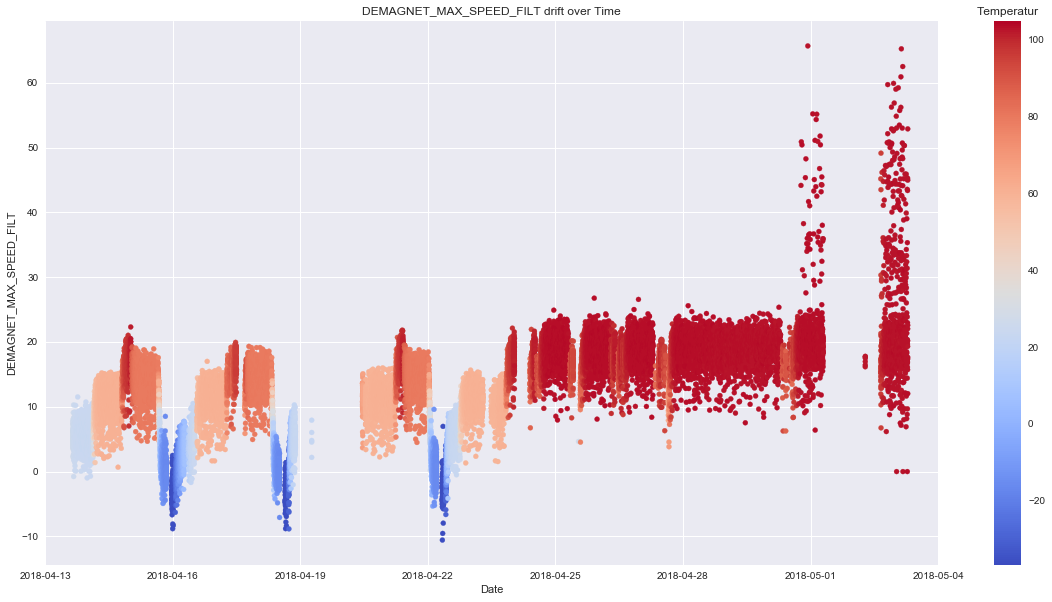

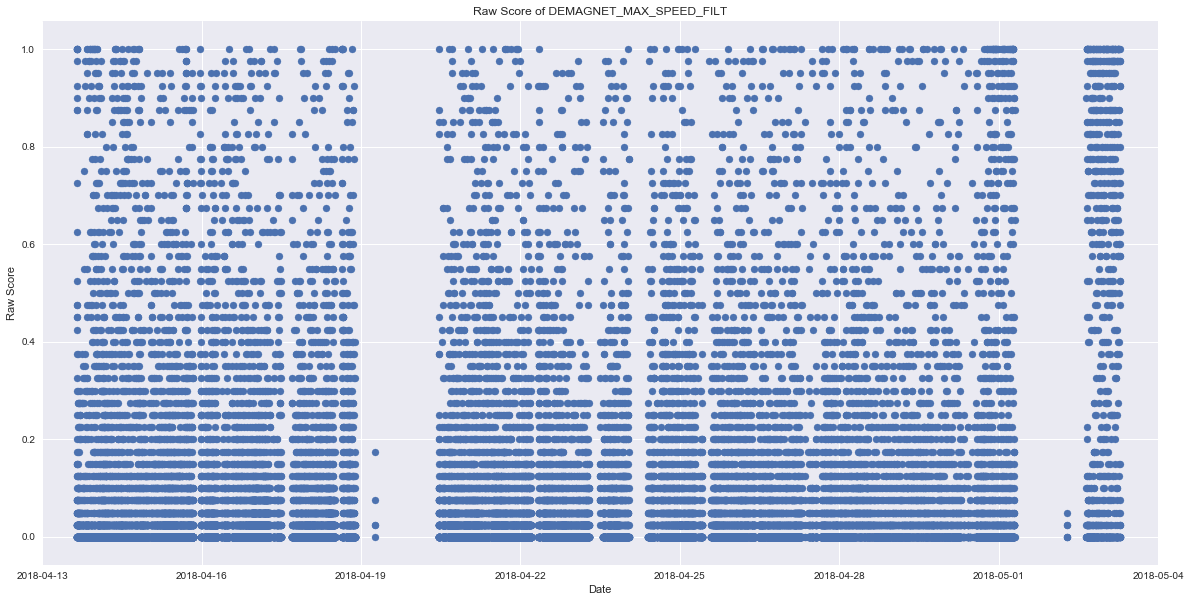

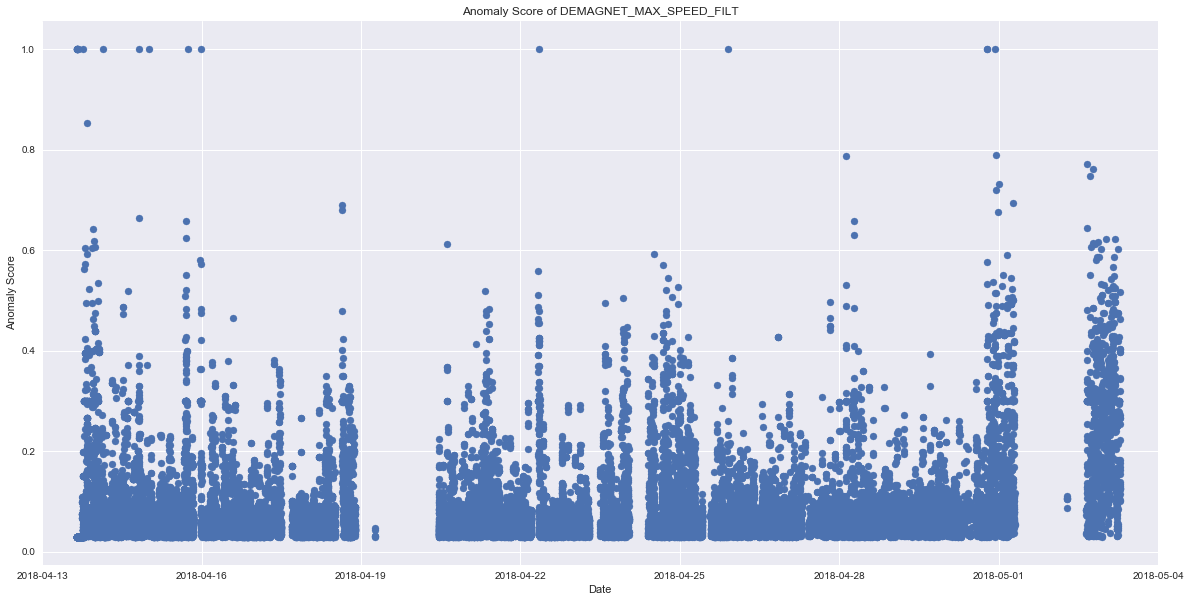

In [13]:
%matplotlib inline
#
fig, ax = plt.subplots(figsize=(20,10))
scatter = ax.scatter(df_anomaly['timestamp'].tolist(), y=df_anomaly['value'] , c=df_anomaly['IPB.TEMP.BAG'], s=100, marker='.', cmap=plt.cm.coolwarm)
clb = fig.colorbar(scatter)
clb.ax.set_title('Temperatur')
plt.xlabel("Date")
plt.ylabel("DEMAGNET_MAX_SPEED_FILT")
plt.title("DEMAGNET_MAX_SPEED_FILT drift over Time")
ax.set_xlim([datetime.date(2018, 4, 13), datetime.date(2018, 5, 4)])

#plot raw score
_, ax = plt.subplots(figsize=(20,10))
ax.scatter(df_anomaly['timestamp'].tolist(),df_anomaly['raw score'])
plt.xlabel("Date")
plt.ylabel("Raw Score")
plt.title("Raw Score of DEMAGNET_MAX_SPEED_FILT")
ax.set_xlim([datetime.date(2018, 4, 13), datetime.date(2018, 5, 4)])


#plot anomaly score
_, ax = plt.subplots(figsize=(20,10))
ax.scatter(df_anomaly['timestamp'].tolist(),df_anomaly['anomaly score'])
plt.xlabel("Date")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Score of DEMAGNET_MAX_SPEED_FILT")
ax.set_xlim([datetime.date(2018, 4, 13), datetime.date(2018, 5, 4)])

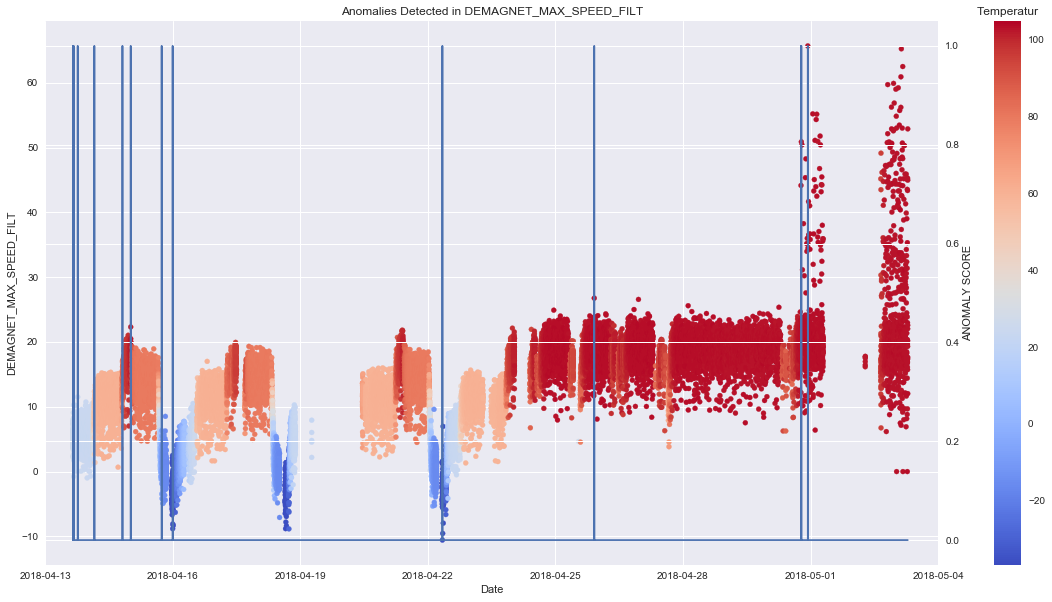

In [14]:
# Define a function for a plot with two y axes
def plot2y(x_data, x_label, y1_data, y1_label, y2_data, y2_label, title, color=None):

    fig, ax1 = plt.subplots(figsize=(20,10))
    scatter = ax1.scatter(x_data, y1_data, c=color,s=100, marker='.', cmap=plt.cm.coolwarm)
    clb = fig.colorbar(scatter)
    clb.ax.set_title('Temperatur')
    # Label axes
    ax1.set_ylabel(y1_label)
    ax1.set_xlabel(x_label)
    ax1.set_title(title)

    # Create the second plot object with the same x-axis
    ax2 = ax1.twinx()
    ax2.plot(x_data, y2_data)
    ax2.set_ylabel(y2_label)
    # Show right frame line
    ax2.spines['right'].set_visible(True)
    ax2.set_xlim([datetime.date(2018, 4, 13), datetime.date(2018, 5, 4)])
    

#create plot
plot2y(x_data = df_anomaly['timestamp'].tolist()
           , x_label = 'Date'
           , y1_data = df_anomaly['value']
           , y1_label = 'DEMAGNET_MAX_SPEED_FILT'
           , y2_data = df_anomaly['anomaly']
           , y2_label = 'ANOMALY SCORE'
           , title = 'Anomalies Detected in DEMAGNET_MAX_SPEED_FILT'
           , color = df_anomaly['IPB.TEMP.BAG'])


       anomaly score  raw score           timestamp          value  anomaly  \
2                1.0      1.000 2018-04-13 15:34:15     107.239364        1   
4                1.0      0.625 2018-04-13 15:34:59     160.745000        1   
5                1.0      0.925 2018-04-13 15:35:14     255.385563        1   
6                1.0      1.000 2018-04-13 15:36:12     382.483965        1   
15               1.0      0.475 2018-04-13 15:37:49      11.071580        1   
20               1.0      0.425 2018-04-13 15:38:56     516.716475        1   
49               1.0      0.525 2018-04-13 15:47:47     753.594202        1   
83               1.0      0.275 2018-04-13 15:58:49    1085.292019        1   
86               1.0      0.375 2018-04-13 15:59:28      -0.453700        1   
528              1.0      0.325 2018-04-13 18:17:01    1525.925419        1   
2284             1.0      0.350 2018-04-14 03:40:35    1881.960510        1   
5298             1.0      0.675 2018-04-14 19:32:03 

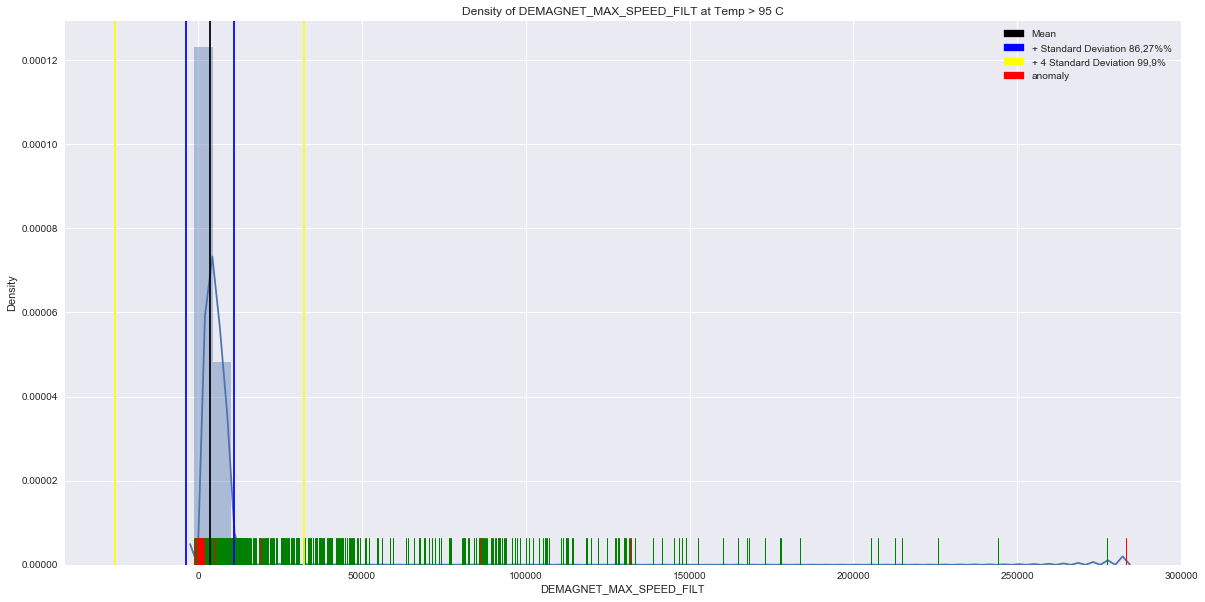

In [61]:
df_anomaly.get_value(24540, 'timestamp')
#df_tempgt95 = df_anomaly[df_anomaly['IPB.TEMP.BAG'] > 95.0]
df_tempgt95['value'] = df_tempgt95.value ** 3

mean = mpatches.Patch(color='black', label='Mean')
std1 = mpatches.Patch(color='blue', label='+ Standard Deviation 86,27%%')
std4 = mpatches.Patch(color='yellow', label='+ 4 Standard Deviation 99,9%')
red = mpatches.Patch(color='red', label='anomaly')

#print(df_tempgt95.head(3))
red_ticks = df_tempgt95[df_tempgt95['anomaly'] == 1]
green_ticks = df_tempgt95[df_tempgt95['anomaly'] < 1]
print(df_tempgt95[df_tempgt95.anomaly == 1])
print("Mean: " + str(np.mean(df_tempgt95.value)))
print("Standard deviation: " + str(np.std(df_tempgt95.value)))
    

#plot distribution of value > 95C°
_, ax = plt.subplots(figsize=(20,10))
ax = sns.distplot(df_tempgt95.value, hist=True)
sns.rugplot(green_ticks.value, color="green")
sns.rugplot(red_ticks.value, color="red")
ax.set(xlabel='DEMAGNET_MAX_SPEED_FILT', ylabel='Density', title="Density of DEMAGNET_MAX_SPEED_FILT at Temp > 95 C")
ax.axvline(np.mean(df_tempgt95.value), color="black")
ax.axvline((np.mean(df_tempgt95.value) + np.std(df_tempgt95.value)), color="blue")
ax.axvline((np.mean(df_tempgt95.value) - np.std(df_tempgt95.value)), color="blue")
ax.axvline((np.mean(df_tempgt95.value) + 4 * np.std(df_tempgt95.value)), color="yellow")
ax.axvline((np.mean(df_tempgt95.value) - 4 * np.std(df_tempgt95.value)), color="yellow")
ax.legend(handles=[mean, std1, std4, red])

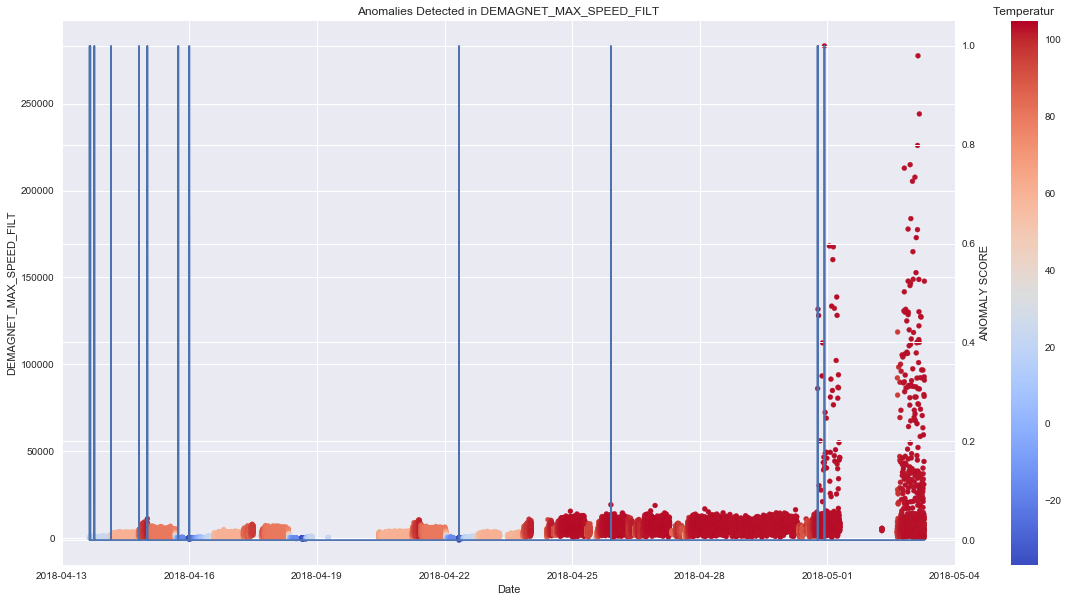

In [59]:
df_tempgt95['log_value'] = (df_tempgt95.value ** 3)
df_tempgt95

plot2y(x_data = df_tempgt95['timestamp'].tolist()
           , x_label = 'Date'
           , y1_data = df_tempgt95['log_value']
           , y1_label = 'DEMAGNET_MAX_SPEED_FILT'
           , y2_data = df_tempgt95['anomaly']
           , y2_label = 'ANOMALY SCORE'
           , title = 'Anomalies Detected in DEMAGNET_MAX_SPEED_FILT'
           , color = df_tempgt95['IPB.TEMP.BAG'])

In [17]:
def plot_anomaly_context(data, x_label, y_label, title, start, end):
    
    
    df_anomaly_context = data.iloc[start:end]
    df_anomaly_context.reset_index(level=0, inplace=True)
    
    red_patch = mpatches.Patch(color='red', label='Anomaly')
    green_patch = mpatches.Patch(color='green', label='Normal')
    blue_patch = mpatches.Patch(color='blue', label='Context Window', alpha=0.1)
    
    
    #plot full data, anomalies and context window
    df_anomaly_no = data[data['anomaly'] == 0]
    df_anomaly_yes = data[data['anomaly'] == 1]

    fig, ax1 = plt.subplots(figsize=(20,10))
    ax1.scatter(df_anomaly_no['timestamp'].tolist(), df_anomaly_no['value'], c='green',s=100, marker='.', zorder=1)
    ax1.scatter(df_anomaly_yes['timestamp'].tolist(), df_anomaly_yes['value'], c='red',s=100, marker='.', zorder=2)
    ax1.set_ylabel("DEMAGNET_MAX_SPEED_FILT")
    ax1.set_xlabel("Date")
    ax1.set_title("Detected Anomaly Points")
    ax1.set_xlim([datetime.date(2018, 4, 13), datetime.date(2018, 5, 4)])
    ax1.axvspan(data.get_value(start, 'timestamp'), data.get_value(end, 'timestamp'), facecolor='b', alpha=0.1  )
    ax1.legend(handles=[green_patch, red_patch, blue_patch])
      
    
    _, ax2 = plt.subplots(figsize=(20,10))
    ax2.bar(df_anomaly_context['index'], df_anomaly_context['value'], 
        color=['red' if row['anomaly'] == 1 else 'green' for _,row in df_anomaly_context.iterrows()])
    ax2.set_ylabel(y_label)
    ax2.set_xlabel(x_label)
    ax2.set_title(title)
    plt.legend(handles=[green_patch, red_patch])


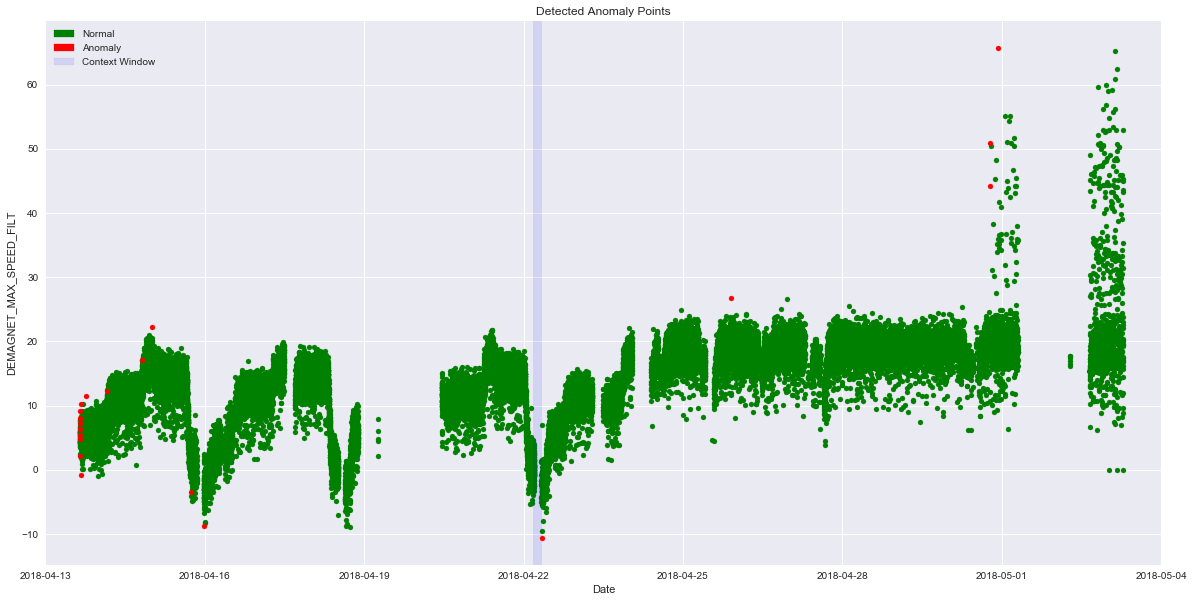

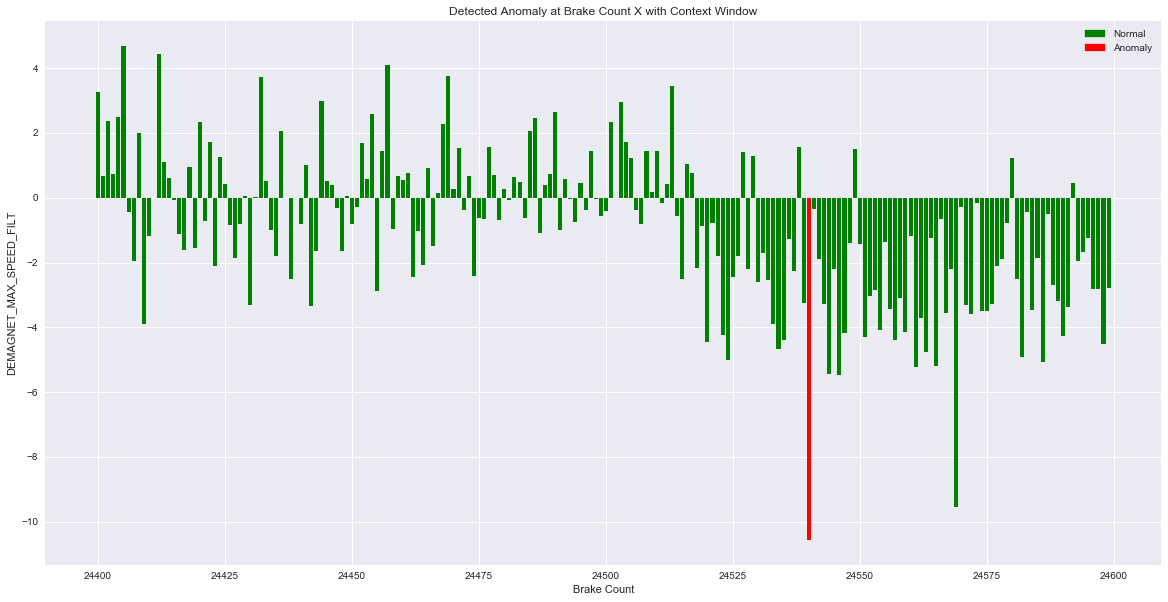

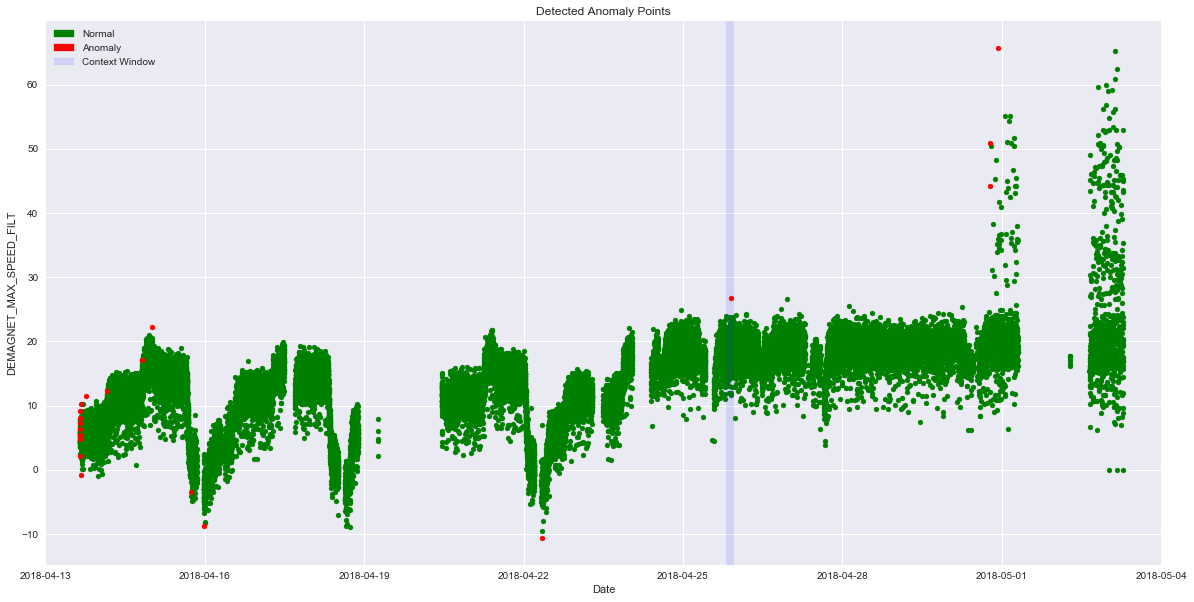

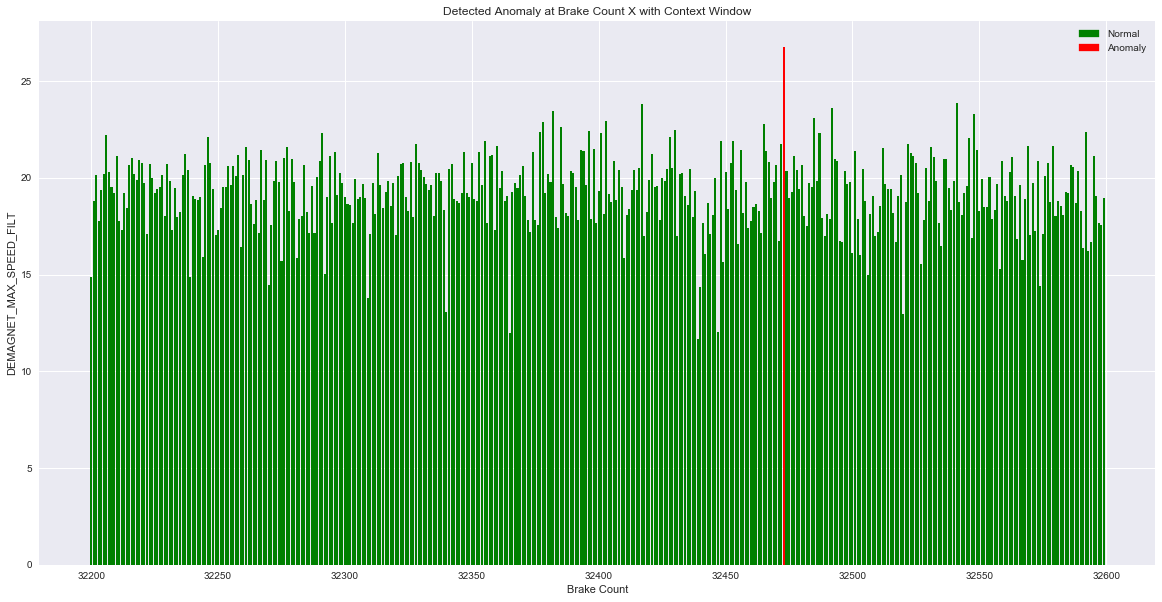

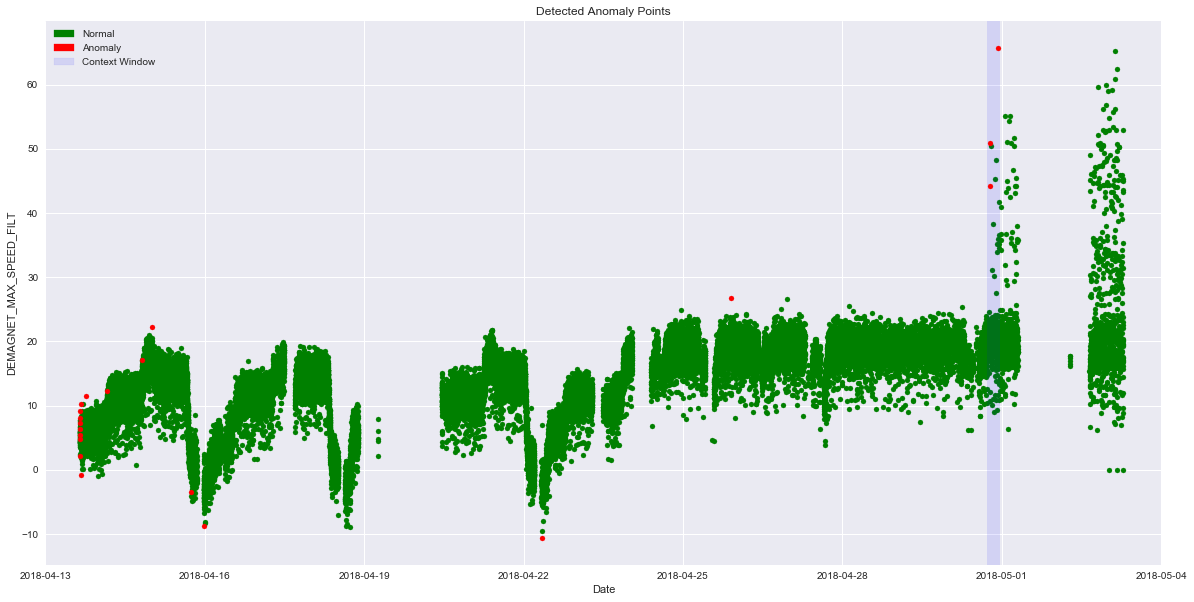

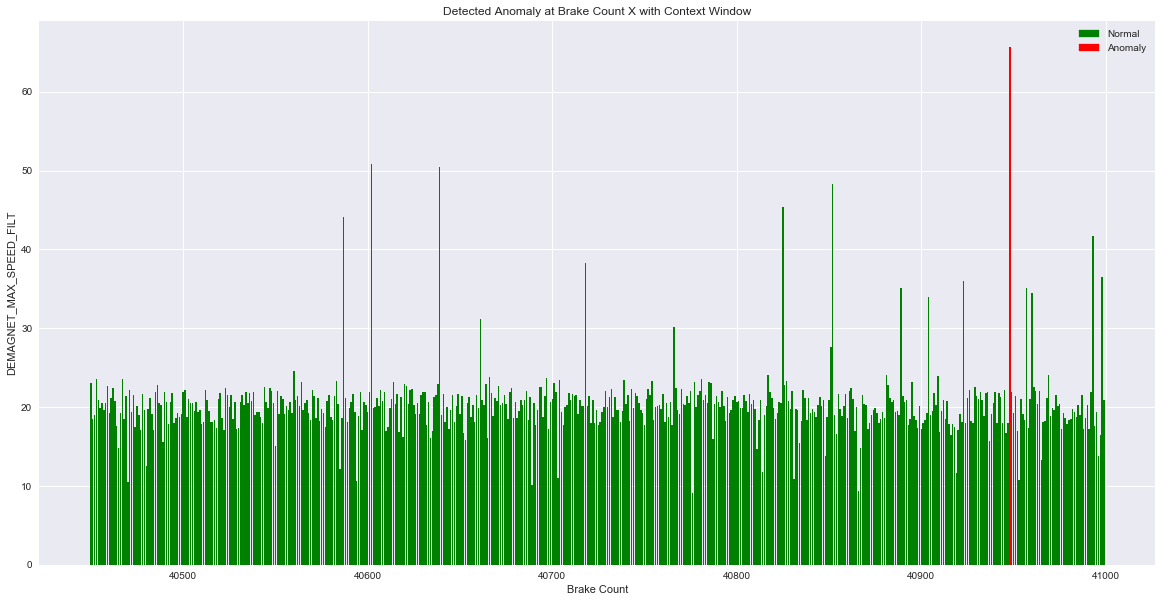

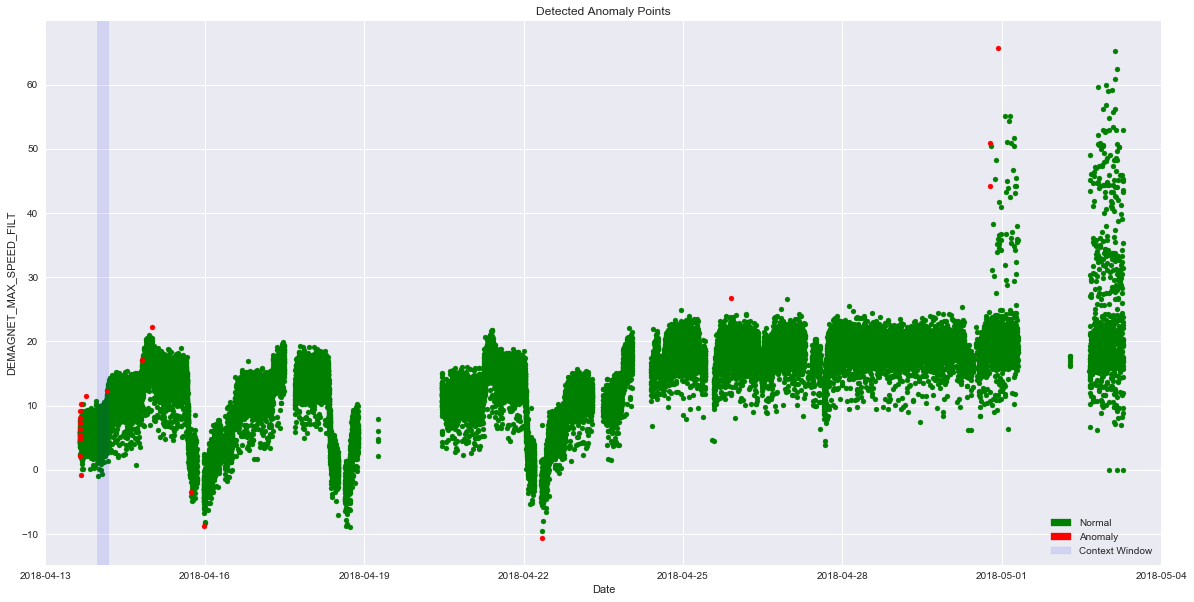

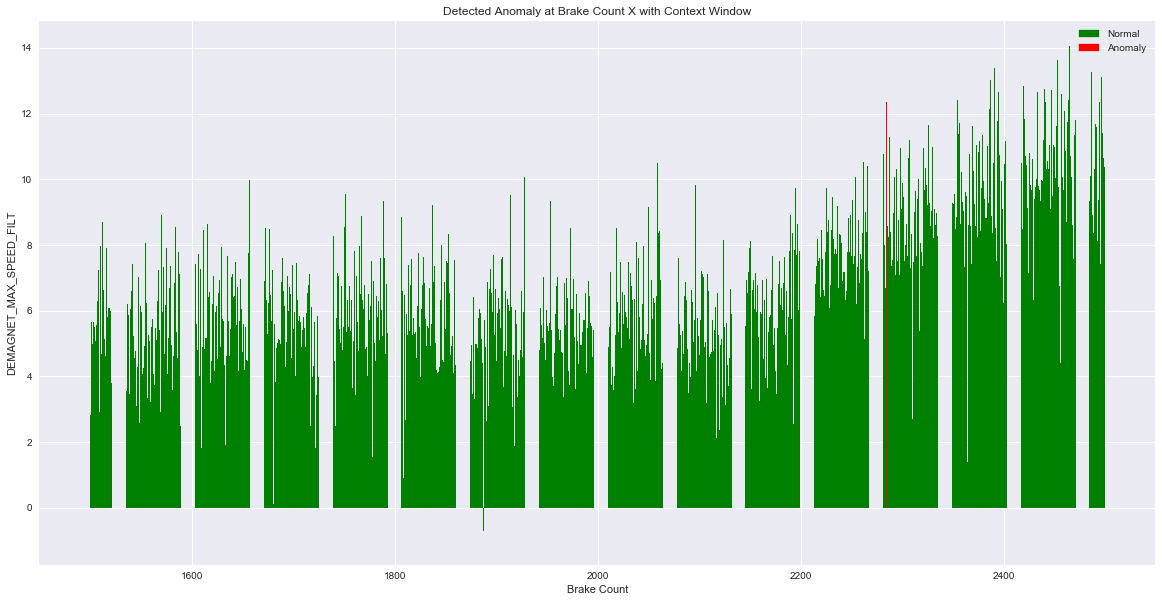

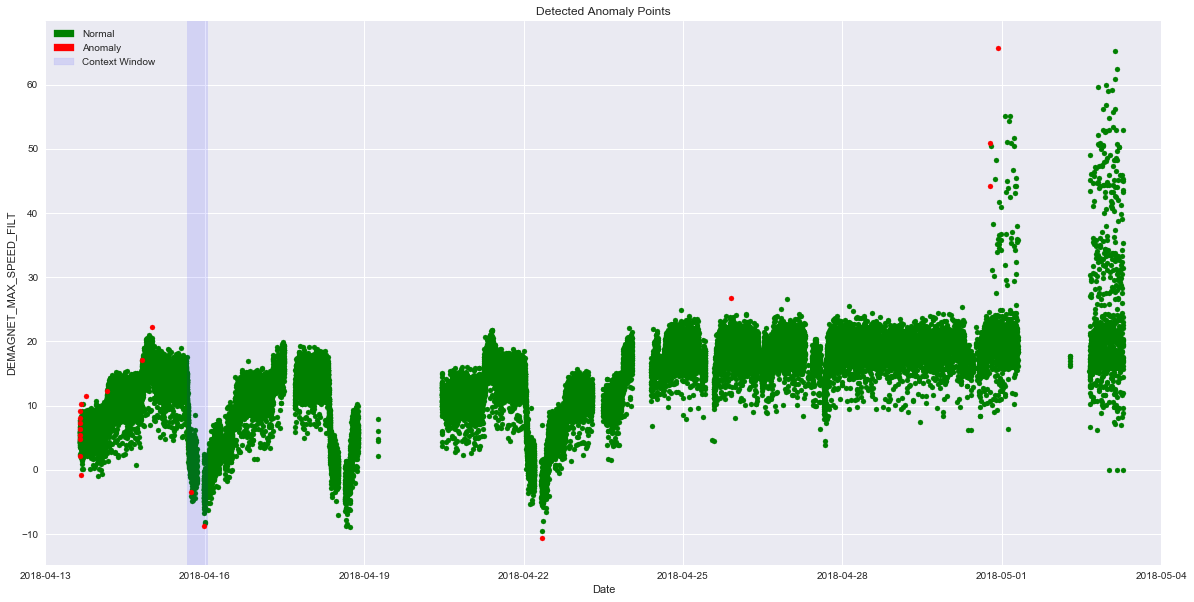

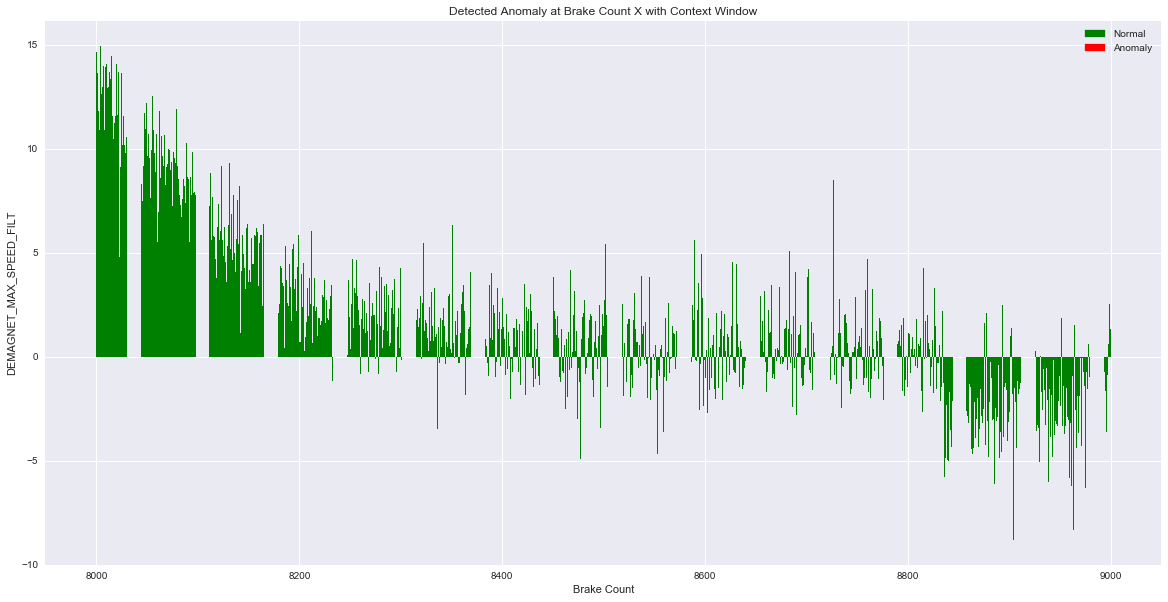

In [18]:
#plot anomaly at Brake Count 24540
plot_anomaly_context(df_anomaly, "Brake Count", "DEMAGNET_MAX_SPEED_FILT", "Detected Anomaly at Brake Count X with Context Window", 24400, 24600)

#plot anomaly at Brake Count 32473 
plot_anomaly_context(df_anomaly, "Brake Count", "DEMAGNET_MAX_SPEED_FILT", "Detected Anomaly at Brake Count X with Context Window", 32200, 32600)

#plot anomaly at Brake Count 40587, 40602, 40948
plot_anomaly_context(df_anomaly, "Brake Count", "DEMAGNET_MAX_SPEED_FILT", "Detected Anomaly at Brake Count X with Context Window", 40450, 41000)

#plot anomaly at Brake Count 40587, 40602, 40948
plot_anomaly_context(df_anomaly, "Brake Count", "DEMAGNET_MAX_SPEED_FILT", "Detected Anomaly at Brake Count X with Context Window", 1500, 2500)

plot_anomaly_context(df_anomaly, "Brake Count", "DEMAGNET_MAX_SPEED_FILT", "Detected Anomaly at Brake Count X with Context Window", 8000, 9000)